- mean_test_auc_roc using Logistic Regression:
- mean_test_auc_roc using KNN:0.631033
- mean_test_auc_roc using SVM:0.658805
- mean_test_auc_roc using Random Forest:0.657398
- mean_test_auc_roc using Decision Tree:0.640888
- mean_test_auc_roc using **Naive Bayes:0.659468**
- mean_test_auc_roc using Neural Network(Adam):0.634302
- mean_test_auc_roc using Neural Network(SGD):0.630862
- mean_test_auc_roc using Neural Network(RMSprop):0.629448

In [1]:
# globally useful imports of standard libraries needed in this notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
from datetime import datetime

# specific libraries or classes needed for the work in this notebook
#from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import LogisticRegressionCV
#from sklearn.svm import SVC
#from sklearn.naive_bayes import GaussianNB
#from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2, SelectFpr, f_regression, mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.pipeline import Pipeline
# need to use Pipeline from imblearn to add in a downsample or upsample
# to cross validation training
from imblearn.pipeline import Pipeline

# import project specific modules used in this notebook
import sys
sys.path.append('../src')
import mindwandering.data
import mindwandering.features
import mindwandering.evaluate
from mindwandering.data import FeatureScalerTransformer
from mindwandering.data import WinsorizationOutlierTransformer
from mindwandering.data import VIFThresholdTransformer
from mindwandering.data import FeatureSelectionTransformer
from mindwandering.data import ClassImbalanceTransformer
from mindwandering.data import GridSearchProgressHack

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD,Adam,RMSprop,Adagrad,Nadam

In [3]:
# Load Data and Features
df_features = mindwandering.data.get_df_features()
mind_wandered_label = mindwandering.data.get_mind_wandered_label()
participant_ids = mindwandering.data.get_participant_ids()

In [4]:
import tensorflow
auc_roc = tensorflow.keras.metrics.AUC(name='auc_roc',num_thresholds=20000,curve='ROC')

In [5]:
#First Model
def create_model():
    model = Sequential()
    model.add(Dense(
        50, 
        activation='swish', 
        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.l2(1e-4),
        activity_regularizer=regularizers.l2(1e-5)))
    #model.add(Dense(32, activation='relu'))
    #model.add(BatchNormalization())
    model.add(Dropout(0.3))
    #model.add(Dense(64,activation='swish'))
    #model.add(Dropout(0.2))
    #model.add(Dense(128,activation='relu'))
    #model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    optimizer=Nadam(learning_rate=0.01)
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy',auc_roc])
    return model

In [6]:
# Wrap Keras model so it can be used by scikit-learn
#kears_estimator = KerasClassifier(build_fn=create_model,epochs=100, batch_size=32, verbose=1)
kears_estimator = KerasClassifier(build_fn=create_model,epochs=200, batch_size=512, verbose=1)
#kears_estimator = KerasClassifier(build_fn=create_model, verbose=1)

In [7]:
# vif thresholds to apply to data and labels before grid search pipeline
#vif_thresholds = [0, 5]
vif_thresholds = [0]

# we want to actually select a certain percentage of features of whatever remains
# after vif thresholding.  So we will calculate these in the loop based on the number
# of features in data, and add to the parameters dictionary before the grid search
#features__k_ratios = np.array([0.25, 0.5, 0.75, 1.0])
features__k_ratios = np.array([0.2, 0.25, 0.3, 0.35, 0.4, 0.5])

# Empty dataframe to gather grid search results into 1 place
best_estimator = None
best_score = 0.0
best_params = {}
best_index = 0
df_result = None

# search over vif threshold meta parameters, create separate df from vif_threshold
# for otherwise identical grid searches
for vif_threshold in vif_thresholds:
    # display progress
    print('')
    print('=' * 50)
    print('Starting vif meta-parameter condition: vif_threshold: ', vif_threshold)
    
    # pipeline to apply vif threshold selection
    vif_pipeline = Pipeline(
      [
        ('vif',      VIFThresholdTransformer(score_threshold=vif_threshold)),
      ]
    )
 
    df_vif_features = vif_pipeline.transform(df_features)
    num_trials, num_features = df_vif_features.shape
    print('   Number of trials: ', num_trials, ' Number of Features: ', num_features)
    
    parameters = {
        'scaling__type_of_scaling': ['standard'],
        'outlier__outlier_threshold': [0.0, 3.0],
        'features__k': [12],
        #'balance__balancer_type': ['random-undersampler', 'allknn', 'nearmiss', 'instance-hardness-threshold'],
        #'balance__balancer_type': ['allknn', 'condensed-nn', 'neighbourhood-cleaning', 'one-sided-selection'],
        #'balance__balancer_type': ['allknn', 'one-sided-selection'],
        'balance__balancer_type': ['allknn', 'smote-enn'],
        #'model__var_smoothing': [1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12],
        #'model__batch_size': [8, 16, 24, 32, 40, 48],#usually multiple of 8
        #'model__epochs':[100,150,200],
        #'model__batch_size': [60],
        #'model__epochs':[10],
        #'model__optimizer' : ['RMSprop', 'Adagrad', 'Adadelta','Adam']
    }

    # set feature selection k correctly
    features__k = features__k_ratios * num_features
    features__k = features__k.astype(int) 
    parameters['features__k'] = features__k.tolist()

    # Estimator Pipeline
    pipeline = Pipeline(
      [
        ('progress', GridSearchProgressHack(verbose=False)),
        ('scaling',  FeatureScalerTransformer()),
        ('outlier',  WinsorizationOutlierTransformer()),
        ('features', SelectKBest()),
        #('features', SelectFromModel(estimator=LogisticRegression(solver='liblinear', penalty='l1', C=0.1), threshold=-np.inf)),
        ('balance',  ClassImbalanceTransformer()),
        ('model',    kears_estimator)
      ]
    )
    
    # Cross Validation Splitter
    cv_group_splitter = GroupKFold(n_splits=5)
    #cv_group_splitter = LeaveOneGroupOut()

    # perform the grid search for this vif selection
    # set up the search
    search = GridSearchCV(
        estimator = pipeline,
        param_grid = parameters,
        scoring = ['roc_auc','accuracy'],
        cv = cv_group_splitter,
        refit = 'roc_auc',
        verbose = 1
    )
    search.fit(df_vif_features, mind_wandered_label, groups=participant_ids)
    
    # append results onto the dataframe collecting the results.  Need to add
    # a feature column to this dataframe for the vif vit condition here
    df = pd.DataFrame(data=search.cv_results_)
    df['param__vif_score_threshold'] = vif_threshold
    
    if best_estimator is None:
        df_result = df
        best_estimator = search.best_estimator_
        best_score = search.best_score_
        best_params = search.best_params_
        best_index = search.best_index_
    else:
        df_result = df_result.append(df, ignore_index=True)
        if search.best_score_ > best_score:
            best_estimator = search.best_estimator_
            best_score = search.best_score_
            best_params = search.best_params_
            best_index = search.best_index_  # todo this is only the index of this search


Starting vif meta-parameter condition: vif_threshold:  0
   Number of trials:  4076  Number of Features:  62
Fitting 5 folds for each of 24 candidates, totalling 120 fits
0001 Epoch 1/200
4/4 [==============================] - 6s 118ms/step - loss: 0.6670 - accuracy: 0.6007 - auc_roc: 0.6348
Epoch 2/200
4/4 [==============================] - 1s 120ms/step - loss: 0.5971 - accuracy: 0.7044 - auc_roc: 0.7518
Epoch 3/200
4/4 [==============================] - 1s 117ms/step - loss: 0.5928 - accuracy: 0.7004 - auc_roc: 0.7507
Epoch 4/200
4/4 [==============================] - 1s 126ms/step - loss: 0.5795 - accuracy: 0.7117 - auc_roc: 0.7662
Epoch 5/200
4/4 [==============================] - 1s 130ms/step - loss: 0.5660 - accuracy: 0.7178 - auc_roc: 0.7767
Epoch 6/200
4/4 [==============================] - 1s 131ms/step - loss: 0.5463 - accuracy: 0.7363 - auc_roc: 0.7988
Epoch 7/200
4/4 [==============================] - 1s 129ms/step - loss: 0.5446 - accuracy: 0.7298 - auc_roc: 0.7994
Epoc

4/4 [==============================] - 1s 254ms/step - loss: 0.5179 - accuracy: 0.7478 - auc_roc: 0.8180
Epoch 69/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5223 - accuracy: 0.7422 - auc_roc: 0.8143
Epoch 70/200
4/4 [==============================] - 1s 192ms/step - loss: 0.5147 - accuracy: 0.7560 - auc_roc: 0.8222
Epoch 71/200
4/4 [==============================] - 1s 192ms/step - loss: 0.5084 - accuracy: 0.7569 - auc_roc: 0.8254
Epoch 72/200
4/4 [==============================] - 1s 200ms/step - loss: 0.5094 - accuracy: 0.7511 - auc_roc: 0.8231
Epoch 73/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5084 - accuracy: 0.7551 - auc_roc: 0.8252
Epoch 74/200
4/4 [==============================] - 1s 215ms/step - loss: 0.5186 - accuracy: 0.7472 - auc_roc: 0.8204
Epoch 75/200
4/4 [==============================] - 1s 239ms/step - loss: 0.5063 - accuracy: 0.7596 - auc_roc: 0.8296
Epoch 76/200
4/4 [==============================] - 1s 208ms/step - l

4/4 [==============================] - 1s 245ms/step - loss: 0.5030 - accuracy: 0.7596 - auc_roc: 0.8304
Epoch 138/200
4/4 [==============================] - 1s 285ms/step - loss: 0.5055 - accuracy: 0.7588 - auc_roc: 0.8281
Epoch 139/200
4/4 [==============================] - 1s 213ms/step - loss: 0.4923 - accuracy: 0.7743 - auc_roc: 0.8411
Epoch 140/200
4/4 [==============================] - 1s 221ms/step - loss: 0.5104 - accuracy: 0.7454 - auc_roc: 0.8273
Epoch 141/200
4/4 [==============================] - 1s 247ms/step - loss: 0.4908 - accuracy: 0.7779 - auc_roc: 0.8438
Epoch 142/200
4/4 [==============================] - 1s 268ms/step - loss: 0.5055 - accuracy: 0.7636 - auc_roc: 0.8303
Epoch 143/200
4/4 [==============================] - 1s 195ms/step - loss: 0.4927 - accuracy: 0.7641 - auc_roc: 0.8367
Epoch 144/200
4/4 [==============================] - 1s 245ms/step - loss: 0.4975 - accuracy: 0.7581 - auc_roc: 0.8340
Epoch 145/200
4/4 [==============================] - 1s 195ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 2s 20ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 26ms/step
0002 Epoch 1/200
4/4 [==============================] - 22s 268ms/step - loss: 0.7070 - accuracy: 0.5218 - auc_roc: 0.7512
Epoch 2/200
4/4 [==============================] - 1s 215ms/step - loss: 0.6239 - accuracy: 0.6628 - auc_roc: 0.7074
Epoch 3/200
4/4 [==============================] - 1s 252ms/step - loss: 0.5976 - accuracy: 0.6813 - auc_roc: 0.7365
Epoch 4/200
4/4 [==============================] - 1s 266ms/step - loss: 0.5829 - accuracy: 0.6917 - auc_roc: 0.7600
Epoch 5/200
4/4 [==============================] - 1s 269ms/step - loss: 0.5757 - accuracy: 0.7028 - auc_roc: 0.7659
Epoch 6/200
4/4 [==============================] - 1s 245ms/step - loss: 0.5665 - accuracy: 0.7180 - auc_roc: 0.7788
Epoch 7/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5695 - accuracy: 0.7202 - auc_roc: 0.7757
Epoch 8/200
4/4 [==============================] - 1s 252ms/step - loss: 0.5673 - accuracy: 0.7114 - auc_roc: 0.7815
Epoch 

4/4 [==============================] - 1s 242ms/step - loss: 0.5276 - accuracy: 0.7342 - auc_roc: 0.8125
Epoch 71/200
4/4 [==============================] - 1s 205ms/step - loss: 0.5276 - accuracy: 0.7425 - auc_roc: 0.8109
Epoch 72/200
4/4 [==============================] - 1s 212ms/step - loss: 0.5225 - accuracy: 0.7345 - auc_roc: 0.8151
Epoch 73/200
4/4 [==============================] - 1s 181ms/step - loss: 0.5290 - accuracy: 0.7368 - auc_roc: 0.8101
Epoch 74/200
4/4 [==============================] - 1s 209ms/step - loss: 0.5306 - accuracy: 0.7401 - auc_roc: 0.8103
Epoch 75/200
4/4 [==============================] - 1s 199ms/step - loss: 0.5284 - accuracy: 0.7341 - auc_roc: 0.8052
Epoch 76/200
4/4 [==============================] - 1s 219ms/step - loss: 0.5208 - accuracy: 0.7345 - auc_roc: 0.8207
Epoch 77/200
4/4 [==============================] - 1s 210ms/step - loss: 0.5325 - accuracy: 0.7437 - auc_roc: 0.8099
Epoch 78/200
4/4 [==============================] - 1s 200ms/step - l

4/4 [==============================] - 1s 229ms/step - loss: 0.5158 - accuracy: 0.7479 - auc_roc: 0.8256
Epoch 140/200
4/4 [==============================] - 1s 246ms/step - loss: 0.5256 - accuracy: 0.7496 - auc_roc: 0.8197
Epoch 141/200
4/4 [==============================] - 1s 253ms/step - loss: 0.5111 - accuracy: 0.7584 - auc_roc: 0.8254
Epoch 142/200
4/4 [==============================] - 1s 245ms/step - loss: 0.5122 - accuracy: 0.7599 - auc_roc: 0.8266
Epoch 143/200
4/4 [==============================] - 1s 269ms/step - loss: 0.5125 - accuracy: 0.7592 - auc_roc: 0.8238
Epoch 144/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5046 - accuracy: 0.7555 - auc_roc: 0.8323
Epoch 145/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5134 - accuracy: 0.7496 - auc_roc: 0.8241
Epoch 146/200
4/4 [==============================] - 1s 255ms/step - loss: 0.5227 - accuracy: 0.7402 - auc_roc: 0.8198
Epoch 147/200
4/4 [==============================] - 1s 255ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 87ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 8ms/step
0003 Epoch 1/200
4/4 [==============================] - 22s 253ms/step - loss: 0.7250 - accuracy: 0.5417 - auc_roc: 0.7424
Epoch 2/200
4/4 [==============================] - 1s 246ms/step - loss: 0.6102 - accuracy: 0.6866 - auc_roc: 0.7374
Epoch 3/200
4/4 [==============================] - 1s 263ms/step - loss: 0.6068 - accuracy: 0.6923 - auc_roc: 0.7447
Epoch 4/200
4/4 [==============================] - 1s 285ms/step - loss: 0.5830 - accuracy: 0.7070 - auc_roc: 0.7675
Epoch 5/200
4/4 [==============================] - 1s 262ms/step - loss: 0.5777 - accuracy: 0.7152 - auc_roc: 0.7726
Epoch 6/200
4/4 [==============================] - 1s 258ms/step - loss: 0.5700 - accuracy: 0.7263 - auc_roc: 0.7828
Epoch 7/200
4/4 [==============================] - 1s 273ms/step - loss: 0.5653 - accuracy: 0.7290 - auc_roc: 0.7869
Epoch 8/200
4/4 [==============================] - 1s 241ms/step - loss: 0.5631 - accuracy: 0.7312 - auc_roc: 0.7850
Epoch 9

4/4 [==============================] - 1s 186ms/step - loss: 0.5377 - accuracy: 0.7408 - auc_roc: 0.8053
Epoch 71/200
4/4 [==============================] - 1s 195ms/step - loss: 0.5227 - accuracy: 0.7598 - auc_roc: 0.8233
Epoch 72/200
4/4 [==============================] - 1s 183ms/step - loss: 0.5350 - accuracy: 0.7425 - auc_roc: 0.8086
Epoch 73/200
4/4 [==============================] - 1s 201ms/step - loss: 0.5361 - accuracy: 0.7420 - auc_roc: 0.8083
Epoch 74/200
4/4 [==============================] - 1s 190ms/step - loss: 0.5389 - accuracy: 0.7434 - auc_roc: 0.8086
Epoch 75/200
4/4 [==============================] - 1s 178ms/step - loss: 0.5311 - accuracy: 0.7520 - auc_roc: 0.8180
Epoch 76/200
4/4 [==============================] - 1s 169ms/step - loss: 0.5415 - accuracy: 0.7406 - auc_roc: 0.8078
Epoch 77/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5342 - accuracy: 0.7421 - auc_roc: 0.8111
Epoch 78/200
4/4 [==============================] - 1s 217ms/step - l

4/4 [==============================] - 1s 212ms/step - loss: 0.5230 - accuracy: 0.7567 - auc_roc: 0.8202
Epoch 140/200
4/4 [==============================] - 1s 199ms/step - loss: 0.5294 - accuracy: 0.7406 - auc_roc: 0.8103
Epoch 141/200
4/4 [==============================] - 1s 172ms/step - loss: 0.5230 - accuracy: 0.7463 - auc_roc: 0.8213
Epoch 142/200
4/4 [==============================] - 1s 262ms/step - loss: 0.5226 - accuracy: 0.7529 - auc_roc: 0.8177
Epoch 143/200
4/4 [==============================] - 1s 275ms/step - loss: 0.5272 - accuracy: 0.7572 - auc_roc: 0.8155
Epoch 144/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5161 - accuracy: 0.7571 - auc_roc: 0.8245
Epoch 145/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5296 - accuracy: 0.7517 - auc_roc: 0.8149
Epoch 146/200
4/4 [==============================] - 1s 260ms/step - loss: 0.5048 - accuracy: 0.7662 - auc_roc: 0.8362
Epoch 147/200
4/4 [==============================] - 1s 239ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 18ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 35ms/step
0004 Epoch 1/200
4/4 [==============================] - 22s 272ms/step - loss: 0.6311 - accuracy: 0.6573 - auc_roc: 0.7866
Epoch 2/200
4/4 [==============================] - 1s 202ms/step - loss: 0.5914 - accuracy: 0.7056 - auc_roc: 0.7576
Epoch 3/200
4/4 [==============================] - 1s 253ms/step - loss: 0.5830 - accuracy: 0.7084 - auc_roc: 0.7687
Epoch 4/200
4/4 [==============================] - 1s 250ms/step - loss: 0.5762 - accuracy: 0.7241 - auc_roc: 0.7772
Epoch 5/200
4/4 [==============================] - 1s 267ms/step - loss: 0.5642 - accuracy: 0.7246 - auc_roc: 0.7795
Epoch 6/200
4/4 [==============================] - 1s 258ms/step - loss: 0.5683 - accuracy: 0.7307 - auc_roc: 0.7839
Epoch 7/200
4/4 [==============================] - 1s 237ms/step - loss: 0.5686 - accuracy: 0.7280 - auc_roc: 0.7785
Epoch 8/200
4/4 [==============================] - 1s 254ms/step - loss: 0.5596 - accuracy: 0.7287 - auc_roc: 0.7855
Epoch 

4/4 [==============================] - 1s 200ms/step - loss: 0.5294 - accuracy: 0.7539 - auc_roc: 0.8163
Epoch 71/200
4/4 [==============================] - 1s 177ms/step - loss: 0.5242 - accuracy: 0.7526 - auc_roc: 0.8170
Epoch 72/200
4/4 [==============================] - 1s 204ms/step - loss: 0.5329 - accuracy: 0.7565 - auc_roc: 0.8145
Epoch 73/200
4/4 [==============================] - 1s 220ms/step - loss: 0.5256 - accuracy: 0.7461 - auc_roc: 0.8152
Epoch 74/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5256 - accuracy: 0.7523 - auc_roc: 0.8180
Epoch 75/200
4/4 [==============================] - 1s 215ms/step - loss: 0.5295 - accuracy: 0.7465 - auc_roc: 0.8133
Epoch 76/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5379 - accuracy: 0.7477 - auc_roc: 0.8117
Epoch 77/200
4/4 [==============================] - 1s 214ms/step - loss: 0.5302 - accuracy: 0.7507 - auc_roc: 0.8137
Epoch 78/200
4/4 [==============================] - 1s 188ms/step - l

4/4 [==============================] - 1s 214ms/step - loss: 0.5327 - accuracy: 0.7442 - auc_roc: 0.8121
Epoch 140/200
4/4 [==============================] - 1s 195ms/step - loss: 0.5230 - accuracy: 0.7477 - auc_roc: 0.8190
Epoch 141/200
4/4 [==============================] - 1s 213ms/step - loss: 0.5153 - accuracy: 0.7544 - auc_roc: 0.8261
Epoch 142/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5146 - accuracy: 0.7601 - auc_roc: 0.8234
Epoch 143/200
4/4 [==============================] - 1s 207ms/step - loss: 0.5197 - accuracy: 0.7411 - auc_roc: 0.8214
Epoch 144/200
4/4 [==============================] - 1s 223ms/step - loss: 0.5272 - accuracy: 0.7591 - auc_roc: 0.8171
Epoch 145/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5232 - accuracy: 0.7569 - auc_roc: 0.8214
Epoch 146/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5245 - accuracy: 0.7522 - auc_roc: 0.8169
Epoch 147/200
4/4 [==============================] - 1s 198ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 6s 27ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 7ms/step
0005 Epoch 1/200
4/4 [==============================] - 20s 195ms/step - loss: 0.6860 - accuracy: 0.5892 - auc_roc: 0.7555
Epoch 2/200
4/4 [==============================] - 1s 209ms/step - loss: 0.6029 - accuracy: 0.7026 - auc_roc: 0.7502
Epoch 3/200
4/4 [==============================] - 1s 245ms/step - loss: 0.5973 - accuracy: 0.7093 - auc_roc: 0.7554
Epoch 4/200
4/4 [==============================] - 1s 223ms/step - loss: 0.5729 - accuracy: 0.7175 - auc_roc: 0.7758
Epoch 5/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5663 - accuracy: 0.7154 - auc_roc: 0.7859
Epoch 6/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5596 - accuracy: 0.7228 - auc_roc: 0.7932
Epoch 7/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5544 - accuracy: 0.7373 - auc_roc: 0.7970
Epoch 8/200
4/4 [==============================] - 1s 198ms/step - loss: 0.5473 - accuracy: 0.7423 - auc_roc: 0.8042
Epoch 9

4/4 [==============================] - 1s 232ms/step - loss: 0.5166 - accuracy: 0.7592 - auc_roc: 0.8231
Epoch 71/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5012 - accuracy: 0.7732 - auc_roc: 0.8351
Epoch 72/200
4/4 [==============================] - 1s 217ms/step - loss: 0.5089 - accuracy: 0.7589 - auc_roc: 0.8285
Epoch 73/200
4/4 [==============================] - 1s 221ms/step - loss: 0.5334 - accuracy: 0.7450 - auc_roc: 0.8087
Epoch 74/200
4/4 [==============================] - 1s 208ms/step - loss: 0.5286 - accuracy: 0.7537 - auc_roc: 0.8172
Epoch 75/200
4/4 [==============================] - 1s 192ms/step - loss: 0.5234 - accuracy: 0.7522 - auc_roc: 0.8220
Epoch 76/200
4/4 [==============================] - 1s 182ms/step - loss: 0.5295 - accuracy: 0.7559 - auc_roc: 0.8127
Epoch 77/200
4/4 [==============================] - 1s 198ms/step - loss: 0.5026 - accuracy: 0.7685 - auc_roc: 0.8351
Epoch 78/200
4/4 [==============================] - 1s 219ms/step - l

4/4 [==============================] - 1s 267ms/step - loss: 0.5070 - accuracy: 0.7639 - auc_roc: 0.8311
Epoch 140/200
4/4 [==============================] - 1s 270ms/step - loss: 0.4983 - accuracy: 0.7664 - auc_roc: 0.8382
Epoch 141/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5043 - accuracy: 0.7665 - auc_roc: 0.8346
Epoch 142/200
4/4 [==============================] - 1s 273ms/step - loss: 0.5137 - accuracy: 0.7577 - auc_roc: 0.8222
Epoch 143/200
4/4 [==============================] - 1s 252ms/step - loss: 0.5144 - accuracy: 0.7483 - auc_roc: 0.8251
Epoch 144/200
4/4 [==============================] - 1s 263ms/step - loss: 0.4968 - accuracy: 0.7666 - auc_roc: 0.8365
Epoch 145/200
4/4 [==============================] - 1s 315ms/step - loss: 0.4957 - accuracy: 0.7735 - auc_roc: 0.8389
Epoch 146/200
4/4 [==============================] - 1s 261ms/step - loss: 0.5043 - accuracy: 0.7673 - auc_roc: 0.8326
Epoch 147/200
4/4 [==============================] - 1s 281ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 107ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 30ms/step
0006 Epoch 1/200
4/4 [==============================] - 19s 205ms/step - loss: 0.7014 - accuracy: 0.5292 - auc_roc: 0.7530
Epoch 2/200
4/4 [==============================] - 1s 236ms/step - loss: 0.6147 - accuracy: 0.6759 - auc_roc: 0.7244
Epoch 3/200
4/4 [==============================] - 1s 260ms/step - loss: 0.5899 - accuracy: 0.7091 - auc_roc: 0.7623
Epoch 4/200
4/4 [==============================] - 1s 214ms/step - loss: 0.5704 - accuracy: 0.7120 - auc_roc: 0.7757
Epoch 5/200
4/4 [==============================] - 1s 202ms/step - loss: 0.5667 - accuracy: 0.7277 - auc_roc: 0.7815
Epoch 6/200
4/4 [==============================] - 1s 186ms/step - loss: 0.5602 - accuracy: 0.7127 - auc_roc: 0.7832
Epoch 7/200
4/4 [==============================] - 1s 205ms/step - loss: 0.5537 - accuracy: 0.7304 - auc_roc: 0.7915
Epoch 8/200
4/4 [==============================] - 1s 190ms/step - loss: 0.5421 - accuracy: 0.7270 - auc_roc: 0.7974
Epoch 

4/4 [==============================] - 1s 207ms/step - loss: 0.5031 - accuracy: 0.7656 - auc_roc: 0.8316
Epoch 71/200
4/4 [==============================] - 1s 214ms/step - loss: 0.5146 - accuracy: 0.7476 - auc_roc: 0.8240
Epoch 72/200
4/4 [==============================] - 1s 235ms/step - loss: 0.4979 - accuracy: 0.7657 - auc_roc: 0.8343
Epoch 73/200
4/4 [==============================] - 1s 207ms/step - loss: 0.5074 - accuracy: 0.7546 - auc_roc: 0.8293
Epoch 74/200
4/4 [==============================] - 1s 234ms/step - loss: 0.5077 - accuracy: 0.7452 - auc_roc: 0.8248
Epoch 75/200
4/4 [==============================] - 1s 198ms/step - loss: 0.5106 - accuracy: 0.7510 - auc_roc: 0.8252
Epoch 76/200
4/4 [==============================] - 1s 199ms/step - loss: 0.5164 - accuracy: 0.7440 - auc_roc: 0.8195
Epoch 77/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5025 - accuracy: 0.7617 - auc_roc: 0.8301
Epoch 78/200
4/4 [==============================] - 1s 243ms/step - l

4/4 [==============================] - 1s 228ms/step - loss: 0.5130 - accuracy: 0.7413 - auc_roc: 0.8239
Epoch 139/200
4/4 [==============================] - 1s 263ms/step - loss: 0.4905 - accuracy: 0.7566 - auc_roc: 0.8401
Epoch 140/200
4/4 [==============================] - 1s 237ms/step - loss: 0.5015 - accuracy: 0.7623 - auc_roc: 0.8337
Epoch 141/200
4/4 [==============================] - 1s 211ms/step - loss: 0.5094 - accuracy: 0.7654 - auc_roc: 0.8270
Epoch 142/200
4/4 [==============================] - 1s 240ms/step - loss: 0.5023 - accuracy: 0.7464 - auc_roc: 0.8303
Epoch 143/200
4/4 [==============================] - 1s 229ms/step - loss: 0.4934 - accuracy: 0.7670 - auc_roc: 0.8378
Epoch 144/200
4/4 [==============================] - 1s 228ms/step - loss: 0.5015 - accuracy: 0.7547 - auc_roc: 0.8351
Epoch 145/200
4/4 [==============================] - 1s 239ms/step - loss: 0.5074 - accuracy: 0.7535 - auc_roc: 0.8276
Epoch 146/200
4/4 [==============================] - 1s 248ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 16ms/step
0007 Epoch 1/200
4/4 [==============================] - 23s 248ms/step - loss: 0.6487 - accuracy: 0.6182 - auc_roc: 0.7835
Epoch 2/200
4/4 [==============================] - 1s 198ms/step - loss: 0.5964 - accuracy: 0.6938 - auc_roc: 0.7478
Epoch 3/200
4/4 [==============================] - 1s 224ms/step - loss: 0.5897 - accuracy: 0.6991 - auc_roc: 0.7525
Epoch 4/200
4/4 [==============================] - 1s 210ms/step - loss: 0.5758 - accuracy: 0.7051 - auc_roc: 0.7648
Epoch 5/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5702 - accuracy: 0.7092 - auc_roc: 0.7743
Epoch 6/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5590 - accuracy: 0.7142 - auc_roc: 0.7787
Epoch 7/200
4/4 [==============================] - 1s 211ms/step - loss: 0.5539 - accuracy: 0.7250 - auc_roc: 0.7879
Epoch 8/200
4/4 [==============================] - 1s 224ms/step - loss: 0.5490 - accuracy: 0.7219 - auc_roc: 0.7876
Epoch 

4/4 [==============================] - 1s 226ms/step - loss: 0.5198 - accuracy: 0.7405 - auc_roc: 0.8178
Epoch 71/200
4/4 [==============================] - 1s 259ms/step - loss: 0.5048 - accuracy: 0.7564 - auc_roc: 0.8262
Epoch 72/200
4/4 [==============================] - 1s 221ms/step - loss: 0.5098 - accuracy: 0.7501 - auc_roc: 0.8250
Epoch 73/200
4/4 [==============================] - 1s 254ms/step - loss: 0.5164 - accuracy: 0.7506 - auc_roc: 0.8222
Epoch 74/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5198 - accuracy: 0.7454 - auc_roc: 0.8202
Epoch 75/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5076 - accuracy: 0.7511 - auc_roc: 0.8238
Epoch 76/200
4/4 [==============================] - 1s 276ms/step - loss: 0.5086 - accuracy: 0.7480 - auc_roc: 0.8252
Epoch 77/200
4/4 [==============================] - 1s 257ms/step - loss: 0.5138 - accuracy: 0.7511 - auc_roc: 0.8227
Epoch 78/200
4/4 [==============================] - 1s 213ms/step - l

4/4 [==============================] - 1s 236ms/step - loss: 0.4924 - accuracy: 0.7723 - auc_roc: 0.8403
Epoch 140/200
4/4 [==============================] - 1s 214ms/step - loss: 0.4902 - accuracy: 0.7631 - auc_roc: 0.8416
Epoch 141/200
4/4 [==============================] - 1s 263ms/step - loss: 0.4995 - accuracy: 0.7493 - auc_roc: 0.8343
Epoch 142/200
4/4 [==============================] - 1s 205ms/step - loss: 0.4980 - accuracy: 0.7711 - auc_roc: 0.8367
Epoch 143/200
4/4 [==============================] - 1s 247ms/step - loss: 0.5106 - accuracy: 0.7492 - auc_roc: 0.8252
Epoch 144/200
4/4 [==============================] - 1s 223ms/step - loss: 0.5079 - accuracy: 0.7560 - auc_roc: 0.8277
Epoch 145/200
4/4 [==============================] - 1s 211ms/step - loss: 0.4986 - accuracy: 0.7635 - auc_roc: 0.8340
Epoch 146/200
4/4 [==============================] - 1s 217ms/step - loss: 0.4949 - accuracy: 0.7652 - auc_roc: 0.8334
Epoch 147/200
4/4 [==============================] - 1s 233ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 18ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 97ms/step
0008 Epoch 1/200
4/4 [==============================] - 19s 227ms/step - loss: 0.6828 - accuracy: 0.5666 - auc_roc: 0.7696
Epoch 2/200
4/4 [==============================] - 1s 217ms/step - loss: 0.6147 - accuracy: 0.6807 - auc_roc: 0.7333
Epoch 3/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5891 - accuracy: 0.7152 - auc_roc: 0.7621
Epoch 4/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5746 - accuracy: 0.7278 - auc_roc: 0.7761
Epoch 5/200
4/4 [==============================] - 1s 232ms/step - loss: 0.5722 - accuracy: 0.7299 - auc_roc: 0.7779
Epoch 6/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5677 - accuracy: 0.7161 - auc_roc: 0.7807
Epoch 7/200
4/4 [==============================] - 1s 239ms/step - loss: 0.5471 - accuracy: 0.7421 - auc_roc: 0.8010
Epoch 8/200
4/4 [==============================] - 1s 181ms/step - loss: 0.5560 - accuracy: 0.7261 - auc_roc: 0.7904
Epoch 

4/4 [==============================] - 1s 255ms/step - loss: 0.5289 - accuracy: 0.7547 - auc_roc: 0.8170
Epoch 71/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5275 - accuracy: 0.7534 - auc_roc: 0.8201
Epoch 72/200
4/4 [==============================] - 1s 267ms/step - loss: 0.5298 - accuracy: 0.7610 - auc_roc: 0.8211
Epoch 73/200
4/4 [==============================] - 1s 240ms/step - loss: 0.5182 - accuracy: 0.7454 - auc_roc: 0.8219
Epoch 74/200
4/4 [==============================] - 1s 264ms/step - loss: 0.5196 - accuracy: 0.7519 - auc_roc: 0.8198
Epoch 75/200
4/4 [==============================] - 1s 245ms/step - loss: 0.5241 - accuracy: 0.7467 - auc_roc: 0.8191
Epoch 76/200
4/4 [==============================] - 1s 236ms/step - loss: 0.5164 - accuracy: 0.7602 - auc_roc: 0.8271
Epoch 77/200
4/4 [==============================] - 1s 236ms/step - loss: 0.5192 - accuracy: 0.7559 - auc_roc: 0.8245
Epoch 78/200
4/4 [==============================] - 1s 236ms/step - l

4/4 [==============================] - 1s 204ms/step - loss: 0.5222 - accuracy: 0.7521 - auc_roc: 0.8213
Epoch 140/200
4/4 [==============================] - 1s 193ms/step - loss: 0.5014 - accuracy: 0.7631 - auc_roc: 0.8374
Epoch 141/200
4/4 [==============================] - 1s 203ms/step - loss: 0.5178 - accuracy: 0.7556 - auc_roc: 0.8229
Epoch 142/200
4/4 [==============================] - 1s 165ms/step - loss: 0.5248 - accuracy: 0.7532 - auc_roc: 0.8192
Epoch 143/200
4/4 [==============================] - 1s 189ms/step - loss: 0.5147 - accuracy: 0.7639 - auc_roc: 0.8282
Epoch 144/200
4/4 [==============================] - 1s 183ms/step - loss: 0.5052 - accuracy: 0.7629 - auc_roc: 0.8339
Epoch 145/200
4/4 [==============================] - 1s 192ms/step - loss: 0.5204 - accuracy: 0.7479 - auc_roc: 0.8233
Epoch 146/200
4/4 [==============================] - 1s 203ms/step - loss: 0.5157 - accuracy: 0.7570 - auc_roc: 0.8286
Epoch 147/200
4/4 [==============================] - 1s 205ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 14ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 38ms/step
0009 Epoch 1/200
4/4 [==============================] - 21s 245ms/step - loss: 0.6129 - accuracy: 0.6905 - auc_roc: 0.7965
Epoch 2/200
4/4 [==============================] - 1s 238ms/step - loss: 0.5830 - accuracy: 0.7268 - auc_roc: 0.7662
Epoch 3/200
4/4 [==============================] - 1s 223ms/step - loss: 0.5656 - accuracy: 0.7368 - auc_roc: 0.7828
Epoch 4/200
4/4 [==============================] - 1s 204ms/step - loss: 0.5665 - accuracy: 0.7420 - auc_roc: 0.7855
Epoch 5/200
4/4 [==============================] - 1s 207ms/step - loss: 0.5481 - accuracy: 0.7377 - auc_roc: 0.7942
Epoch 6/200
4/4 [==============================] - 1s 223ms/step - loss: 0.5477 - accuracy: 0.7425 - auc_roc: 0.7961
Epoch 7/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5436 - accuracy: 0.7365 - auc_roc: 0.8038
Epoch 8/200
4/4 [==============================] - 1s 186ms/step - loss: 0.5454 - accuracy: 0.7461 - auc_roc: 0.7967
Epoch 

Epoch 70/200
4/4 [==============================] - 1s 260ms/step - loss: 0.5291 - accuracy: 0.7454 - auc_roc: 0.8145
Epoch 71/200
4/4 [==============================] - 1s 274ms/step - loss: 0.5328 - accuracy: 0.7449 - auc_roc: 0.8101
Epoch 72/200
4/4 [==============================] - 1s 268ms/step - loss: 0.5206 - accuracy: 0.7600 - auc_roc: 0.8198
Epoch 73/200
4/4 [==============================] - 1s 276ms/step - loss: 0.5249 - accuracy: 0.7478 - auc_roc: 0.8184
Epoch 74/200
4/4 [==============================] - 1s 257ms/step - loss: 0.5170 - accuracy: 0.7578 - auc_roc: 0.8216
Epoch 75/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5266 - accuracy: 0.7470 - auc_roc: 0.8144
Epoch 76/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5391 - accuracy: 0.7439 - auc_roc: 0.8090
Epoch 77/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5180 - accuracy: 0.7612 - auc_roc: 0.8243
Epoch 78/200
4/4 [==============================] - 1s 2

4/4 [==============================] - 1s 227ms/step - loss: 0.5109 - accuracy: 0.7597 - auc_roc: 0.8300
Epoch 140/200
4/4 [==============================] - 1s 253ms/step - loss: 0.5195 - accuracy: 0.7646 - auc_roc: 0.8219
Epoch 141/200
4/4 [==============================] - 1s 190ms/step - loss: 0.5159 - accuracy: 0.7591 - auc_roc: 0.8283
Epoch 142/200
4/4 [==============================] - 1s 241ms/step - loss: 0.5065 - accuracy: 0.7724 - auc_roc: 0.8347
Epoch 143/200
4/4 [==============================] - 1s 189ms/step - loss: 0.5282 - accuracy: 0.7479 - auc_roc: 0.8162
Epoch 144/200
4/4 [==============================] - 1s 195ms/step - loss: 0.5097 - accuracy: 0.7573 - auc_roc: 0.8285
Epoch 145/200
4/4 [==============================] - 1s 210ms/step - loss: 0.5125 - accuracy: 0.7576 - auc_roc: 0.8261
Epoch 146/200
4/4 [==============================] - 1s 219ms/step - loss: 0.5192 - accuracy: 0.7564 - auc_roc: 0.8247
Epoch 147/200
4/4 [==============================] - 1s 162ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 42ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 9ms/step
0010 Epoch 1/200
4/4 [==============================] - 22s 180ms/step - loss: 0.7324 - accuracy: 0.5145 - auc_roc: 0.7303
Epoch 2/200
4/4 [==============================] - 1s 194ms/step - loss: 0.6381 - accuracy: 0.6512 - auc_roc: 0.7013
Epoch 3/200
4/4 [==============================] - 1s 198ms/step - loss: 0.5911 - accuracy: 0.6993 - auc_roc: 0.7608
Epoch 4/200
4/4 [==============================] - 1s 175ms/step - loss: 0.5736 - accuracy: 0.7273 - auc_roc: 0.7911
Epoch 5/200
4/4 [==============================] - 1s 232ms/step - loss: 0.5776 - accuracy: 0.7134 - auc_roc: 0.7804
Epoch 6/200
4/4 [==============================] - 1s 211ms/step - loss: 0.5701 - accuracy: 0.7191 - auc_roc: 0.7836
Epoch 7/200
4/4 [==============================] - 1s 183ms/step - loss: 0.5639 - accuracy: 0.7247 - auc_roc: 0.7890
Epoch 8/200
4/4 [==============================] - 1s 213ms/step - loss: 0.5571 - accuracy: 0.7262 - auc_roc: 0.7963
Epoch 9

4/4 [==============================] - 1s 206ms/step - loss: 0.5273 - accuracy: 0.7474 - auc_roc: 0.8141
Epoch 71/200
4/4 [==============================] - 1s 242ms/step - loss: 0.5171 - accuracy: 0.7558 - auc_roc: 0.8261
Epoch 72/200
4/4 [==============================] - 1s 277ms/step - loss: 0.5221 - accuracy: 0.7569 - auc_roc: 0.8178
Epoch 73/200
4/4 [==============================] - 1s 322ms/step - loss: 0.5166 - accuracy: 0.7571 - auc_roc: 0.8270
Epoch 74/200
4/4 [==============================] - 1s 258ms/step - loss: 0.5155 - accuracy: 0.7715 - auc_roc: 0.8279
Epoch 75/200
4/4 [==============================] - 1s 230ms/step - loss: 0.5268 - accuracy: 0.7552 - auc_roc: 0.8188
Epoch 76/200
4/4 [==============================] - 1s 230ms/step - loss: 0.5273 - accuracy: 0.7456 - auc_roc: 0.8128
Epoch 77/200
4/4 [==============================] - 1s 234ms/step - loss: 0.5143 - accuracy: 0.7567 - auc_roc: 0.8282
Epoch 78/200
4/4 [==============================] - 1s 187ms/step - l

4/4 [==============================] - 1s 215ms/step - loss: 0.4983 - accuracy: 0.7640 - auc_roc: 0.8394
Epoch 140/200
4/4 [==============================] - 1s 273ms/step - loss: 0.5094 - accuracy: 0.7638 - auc_roc: 0.8324
Epoch 141/200
4/4 [==============================] - 1s 233ms/step - loss: 0.4980 - accuracy: 0.7707 - auc_roc: 0.8402
Epoch 142/200
4/4 [==============================] - 1s 201ms/step - loss: 0.5031 - accuracy: 0.7738 - auc_roc: 0.8369
Epoch 143/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5017 - accuracy: 0.7588 - auc_roc: 0.8345
Epoch 144/200
4/4 [==============================] - 1s 245ms/step - loss: 0.5116 - accuracy: 0.7608 - auc_roc: 0.8287
Epoch 145/200
4/4 [==============================] - 1s 208ms/step - loss: 0.5174 - accuracy: 0.7523 - auc_roc: 0.8278
Epoch 146/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5031 - accuracy: 0.7712 - auc_roc: 0.8368
Epoch 147/200
4/4 [==============================] - 1s 250ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 4ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 16ms/step
0011 Epoch 1/200
4/4 [==============================] - 17s 218ms/step - loss: 0.7190 - accuracy: 0.5575 - auc_roc: 0.7596
Epoch 2/200
4/4 [==============================] - 1s 235ms/step - loss: 0.6008 - accuracy: 0.7064 - auc_roc: 0.7462
Epoch 3/200
4/4 [==============================] - 1s 193ms/step - loss: 0.5873 - accuracy: 0.7005 - auc_roc: 0.7651
Epoch 4/200
4/4 [==============================] - 1s 210ms/step - loss: 0.5714 - accuracy: 0.7152 - auc_roc: 0.7817
Epoch 5/200
4/4 [==============================] - 1s 222ms/step - loss: 0.5628 - accuracy: 0.7245 - auc_roc: 0.7865
Epoch 6/200
4/4 [==============================] - 1s 230ms/step - loss: 0.5529 - accuracy: 0.7191 - auc_roc: 0.7928
Epoch 7/200
4/4 [==============================] - 1s 213ms/step - loss: 0.5553 - accuracy: 0.7292 - auc_roc: 0.7952
Epoch 8/200
4/4 [==============================] - 1s 199ms/step - loss: 0.5470 - accuracy: 0.7311 - auc_roc: 0.7961
Epoch 

4/4 [==============================] - 1s 220ms/step - loss: 0.5272 - accuracy: 0.7497 - auc_roc: 0.8128
Epoch 71/200
4/4 [==============================] - 1s 222ms/step - loss: 0.5120 - accuracy: 0.7557 - auc_roc: 0.8239
Epoch 72/200
4/4 [==============================] - 1s 173ms/step - loss: 0.5069 - accuracy: 0.7511 - auc_roc: 0.8290
Epoch 73/200
4/4 [==============================] - 1s 186ms/step - loss: 0.5133 - accuracy: 0.7496 - auc_roc: 0.8265
Epoch 74/200
4/4 [==============================] - 1s 237ms/step - loss: 0.5102 - accuracy: 0.7461 - auc_roc: 0.8259
Epoch 75/200
4/4 [==============================] - 1s 166ms/step - loss: 0.5186 - accuracy: 0.7448 - auc_roc: 0.8225
Epoch 76/200
4/4 [==============================] - 1s 188ms/step - loss: 0.5178 - accuracy: 0.7462 - auc_roc: 0.8189
Epoch 77/200
4/4 [==============================] - 1s 179ms/step - loss: 0.5129 - accuracy: 0.7424 - auc_roc: 0.8277
Epoch 78/200
4/4 [==============================] - 1s 201ms/step - l

4/4 [==============================] - 1s 262ms/step - loss: 0.5037 - accuracy: 0.7619 - auc_roc: 0.8324
Epoch 140/200
4/4 [==============================] - 1s 250ms/step - loss: 0.5090 - accuracy: 0.7537 - auc_roc: 0.8248
Epoch 141/200
4/4 [==============================] - 1s 254ms/step - loss: 0.5252 - accuracy: 0.7484 - auc_roc: 0.8168
Epoch 142/200
4/4 [==============================] - 1s 278ms/step - loss: 0.5187 - accuracy: 0.7552 - auc_roc: 0.8215
Epoch 143/200
4/4 [==============================] - 1s 298ms/step - loss: 0.5235 - accuracy: 0.7407 - auc_roc: 0.8151
Epoch 144/200
4/4 [==============================] - 1s 262ms/step - loss: 0.5153 - accuracy: 0.7497 - auc_roc: 0.8224
Epoch 145/200
4/4 [==============================] - 1s 209ms/step - loss: 0.5061 - accuracy: 0.7556 - auc_roc: 0.8321
Epoch 146/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5065 - accuracy: 0.7501 - auc_roc: 0.8320
Epoch 147/200
4/4 [==============================] - 1s 235ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 10ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 3ms/step
0012 Epoch 1/200
4/4 [==============================] - 16s 198ms/step - loss: 0.7090 - accuracy: 0.5045 - auc_roc: 0.7433
Epoch 2/200
4/4 [==============================] - 1s 199ms/step - loss: 0.6198 - accuracy: 0.6689 - auc_roc: 0.7172
Epoch 3/200
4/4 [==============================] - 1s 206ms/step - loss: 0.5821 - accuracy: 0.7127 - auc_roc: 0.7693
Epoch 4/200
4/4 [==============================] - 1s 190ms/step - loss: 0.5877 - accuracy: 0.6969 - auc_roc: 0.7560
Epoch 5/200
4/4 [==============================] - 1s 252ms/step - loss: 0.5764 - accuracy: 0.7042 - auc_roc: 0.7694
Epoch 6/200
4/4 [==============================] - 1s 249ms/step - loss: 0.5608 - accuracy: 0.7136 - auc_roc: 0.7870
Epoch 7/200
4/4 [==============================] - 1s 216ms/step - loss: 0.5546 - accuracy: 0.7070 - auc_roc: 0.7851
Epoch 8/200
4/4 [==============================] - 1s 216ms/step - loss: 0.5465 - accuracy: 0.7218 - auc_roc: 0.7919
Epoch 9

4/4 [==============================] - 1s 274ms/step - loss: 0.5152 - accuracy: 0.7518 - auc_roc: 0.8207
Epoch 71/200
4/4 [==============================] - 1s 241ms/step - loss: 0.5179 - accuracy: 0.7509 - auc_roc: 0.8186
Epoch 72/200
4/4 [==============================] - 1s 250ms/step - loss: 0.5151 - accuracy: 0.7394 - auc_roc: 0.8214
Epoch 73/200
4/4 [==============================] - 1s 269ms/step - loss: 0.4977 - accuracy: 0.7630 - auc_roc: 0.8355
Epoch 74/200
4/4 [==============================] - 1s 275ms/step - loss: 0.5180 - accuracy: 0.7460 - auc_roc: 0.8194
Epoch 75/200
4/4 [==============================] - 1s 254ms/step - loss: 0.5166 - accuracy: 0.7434 - auc_roc: 0.8193
Epoch 76/200
4/4 [==============================] - 1s 287ms/step - loss: 0.5162 - accuracy: 0.7364 - auc_roc: 0.8209
Epoch 77/200
4/4 [==============================] - 1s 256ms/step - loss: 0.5148 - accuracy: 0.7548 - auc_roc: 0.8226
Epoch 78/200
4/4 [==============================] - 1s 271ms/step - l

4/4 [==============================] - 1s 261ms/step - loss: 0.5069 - accuracy: 0.7498 - auc_roc: 0.8274
Epoch 140/200
4/4 [==============================] - 1s 270ms/step - loss: 0.4930 - accuracy: 0.7565 - auc_roc: 0.8421
Epoch 141/200
4/4 [==============================] - 1s 190ms/step - loss: 0.4994 - accuracy: 0.7578 - auc_roc: 0.8371
Epoch 142/200
4/4 [==============================] - 1s 234ms/step - loss: 0.5118 - accuracy: 0.7508 - auc_roc: 0.8266
Epoch 143/200
4/4 [==============================] - 1s 236ms/step - loss: 0.4929 - accuracy: 0.7639 - auc_roc: 0.8395
Epoch 144/200
4/4 [==============================] - 1s 211ms/step - loss: 0.5066 - accuracy: 0.7592 - auc_roc: 0.8314
Epoch 145/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4896 - accuracy: 0.7561 - auc_roc: 0.8407
Epoch 146/200
4/4 [==============================] - 1s 249ms/step - loss: 0.5089 - accuracy: 0.7499 - auc_roc: 0.8279
Epoch 147/200
4/4 [==============================] - 1s 287ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 69ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 21ms/step
0013 Epoch 1/200
4/4 [==============================] - 15s 165ms/step - loss: 0.7089 - accuracy: 0.5480 - auc_roc: 0.7589
Epoch 2/200
4/4 [==============================] - 1s 172ms/step - loss: 0.5919 - accuracy: 0.7046 - auc_roc: 0.7709
Epoch 3/200
4/4 [==============================] - 1s 199ms/step - loss: 0.5640 - accuracy: 0.7278 - auc_roc: 0.7885
Epoch 4/200
4/4 [==============================] - 1s 200ms/step - loss: 0.5599 - accuracy: 0.7228 - auc_roc: 0.7879
Epoch 5/200
4/4 [==============================] - 1s 185ms/step - loss: 0.5508 - accuracy: 0.7249 - auc_roc: 0.7921
Epoch 6/200
4/4 [==============================] - 1s 178ms/step - loss: 0.5299 - accuracy: 0.7494 - auc_roc: 0.8100
Epoch 7/200
4/4 [==============================] - 1s 203ms/step - loss: 0.5200 - accuracy: 0.7517 - auc_roc: 0.8182
Epoch 8/200
4/4 [==============================] - 1s 180ms/step - loss: 0.5193 - accuracy: 0.7378 - auc_roc: 0.8160
Epoch 

4/4 [==============================] - 1s 239ms/step - loss: 0.5034 - accuracy: 0.7576 - auc_roc: 0.8324
Epoch 71/200
4/4 [==============================] - 1s 302ms/step - loss: 0.4971 - accuracy: 0.7613 - auc_roc: 0.8323
Epoch 72/200
4/4 [==============================] - 1s 242ms/step - loss: 0.5057 - accuracy: 0.7501 - auc_roc: 0.8271
Epoch 73/200
4/4 [==============================] - 1s 216ms/step - loss: 0.4982 - accuracy: 0.7654 - auc_roc: 0.8342
Epoch 74/200
4/4 [==============================] - 1s 243ms/step - loss: 0.4953 - accuracy: 0.7632 - auc_roc: 0.8372
Epoch 75/200
4/4 [==============================] - 1s 289ms/step - loss: 0.5059 - accuracy: 0.7590 - auc_roc: 0.8292
Epoch 76/200
4/4 [==============================] - 1s 260ms/step - loss: 0.5009 - accuracy: 0.7643 - auc_roc: 0.8327
Epoch 77/200
4/4 [==============================] - 1s 282ms/step - loss: 0.5145 - accuracy: 0.7513 - auc_roc: 0.8209
Epoch 78/200
4/4 [==============================] - 1s 184ms/step - l

4/4 [==============================] - 1s 205ms/step - loss: 0.4844 - accuracy: 0.7669 - auc_roc: 0.8446
Epoch 140/200
4/4 [==============================] - 1s 231ms/step - loss: 0.4861 - accuracy: 0.7676 - auc_roc: 0.8433
Epoch 141/200
4/4 [==============================] - 1s 214ms/step - loss: 0.4924 - accuracy: 0.7687 - auc_roc: 0.8416
Epoch 142/200
4/4 [==============================] - 1s 227ms/step - loss: 0.4885 - accuracy: 0.7632 - auc_roc: 0.8428
Epoch 143/200
4/4 [==============================] - 1s 217ms/step - loss: 0.4975 - accuracy: 0.7621 - auc_roc: 0.8363
Epoch 144/200
4/4 [==============================] - 1s 220ms/step - loss: 0.4823 - accuracy: 0.7702 - auc_roc: 0.8462
Epoch 145/200
4/4 [==============================] - 1s 237ms/step - loss: 0.4784 - accuracy: 0.7687 - auc_roc: 0.8485
Epoch 146/200
4/4 [==============================] - 1s 249ms/step - loss: 0.4865 - accuracy: 0.7723 - auc_roc: 0.8451
Epoch 147/200
4/4 [==============================] - 1s 265ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 0s 8ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 19ms/step
0014 Epoch 1/200
4/4 [==============================] - 12s 181ms/step - loss: 0.7147 - accuracy: 0.5332 - auc_roc: 0.7609
Epoch 2/200
4/4 [==============================] - 1s 210ms/step - loss: 0.6123 - accuracy: 0.6757 - auc_roc: 0.7297
Epoch 3/200
4/4 [==============================] - 1s 174ms/step - loss: 0.5811 - accuracy: 0.7051 - auc_roc: 0.7599
Epoch 4/200
4/4 [==============================] - 1s 203ms/step - loss: 0.5697 - accuracy: 0.7245 - auc_roc: 0.7724
Epoch 5/200
4/4 [==============================] - 1s 198ms/step - loss: 0.5570 - accuracy: 0.7141 - auc_roc: 0.7783
Epoch 6/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5588 - accuracy: 0.7210 - auc_roc: 0.7779
Epoch 7/200
4/4 [==============================] - 1s 203ms/step - loss: 0.5515 - accuracy: 0.7223 - auc_roc: 0.7814
Epoch 8/200
4/4 [==============================] - 1s 210ms/step - loss: 0.5508 - accuracy: 0.7204 - auc_roc: 0.7819
Epoch 

4/4 [==============================] - 1s 275ms/step - loss: 0.5184 - accuracy: 0.7417 - auc_roc: 0.8155
Epoch 71/200
4/4 [==============================] - 1s 211ms/step - loss: 0.5181 - accuracy: 0.7486 - auc_roc: 0.8168
Epoch 72/200
4/4 [==============================] - 1s 210ms/step - loss: 0.5223 - accuracy: 0.7377 - auc_roc: 0.8126
Epoch 73/200
4/4 [==============================] - 1s 211ms/step - loss: 0.5205 - accuracy: 0.7535 - auc_roc: 0.8136
Epoch 74/200
4/4 [==============================] - 1s 212ms/step - loss: 0.5225 - accuracy: 0.7534 - auc_roc: 0.8108
Epoch 75/200
4/4 [==============================] - 1s 252ms/step - loss: 0.5099 - accuracy: 0.7597 - auc_roc: 0.8218
Epoch 76/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5230 - accuracy: 0.7447 - auc_roc: 0.8141
Epoch 77/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5217 - accuracy: 0.7398 - auc_roc: 0.8099
Epoch 78/200
4/4 [==============================] - 1s 249ms/step - l

4/4 [==============================] - 1s 200ms/step - loss: 0.5066 - accuracy: 0.7661 - auc_roc: 0.8264
Epoch 140/200
4/4 [==============================] - 1s 249ms/step - loss: 0.5061 - accuracy: 0.7692 - auc_roc: 0.8239
Epoch 141/200
4/4 [==============================] - 1s 284ms/step - loss: 0.5064 - accuracy: 0.7498 - auc_roc: 0.8213
Epoch 142/200
4/4 [==============================] - 1s 211ms/step - loss: 0.5026 - accuracy: 0.7704 - auc_roc: 0.8322
Epoch 143/200
4/4 [==============================] - 1s 249ms/step - loss: 0.5161 - accuracy: 0.7472 - auc_roc: 0.8168
Epoch 144/200
4/4 [==============================] - 1s 260ms/step - loss: 0.4981 - accuracy: 0.7673 - auc_roc: 0.8316
Epoch 145/200
4/4 [==============================] - 1s 211ms/step - loss: 0.5026 - accuracy: 0.7637 - auc_roc: 0.8293
Epoch 146/200
4/4 [==============================] - 1s 234ms/step - loss: 0.5134 - accuracy: 0.7521 - auc_roc: 0.8176
Epoch 147/200
4/4 [==============================] - 1s 239ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 64ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 39ms/step
0015 Epoch 1/200
4/4 [==============================] - 15s 191ms/step - loss: 0.7515 - accuracy: 0.4760 - auc_roc: 0.7285
Epoch 2/200
4/4 [==============================] - 1s 203ms/step - loss: 0.6036 - accuracy: 0.6829 - auc_roc: 0.7457
Epoch 3/200
4/4 [==============================] - 1s 208ms/step - loss: 0.5751 - accuracy: 0.7136 - auc_roc: 0.77560s - loss: 0.5745 - accuracy: 0.7139 - auc_roc: 0.77
Epoch 4/200
4/4 [==============================] - 1s 195ms/step - loss: 0.5653 - accuracy: 0.7187 - auc_roc: 0.7879
Epoch 5/200
4/4 [==============================] - 1s 199ms/step - loss: 0.5496 - accuracy: 0.7353 - auc_roc: 0.7997
Epoch 6/200
4/4 [==============================] - 1s 157ms/step - loss: 0.5610 - accuracy: 0.7250 - auc_roc: 0.7855
Epoch 7/200
4/4 [==============================] - 1s 207ms/step - loss: 0.5494 - accuracy: 0.7437 - auc_roc: 0.7998
Epoch 8/200
4/4 [==============================] - 1s 185ms/step - loss

4/4 [==============================] - 1s 182ms/step - loss: 0.4963 - accuracy: 0.7660 - auc_roc: 0.8427
Epoch 70/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5019 - accuracy: 0.7686 - auc_roc: 0.8373
Epoch 71/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5060 - accuracy: 0.7575 - auc_roc: 0.8329
Epoch 72/200
4/4 [==============================] - 1s 232ms/step - loss: 0.4964 - accuracy: 0.7707 - auc_roc: 0.8425
Epoch 73/200
4/4 [==============================] - 1s 232ms/step - loss: 0.4953 - accuracy: 0.7781 - auc_roc: 0.8412
Epoch 74/200
4/4 [==============================] - 1s 251ms/step - loss: 0.4930 - accuracy: 0.7801 - auc_roc: 0.8471
Epoch 75/200
4/4 [==============================] - 1s 260ms/step - loss: 0.4933 - accuracy: 0.7709 - auc_roc: 0.8431
Epoch 76/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5070 - accuracy: 0.7732 - auc_roc: 0.8360
Epoch 77/200
4/4 [==============================] - 1s 284ms/step - l

4/4 [==============================] - 1s 222ms/step - loss: 0.4830 - accuracy: 0.7746 - auc_roc: 0.8553
Epoch 139/200
4/4 [==============================] - 1s 213ms/step - loss: 0.4860 - accuracy: 0.7845 - auc_roc: 0.8514
Epoch 140/200
4/4 [==============================] - 1s 211ms/step - loss: 0.4911 - accuracy: 0.7753 - auc_roc: 0.8472
Epoch 141/200
4/4 [==============================] - 1s 195ms/step - loss: 0.4852 - accuracy: 0.7824 - auc_roc: 0.8547
Epoch 142/200
4/4 [==============================] - 1s 197ms/step - loss: 0.4808 - accuracy: 0.7776 - auc_roc: 0.8560
Epoch 143/200
4/4 [==============================] - 1s 207ms/step - loss: 0.4730 - accuracy: 0.7938 - auc_roc: 0.8632
Epoch 144/200
4/4 [==============================] - 1s 208ms/step - loss: 0.4873 - accuracy: 0.7735 - auc_roc: 0.8479
Epoch 145/200
4/4 [==============================] - 1s 176ms/step - loss: 0.4898 - accuracy: 0.7735 - auc_roc: 0.8486
Epoch 146/200
4/4 [==============================] - 1s 257ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 3ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 9ms/step
0016 Epoch 1/200
4/4 [==============================] - 20s 152ms/step - loss: 0.7494 - accuracy: 0.4686 - auc_roc: 0.7448
Epoch 2/200
4/4 [==============================] - 1s 156ms/step - loss: 0.6171 - accuracy: 0.6771 - auc_roc: 0.7265
Epoch 3/200
4/4 [==============================] - 1s 182ms/step - loss: 0.5966 - accuracy: 0.7031 - auc_roc: 0.7525
Epoch 4/200
4/4 [==============================] - 1s 192ms/step - loss: 0.5800 - accuracy: 0.7189 - auc_roc: 0.7697
Epoch 5/200
4/4 [==============================] - 1s 175ms/step - loss: 0.5700 - accuracy: 0.7292 - auc_roc: 0.7823
Epoch 6/200
4/4 [==============================] - 1s 170ms/step - loss: 0.5647 - accuracy: 0.7303 - auc_roc: 0.7889
Epoch 7/200
4/4 [==============================] - 1s 181ms/step - loss: 0.5541 - accuracy: 0.7348 - auc_roc: 0.7921
Epoch 8/200
4/4 [==============================] - 1s 160ms/step - loss: 0.5487 - accuracy: 0.7382 - auc_roc: 0.7981
Epoch 9

4/4 [==============================] - 1s 206ms/step - loss: 0.5284 - accuracy: 0.7479 - auc_roc: 0.8127
Epoch 71/200
4/4 [==============================] - 1s 220ms/step - loss: 0.5316 - accuracy: 0.7403 - auc_roc: 0.8092
Epoch 72/200
4/4 [==============================] - 1s 237ms/step - loss: 0.5244 - accuracy: 0.7457 - auc_roc: 0.8156
Epoch 73/200
4/4 [==============================] - 1s 274ms/step - loss: 0.5304 - accuracy: 0.7504 - auc_roc: 0.8115
Epoch 74/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5162 - accuracy: 0.7484 - auc_roc: 0.8238
Epoch 75/200
4/4 [==============================] - 1s 223ms/step - loss: 0.5173 - accuracy: 0.7463 - auc_roc: 0.8229
Epoch 76/200
4/4 [==============================] - 1s 240ms/step - loss: 0.5220 - accuracy: 0.7488 - auc_roc: 0.8186
Epoch 77/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5189 - accuracy: 0.7496 - auc_roc: 0.8190
Epoch 78/200
4/4 [==============================] - 1s 276ms/step - l

4/4 [==============================] - 1s 218ms/step - loss: 0.5195 - accuracy: 0.7493 - auc_roc: 0.8209
Epoch 140/200
4/4 [==============================] - 1s 252ms/step - loss: 0.5231 - accuracy: 0.7456 - auc_roc: 0.8181
Epoch 141/200
4/4 [==============================] - 1s 177ms/step - loss: 0.5233 - accuracy: 0.7515 - auc_roc: 0.8188
Epoch 142/200
4/4 [==============================] - 1s 232ms/step - loss: 0.5302 - accuracy: 0.7405 - auc_roc: 0.8138
Epoch 143/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5211 - accuracy: 0.7361 - auc_roc: 0.8214
Epoch 144/200
4/4 [==============================] - 1s 287ms/step - loss: 0.5138 - accuracy: 0.7599 - auc_roc: 0.8273
Epoch 145/200
4/4 [==============================] - 1s 224ms/step - loss: 0.5184 - accuracy: 0.7548 - auc_roc: 0.8217
Epoch 146/200
4/4 [==============================] - 1s 253ms/step - loss: 0.5132 - accuracy: 0.7518 - auc_roc: 0.8282
Epoch 147/200
4/4 [==============================] - 1s 286ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 19ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 3ms/step
0017 Epoch 1/200
4/4 [==============================] - 13s 203ms/step - loss: 0.6596 - accuracy: 0.6165 - auc_roc: 0.7699
Epoch 2/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5986 - accuracy: 0.6831 - auc_roc: 0.7448
Epoch 3/200
4/4 [==============================] - 1s 250ms/step - loss: 0.5775 - accuracy: 0.7073 - auc_roc: 0.7728
Epoch 4/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5714 - accuracy: 0.7247 - auc_roc: 0.7794
Epoch 5/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5641 - accuracy: 0.7253 - auc_roc: 0.7851
Epoch 6/200
4/4 [==============================] - 1s 232ms/step - loss: 0.5689 - accuracy: 0.7211 - auc_roc: 0.7747
Epoch 7/200
4/4 [==============================] - 1s 217ms/step - loss: 0.5596 - accuracy: 0.7353 - auc_roc: 0.7824
Epoch 8/200
4/4 [==============================] - 1s 213ms/step - loss: 0.5551 - accuracy: 0.7271 - auc_roc: 0.7886
Epoch 9

4/4 [==============================] - 1s 262ms/step - loss: 0.5105 - accuracy: 0.7485 - auc_roc: 0.8283
Epoch 71/200
4/4 [==============================] - 1s 196ms/step - loss: 0.5146 - accuracy: 0.7514 - auc_roc: 0.8201
Epoch 72/200
4/4 [==============================] - 1s 278ms/step - loss: 0.5121 - accuracy: 0.7510 - auc_roc: 0.8247
Epoch 73/200
4/4 [==============================] - 1s 245ms/step - loss: 0.5153 - accuracy: 0.7478 - auc_roc: 0.8204
Epoch 74/200
4/4 [==============================] - 1s 261ms/step - loss: 0.5186 - accuracy: 0.7457 - auc_roc: 0.8216
Epoch 75/200
4/4 [==============================] - 1s 241ms/step - loss: 0.5096 - accuracy: 0.7513 - auc_roc: 0.8243
Epoch 76/200
4/4 [==============================] - 1s 274ms/step - loss: 0.5066 - accuracy: 0.7599 - auc_roc: 0.8300
Epoch 77/200
4/4 [==============================] - 1s 232ms/step - loss: 0.5148 - accuracy: 0.7624 - auc_roc: 0.8190
Epoch 78/200
4/4 [==============================] - 1s 266ms/step - l

4/4 [==============================] - 1s 273ms/step - loss: 0.5046 - accuracy: 0.7650 - auc_roc: 0.8332
Epoch 140/200
4/4 [==============================] - 1s 242ms/step - loss: 0.4975 - accuracy: 0.7635 - auc_roc: 0.8373
Epoch 141/200
4/4 [==============================] - 1s 221ms/step - loss: 0.5051 - accuracy: 0.7550 - auc_roc: 0.8302
Epoch 142/200
4/4 [==============================] - 1s 234ms/step - loss: 0.5141 - accuracy: 0.7582 - auc_roc: 0.8249
Epoch 143/200
4/4 [==============================] - 1s 271ms/step - loss: 0.5000 - accuracy: 0.7627 - auc_roc: 0.8376
Epoch 144/200
4/4 [==============================] - 1s 300ms/step - loss: 0.5109 - accuracy: 0.7609 - auc_roc: 0.8265
Epoch 145/200
4/4 [==============================] - 1s 241ms/step - loss: 0.4930 - accuracy: 0.7487 - auc_roc: 0.8414
Epoch 146/200
4/4 [==============================] - 1s 259ms/step - loss: 0.5085 - accuracy: 0.7422 - auc_roc: 0.8276
Epoch 147/200
4/4 [==============================] - 1s 280ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 15ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 3ms/step
0018 Epoch 1/200
4/4 [==============================] - 19s 243ms/step - loss: 0.7287 - accuracy: 0.4980 - auc_roc: 0.7401
Epoch 2/200
4/4 [==============================] - 1s 223ms/step - loss: 0.6116 - accuracy: 0.6887 - auc_roc: 0.7427
Epoch 3/200
4/4 [==============================] - 1s 215ms/step - loss: 0.5748 - accuracy: 0.7301 - auc_roc: 0.7859
Epoch 4/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5614 - accuracy: 0.7198 - auc_roc: 0.7872
Epoch 5/200
4/4 [==============================] - 1s 228ms/step - loss: 0.5541 - accuracy: 0.7295 - auc_roc: 0.7973
Epoch 6/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5505 - accuracy: 0.7306 - auc_roc: 0.8031
Epoch 7/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5349 - accuracy: 0.7357 - auc_roc: 0.8119
Epoch 8/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5342 - accuracy: 0.7468 - auc_roc: 0.8095
Epoch 9

4/4 [==============================] - 1s 209ms/step - loss: 0.4925 - accuracy: 0.7646 - auc_roc: 0.8426
Epoch 71/200
4/4 [==============================] - 1s 201ms/step - loss: 0.4945 - accuracy: 0.7622 - auc_roc: 0.8387
Epoch 72/200
4/4 [==============================] - 1s 201ms/step - loss: 0.5136 - accuracy: 0.7735 - auc_roc: 0.8309
Epoch 73/200
4/4 [==============================] - 1s 223ms/step - loss: 0.4889 - accuracy: 0.7695 - auc_roc: 0.8453
Epoch 74/200
4/4 [==============================] - 1s 205ms/step - loss: 0.4982 - accuracy: 0.7689 - auc_roc: 0.8383
Epoch 75/200
4/4 [==============================] - 1s 191ms/step - loss: 0.4882 - accuracy: 0.7698 - auc_roc: 0.8464
Epoch 76/200
4/4 [==============================] - 1s 182ms/step - loss: 0.4975 - accuracy: 0.7625 - auc_roc: 0.8373
Epoch 77/200
4/4 [==============================] - 1s 231ms/step - loss: 0.4977 - accuracy: 0.7670 - auc_roc: 0.8367
Epoch 78/200
4/4 [==============================] - 1s 183ms/step - l

4/4 [==============================] - 1s 196ms/step - loss: 0.4939 - accuracy: 0.7579 - auc_roc: 0.8401
Epoch 140/200
4/4 [==============================] - 1s 214ms/step - loss: 0.4849 - accuracy: 0.7801 - auc_roc: 0.8527
Epoch 141/200
4/4 [==============================] - 1s 217ms/step - loss: 0.4779 - accuracy: 0.7779 - auc_roc: 0.8512
Epoch 142/200
4/4 [==============================] - 1s 196ms/step - loss: 0.4782 - accuracy: 0.7771 - auc_roc: 0.8519
Epoch 143/200
4/4 [==============================] - 1s 212ms/step - loss: 0.4749 - accuracy: 0.7820 - auc_roc: 0.8543
Epoch 144/200
4/4 [==============================] - 1s 201ms/step - loss: 0.4781 - accuracy: 0.7815 - auc_roc: 0.8567
Epoch 145/200
4/4 [==============================] - 1s 211ms/step - loss: 0.4723 - accuracy: 0.7815 - auc_roc: 0.8553
Epoch 146/200
4/4 [==============================] - 1s 211ms/step - loss: 0.4782 - accuracy: 0.7756 - auc_roc: 0.8536
Epoch 147/200
4/4 [==============================] - 1s 219ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 19ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 37ms/step
0019 Epoch 1/200
4/4 [==============================] - 19s 222ms/step - loss: 0.6705 - accuracy: 0.5961 - auc_roc: 0.7903
Epoch 2/200
4/4 [==============================] - 1s 282ms/step - loss: 0.5925 - accuracy: 0.6985 - auc_roc: 0.7434
Epoch 3/200
4/4 [==============================] - 1s 264ms/step - loss: 0.5807 - accuracy: 0.7123 - auc_roc: 0.7613
Epoch 4/200
4/4 [==============================] - 1s 280ms/step - loss: 0.5611 - accuracy: 0.7171 - auc_roc: 0.7787
Epoch 5/200
4/4 [==============================] - 1s 254ms/step - loss: 0.5557 - accuracy: 0.7107 - auc_roc: 0.7803
Epoch 6/200
4/4 [==============================] - 1s 260ms/step - loss: 0.5459 - accuracy: 0.7279 - auc_roc: 0.7909
Epoch 7/200
4/4 [==============================] - 1s 237ms/step - loss: 0.5378 - accuracy: 0.7371 - auc_roc: 0.8006
Epoch 8/200
4/4 [==============================] - 1s 232ms/step - loss: 0.5477 - accuracy: 0.7325 - auc_roc: 0.7913
Epoch 

4/4 [==============================] - 1s 220ms/step - loss: 0.5187 - accuracy: 0.7394 - auc_roc: 0.8124
Epoch 70/200
4/4 [==============================] - 1s 209ms/step - loss: 0.5140 - accuracy: 0.7510 - auc_roc: 0.8208
Epoch 71/200
4/4 [==============================] - 1s 194ms/step - loss: 0.5124 - accuracy: 0.7508 - auc_roc: 0.8185
Epoch 72/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5148 - accuracy: 0.7495 - auc_roc: 0.8184
Epoch 73/200
4/4 [==============================] - 1s 217ms/step - loss: 0.5203 - accuracy: 0.7453 - auc_roc: 0.8142
Epoch 74/200
4/4 [==============================] - 1s 186ms/step - loss: 0.5127 - accuracy: 0.7530 - auc_roc: 0.8206
Epoch 75/200
4/4 [==============================] - 1s 224ms/step - loss: 0.5123 - accuracy: 0.7583 - auc_roc: 0.8199
Epoch 76/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5122 - accuracy: 0.7489 - auc_roc: 0.8194
Epoch 77/200
4/4 [==============================] - 1s 209ms/step - l

4/4 [==============================] - 1s 246ms/step - loss: 0.4960 - accuracy: 0.7626 - auc_roc: 0.8328
Epoch 139/200
4/4 [==============================] - 1s 271ms/step - loss: 0.4960 - accuracy: 0.7685 - auc_roc: 0.8335
Epoch 140/200
4/4 [==============================] - 1s 213ms/step - loss: 0.4835 - accuracy: 0.7699 - auc_roc: 0.8418
Epoch 141/200
4/4 [==============================] - 1s 258ms/step - loss: 0.5144 - accuracy: 0.7491 - auc_roc: 0.8186
Epoch 142/200
4/4 [==============================] - 1s 284ms/step - loss: 0.5168 - accuracy: 0.7545 - auc_roc: 0.8187
Epoch 143/200
4/4 [==============================] - 1s 248ms/step - loss: 0.5001 - accuracy: 0.7616 - auc_roc: 0.8298
Epoch 144/200
4/4 [==============================] - 1s 276ms/step - loss: 0.5090 - accuracy: 0.7600 - auc_roc: 0.8225
Epoch 145/200
4/4 [==============================] - 1s 250ms/step - loss: 0.5066 - accuracy: 0.7513 - auc_roc: 0.8235
Epoch 146/200
4/4 [==============================] - 1s 303ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 88ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 49ms/step
0020 Epoch 1/200
4/4 [==============================] - 20s 264ms/step - loss: 0.7004 - accuracy: 0.5586 - auc_roc: 0.7513
Epoch 2/200
4/4 [==============================] - 1s 270ms/step - loss: 0.5978 - accuracy: 0.6918 - auc_roc: 0.7451
Epoch 3/200
4/4 [==============================] - 1s 291ms/step - loss: 0.5725 - accuracy: 0.7155 - auc_roc: 0.7765
Epoch 4/200
4/4 [==============================] - 1s 199ms/step - loss: 0.5690 - accuracy: 0.7300 - auc_roc: 0.7876
Epoch 5/200
4/4 [==============================] - 1s 228ms/step - loss: 0.5491 - accuracy: 0.7359 - auc_roc: 0.7983
Epoch 6/200
4/4 [==============================] - 1s 201ms/step - loss: 0.5518 - accuracy: 0.7340 - auc_roc: 0.8015
Epoch 7/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5408 - accuracy: 0.7381 - auc_roc: 0.8091
Epoch 8/200
4/4 [==============================] - 1s 223ms/step - loss: 0.5458 - accuracy: 0.7367 - auc_roc: 0.8021
Epoch 

4/4 [==============================] - 1s 161ms/step - loss: 0.5019 - accuracy: 0.7642 - auc_roc: 0.8352
Epoch 71/200
4/4 [==============================] - 1s 196ms/step - loss: 0.4972 - accuracy: 0.7712 - auc_roc: 0.8419
Epoch 72/200
4/4 [==============================] - 1s 186ms/step - loss: 0.5004 - accuracy: 0.7671 - auc_roc: 0.8378
Epoch 73/200
4/4 [==============================] - 1s 195ms/step - loss: 0.4905 - accuracy: 0.7797 - auc_roc: 0.8478
Epoch 74/200
4/4 [==============================] - 1s 190ms/step - loss: 0.5069 - accuracy: 0.7649 - auc_roc: 0.8338
Epoch 75/200
4/4 [==============================] - 1s 197ms/step - loss: 0.4987 - accuracy: 0.7661 - auc_roc: 0.8392
Epoch 76/200
4/4 [==============================] - 1s 190ms/step - loss: 0.4987 - accuracy: 0.7630 - auc_roc: 0.8411
Epoch 77/200
4/4 [==============================] - 1s 215ms/step - loss: 0.4906 - accuracy: 0.7787 - auc_roc: 0.8491
Epoch 78/200
4/4 [==============================] - 1s 211ms/step - l

4/4 [==============================] - 1s 227ms/step - loss: 0.4790 - accuracy: 0.7921 - auc_roc: 0.8588
Epoch 140/200
4/4 [==============================] - 1s 264ms/step - loss: 0.4928 - accuracy: 0.7730 - auc_roc: 0.8449
Epoch 141/200
4/4 [==============================] - 1s 263ms/step - loss: 0.4874 - accuracy: 0.7752 - auc_roc: 0.8516
Epoch 142/200
4/4 [==============================] - 1s 316ms/step - loss: 0.4861 - accuracy: 0.7677 - auc_roc: 0.8514
Epoch 143/200
4/4 [==============================] - 1s 274ms/step - loss: 0.4835 - accuracy: 0.7802 - auc_roc: 0.8530
Epoch 144/200
4/4 [==============================] - 1s 244ms/step - loss: 0.4869 - accuracy: 0.7743 - auc_roc: 0.8503
Epoch 145/200
4/4 [==============================] - 1s 258ms/step - loss: 0.4996 - accuracy: 0.7627 - auc_roc: 0.8395
Epoch 146/200
4/4 [==============================] - 1s 268ms/step - loss: 0.4865 - accuracy: 0.7695 - auc_roc: 0.8505
Epoch 147/200
4/4 [==============================] - 1s 242ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 24ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 16ms/step
0021 Epoch 1/200
4/4 [==============================] - 17s 225ms/step - loss: 0.6723 - accuracy: 0.5706 - auc_roc: 0.7840
Epoch 2/200
4/4 [==============================] - 1s 230ms/step - loss: 0.6001 - accuracy: 0.7007 - auc_roc: 0.7539
Epoch 3/200
4/4 [==============================] - 1s 189ms/step - loss: 0.5881 - accuracy: 0.7023 - auc_roc: 0.7608
Epoch 4/200
4/4 [==============================] - 1s 197ms/step - loss: 0.5824 - accuracy: 0.7119 - auc_roc: 0.7686
Epoch 5/200
4/4 [==============================] - 1s 203ms/step - loss: 0.5687 - accuracy: 0.7127 - auc_roc: 0.7830
Epoch 6/200
4/4 [==============================] - 1s 223ms/step - loss: 0.5536 - accuracy: 0.7228 - auc_roc: 0.7951
Epoch 7/200
4/4 [==============================] - 1s 200ms/step - loss: 0.5515 - accuracy: 0.7246 - auc_roc: 0.7959
Epoch 8/200
4/4 [==============================] - 1s 242ms/step - loss: 0.5498 - accuracy: 0.7178 - auc_roc: 0.7932
Epoch 

4/4 [==============================] - 1s 169ms/step - loss: 0.5213 - accuracy: 0.7535 - auc_roc: 0.8208
Epoch 71/200
4/4 [==============================] - 1s 184ms/step - loss: 0.5178 - accuracy: 0.7509 - auc_roc: 0.8198
Epoch 72/200
4/4 [==============================] - 1s 181ms/step - loss: 0.5071 - accuracy: 0.7620 - auc_roc: 0.8273
Epoch 73/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5080 - accuracy: 0.7495 - auc_roc: 0.8283
Epoch 74/200
4/4 [==============================] - 1s 209ms/step - loss: 0.5076 - accuracy: 0.7504 - auc_roc: 0.8297
Epoch 75/200
4/4 [==============================] - 1s 217ms/step - loss: 0.5030 - accuracy: 0.7581 - auc_roc: 0.8342
Epoch 76/200
4/4 [==============================] - 1s 196ms/step - loss: 0.4975 - accuracy: 0.7644 - auc_roc: 0.8349
Epoch 77/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5012 - accuracy: 0.7607 - auc_roc: 0.8349
Epoch 78/200
4/4 [==============================] - 1s 216ms/step - l

4/4 [==============================] - 1s 240ms/step - loss: 0.4837 - accuracy: 0.7711 - auc_roc: 0.8482
Epoch 140/200
4/4 [==============================] - 1s 250ms/step - loss: 0.4839 - accuracy: 0.7743 - auc_roc: 0.8495
Epoch 141/200
4/4 [==============================] - 1s 242ms/step - loss: 0.4961 - accuracy: 0.7681 - auc_roc: 0.8427
Epoch 142/200
4/4 [==============================] - 1s 258ms/step - loss: 0.5006 - accuracy: 0.7729 - auc_roc: 0.8386
Epoch 143/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5056 - accuracy: 0.7683 - auc_roc: 0.8366
Epoch 144/200
4/4 [==============================] - 1s 262ms/step - loss: 0.4902 - accuracy: 0.7709 - auc_roc: 0.8464
Epoch 145/200
4/4 [==============================] - 1s 249ms/step - loss: 0.4929 - accuracy: 0.7629 - auc_roc: 0.8439
Epoch 146/200
4/4 [==============================] - 1s 303ms/step - loss: 0.4803 - accuracy: 0.7724 - auc_roc: 0.8553
Epoch 147/200
4/4 [==============================] - 1s 289ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 4s 9ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 59ms/step
0022 Epoch 1/200
4/4 [==============================] - 20s 253ms/step - loss: 0.6601 - accuracy: 0.5946 - auc_roc: 0.7915
Epoch 2/200
4/4 [==============================] - 1s 261ms/step - loss: 0.5999 - accuracy: 0.6931 - auc_roc: 0.7451
Epoch 3/200
4/4 [==============================] - 1s 215ms/step - loss: 0.5895 - accuracy: 0.6922 - auc_roc: 0.7487
Epoch 4/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5694 - accuracy: 0.7014 - auc_roc: 0.7737
Epoch 5/200
4/4 [==============================] - 1s 241ms/step - loss: 0.5629 - accuracy: 0.7224 - auc_roc: 0.7830
Epoch 6/200
4/4 [==============================] - 1s 275ms/step - loss: 0.5645 - accuracy: 0.7178 - auc_roc: 0.7738
Epoch 7/200
4/4 [==============================] - 1s 286ms/step - loss: 0.5626 - accuracy: 0.7030 - auc_roc: 0.7769
Epoch 8/200
4/4 [==============================] - 1s 242ms/step - loss: 0.5424 - accuracy: 0.7286 - auc_roc: 0.7963
Epoch 

4/4 [==============================] - 1s 181ms/step - loss: 0.5082 - accuracy: 0.7535 - auc_roc: 0.8300
Epoch 71/200
4/4 [==============================] - 1s 184ms/step - loss: 0.4970 - accuracy: 0.7539 - auc_roc: 0.8412
Epoch 72/200
4/4 [==============================] - 1s 171ms/step - loss: 0.5077 - accuracy: 0.7500 - auc_roc: 0.8255
Epoch 73/200
4/4 [==============================] - 1s 169ms/step - loss: 0.5035 - accuracy: 0.7502 - auc_roc: 0.8327
Epoch 74/200
4/4 [==============================] - 1s 187ms/step - loss: 0.5095 - accuracy: 0.7409 - auc_roc: 0.8274
Epoch 75/200
4/4 [==============================] - 1s 186ms/step - loss: 0.5028 - accuracy: 0.7570 - auc_roc: 0.8347
Epoch 76/200
4/4 [==============================] - 1s 182ms/step - loss: 0.5090 - accuracy: 0.7529 - auc_roc: 0.8261
Epoch 77/200
4/4 [==============================] - 1s 171ms/step - loss: 0.5044 - accuracy: 0.7592 - auc_roc: 0.8318
Epoch 78/200
4/4 [==============================] - 1s 200ms/step - l

4/4 [==============================] - 1s 258ms/step - loss: 0.4979 - accuracy: 0.7620 - auc_roc: 0.8420
Epoch 140/200
4/4 [==============================] - 1s 223ms/step - loss: 0.4894 - accuracy: 0.7706 - auc_roc: 0.8469
Epoch 141/200
4/4 [==============================] - 1s 240ms/step - loss: 0.4870 - accuracy: 0.7707 - auc_roc: 0.8500
Epoch 142/200
4/4 [==============================] - 1s 224ms/step - loss: 0.4910 - accuracy: 0.7607 - auc_roc: 0.8397
Epoch 143/200
4/4 [==============================] - 1s 275ms/step - loss: 0.4814 - accuracy: 0.7789 - auc_roc: 0.8515
Epoch 144/200
4/4 [==============================] - 1s 261ms/step - loss: 0.4927 - accuracy: 0.7712 - auc_roc: 0.8417
Epoch 145/200
4/4 [==============================] - 1s 227ms/step - loss: 0.4971 - accuracy: 0.7667 - auc_roc: 0.8408
Epoch 146/200
4/4 [==============================] - 1s 277ms/step - loss: 0.5049 - accuracy: 0.7658 - auc_roc: 0.8357
Epoch 147/200
4/4 [==============================] - 1s 220ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 41ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 91ms/step
0023 Epoch 1/200
4/4 [==============================] - 22s 288ms/step - loss: 0.6752 - accuracy: 0.5847 - auc_roc: 0.7846
Epoch 2/200
4/4 [==============================] - 1s 268ms/step - loss: 0.5816 - accuracy: 0.7154 - auc_roc: 0.7709
Epoch 3/200
4/4 [==============================] - 1s 253ms/step - loss: 0.5711 - accuracy: 0.7351 - auc_roc: 0.7856
Epoch 4/200
4/4 [==============================] - 1s 260ms/step - loss: 0.5434 - accuracy: 0.7339 - auc_roc: 0.8037
Epoch 5/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5441 - accuracy: 0.7377 - auc_roc: 0.8022
Epoch 6/200
4/4 [==============================] - 1s 215ms/step - loss: 0.5333 - accuracy: 0.7378 - auc_roc: 0.8098
Epoch 7/200
4/4 [==============================] - 1s 213ms/step - loss: 0.5366 - accuracy: 0.7399 - auc_roc: 0.8092
Epoch 8/200
4/4 [==============================] - 1s 253ms/step - loss: 0.5325 - accuracy: 0.7411 - auc_roc: 0.8139
Epoch 

4/4 [==============================] - 1s 254ms/step - loss: 0.4906 - accuracy: 0.7621 - auc_roc: 0.8419
Epoch 71/200
4/4 [==============================] - 1s 198ms/step - loss: 0.4783 - accuracy: 0.7767 - auc_roc: 0.8509
Epoch 72/200
4/4 [==============================] - 1s 214ms/step - loss: 0.4881 - accuracy: 0.7630 - auc_roc: 0.8432
Epoch 73/200
4/4 [==============================] - 1s 224ms/step - loss: 0.4854 - accuracy: 0.7642 - auc_roc: 0.8473
Epoch 74/200
4/4 [==============================] - 1s 221ms/step - loss: 0.4866 - accuracy: 0.7705 - auc_roc: 0.8458
Epoch 75/200
4/4 [==============================] - 1s 248ms/step - loss: 0.4889 - accuracy: 0.7615 - auc_roc: 0.8409
Epoch 76/200
4/4 [==============================] - 1s 243ms/step - loss: 0.4865 - accuracy: 0.7790 - auc_roc: 0.8475
Epoch 77/200
4/4 [==============================] - 1s 233ms/step - loss: 0.4885 - accuracy: 0.7633 - auc_roc: 0.8441
Epoch 78/200
4/4 [==============================] - 1s 231ms/step - l

4/4 [==============================] - 1s 139ms/step - loss: 0.4758 - accuracy: 0.7746 - auc_roc: 0.8553
Epoch 140/200
4/4 [==============================] - 1s 153ms/step - loss: 0.4656 - accuracy: 0.8009 - auc_roc: 0.8647
Epoch 141/200
4/4 [==============================] - 1s 146ms/step - loss: 0.4656 - accuracy: 0.7796 - auc_roc: 0.8628
Epoch 142/200
4/4 [==============================] - 1s 153ms/step - loss: 0.4772 - accuracy: 0.7763 - auc_roc: 0.8553
Epoch 143/200
4/4 [==============================] - 1s 160ms/step - loss: 0.4608 - accuracy: 0.7859 - auc_roc: 0.8671
Epoch 144/200
4/4 [==============================] - 1s 146ms/step - loss: 0.4669 - accuracy: 0.7777 - auc_roc: 0.8609
Epoch 145/200
4/4 [==============================] - 1s 161ms/step - loss: 0.4815 - accuracy: 0.7783 - auc_roc: 0.8522
Epoch 146/200
4/4 [==============================] - 1s 160ms/step - loss: 0.4729 - accuracy: 0.7790 - auc_roc: 0.8579
Epoch 147/200
4/4 [==============================] - 1s 172ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 4ms/step
0024 Epoch 1/200
4/4 [==============================] - 21s 259ms/step - loss: 0.6656 - accuracy: 0.5950 - auc_roc: 0.7998
Epoch 2/200
4/4 [==============================] - 1s 240ms/step - loss: 0.5902 - accuracy: 0.7027 - auc_roc: 0.7561
Epoch 3/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5657 - accuracy: 0.7087 - auc_roc: 0.7770
Epoch 4/200
4/4 [==============================] - 1s 272ms/step - loss: 0.5509 - accuracy: 0.7361 - auc_roc: 0.7886
Epoch 5/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5402 - accuracy: 0.7366 - auc_roc: 0.7983
Epoch 6/200
4/4 [==============================] - 1s 239ms/step - loss: 0.5386 - accuracy: 0.7261 - auc_roc: 0.7966
Epoch 7/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5307 - accuracy: 0.7348 - auc_roc: 0.8064
Epoch 8/200
4/4 [==============================] - 1s 234ms/step - loss: 0.5324 - accuracy: 0.7316 - auc_roc: 0.8054
Epoch 9

4/4 [==============================] - 1s 248ms/step - loss: 0.5021 - accuracy: 0.7614 - auc_roc: 0.8312
Epoch 71/200
4/4 [==============================] - 1s 281ms/step - loss: 0.5073 - accuracy: 0.7704 - auc_roc: 0.8293
Epoch 72/200
4/4 [==============================] - 1s 267ms/step - loss: 0.4901 - accuracy: 0.7661 - auc_roc: 0.8403
Epoch 73/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5017 - accuracy: 0.7519 - auc_roc: 0.8297
Epoch 74/200
4/4 [==============================] - 1s 274ms/step - loss: 0.5058 - accuracy: 0.7538 - auc_roc: 0.8293
Epoch 75/200
4/4 [==============================] - 1s 232ms/step - loss: 0.5017 - accuracy: 0.7703 - auc_roc: 0.8310
Epoch 76/200
4/4 [==============================] - 1s 238ms/step - loss: 0.5135 - accuracy: 0.7533 - auc_roc: 0.8252
Epoch 77/200
4/4 [==============================] - 1s 217ms/step - loss: 0.4977 - accuracy: 0.7698 - auc_roc: 0.8352
Epoch 78/200
4/4 [==============================] - 1s 252ms/step - l

4/4 [==============================] - 1s 159ms/step - loss: 0.4859 - accuracy: 0.7657 - auc_roc: 0.8460
Epoch 140/200
4/4 [==============================] - 1s 154ms/step - loss: 0.4925 - accuracy: 0.7558 - auc_roc: 0.8396
Epoch 141/200
4/4 [==============================] - 1s 173ms/step - loss: 0.4880 - accuracy: 0.7686 - auc_roc: 0.8455
Epoch 142/200
4/4 [==============================] - 1s 160ms/step - loss: 0.4755 - accuracy: 0.7656 - auc_roc: 0.8511
Epoch 143/200
4/4 [==============================] - 1s 146ms/step - loss: 0.4795 - accuracy: 0.7720 - auc_roc: 0.8508
Epoch 144/200
4/4 [==============================] - 1s 144ms/step - loss: 0.4828 - accuracy: 0.7673 - auc_roc: 0.8494
Epoch 145/200
4/4 [==============================] - 1s 149ms/step - loss: 0.4903 - accuracy: 0.7657 - auc_roc: 0.8394
Epoch 146/200
4/4 [==============================] - 1s 154ms/step - loss: 0.4869 - accuracy: 0.7683 - auc_roc: 0.8429
Epoch 147/200
4/4 [==============================] - 1s 151ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 10ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 34ms/step
0025 Epoch 1/200
4/4 [==============================] - 20s 221ms/step - loss: 0.6855 - accuracy: 0.6110 - auc_roc: 0.7700
Epoch 2/200
4/4 [==============================] - 1s 227ms/step - loss: 0.6175 - accuracy: 0.6858 - auc_roc: 0.7380
Epoch 3/200
4/4 [==============================] - 1s 321ms/step - loss: 0.5939 - accuracy: 0.6957 - auc_roc: 0.7580
Epoch 4/200
4/4 [==============================] - 1s 260ms/step - loss: 0.5719 - accuracy: 0.7192 - auc_roc: 0.7803
Epoch 5/200
4/4 [==============================] - 1s 217ms/step - loss: 0.5586 - accuracy: 0.7288 - auc_roc: 0.7897
Epoch 6/200
4/4 [==============================] - 1s 236ms/step - loss: 0.5667 - accuracy: 0.7156 - auc_roc: 0.7834
Epoch 7/200
4/4 [==============================] - 1s 260ms/step - loss: 0.5517 - accuracy: 0.7266 - auc_roc: 0.7956
Epoch 8/200
4/4 [==============================] - 1s 262ms/step - loss: 0.5564 - accuracy: 0.7174 - auc_roc: 0.7875
Epoch 

4/4 [==============================] - 1s 225ms/step - loss: 0.5099 - accuracy: 0.7542 - auc_roc: 0.8300
Epoch 71/200
4/4 [==============================] - 1s 222ms/step - loss: 0.5041 - accuracy: 0.7544 - auc_roc: 0.8333
Epoch 72/200
4/4 [==============================] - 1s 248ms/step - loss: 0.4928 - accuracy: 0.7816 - auc_roc: 0.8433
Epoch 73/200
4/4 [==============================] - 1s 201ms/step - loss: 0.5054 - accuracy: 0.7633 - auc_roc: 0.8371
Epoch 74/200
4/4 [==============================] - 1s 230ms/step - loss: 0.4987 - accuracy: 0.7614 - auc_roc: 0.8379
Epoch 75/200
4/4 [==============================] - 1s 217ms/step - loss: 0.5094 - accuracy: 0.7527 - auc_roc: 0.8281
Epoch 76/200
4/4 [==============================] - 1s 256ms/step - loss: 0.4973 - accuracy: 0.7608 - auc_roc: 0.8391
Epoch 77/200
4/4 [==============================] - 1s 266ms/step - loss: 0.4903 - accuracy: 0.7692 - auc_roc: 0.8451
Epoch 78/200
4/4 [==============================] - 1s 234ms/step - l

4/4 [==============================] - 1s 235ms/step - loss: 0.4882 - accuracy: 0.7687 - auc_roc: 0.8484
Epoch 140/200
4/4 [==============================] - 1s 185ms/step - loss: 0.4887 - accuracy: 0.7706 - auc_roc: 0.8462
Epoch 141/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4957 - accuracy: 0.7740 - auc_roc: 0.8413
Epoch 142/200
4/4 [==============================] - 1s 226ms/step - loss: 0.4681 - accuracy: 0.7967 - auc_roc: 0.8656
Epoch 143/200
4/4 [==============================] - 1s 183ms/step - loss: 0.4854 - accuracy: 0.7685 - auc_roc: 0.8478
Epoch 144/200
4/4 [==============================] - 1s 180ms/step - loss: 0.4930 - accuracy: 0.7617 - auc_roc: 0.8427
Epoch 145/200
4/4 [==============================] - 1s 221ms/step - loss: 0.4879 - accuracy: 0.7798 - auc_roc: 0.8496
Epoch 146/200
4/4 [==============================] - 1s 204ms/step - loss: 0.4811 - accuracy: 0.7821 - auc_roc: 0.8527
Epoch 147/200
4/4 [==============================] - 1s 198ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 6ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 41ms/step
0026 Epoch 1/200
4/4 [==============================] - 21s 271ms/step - loss: 0.7151 - accuracy: 0.5252 - auc_roc: 0.7668
Epoch 2/200
4/4 [==============================] - 1s 224ms/step - loss: 0.6101 - accuracy: 0.6633 - auc_roc: 0.7340
Epoch 3/200
4/4 [==============================] - 1s 249ms/step - loss: 0.5790 - accuracy: 0.7097 - auc_roc: 0.7667
Epoch 4/200
4/4 [==============================] - 1s 300ms/step - loss: 0.5724 - accuracy: 0.7030 - auc_roc: 0.7753
Epoch 5/200
4/4 [==============================] - 1s 288ms/step - loss: 0.5561 - accuracy: 0.7355 - auc_roc: 0.7957
Epoch 6/200
4/4 [==============================] - 1s 277ms/step - loss: 0.5460 - accuracy: 0.7361 - auc_roc: 0.7987
Epoch 7/200
4/4 [==============================] - 1s 242ms/step - loss: 0.5523 - accuracy: 0.7258 - auc_roc: 0.7958
Epoch 8/200
4/4 [==============================] - 1s 202ms/step - loss: 0.5427 - accuracy: 0.7436 - auc_roc: 0.8008
Epoch 

4/4 [==============================] - 1s 262ms/step - loss: 0.4899 - accuracy: 0.7651 - auc_roc: 0.8415
Epoch 71/200
4/4 [==============================] - 1s 256ms/step - loss: 0.5023 - accuracy: 0.7523 - auc_roc: 0.8329
Epoch 72/200
4/4 [==============================] - 1s 247ms/step - loss: 0.4964 - accuracy: 0.7551 - auc_roc: 0.8369
Epoch 73/200
4/4 [==============================] - 1s 278ms/step - loss: 0.5008 - accuracy: 0.7644 - auc_roc: 0.8342
Epoch 74/200
4/4 [==============================] - 1s 282ms/step - loss: 0.4930 - accuracy: 0.7716 - auc_roc: 0.8405
Epoch 75/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4999 - accuracy: 0.7549 - auc_roc: 0.8354
Epoch 76/200
4/4 [==============================] - 1s 197ms/step - loss: 0.5020 - accuracy: 0.7611 - auc_roc: 0.8348
Epoch 77/200
4/4 [==============================] - 1s 219ms/step - loss: 0.4993 - accuracy: 0.7577 - auc_roc: 0.8353
Epoch 78/200
4/4 [==============================] - 1s 257ms/step - l

4/4 [==============================] - 1s 171ms/step - loss: 0.4815 - accuracy: 0.7782 - auc_roc: 0.8495
Epoch 140/200
4/4 [==============================] - 1s 193ms/step - loss: 0.4902 - accuracy: 0.7586 - auc_roc: 0.8411
Epoch 141/200
4/4 [==============================] - 1s 250ms/step - loss: 0.4911 - accuracy: 0.7603 - auc_roc: 0.8443
Epoch 142/200
4/4 [==============================] - 1s 218ms/step - loss: 0.4941 - accuracy: 0.7720 - auc_roc: 0.8408
Epoch 143/200
4/4 [==============================] - 1s 212ms/step - loss: 0.4944 - accuracy: 0.7650 - auc_roc: 0.8421
Epoch 144/200
4/4 [==============================] - 1s 248ms/step - loss: 0.4940 - accuracy: 0.7691 - auc_roc: 0.8422
Epoch 145/200
4/4 [==============================] - 1s 228ms/step - loss: 0.4903 - accuracy: 0.7696 - auc_roc: 0.8458
Epoch 146/200
4/4 [==============================] - 1s 240ms/step - loss: 0.4932 - accuracy: 0.7615 - auc_roc: 0.8394
Epoch 147/200
4/4 [==============================] - 1s 231ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 11ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 12ms/step
0027 Epoch 1/200
4/4 [==============================] - 18s 159ms/step - loss: 0.6742 - accuracy: 0.6056 - auc_roc: 0.7773
Epoch 2/200
4/4 [==============================] - 1s 192ms/step - loss: 0.6217 - accuracy: 0.6644 - auc_roc: 0.7161
Epoch 3/200
4/4 [==============================] - 1s 186ms/step - loss: 0.5789 - accuracy: 0.6939 - auc_roc: 0.7645
Epoch 4/200
4/4 [==============================] - 1s 172ms/step - loss: 0.5818 - accuracy: 0.6989 - auc_roc: 0.7657
Epoch 5/200
4/4 [==============================] - 1s 202ms/step - loss: 0.5725 - accuracy: 0.7056 - auc_roc: 0.7748
Epoch 6/200
4/4 [==============================] - 1s 203ms/step - loss: 0.5559 - accuracy: 0.7159 - auc_roc: 0.7881
Epoch 7/200
4/4 [==============================] - 1s 194ms/step - loss: 0.5577 - accuracy: 0.7196 - auc_roc: 0.7868
Epoch 8/200
4/4 [==============================] - 1s 221ms/step - loss: 0.5555 - accuracy: 0.7123 - auc_roc: 0.7848
Epoch 

4/4 [==============================] - 1s 289ms/step - loss: 0.5154 - accuracy: 0.7456 - auc_roc: 0.8250
Epoch 71/200
4/4 [==============================] - 1s 284ms/step - loss: 0.5122 - accuracy: 0.7514 - auc_roc: 0.8248
Epoch 72/200
4/4 [==============================] - 1s 255ms/step - loss: 0.5052 - accuracy: 0.7582 - auc_roc: 0.8314
Epoch 73/200
4/4 [==============================] - 1s 246ms/step - loss: 0.5069 - accuracy: 0.7501 - auc_roc: 0.8319
Epoch 74/200
4/4 [==============================] - 1s 230ms/step - loss: 0.5182 - accuracy: 0.7374 - auc_roc: 0.8213
Epoch 75/200
4/4 [==============================] - 1s 244ms/step - loss: 0.4943 - accuracy: 0.7563 - auc_roc: 0.8405
Epoch 76/200
4/4 [==============================] - 1s 267ms/step - loss: 0.5036 - accuracy: 0.7580 - auc_roc: 0.8361
Epoch 77/200
4/4 [==============================] - 1s 253ms/step - loss: 0.5057 - accuracy: 0.7496 - auc_roc: 0.8314
Epoch 78/200
4/4 [==============================] - 1s 269ms/step - l

4/4 [==============================] - 1s 161ms/step - loss: 0.4996 - accuracy: 0.7521 - auc_roc: 0.8369
Epoch 140/200
4/4 [==============================] - 1s 163ms/step - loss: 0.5034 - accuracy: 0.7576 - auc_roc: 0.8335
Epoch 141/200
4/4 [==============================] - 1s 138ms/step - loss: 0.5072 - accuracy: 0.7542 - auc_roc: 0.8353
Epoch 142/200
4/4 [==============================] - 1s 163ms/step - loss: 0.4990 - accuracy: 0.7734 - auc_roc: 0.8425
Epoch 143/200
4/4 [==============================] - 1s 201ms/step - loss: 0.4884 - accuracy: 0.7857 - auc_roc: 0.8477
Epoch 144/200
4/4 [==============================] - 1s 180ms/step - loss: 0.5071 - accuracy: 0.7577 - auc_roc: 0.8330
Epoch 145/200
4/4 [==============================] - 1s 198ms/step - loss: 0.4855 - accuracy: 0.7711 - auc_roc: 0.8479
Epoch 146/200
4/4 [==============================] - 1s 168ms/step - loss: 0.4984 - accuracy: 0.7584 - auc_roc: 0.8391
Epoch 147/200
4/4 [==============================] - 1s 149ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 90ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 21ms/step
0028 Epoch 1/200
4/4 [==============================] - 21s 248ms/step - loss: 0.7637 - accuracy: 0.5034 - auc_roc: 0.7403
Epoch 2/200
4/4 [==============================] - 1s 253ms/step - loss: 0.6097 - accuracy: 0.6850 - auc_roc: 0.7423
Epoch 3/200
4/4 [==============================] - 1s 277ms/step - loss: 0.5847 - accuracy: 0.6978 - auc_roc: 0.7648
Epoch 4/200
4/4 [==============================] - 1s 245ms/step - loss: 0.5722 - accuracy: 0.7112 - auc_roc: 0.7800
Epoch 5/200
4/4 [==============================] - 1s 238ms/step - loss: 0.5667 - accuracy: 0.7300 - auc_roc: 0.7829
Epoch 6/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5583 - accuracy: 0.7094 - auc_roc: 0.7864
Epoch 7/200
4/4 [==============================] - 1s 230ms/step - loss: 0.5467 - accuracy: 0.7208 - auc_roc: 0.7954
Epoch 8/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5439 - accuracy: 0.7164 - auc_roc: 0.7959
Epoch 

4/4 [==============================] - 1s 230ms/step - loss: 0.5024 - accuracy: 0.7558 - auc_roc: 0.8329
Epoch 71/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5030 - accuracy: 0.7544 - auc_roc: 0.8325
Epoch 72/200
4/4 [==============================] - 1s 211ms/step - loss: 0.4895 - accuracy: 0.7687 - auc_roc: 0.8449
Epoch 73/200
4/4 [==============================] - 1s 205ms/step - loss: 0.4982 - accuracy: 0.7665 - auc_roc: 0.8382
Epoch 74/200
4/4 [==============================] - 1s 209ms/step - loss: 0.4988 - accuracy: 0.7540 - auc_roc: 0.8349
Epoch 75/200
4/4 [==============================] - 1s 201ms/step - loss: 0.4945 - accuracy: 0.7563 - auc_roc: 0.8396
Epoch 76/200
4/4 [==============================] - 1s 210ms/step - loss: 0.4984 - accuracy: 0.7564 - auc_roc: 0.8371
Epoch 77/200
4/4 [==============================] - 1s 239ms/step - loss: 0.4984 - accuracy: 0.7624 - auc_roc: 0.8386
Epoch 78/200
4/4 [==============================] - 1s 233ms/step - l

4/4 [==============================] - 1s 220ms/step - loss: 0.4760 - accuracy: 0.7843 - auc_roc: 0.8561
Epoch 140/200
4/4 [==============================] - 1s 181ms/step - loss: 0.4822 - accuracy: 0.7736 - auc_roc: 0.8493
Epoch 141/200
4/4 [==============================] - 1s 172ms/step - loss: 0.4960 - accuracy: 0.7670 - auc_roc: 0.8427
Epoch 142/200
4/4 [==============================] - 1s 215ms/step - loss: 0.4903 - accuracy: 0.7585 - auc_roc: 0.8446
Epoch 143/200
4/4 [==============================] - 1s 162ms/step - loss: 0.4682 - accuracy: 0.7816 - auc_roc: 0.8615
Epoch 144/200
4/4 [==============================] - 1s 199ms/step - loss: 0.4800 - accuracy: 0.7627 - auc_roc: 0.8551
Epoch 145/200
4/4 [==============================] - 1s 149ms/step - loss: 0.4812 - accuracy: 0.7734 - auc_roc: 0.8522
Epoch 146/200
4/4 [==============================] - 1s 175ms/step - loss: 0.4848 - accuracy: 0.7667 - auc_roc: 0.8467
Epoch 147/200
4/4 [==============================] - 1s 194ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 41ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 41ms/step
0029 Epoch 1/200
4/4 [==============================] - 14s 240ms/step - loss: 0.7377 - accuracy: 0.5129 - auc_roc: 0.7596
Epoch 2/200
4/4 [==============================] - 1s 207ms/step - loss: 0.5698 - accuracy: 0.7344 - auc_roc: 0.7839
Epoch 3/200
4/4 [==============================] - 1s 213ms/step - loss: 0.5592 - accuracy: 0.7156 - auc_roc: 0.7802
Epoch 4/200
4/4 [==============================] - 1s 258ms/step - loss: 0.5497 - accuracy: 0.7312 - auc_roc: 0.7916
Epoch 5/200
4/4 [==============================] - 1s 278ms/step - loss: 0.5456 - accuracy: 0.7389 - auc_roc: 0.7969
Epoch 6/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5420 - accuracy: 0.7350 - auc_roc: 0.7965
Epoch 7/200
4/4 [==============================] - 1s 276ms/step - loss: 0.5262 - accuracy: 0.7414 - auc_roc: 0.8075
Epoch 8/200
4/4 [==============================] - 1s 241ms/step - loss: 0.5167 - accuracy: 0.7514 - auc_roc: 0.8148
Epoch 

4/4 [==============================] - 1s 304ms/step - loss: 0.4853 - accuracy: 0.7666 - auc_roc: 0.8402
Epoch 71/200
4/4 [==============================] - 1s 236ms/step - loss: 0.4845 - accuracy: 0.7684 - auc_roc: 0.8428
Epoch 72/200
4/4 [==============================] - 1s 231ms/step - loss: 0.4954 - accuracy: 0.7592 - auc_roc: 0.8348
Epoch 73/200
4/4 [==============================] - 1s 281ms/step - loss: 0.4920 - accuracy: 0.7537 - auc_roc: 0.8337
Epoch 74/200
4/4 [==============================] - 1s 260ms/step - loss: 0.4923 - accuracy: 0.7638 - auc_roc: 0.8344
Epoch 75/200
4/4 [==============================] - 1s 221ms/step - loss: 0.4960 - accuracy: 0.7571 - auc_roc: 0.8334
Epoch 76/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4807 - accuracy: 0.7658 - auc_roc: 0.8441
Epoch 77/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4854 - accuracy: 0.7630 - auc_roc: 0.8388
Epoch 78/200
4/4 [==============================] - 1s 300ms/step - l

4/4 [==============================] - 1s 177ms/step - loss: 0.4762 - accuracy: 0.7538 - auc_roc: 0.8461
Epoch 140/200
4/4 [==============================] - 1s 192ms/step - loss: 0.4702 - accuracy: 0.7760 - auc_roc: 0.8516
Epoch 141/200
4/4 [==============================] - 1s 177ms/step - loss: 0.4674 - accuracy: 0.7829 - auc_roc: 0.8563
Epoch 142/200
4/4 [==============================] - 1s 168ms/step - loss: 0.4657 - accuracy: 0.7744 - auc_roc: 0.8569
Epoch 143/200
4/4 [==============================] - 1s 199ms/step - loss: 0.4830 - accuracy: 0.7681 - auc_roc: 0.8415
Epoch 144/200
4/4 [==============================] - 1s 168ms/step - loss: 0.4731 - accuracy: 0.7699 - auc_roc: 0.8493
Epoch 145/200
4/4 [==============================] - 1s 178ms/step - loss: 0.4780 - accuracy: 0.7587 - auc_roc: 0.8445
Epoch 146/200
4/4 [==============================] - 1s 169ms/step - loss: 0.4790 - accuracy: 0.7669 - auc_roc: 0.8436
Epoch 147/200
4/4 [==============================] - 1s 182ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 73ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 13ms/step
0030 Epoch 1/200
4/4 [==============================] - 18s 189ms/step - loss: 0.7462 - accuracy: 0.4705 - auc_roc: 0.7425
Epoch 2/200
4/4 [==============================] - 1s 212ms/step - loss: 0.6268 - accuracy: 0.6713 - auc_roc: 0.7180
Epoch 3/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5979 - accuracy: 0.6987 - auc_roc: 0.7551
Epoch 4/200
4/4 [==============================] - 1s 199ms/step - loss: 0.5866 - accuracy: 0.7085 - auc_roc: 0.7618
Epoch 5/200
4/4 [==============================] - 1s 221ms/step - loss: 0.5689 - accuracy: 0.7254 - auc_roc: 0.7827
Epoch 6/200
4/4 [==============================] - 1s 230ms/step - loss: 0.5733 - accuracy: 0.7064 - auc_roc: 0.7778
Epoch 7/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5596 - accuracy: 0.7242 - auc_roc: 0.7907
Epoch 8/200
4/4 [==============================] - 1s 240ms/step - loss: 0.5441 - accuracy: 0.7349 - auc_roc: 0.8056
Epoch 

4/4 [==============================] - 1s 195ms/step - loss: 0.4996 - accuracy: 0.7527 - auc_roc: 0.8364
Epoch 71/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5118 - accuracy: 0.7507 - auc_roc: 0.8283
Epoch 72/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5058 - accuracy: 0.7507 - auc_roc: 0.8338
Epoch 73/200
4/4 [==============================] - 1s 212ms/step - loss: 0.5052 - accuracy: 0.7675 - auc_roc: 0.8336
Epoch 74/200
4/4 [==============================] - 1s 199ms/step - loss: 0.4960 - accuracy: 0.7559 - auc_roc: 0.8422
Epoch 75/200
4/4 [==============================] - 1s 221ms/step - loss: 0.4962 - accuracy: 0.7608 - auc_roc: 0.8401
Epoch 76/200
4/4 [==============================] - 1s 274ms/step - loss: 0.5030 - accuracy: 0.7526 - auc_roc: 0.8358
Epoch 77/200
4/4 [==============================] - 1s 198ms/step - loss: 0.5147 - accuracy: 0.7444 - auc_roc: 0.8275
Epoch 78/200
4/4 [==============================] - 1s 229ms/step - l

4/4 [==============================] - 1s 179ms/step - loss: 0.5036 - accuracy: 0.7568 - auc_roc: 0.8349
Epoch 140/200
4/4 [==============================] - 1s 268ms/step - loss: 0.4931 - accuracy: 0.7730 - auc_roc: 0.8454
Epoch 141/200
4/4 [==============================] - 1s 205ms/step - loss: 0.4734 - accuracy: 0.7800 - auc_roc: 0.8597
Epoch 142/200
4/4 [==============================] - 1s 226ms/step - loss: 0.4834 - accuracy: 0.7752 - auc_roc: 0.8507
Epoch 143/200
4/4 [==============================] - 1s 208ms/step - loss: 0.4932 - accuracy: 0.7660 - auc_roc: 0.8454
Epoch 144/200
4/4 [==============================] - 1s 240ms/step - loss: 0.4832 - accuracy: 0.7787 - auc_roc: 0.8535
Epoch 145/200
4/4 [==============================] - 1s 214ms/step - loss: 0.4863 - accuracy: 0.7715 - auc_roc: 0.8495
Epoch 146/200
4/4 [==============================] - 1s 184ms/step - loss: 0.4914 - accuracy: 0.7706 - auc_roc: 0.8455
Epoch 147/200
4/4 [==============================] - 1s 234ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 35ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 6ms/step
0031 Epoch 1/200
4/4 [==============================] - 17s 209ms/step - loss: 0.6665 - accuracy: 0.5966 - auc_roc: 0.7897
Epoch 2/200
4/4 [==============================] - 1s 239ms/step - loss: 0.5963 - accuracy: 0.6946 - auc_roc: 0.7442
Epoch 3/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5736 - accuracy: 0.7065 - auc_roc: 0.7710
Epoch 4/200
4/4 [==============================] - 1s 238ms/step - loss: 0.5689 - accuracy: 0.7093 - auc_roc: 0.7752
Epoch 5/200
4/4 [==============================] - 1s 219ms/step - loss: 0.5578 - accuracy: 0.7225 - auc_roc: 0.7900
Epoch 6/200
4/4 [==============================] - 1s 196ms/step - loss: 0.5361 - accuracy: 0.7322 - auc_roc: 0.8038
Epoch 7/200
4/4 [==============================] - 1s 238ms/step - loss: 0.5434 - accuracy: 0.7219 - auc_roc: 0.7996
Epoch 8/200
4/4 [==============================] - 1s 237ms/step - loss: 0.5393 - accuracy: 0.7266 - auc_roc: 0.8018
Epoch 9

4/4 [==============================] - 1s 219ms/step - loss: 0.4814 - accuracy: 0.7744 - auc_roc: 0.8455
Epoch 71/200
4/4 [==============================] - 1s 209ms/step - loss: 0.4817 - accuracy: 0.7671 - auc_roc: 0.8459
Epoch 72/200
4/4 [==============================] - 1s 248ms/step - loss: 0.4940 - accuracy: 0.7694 - auc_roc: 0.8383
Epoch 73/200
4/4 [==============================] - 1s 235ms/step - loss: 0.4897 - accuracy: 0.7728 - auc_roc: 0.8393
Epoch 74/200
4/4 [==============================] - 1s 223ms/step - loss: 0.4716 - accuracy: 0.7707 - auc_roc: 0.8544
Epoch 75/200
4/4 [==============================] - 1s 211ms/step - loss: 0.4777 - accuracy: 0.7628 - auc_roc: 0.8487
Epoch 76/200
4/4 [==============================] - 1s 235ms/step - loss: 0.4942 - accuracy: 0.7638 - auc_roc: 0.8358
Epoch 77/200
4/4 [==============================] - 1s 219ms/step - loss: 0.4945 - accuracy: 0.7632 - auc_roc: 0.8370
Epoch 78/200
4/4 [==============================] - 1s 245ms/step - l

4/4 [==============================] - 1s 212ms/step - loss: 0.4752 - accuracy: 0.7837 - auc_roc: 0.8527
Epoch 140/200
4/4 [==============================] - 1s 193ms/step - loss: 0.4616 - accuracy: 0.7852 - auc_roc: 0.8609
Epoch 141/200
4/4 [==============================] - 1s 175ms/step - loss: 0.4788 - accuracy: 0.7699 - auc_roc: 0.8505
Epoch 142/200
4/4 [==============================] - 1s 219ms/step - loss: 0.4868 - accuracy: 0.7741 - auc_roc: 0.8461
Epoch 143/200
4/4 [==============================] - 1s 185ms/step - loss: 0.4818 - accuracy: 0.7730 - auc_roc: 0.8462
Epoch 144/200
4/4 [==============================] - 1s 231ms/step - loss: 0.4695 - accuracy: 0.7775 - auc_roc: 0.8579
Epoch 145/200
4/4 [==============================] - 1s 179ms/step - loss: 0.4499 - accuracy: 0.7957 - auc_roc: 0.8702
Epoch 146/200
4/4 [==============================] - 1s 195ms/step - loss: 0.4861 - accuracy: 0.7745 - auc_roc: 0.8446
Epoch 147/200
4/4 [==============================] - 1s 193ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 25ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 16ms/step
0032 Epoch 1/200
4/4 [==============================] - 18s 240ms/step - loss: 0.6536 - accuracy: 0.6376 - auc_roc: 0.7971
Epoch 2/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5916 - accuracy: 0.6988 - auc_roc: 0.7506
Epoch 3/200
4/4 [==============================] - 1s 263ms/step - loss: 0.5667 - accuracy: 0.7080 - auc_roc: 0.7747
Epoch 4/200
4/4 [==============================] - 1s 245ms/step - loss: 0.5718 - accuracy: 0.7052 - auc_roc: 0.7716
Epoch 5/200
4/4 [==============================] - 1s 222ms/step - loss: 0.5488 - accuracy: 0.7256 - auc_roc: 0.7927
Epoch 6/200
4/4 [==============================] - 1s 258ms/step - loss: 0.5543 - accuracy: 0.7117 - auc_roc: 0.7861
Epoch 7/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5420 - accuracy: 0.7246 - auc_roc: 0.7952
Epoch 8/200
4/4 [==============================] - 1s 279ms/step - loss: 0.5192 - accuracy: 0.7394 - auc_roc: 0.8198
Epoch 

4/4 [==============================] - 1s 264ms/step - loss: 0.5000 - accuracy: 0.7695 - auc_roc: 0.8391
Epoch 71/200
4/4 [==============================] - 1s 301ms/step - loss: 0.4933 - accuracy: 0.7716 - auc_roc: 0.8438
Epoch 72/200
4/4 [==============================] - 1s 255ms/step - loss: 0.4751 - accuracy: 0.7793 - auc_roc: 0.8558
Epoch 73/200
4/4 [==============================] - 1s 303ms/step - loss: 0.4786 - accuracy: 0.7647 - auc_roc: 0.8500
Epoch 74/200
4/4 [==============================] - 1s 284ms/step - loss: 0.4820 - accuracy: 0.7707 - auc_roc: 0.8478
Epoch 75/200
4/4 [==============================] - 1s 321ms/step - loss: 0.4754 - accuracy: 0.7744 - auc_roc: 0.8544
Epoch 76/200
4/4 [==============================] - 1s 286ms/step - loss: 0.4760 - accuracy: 0.7795 - auc_roc: 0.8569
Epoch 77/200
4/4 [==============================] - 1s 265ms/step - loss: 0.4755 - accuracy: 0.7805 - auc_roc: 0.8562
Epoch 78/200
4/4 [==============================] - 1s 236ms/step - l

4/4 [==============================] - 1s 235ms/step - loss: 0.4626 - accuracy: 0.7866 - auc_roc: 0.8655
Epoch 140/200
4/4 [==============================] - 1s 199ms/step - loss: 0.4636 - accuracy: 0.7885 - auc_roc: 0.8677
Epoch 141/200
4/4 [==============================] - 1s 256ms/step - loss: 0.4527 - accuracy: 0.7957 - auc_roc: 0.8750
Epoch 142/200
4/4 [==============================] - 1s 214ms/step - loss: 0.4680 - accuracy: 0.7827 - auc_roc: 0.8609
Epoch 143/200
4/4 [==============================] - 1s 245ms/step - loss: 0.4516 - accuracy: 0.8000 - auc_roc: 0.8741
Epoch 144/200
4/4 [==============================] - 1s 199ms/step - loss: 0.4566 - accuracy: 0.7985 - auc_roc: 0.8697
Epoch 145/200
4/4 [==============================] - 1s 213ms/step - loss: 0.4596 - accuracy: 0.7926 - auc_roc: 0.8710
Epoch 146/200
4/4 [==============================] - 1s 279ms/step - loss: 0.4508 - accuracy: 0.7901 - auc_roc: 0.8746
Epoch 147/200
4/4 [==============================] - 1s 228ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 11ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 135ms/step
0033 Epoch 1/200
4/4 [==============================] - 15s 168ms/step - loss: 0.6881 - accuracy: 0.5806 - auc_roc: 0.8003
Epoch 2/200
4/4 [==============================] - 1s 164ms/step - loss: 0.5813 - accuracy: 0.7243 - auc_roc: 0.7747
Epoch 3/200
4/4 [==============================] - 1s 173ms/step - loss: 0.5659 - accuracy: 0.7280 - auc_roc: 0.7880
Epoch 4/200
4/4 [==============================] - 1s 171ms/step - loss: 0.5533 - accuracy: 0.7279 - auc_roc: 0.7970
Epoch 5/200
4/4 [==============================] - 1s 180ms/step - loss: 0.5479 - accuracy: 0.7334 - auc_roc: 0.8019
Epoch 6/200
4/4 [==============================] - 1s 192ms/step - loss: 0.5479 - accuracy: 0.7417 - auc_roc: 0.7993
Epoch 7/200
4/4 [==============================] - 1s 160ms/step - loss: 0.5343 - accuracy: 0.7392 - auc_roc: 0.8094
Epoch 8/200
4/4 [==============================] - 1s 169ms/step - loss: 0.5349 - accuracy: 0.7362 - auc_roc: 0.8101
Epoch

4/4 [==============================] - 1s 199ms/step - loss: 0.4827 - accuracy: 0.7678 - auc_roc: 0.8517
Epoch 71/200
4/4 [==============================] - 1s 227ms/step - loss: 0.4699 - accuracy: 0.7871 - auc_roc: 0.8590
Epoch 72/200
4/4 [==============================] - 1s 262ms/step - loss: 0.4782 - accuracy: 0.7693 - auc_roc: 0.8552
Epoch 73/200
4/4 [==============================] - 1s 255ms/step - loss: 0.4924 - accuracy: 0.7593 - auc_roc: 0.8426
Epoch 74/200
4/4 [==============================] - 1s 201ms/step - loss: 0.4869 - accuracy: 0.7659 - auc_roc: 0.8500
Epoch 75/200
4/4 [==============================] - 1s 273ms/step - loss: 0.4844 - accuracy: 0.7728 - auc_roc: 0.8489
Epoch 76/200
4/4 [==============================] - 1s 221ms/step - loss: 0.4781 - accuracy: 0.7848 - auc_roc: 0.8561
Epoch 77/200
4/4 [==============================] - 1s 233ms/step - loss: 0.4770 - accuracy: 0.7735 - auc_roc: 0.8536
Epoch 78/200
4/4 [==============================] - 1s 235ms/step - l

4/4 [==============================] - 1s 206ms/step - loss: 0.4812 - accuracy: 0.7815 - auc_roc: 0.8545
Epoch 140/200
4/4 [==============================] - 1s 227ms/step - loss: 0.4576 - accuracy: 0.7871 - auc_roc: 0.8686
Epoch 141/200
4/4 [==============================] - 1s 211ms/step - loss: 0.4684 - accuracy: 0.7901 - auc_roc: 0.8633
Epoch 142/200
4/4 [==============================] - 1s 215ms/step - loss: 0.4594 - accuracy: 0.7806 - auc_roc: 0.8694
Epoch 143/200
4/4 [==============================] - 1s 229ms/step - loss: 0.4802 - accuracy: 0.7787 - auc_roc: 0.8564
Epoch 144/200
4/4 [==============================] - 1s 210ms/step - loss: 0.4544 - accuracy: 0.7920 - auc_roc: 0.8736
Epoch 145/200
4/4 [==============================] - 1s 190ms/step - loss: 0.4658 - accuracy: 0.7836 - auc_roc: 0.8655
Epoch 146/200
4/4 [==============================] - 1s 266ms/step - loss: 0.4707 - accuracy: 0.7756 - auc_roc: 0.8595
Epoch 147/200
4/4 [==============================] - 1s 230ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 27ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 13ms/step
0034 Epoch 1/200
4/4 [==============================] - 20s 212ms/step - loss: 0.6430 - accuracy: 0.6342 - auc_roc: 0.8126
Epoch 2/200
4/4 [==============================] - 1s 205ms/step - loss: 0.5823 - accuracy: 0.7214 - auc_roc: 0.7689
Epoch 3/200
4/4 [==============================] - 1s 210ms/step - loss: 0.5546 - accuracy: 0.7317 - auc_roc: 0.7931
Epoch 4/200
4/4 [==============================] - 1s 176ms/step - loss: 0.5433 - accuracy: 0.7348 - auc_roc: 0.7970
Epoch 5/200
4/4 [==============================] - 1s 190ms/step - loss: 0.5232 - accuracy: 0.7467 - auc_roc: 0.8157
Epoch 6/200
4/4 [==============================] - 1s 173ms/step - loss: 0.5244 - accuracy: 0.7351 - auc_roc: 0.8108
Epoch 7/200
4/4 [==============================] - 1s 176ms/step - loss: 0.5124 - accuracy: 0.7485 - auc_roc: 0.8247
Epoch 8/200
4/4 [==============================] - 1s 193ms/step - loss: 0.5177 - accuracy: 0.7532 - auc_roc: 0.8152
Epoch 

4/4 [==============================] - 1s 158ms/step - loss: 0.4702 - accuracy: 0.7748 - auc_roc: 0.8552
Epoch 71/200
4/4 [==============================] - 1s 172ms/step - loss: 0.4742 - accuracy: 0.7798 - auc_roc: 0.8537
Epoch 72/200
4/4 [==============================] - 1s 188ms/step - loss: 0.4786 - accuracy: 0.7668 - auc_roc: 0.8491
Epoch 73/200
4/4 [==============================] - 1s 191ms/step - loss: 0.4741 - accuracy: 0.7739 - auc_roc: 0.8526
Epoch 74/200
4/4 [==============================] - 1s 200ms/step - loss: 0.4751 - accuracy: 0.7822 - auc_roc: 0.8507
Epoch 75/200
4/4 [==============================] - 1s 179ms/step - loss: 0.4725 - accuracy: 0.7841 - auc_roc: 0.8524
Epoch 76/200
4/4 [==============================] - 1s 176ms/step - loss: 0.4750 - accuracy: 0.7742 - auc_roc: 0.8501
Epoch 77/200
4/4 [==============================] - 1s 175ms/step - loss: 0.4776 - accuracy: 0.7759 - auc_roc: 0.8524
Epoch 78/200
4/4 [==============================] - 1s 182ms/step - l

4/4 [==============================] - 1s 240ms/step - loss: 0.4601 - accuracy: 0.7874 - auc_roc: 0.8621
Epoch 140/200
4/4 [==============================] - 1s 241ms/step - loss: 0.4588 - accuracy: 0.7934 - auc_roc: 0.8636
Epoch 141/200
4/4 [==============================] - 1s 218ms/step - loss: 0.4538 - accuracy: 0.7844 - auc_roc: 0.8667
Epoch 142/200
4/4 [==============================] - 1s 246ms/step - loss: 0.4656 - accuracy: 0.7846 - auc_roc: 0.8590
Epoch 143/200
4/4 [==============================] - 1s 228ms/step - loss: 0.4709 - accuracy: 0.7834 - auc_roc: 0.8533
Epoch 144/200
4/4 [==============================] - 1s 239ms/step - loss: 0.4608 - accuracy: 0.7958 - auc_roc: 0.8586
Epoch 145/200
4/4 [==============================] - 1s 269ms/step - loss: 0.4714 - accuracy: 0.7841 - auc_roc: 0.8545
Epoch 146/200
4/4 [==============================] - 1s 220ms/step - loss: 0.4685 - accuracy: 0.7797 - auc_roc: 0.8586
Epoch 147/200
4/4 [==============================] - 1s 260ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 0s 10ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 8ms/step
0035 Epoch 1/200
4/4 [==============================] - 18s 240ms/step - loss: 0.6610 - accuracy: 0.6377 - auc_roc: 0.8000
Epoch 2/200
4/4 [==============================] - 1s 205ms/step - loss: 0.5849 - accuracy: 0.7031 - auc_roc: 0.7612
Epoch 3/200
4/4 [==============================] - 1s 240ms/step - loss: 0.5723 - accuracy: 0.7191 - auc_roc: 0.7774
Epoch 4/200
4/4 [==============================] - 1s 214ms/step - loss: 0.5559 - accuracy: 0.7222 - auc_roc: 0.7921
Epoch 5/200
4/4 [==============================] - 1s 266ms/step - loss: 0.5565 - accuracy: 0.7301 - auc_roc: 0.7916
Epoch 6/200
4/4 [==============================] - 1s 203ms/step - loss: 0.5415 - accuracy: 0.7337 - auc_roc: 0.8016
Epoch 7/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5409 - accuracy: 0.7331 - auc_roc: 0.8057
Epoch 8/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5177 - accuracy: 0.7583 - auc_roc: 0.8237
Epoch 9

4/4 [==============================] - 1s 240ms/step - loss: 0.4789 - accuracy: 0.7791 - auc_roc: 0.8539
Epoch 71/200
4/4 [==============================] - 1s 220ms/step - loss: 0.4868 - accuracy: 0.7774 - auc_roc: 0.8464
Epoch 72/200
4/4 [==============================] - 1s 231ms/step - loss: 0.4834 - accuracy: 0.7664 - auc_roc: 0.8474
Epoch 73/200
4/4 [==============================] - 1s 266ms/step - loss: 0.4958 - accuracy: 0.7692 - auc_roc: 0.8405
Epoch 74/200
4/4 [==============================] - 1s 256ms/step - loss: 0.4786 - accuracy: 0.7781 - auc_roc: 0.8535
Epoch 75/200
4/4 [==============================] - 1s 313ms/step - loss: 0.4761 - accuracy: 0.7759 - auc_roc: 0.8572
Epoch 76/200
4/4 [==============================] - 1s 269ms/step - loss: 0.4973 - accuracy: 0.7637 - auc_roc: 0.8381
Epoch 77/200
4/4 [==============================] - 1s 243ms/step - loss: 0.4773 - accuracy: 0.7822 - auc_roc: 0.8543
Epoch 78/200
4/4 [==============================] - 1s 243ms/step - l

4/4 [==============================] - 1s 205ms/step - loss: 0.4553 - accuracy: 0.7876 - auc_roc: 0.8720
Epoch 140/200
4/4 [==============================] - 1s 211ms/step - loss: 0.4585 - accuracy: 0.7984 - auc_roc: 0.8686
Epoch 141/200
4/4 [==============================] - 1s 233ms/step - loss: 0.4548 - accuracy: 0.7866 - auc_roc: 0.8712
Epoch 142/200
4/4 [==============================] - 1s 240ms/step - loss: 0.4538 - accuracy: 0.7918 - auc_roc: 0.8731
Epoch 143/200
4/4 [==============================] - 1s 248ms/step - loss: 0.4565 - accuracy: 0.7939 - auc_roc: 0.8682
Epoch 144/200
4/4 [==============================] - 1s 209ms/step - loss: 0.4648 - accuracy: 0.7854 - auc_roc: 0.8655
Epoch 145/200
4/4 [==============================] - 1s 214ms/step - loss: 0.4650 - accuracy: 0.7880 - auc_roc: 0.8640
Epoch 146/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4627 - accuracy: 0.7879 - auc_roc: 0.8680
Epoch 147/200
4/4 [==============================] - 1s 216ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 83ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 21ms/step
0036 Epoch 1/200
4/4 [==============================] - 21s 267ms/step - loss: 0.7190 - accuracy: 0.5397 - auc_roc: 0.7839
Epoch 2/200
4/4 [==============================] - 1s 255ms/step - loss: 0.6123 - accuracy: 0.6750 - auc_roc: 0.7301
Epoch 3/200
4/4 [==============================] - 1s 245ms/step - loss: 0.5893 - accuracy: 0.6954 - auc_roc: 0.7588
Epoch 4/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5724 - accuracy: 0.7202 - auc_roc: 0.7762
Epoch 5/200
4/4 [==============================] - 1s 261ms/step - loss: 0.5662 - accuracy: 0.7158 - auc_roc: 0.7811
Epoch 6/200
4/4 [==============================] - 1s 246ms/step - loss: 0.5571 - accuracy: 0.7302 - auc_roc: 0.7906
Epoch 7/200
4/4 [==============================] - 1s 214ms/step - loss: 0.5439 - accuracy: 0.7311 - auc_roc: 0.8007
Epoch 8/200
4/4 [==============================] - 1s 280ms/step - loss: 0.5539 - accuracy: 0.7285 - auc_roc: 0.7910
Epoch 

4/4 [==============================] - 1s 250ms/step - loss: 0.4930 - accuracy: 0.7624 - auc_roc: 0.8383
Epoch 71/200
4/4 [==============================] - 1s 165ms/step - loss: 0.4946 - accuracy: 0.7579 - auc_roc: 0.8368
Epoch 72/200
4/4 [==============================] - 1s 185ms/step - loss: 0.4780 - accuracy: 0.7744 - auc_roc: 0.8487
Epoch 73/200
4/4 [==============================] - 1s 183ms/step - loss: 0.4894 - accuracy: 0.7577 - auc_roc: 0.8400
Epoch 74/200
4/4 [==============================] - 1s 200ms/step - loss: 0.4978 - accuracy: 0.7502 - auc_roc: 0.8352
Epoch 75/200
4/4 [==============================] - 1s 231ms/step - loss: 0.4954 - accuracy: 0.7511 - auc_roc: 0.8356
Epoch 76/200
4/4 [==============================] - 1s 220ms/step - loss: 0.4990 - accuracy: 0.7515 - auc_roc: 0.8305
Epoch 77/200
4/4 [==============================] - 1s 211ms/step - loss: 0.5149 - accuracy: 0.7438 - auc_roc: 0.8215
Epoch 78/200
4/4 [==============================] - 1s 207ms/step - l

4/4 [==============================] - 1s 230ms/step - loss: 0.4637 - accuracy: 0.7729 - auc_roc: 0.8616
Epoch 140/200
4/4 [==============================] - 1s 203ms/step - loss: 0.4563 - accuracy: 0.7831 - auc_roc: 0.8638
Epoch 141/200
4/4 [==============================] - 1s 243ms/step - loss: 0.4656 - accuracy: 0.7775 - auc_roc: 0.8615
Epoch 142/200
4/4 [==============================] - 1s 268ms/step - loss: 0.4705 - accuracy: 0.7789 - auc_roc: 0.8541
Epoch 143/200
4/4 [==============================] - 1s 239ms/step - loss: 0.4709 - accuracy: 0.7733 - auc_roc: 0.8582
Epoch 144/200
4/4 [==============================] - 1s 272ms/step - loss: 0.4678 - accuracy: 0.7739 - auc_roc: 0.8583
Epoch 145/200
4/4 [==============================] - 1s 247ms/step - loss: 0.4672 - accuracy: 0.7778 - auc_roc: 0.8597
Epoch 146/200
4/4 [==============================] - 1s 222ms/step - loss: 0.4709 - accuracy: 0.7832 - auc_roc: 0.8544
Epoch 147/200
4/4 [==============================] - 1s 284ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 11ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 21ms/step
0037 Epoch 1/200
4/4 [==============================] - 22s 236ms/step - loss: 0.6940 - accuracy: 0.5918 - auc_roc: 0.7865
Epoch 2/200
4/4 [==============================] - 1s 249ms/step - loss: 0.6064 - accuracy: 0.6846 - auc_roc: 0.7328
Epoch 3/200
4/4 [==============================] - 1s 248ms/step - loss: 0.6035 - accuracy: 0.6925 - auc_roc: 0.7410
Epoch 4/200
4/4 [==============================] - 1s 247ms/step - loss: 0.5959 - accuracy: 0.6877 - auc_roc: 0.7486
Epoch 5/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5751 - accuracy: 0.7048 - auc_roc: 0.7699
Epoch 6/200
4/4 [==============================] - 1s 261ms/step - loss: 0.5779 - accuracy: 0.7004 - auc_roc: 0.7658
Epoch 7/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5610 - accuracy: 0.7136 - auc_roc: 0.7788
Epoch 8/200
4/4 [==============================] - 1s 255ms/step - loss: 0.5562 - accuracy: 0.7069 - auc_roc: 0.7851
Epoch 

4/4 [==============================] - 1s 150ms/step - loss: 0.5074 - accuracy: 0.7570 - auc_roc: 0.8284
Epoch 71/200
4/4 [==============================] - 1s 138ms/step - loss: 0.4960 - accuracy: 0.7675 - auc_roc: 0.8393
Epoch 72/200
4/4 [==============================] - 1s 151ms/step - loss: 0.4941 - accuracy: 0.7791 - auc_roc: 0.8427
Epoch 73/200
4/4 [==============================] - 1s 137ms/step - loss: 0.5186 - accuracy: 0.7451 - auc_roc: 0.8197
Epoch 74/200
4/4 [==============================] - 1s 168ms/step - loss: 0.5151 - accuracy: 0.7488 - auc_roc: 0.8262
Epoch 75/200
4/4 [==============================] - 1s 155ms/step - loss: 0.4972 - accuracy: 0.7708 - auc_roc: 0.8395
Epoch 76/200
4/4 [==============================] - 1s 214ms/step - loss: 0.5033 - accuracy: 0.7721 - auc_roc: 0.8377
Epoch 77/200
4/4 [==============================] - 1s 191ms/step - loss: 0.5090 - accuracy: 0.7617 - auc_roc: 0.8347
Epoch 78/200
4/4 [==============================] - 1s 164ms/step - l

4/4 [==============================] - 1s 221ms/step - loss: 0.4870 - accuracy: 0.7700 - auc_roc: 0.8486
Epoch 140/200
4/4 [==============================] - 1s 230ms/step - loss: 0.4869 - accuracy: 0.7715 - auc_roc: 0.8507
Epoch 141/200
4/4 [==============================] - 1s 210ms/step - loss: 0.4960 - accuracy: 0.7703 - auc_roc: 0.8464
Epoch 142/200
4/4 [==============================] - 1s 195ms/step - loss: 0.4998 - accuracy: 0.7731 - auc_roc: 0.8441
Epoch 143/200
4/4 [==============================] - 1s 226ms/step - loss: 0.4786 - accuracy: 0.7800 - auc_roc: 0.8593
Epoch 144/200
4/4 [==============================] - 1s 209ms/step - loss: 0.4914 - accuracy: 0.7586 - auc_roc: 0.8475
Epoch 145/200
4/4 [==============================] - 1s 240ms/step - loss: 0.4813 - accuracy: 0.7737 - auc_roc: 0.8552
Epoch 146/200
4/4 [==============================] - 1s 220ms/step - loss: 0.4813 - accuracy: 0.7823 - auc_roc: 0.8572
Epoch 147/200
4/4 [==============================] - 1s 251ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 69ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 14ms/step
0038 Epoch 1/200
4/4 [==============================] - 20s 242ms/step - loss: 0.7664 - accuracy: 0.4668 - auc_roc: 0.7536
Epoch 2/200
4/4 [==============================] - 1s 168ms/step - loss: 0.6146 - accuracy: 0.6796 - auc_roc: 0.7345
Epoch 3/200
4/4 [==============================] - 1s 207ms/step - loss: 0.5797 - accuracy: 0.7155 - auc_roc: 0.7691
Epoch 4/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5752 - accuracy: 0.7128 - auc_roc: 0.7736
Epoch 5/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5715 - accuracy: 0.7079 - auc_roc: 0.7751
Epoch 6/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5526 - accuracy: 0.7206 - auc_roc: 0.7923
Epoch 7/200
4/4 [==============================] - 1s 200ms/step - loss: 0.5433 - accuracy: 0.7233 - auc_roc: 0.8015
Epoch 8/200
4/4 [==============================] - 1s 246ms/step - loss: 0.5297 - accuracy: 0.7388 - auc_roc: 0.8100
Epoch 

4/4 [==============================] - 1s 151ms/step - loss: 0.4855 - accuracy: 0.7697 - auc_roc: 0.8493
Epoch 71/200
4/4 [==============================] - 1s 131ms/step - loss: 0.4852 - accuracy: 0.7728 - auc_roc: 0.8514
Epoch 72/200
4/4 [==============================] - 1s 138ms/step - loss: 0.5006 - accuracy: 0.7647 - auc_roc: 0.8401
Epoch 73/200
4/4 [==============================] - 1s 141ms/step - loss: 0.4703 - accuracy: 0.7775 - auc_roc: 0.8598
Epoch 74/200
4/4 [==============================] - 1s 142ms/step - loss: 0.4891 - accuracy: 0.7684 - auc_roc: 0.8473
Epoch 75/200
4/4 [==============================] - 1s 154ms/step - loss: 0.4779 - accuracy: 0.7726 - auc_roc: 0.8562
Epoch 76/200
4/4 [==============================] - 1s 134ms/step - loss: 0.4797 - accuracy: 0.7658 - auc_roc: 0.8522
Epoch 77/200
4/4 [==============================] - 1s 192ms/step - loss: 0.4817 - accuracy: 0.7694 - auc_roc: 0.8514
Epoch 78/200
4/4 [==============================] - 1s 171ms/step - l

4/4 [==============================] - 1s 271ms/step - loss: 0.4732 - accuracy: 0.7829 - auc_roc: 0.8614
Epoch 140/200
4/4 [==============================] - 1s 218ms/step - loss: 0.4685 - accuracy: 0.7904 - auc_roc: 0.8651
Epoch 141/200
4/4 [==============================] - 1s 236ms/step - loss: 0.4742 - accuracy: 0.7831 - auc_roc: 0.8618
Epoch 142/200
4/4 [==============================] - 1s 279ms/step - loss: 0.4702 - accuracy: 0.7791 - auc_roc: 0.8622
Epoch 143/200
4/4 [==============================] - 1s 229ms/step - loss: 0.4592 - accuracy: 0.7958 - auc_roc: 0.8724
Epoch 144/200
4/4 [==============================] - 1s 189ms/step - loss: 0.4806 - accuracy: 0.7850 - auc_roc: 0.8565
Epoch 145/200
4/4 [==============================] - 1s 213ms/step - loss: 0.4742 - accuracy: 0.7808 - auc_roc: 0.8592
Epoch 146/200
4/4 [==============================] - 1s 188ms/step - loss: 0.4740 - accuracy: 0.7691 - auc_roc: 0.8589
Epoch 147/200
4/4 [==============================] - 1s 211ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 90ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 14ms/step
0039 Epoch 1/200
4/4 [==============================] - 21s 260ms/step - loss: 0.6662 - accuracy: 0.6393 - auc_roc: 0.8028
Epoch 2/200
4/4 [==============================] - 1s 236ms/step - loss: 0.5745 - accuracy: 0.7037 - auc_roc: 0.7627
Epoch 3/200
4/4 [==============================] - 1s 252ms/step - loss: 0.5616 - accuracy: 0.7158 - auc_roc: 0.7747
Epoch 4/200
4/4 [==============================] - 1s 259ms/step - loss: 0.5497 - accuracy: 0.7298 - auc_roc: 0.7857
Epoch 5/200
4/4 [==============================] - 1s 253ms/step - loss: 0.5366 - accuracy: 0.7237 - auc_roc: 0.7935
Epoch 6/200
4/4 [==============================] - 1s 223ms/step - loss: 0.5276 - accuracy: 0.7290 - auc_roc: 0.8015
Epoch 7/200
4/4 [==============================] - 1s 247ms/step - loss: 0.5370 - accuracy: 0.7249 - auc_roc: 0.7951
Epoch 8/200
4/4 [==============================] - 1s 242ms/step - loss: 0.5171 - accuracy: 0.7403 - auc_roc: 0.8129
Epoch 

4/4 [==============================] - 1s 294ms/step - loss: 0.4704 - accuracy: 0.7744 - auc_roc: 0.8549
Epoch 71/200
4/4 [==============================] - 1s 260ms/step - loss: 0.4722 - accuracy: 0.7749 - auc_roc: 0.8546
Epoch 72/200
4/4 [==============================] - 1s 233ms/step - loss: 0.4667 - accuracy: 0.7742 - auc_roc: 0.8572
Epoch 73/200
4/4 [==============================] - 1s 247ms/step - loss: 0.4599 - accuracy: 0.7762 - auc_roc: 0.8627
Epoch 74/200
4/4 [==============================] - 1s 262ms/step - loss: 0.4666 - accuracy: 0.7782 - auc_roc: 0.8592
Epoch 75/200
4/4 [==============================] - 1s 248ms/step - loss: 0.4724 - accuracy: 0.7755 - auc_roc: 0.8558
Epoch 76/200
4/4 [==============================] - 1s 260ms/step - loss: 0.4675 - accuracy: 0.7737 - auc_roc: 0.8575
Epoch 77/200
4/4 [==============================] - 1s 232ms/step - loss: 0.4602 - accuracy: 0.7817 - auc_roc: 0.8633
Epoch 78/200
4/4 [==============================] - 1s 277ms/step - l

4/4 [==============================] - 1s 221ms/step - loss: 0.4598 - accuracy: 0.7967 - auc_roc: 0.8653
Epoch 140/200
4/4 [==============================] - 1s 219ms/step - loss: 0.4772 - accuracy: 0.7789 - auc_roc: 0.8534
Epoch 141/200
4/4 [==============================] - 1s 213ms/step - loss: 0.4639 - accuracy: 0.7831 - auc_roc: 0.8629
Epoch 142/200
4/4 [==============================] - 1s 213ms/step - loss: 0.4608 - accuracy: 0.7805 - auc_roc: 0.8645
Epoch 143/200
4/4 [==============================] - 1s 209ms/step - loss: 0.4518 - accuracy: 0.7913 - auc_roc: 0.8699
Epoch 144/200
4/4 [==============================] - 1s 190ms/step - loss: 0.4713 - accuracy: 0.7868 - auc_roc: 0.8588
Epoch 145/200
4/4 [==============================] - 1s 196ms/step - loss: 0.4574 - accuracy: 0.7876 - auc_roc: 0.8669
Epoch 146/200
4/4 [==============================] - 1s 248ms/step - loss: 0.4590 - accuracy: 0.7745 - auc_roc: 0.8665
Epoch 147/200
4/4 [==============================] - 1s 238ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 12ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 7ms/step
0040 Epoch 1/200
4/4 [==============================] - 26s 260ms/step - loss: 0.6877 - accuracy: 0.5575 - auc_roc: 0.7885
Epoch 2/200
4/4 [==============================] - 1s 282ms/step - loss: 0.6041 - accuracy: 0.6967 - auc_roc: 0.7531
Epoch 3/200
4/4 [==============================] - 1s 254ms/step - loss: 0.5939 - accuracy: 0.7035 - auc_roc: 0.7584
Epoch 4/200
4/4 [==============================] - 1s 242ms/step - loss: 0.5795 - accuracy: 0.7163 - auc_roc: 0.7760
Epoch 5/200
4/4 [==============================] - 1s 209ms/step - loss: 0.5620 - accuracy: 0.7316 - auc_roc: 0.7910
Epoch 6/200
4/4 [==============================] - 1s 222ms/step - loss: 0.5518 - accuracy: 0.7400 - auc_roc: 0.7996
Epoch 7/200
4/4 [==============================] - 1s 205ms/step - loss: 0.5448 - accuracy: 0.7388 - auc_roc: 0.8036
Epoch 8/200
4/4 [==============================] - 1s 191ms/step - loss: 0.5376 - accuracy: 0.7481 - auc_roc: 0.8132
Epoch 9

4/4 [==============================] - 1s 276ms/step - loss: 0.4874 - accuracy: 0.7780 - auc_roc: 0.8501
Epoch 70/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4914 - accuracy: 0.7749 - auc_roc: 0.8460
Epoch 71/200
4/4 [==============================] - 1s 234ms/step - loss: 0.4885 - accuracy: 0.7677 - auc_roc: 0.8448
Epoch 72/200
4/4 [==============================] - 1s 214ms/step - loss: 0.4955 - accuracy: 0.7722 - auc_roc: 0.8405
Epoch 73/200
4/4 [==============================] - 1s 233ms/step - loss: 0.4811 - accuracy: 0.7836 - auc_roc: 0.8526
Epoch 74/200
4/4 [==============================] - 1s 202ms/step - loss: 0.4903 - accuracy: 0.7663 - auc_roc: 0.8448
Epoch 75/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5010 - accuracy: 0.7697 - auc_roc: 0.8386
Epoch 76/200
4/4 [==============================] - 1s 228ms/step - loss: 0.4993 - accuracy: 0.7483 - auc_roc: 0.8365
Epoch 77/200
4/4 [==============================] - 1s 220ms/step - l

4/4 [==============================] - 1s 210ms/step - loss: 0.4734 - accuracy: 0.7842 - auc_roc: 0.8589
Epoch 139/200
4/4 [==============================] - 1s 261ms/step - loss: 0.4673 - accuracy: 0.7850 - auc_roc: 0.8651
Epoch 140/200
4/4 [==============================] - 1s 210ms/step - loss: 0.4680 - accuracy: 0.7950 - auc_roc: 0.8661
Epoch 141/200
4/4 [==============================] - 1s 193ms/step - loss: 0.4740 - accuracy: 0.7753 - auc_roc: 0.8591
Epoch 142/200
4/4 [==============================] - 1s 239ms/step - loss: 0.4736 - accuracy: 0.7744 - auc_roc: 0.8587
Epoch 143/200
4/4 [==============================] - 1s 234ms/step - loss: 0.4829 - accuracy: 0.7714 - auc_roc: 0.8532
Epoch 144/200
4/4 [==============================] - 1s 260ms/step - loss: 0.4760 - accuracy: 0.7836 - auc_roc: 0.8583
Epoch 145/200
4/4 [==============================] - 1s 213ms/step - loss: 0.4674 - accuracy: 0.7869 - auc_roc: 0.8647
Epoch 146/200
4/4 [==============================] - 1s 231ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 8ms/step
0041 Epoch 1/200
4/4 [==============================] - 15s 201ms/step - loss: 0.6811 - accuracy: 0.5700 - auc_roc: 0.7973
Epoch 2/200
4/4 [==============================] - 1s 205ms/step - loss: 0.5888 - accuracy: 0.6951 - auc_roc: 0.7560
Epoch 3/200
4/4 [==============================] - 1s 215ms/step - loss: 0.5807 - accuracy: 0.7030 - auc_roc: 0.7691
Epoch 4/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5572 - accuracy: 0.7305 - auc_roc: 0.7900
Epoch 5/200
4/4 [==============================] - 1s 230ms/step - loss: 0.5458 - accuracy: 0.7282 - auc_roc: 0.7982
Epoch 6/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5377 - accuracy: 0.7233 - auc_roc: 0.8024
Epoch 7/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5274 - accuracy: 0.7488 - auc_roc: 0.8146
Epoch 8/200
4/4 [==============================] - 1s 186ms/step - loss: 0.5392 - accuracy: 0.7370 - auc_roc: 0.8044
Epoch 9

4/4 [==============================] - 1s 229ms/step - loss: 0.4661 - accuracy: 0.7602 - auc_roc: 0.8603
Epoch 71/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4790 - accuracy: 0.7725 - auc_roc: 0.8512
Epoch 72/200
4/4 [==============================] - 1s 240ms/step - loss: 0.4824 - accuracy: 0.7665 - auc_roc: 0.8458
Epoch 73/200
4/4 [==============================] - 1s 209ms/step - loss: 0.4705 - accuracy: 0.7721 - auc_roc: 0.8542
Epoch 74/200
4/4 [==============================] - 1s 247ms/step - loss: 0.4648 - accuracy: 0.7766 - auc_roc: 0.8595
Epoch 75/200
4/4 [==============================] - 1s 189ms/step - loss: 0.4857 - accuracy: 0.7605 - auc_roc: 0.8443
Epoch 76/200
4/4 [==============================] - 1s 167ms/step - loss: 0.4704 - accuracy: 0.7659 - auc_roc: 0.8534
Epoch 77/200
4/4 [==============================] - 1s 188ms/step - loss: 0.4662 - accuracy: 0.7737 - auc_roc: 0.8579
Epoch 78/200
4/4 [==============================] - 1s 191ms/step - l

4/4 [==============================] - 1s 238ms/step - loss: 0.4564 - accuracy: 0.7821 - auc_roc: 0.8673
Epoch 140/200
4/4 [==============================] - 1s 260ms/step - loss: 0.4594 - accuracy: 0.7808 - auc_roc: 0.8637
Epoch 141/200
4/4 [==============================] - 1s 303ms/step - loss: 0.4509 - accuracy: 0.7839 - auc_roc: 0.8702
Epoch 142/200
4/4 [==============================] - 1s 211ms/step - loss: 0.4637 - accuracy: 0.7805 - auc_roc: 0.8631
Epoch 143/200
4/4 [==============================] - 1s 222ms/step - loss: 0.4664 - accuracy: 0.7771 - auc_roc: 0.8622
Epoch 144/200
4/4 [==============================] - 1s 223ms/step - loss: 0.4573 - accuracy: 0.7826 - auc_roc: 0.8684
Epoch 145/200
4/4 [==============================] - 1s 259ms/step - loss: 0.4501 - accuracy: 0.7882 - auc_roc: 0.8711
Epoch 146/200
4/4 [==============================] - 1s 219ms/step - loss: 0.4646 - accuracy: 0.7779 - auc_roc: 0.8623
Epoch 147/200
4/4 [==============================] - 1s 211ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 0s 23ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 2ms/step
0042 Epoch 1/200
4/4 [==============================] - 14s 251ms/step - loss: 0.7928 - accuracy: 0.5360 - auc_roc: 0.7625
Epoch 2/200
4/4 [==============================] - 1s 246ms/step - loss: 0.6530 - accuracy: 0.6363 - auc_roc: 0.6792
Epoch 3/200
4/4 [==============================] - 1s 244ms/step - loss: 0.6060 - accuracy: 0.6853 - auc_roc: 0.7388
Epoch 4/200
4/4 [==============================] - 1s 313ms/step - loss: 0.6065 - accuracy: 0.6765 - auc_roc: 0.7361
Epoch 5/200
4/4 [==============================] - 1s 241ms/step - loss: 0.5894 - accuracy: 0.6934 - auc_roc: 0.7509
Epoch 6/200
4/4 [==============================] - 1s 275ms/step - loss: 0.5677 - accuracy: 0.7067 - auc_roc: 0.7736
Epoch 7/200
4/4 [==============================] - 1s 280ms/step - loss: 0.5581 - accuracy: 0.7155 - auc_roc: 0.7812
Epoch 8/200
4/4 [==============================] - 1s 237ms/step - loss: 0.5534 - accuracy: 0.7283 - auc_roc: 0.7860
Epoch 9

4/4 [==============================] - 1s 231ms/step - loss: 0.4982 - accuracy: 0.7696 - auc_roc: 0.8360
Epoch 71/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4926 - accuracy: 0.7662 - auc_roc: 0.8449
Epoch 72/200
4/4 [==============================] - 1s 242ms/step - loss: 0.4972 - accuracy: 0.7612 - auc_roc: 0.8395
Epoch 73/200
4/4 [==============================] - 1s 206ms/step - loss: 0.4986 - accuracy: 0.7631 - auc_roc: 0.8341
Epoch 74/200
4/4 [==============================] - 1s 195ms/step - loss: 0.5008 - accuracy: 0.7676 - auc_roc: 0.8327
Epoch 75/200
4/4 [==============================] - 1s 216ms/step - loss: 0.4975 - accuracy: 0.7672 - auc_roc: 0.8385
Epoch 76/200
4/4 [==============================] - 1s 206ms/step - loss: 0.5085 - accuracy: 0.7558 - auc_roc: 0.8259
Epoch 77/200
4/4 [==============================] - 1s 190ms/step - loss: 0.4999 - accuracy: 0.7593 - auc_roc: 0.8385
Epoch 78/200
4/4 [==============================] - 1s 222ms/step - l

4/4 [==============================] - 1s 238ms/step - loss: 0.4873 - accuracy: 0.7781 - auc_roc: 0.8482
Epoch 140/200
4/4 [==============================] - 1s 249ms/step - loss: 0.4691 - accuracy: 0.7878 - auc_roc: 0.8627
Epoch 141/200
4/4 [==============================] - 1s 252ms/step - loss: 0.4704 - accuracy: 0.7865 - auc_roc: 0.8609
Epoch 142/200
4/4 [==============================] - 1s 264ms/step - loss: 0.4660 - accuracy: 0.7909 - auc_roc: 0.8675
Epoch 143/200
4/4 [==============================] - 1s 262ms/step - loss: 0.4768 - accuracy: 0.7799 - auc_roc: 0.8541
Epoch 144/200
4/4 [==============================] - 1s 253ms/step - loss: 0.4710 - accuracy: 0.7843 - auc_roc: 0.8619
Epoch 145/200
4/4 [==============================] - 1s 295ms/step - loss: 0.4681 - accuracy: 0.7843 - auc_roc: 0.8615
Epoch 146/200
4/4 [==============================] - 1s 282ms/step - loss: 0.4765 - accuracy: 0.7666 - auc_roc: 0.8549
Epoch 147/200
4/4 [==============================] - 1s 256ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 48ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 5ms/step
0043 Epoch 1/200
4/4 [==============================] - 15s 170ms/step - loss: 0.8209 - accuracy: 0.4411 - auc_roc: 0.7500
Epoch 2/200
4/4 [==============================] - 1s 164ms/step - loss: 0.6253 - accuracy: 0.6509 - auc_roc: 0.7043
Epoch 3/200
4/4 [==============================] - 1s 196ms/step - loss: 0.5704 - accuracy: 0.7256 - auc_roc: 0.7863
Epoch 4/200
4/4 [==============================] - 1s 204ms/step - loss: 0.5450 - accuracy: 0.7300 - auc_roc: 0.8029
Epoch 5/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5478 - accuracy: 0.7338 - auc_roc: 0.8000
Epoch 6/200
4/4 [==============================] - 1s 206ms/step - loss: 0.5336 - accuracy: 0.7395 - auc_roc: 0.8101
Epoch 7/200
4/4 [==============================] - 1s 193ms/step - loss: 0.5251 - accuracy: 0.7504 - auc_roc: 0.8175
Epoch 8/200
4/4 [==============================] - 1s 206ms/step - loss: 0.5312 - accuracy: 0.7459 - auc_roc: 0.8152
Epoch 9

4/4 [==============================] - 1s 256ms/step - loss: 0.4688 - accuracy: 0.7825 - auc_roc: 0.8611
Epoch 71/200
4/4 [==============================] - 1s 203ms/step - loss: 0.4757 - accuracy: 0.7596 - auc_roc: 0.8530
Epoch 72/200
4/4 [==============================] - 1s 223ms/step - loss: 0.4663 - accuracy: 0.7773 - auc_roc: 0.8607
Epoch 73/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4704 - accuracy: 0.7892 - auc_roc: 0.8598
Epoch 74/200
4/4 [==============================] - 1s 234ms/step - loss: 0.4639 - accuracy: 0.7822 - auc_roc: 0.8647
Epoch 75/200
4/4 [==============================] - 1s 232ms/step - loss: 0.4719 - accuracy: 0.7776 - auc_roc: 0.8591
Epoch 76/200
4/4 [==============================] - 1s 221ms/step - loss: 0.4609 - accuracy: 0.7794 - auc_roc: 0.8663
Epoch 77/200
4/4 [==============================] - 1s 221ms/step - loss: 0.4776 - accuracy: 0.7747 - auc_roc: 0.8537
Epoch 78/200
4/4 [==============================] - 1s 230ms/step - l

4/4 [==============================] - 1s 240ms/step - loss: 0.4454 - accuracy: 0.7929 - auc_roc: 0.8785
Epoch 140/200
4/4 [==============================] - 1s 233ms/step - loss: 0.4574 - accuracy: 0.7914 - auc_roc: 0.8748
Epoch 141/200
4/4 [==============================] - 1s 260ms/step - loss: 0.4458 - accuracy: 0.7861 - auc_roc: 0.8777
Epoch 142/200
4/4 [==============================] - 1s 222ms/step - loss: 0.4491 - accuracy: 0.8014 - auc_roc: 0.8766
Epoch 143/200
4/4 [==============================] - 1s 264ms/step - loss: 0.4545 - accuracy: 0.7859 - auc_roc: 0.8732
Epoch 144/200
4/4 [==============================] - 1s 259ms/step - loss: 0.4398 - accuracy: 0.7981 - auc_roc: 0.8833
Epoch 145/200
4/4 [==============================] - 1s 246ms/step - loss: 0.4412 - accuracy: 0.8036 - auc_roc: 0.8835
Epoch 146/200
4/4 [==============================] - 1s 246ms/step - loss: 0.4236 - accuracy: 0.8150 - auc_roc: 0.8925
Epoch 147/200
4/4 [==============================] - 1s 256ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 4ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 18ms/step
0044 Epoch 1/200
4/4 [==============================] - 13s 203ms/step - loss: 0.6657 - accuracy: 0.6231 - auc_roc: 0.8187
Epoch 2/200
4/4 [==============================] - 1s 186ms/step - loss: 0.5810 - accuracy: 0.6959 - auc_roc: 0.7620
Epoch 3/200
4/4 [==============================] - 1s 255ms/step - loss: 0.5606 - accuracy: 0.7049 - auc_roc: 0.7784
Epoch 4/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5384 - accuracy: 0.7322 - auc_roc: 0.8003
Epoch 5/200
4/4 [==============================] - 1s 220ms/step - loss: 0.5500 - accuracy: 0.7245 - auc_roc: 0.7840
Epoch 6/200
4/4 [==============================] - 1s 222ms/step - loss: 0.5330 - accuracy: 0.7268 - auc_roc: 0.7979
Epoch 7/200
4/4 [==============================] - 1s 253ms/step - loss: 0.5358 - accuracy: 0.7294 - auc_roc: 0.7984
Epoch 8/200
4/4 [==============================] - 1s 263ms/step - loss: 0.5232 - accuracy: 0.7351 - auc_roc: 0.8094
Epoch 

4/4 [==============================] - 1s 260ms/step - loss: 0.4772 - accuracy: 0.7687 - auc_roc: 0.8496
Epoch 71/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4778 - accuracy: 0.7681 - auc_roc: 0.8518
Epoch 72/200
4/4 [==============================] - 1s 233ms/step - loss: 0.4693 - accuracy: 0.7650 - auc_roc: 0.8585
Epoch 73/200
4/4 [==============================] - 1s 234ms/step - loss: 0.4801 - accuracy: 0.7729 - auc_roc: 0.8520
Epoch 74/200
4/4 [==============================] - 1s 200ms/step - loss: 0.4757 - accuracy: 0.7794 - auc_roc: 0.8573
Epoch 75/200
4/4 [==============================] - 1s 210ms/step - loss: 0.4620 - accuracy: 0.7959 - auc_roc: 0.8644
Epoch 76/200
4/4 [==============================] - 1s 227ms/step - loss: 0.4705 - accuracy: 0.7800 - auc_roc: 0.8583
Epoch 77/200
4/4 [==============================] - 1s 198ms/step - loss: 0.4701 - accuracy: 0.7834 - auc_roc: 0.8593
Epoch 78/200
4/4 [==============================] - 1s 216ms/step - l

4/4 [==============================] - 1s 221ms/step - loss: 0.4541 - accuracy: 0.7966 - auc_roc: 0.8713
Epoch 140/200
4/4 [==============================] - 1s 251ms/step - loss: 0.4504 - accuracy: 0.7870 - auc_roc: 0.8691
Epoch 141/200
4/4 [==============================] - 1s 232ms/step - loss: 0.4427 - accuracy: 0.7908 - auc_roc: 0.8776
Epoch 142/200
4/4 [==============================] - 1s 222ms/step - loss: 0.4524 - accuracy: 0.8017 - auc_roc: 0.8743
Epoch 143/200
4/4 [==============================] - 1s 271ms/step - loss: 0.4410 - accuracy: 0.8003 - auc_roc: 0.8809
Epoch 144/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4548 - accuracy: 0.7872 - auc_roc: 0.8731
Epoch 145/200
4/4 [==============================] - 1s 237ms/step - loss: 0.4410 - accuracy: 0.7931 - auc_roc: 0.8772
Epoch 146/200
4/4 [==============================] - 1s 208ms/step - loss: 0.4536 - accuracy: 0.7982 - auc_roc: 0.8708
Epoch 147/200
4/4 [==============================] - 1s 204ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 10ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 30ms/step
0045 Epoch 1/200
4/4 [==============================] - 17s 222ms/step - loss: 0.7851 - accuracy: 0.5469 - auc_roc: 0.7642
Epoch 2/200
4/4 [==============================] - 1s 229ms/step - loss: 0.6273 - accuracy: 0.6675 - auc_roc: 0.7112
Epoch 3/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5932 - accuracy: 0.6800 - auc_roc: 0.7501
Epoch 4/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5879 - accuracy: 0.7032 - auc_roc: 0.7615
Epoch 5/200
4/4 [==============================] - 1s 240ms/step - loss: 0.5532 - accuracy: 0.7284 - auc_roc: 0.7954
Epoch 6/200
4/4 [==============================] - 1s 184ms/step - loss: 0.5712 - accuracy: 0.7152 - auc_roc: 0.7759
Epoch 7/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5659 - accuracy: 0.7132 - auc_roc: 0.7821
Epoch 8/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5384 - accuracy: 0.7463 - auc_roc: 0.8080
Epoch 

4/4 [==============================] - 1s 187ms/step - loss: 0.4958 - accuracy: 0.7681 - auc_roc: 0.8438
Epoch 71/200
4/4 [==============================] - 1s 191ms/step - loss: 0.4923 - accuracy: 0.7574 - auc_roc: 0.8442
Epoch 72/200
4/4 [==============================] - 1s 174ms/step - loss: 0.4814 - accuracy: 0.7820 - auc_roc: 0.8559
Epoch 73/200
4/4 [==============================] - 1s 164ms/step - loss: 0.4830 - accuracy: 0.7792 - auc_roc: 0.8509
Epoch 74/200
4/4 [==============================] - 1s 207ms/step - loss: 0.4791 - accuracy: 0.7769 - auc_roc: 0.8543
Epoch 75/200
4/4 [==============================] - 1s 198ms/step - loss: 0.4849 - accuracy: 0.7701 - auc_roc: 0.8523
Epoch 76/200
4/4 [==============================] - 1s 198ms/step - loss: 0.5003 - accuracy: 0.7624 - auc_roc: 0.8376
Epoch 77/200
4/4 [==============================] - 1s 203ms/step - loss: 0.4878 - accuracy: 0.7736 - auc_roc: 0.8476
Epoch 78/200
4/4 [==============================] - 1s 223ms/step - l

4/4 [==============================] - 1s 193ms/step - loss: 0.4667 - accuracy: 0.7845 - auc_roc: 0.8647
Epoch 140/200
4/4 [==============================] - 1s 194ms/step - loss: 0.4634 - accuracy: 0.7936 - auc_roc: 0.8686
Epoch 141/200
4/4 [==============================] - 1s 224ms/step - loss: 0.4714 - accuracy: 0.7783 - auc_roc: 0.8639
Epoch 142/200
4/4 [==============================] - 1s 230ms/step - loss: 0.4632 - accuracy: 0.7911 - auc_roc: 0.8678
Epoch 143/200
4/4 [==============================] - 1s 187ms/step - loss: 0.4738 - accuracy: 0.7726 - auc_roc: 0.8586
Epoch 144/200
4/4 [==============================] - 1s 165ms/step - loss: 0.4861 - accuracy: 0.7842 - auc_roc: 0.8529
Epoch 145/200
4/4 [==============================] - 1s 191ms/step - loss: 0.4666 - accuracy: 0.7818 - auc_roc: 0.8673
Epoch 146/200
4/4 [==============================] - 1s 172ms/step - loss: 0.4732 - accuracy: 0.7828 - auc_roc: 0.8635
Epoch 147/200
4/4 [==============================] - 1s 180ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 33ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 33ms/step
0046 Epoch 1/200
4/4 [==============================] - 29s 249ms/step - loss: 0.7840 - accuracy: 0.4436 - auc_roc: 0.7531
Epoch 2/200
4/4 [==============================] - 1s 196ms/step - loss: 0.6279 - accuracy: 0.6607 - auc_roc: 0.7160
Epoch 3/200
4/4 [==============================] - 1s 218ms/step - loss: 0.6005 - accuracy: 0.7009 - auc_roc: 0.7505
Epoch 4/200
4/4 [==============================] - 1s 202ms/step - loss: 0.5760 - accuracy: 0.7237 - auc_roc: 0.7770
Epoch 5/200
4/4 [==============================] - 1s 204ms/step - loss: 0.5733 - accuracy: 0.7156 - auc_roc: 0.7770
Epoch 6/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5647 - accuracy: 0.7221 - auc_roc: 0.7827
Epoch 7/200
4/4 [==============================] - 1s 214ms/step - loss: 0.5514 - accuracy: 0.7339 - auc_roc: 0.7954
Epoch 8/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5346 - accuracy: 0.7389 - auc_roc: 0.8103
Epoch 

4/4 [==============================] - 1s 235ms/step - loss: 0.4587 - accuracy: 0.7801 - auc_roc: 0.8633
Epoch 71/200
4/4 [==============================] - 1s 201ms/step - loss: 0.4759 - accuracy: 0.7659 - auc_roc: 0.8542
Epoch 72/200
4/4 [==============================] - 1s 172ms/step - loss: 0.4650 - accuracy: 0.7806 - auc_roc: 0.8599
Epoch 73/200
4/4 [==============================] - 1s 201ms/step - loss: 0.4803 - accuracy: 0.7652 - auc_roc: 0.8469
Epoch 74/200
4/4 [==============================] - 1s 192ms/step - loss: 0.4775 - accuracy: 0.7632 - auc_roc: 0.8496
Epoch 75/200
4/4 [==============================] - 1s 189ms/step - loss: 0.4650 - accuracy: 0.7745 - auc_roc: 0.8598
Epoch 76/200
4/4 [==============================] - 1s 177ms/step - loss: 0.4757 - accuracy: 0.7682 - auc_roc: 0.8521
Epoch 77/200
4/4 [==============================] - 1s 185ms/step - loss: 0.4694 - accuracy: 0.7774 - auc_roc: 0.8556
Epoch 78/200
4/4 [==============================] - 1s 174ms/step - l

4/4 [==============================] - 1s 212ms/step - loss: 0.4466 - accuracy: 0.7869 - auc_roc: 0.8729
Epoch 140/200
4/4 [==============================] - 1s 198ms/step - loss: 0.4521 - accuracy: 0.7842 - auc_roc: 0.8716
Epoch 141/200
4/4 [==============================] - 1s 191ms/step - loss: 0.4383 - accuracy: 0.7949 - auc_roc: 0.8791
Epoch 142/200
4/4 [==============================] - 1s 218ms/step - loss: 0.4518 - accuracy: 0.7944 - auc_roc: 0.8729
Epoch 143/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4547 - accuracy: 0.7907 - auc_roc: 0.8694
Epoch 144/200
4/4 [==============================] - 1s 207ms/step - loss: 0.4600 - accuracy: 0.7733 - auc_roc: 0.8644
Epoch 145/200
4/4 [==============================] - 1s 213ms/step - loss: 0.4510 - accuracy: 0.7902 - auc_roc: 0.8722
Epoch 146/200
4/4 [==============================] - 1s 182ms/step - loss: 0.4423 - accuracy: 0.7931 - auc_roc: 0.8780
Epoch 147/200
4/4 [==============================] - 1s 263ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 69ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 24ms/step
0047 Epoch 1/200
4/4 [==============================] - 20s 169ms/step - loss: 0.7468 - accuracy: 0.5187 - auc_roc: 0.7786
Epoch 2/200
4/4 [==============================] - 1s 157ms/step - loss: 0.6281 - accuracy: 0.6512 - auc_roc: 0.7087
Epoch 3/200
4/4 [==============================] - 1s 180ms/step - loss: 0.6052 - accuracy: 0.6958 - auc_roc: 0.7406
Epoch 4/200
4/4 [==============================] - 1s 170ms/step - loss: 0.5908 - accuracy: 0.6937 - auc_roc: 0.7537
Epoch 5/200
4/4 [==============================] - 1s 186ms/step - loss: 0.5736 - accuracy: 0.7004 - auc_roc: 0.7690
Epoch 6/200
4/4 [==============================] - 1s 197ms/step - loss: 0.5727 - accuracy: 0.7031 - auc_roc: 0.7728
Epoch 7/200
4/4 [==============================] - 1s 178ms/step - loss: 0.5642 - accuracy: 0.7105 - auc_roc: 0.7765
Epoch 8/200
4/4 [==============================] - 1s 165ms/step - loss: 0.5672 - accuracy: 0.7042 - auc_roc: 0.7716
Epoch 

4/4 [==============================] - 1s 193ms/step - loss: 0.5092 - accuracy: 0.7585 - auc_roc: 0.8321
Epoch 71/200
4/4 [==============================] - 1s 214ms/step - loss: 0.4967 - accuracy: 0.7596 - auc_roc: 0.8398
Epoch 72/200
4/4 [==============================] - 1s 172ms/step - loss: 0.5020 - accuracy: 0.7635 - auc_roc: 0.8328
Epoch 73/200
4/4 [==============================] - 1s 208ms/step - loss: 0.5055 - accuracy: 0.7569 - auc_roc: 0.8328
Epoch 74/200
4/4 [==============================] - 1s 234ms/step - loss: 0.4923 - accuracy: 0.7719 - auc_roc: 0.8428
Epoch 75/200
4/4 [==============================] - 1s 223ms/step - loss: 0.4992 - accuracy: 0.7724 - auc_roc: 0.8419
Epoch 76/200
4/4 [==============================] - 1s 214ms/step - loss: 0.4894 - accuracy: 0.7662 - auc_roc: 0.8452
Epoch 77/200
4/4 [==============================] - 1s 255ms/step - loss: 0.4882 - accuracy: 0.7740 - auc_roc: 0.8428
Epoch 78/200
4/4 [==============================] - 1s 170ms/step - l

4/4 [==============================] - 1s 160ms/step - loss: 0.4746 - accuracy: 0.7810 - auc_roc: 0.8569
Epoch 140/200
4/4 [==============================] - 1s 157ms/step - loss: 0.4801 - accuracy: 0.7734 - auc_roc: 0.8538
Epoch 141/200
4/4 [==============================] - 1s 166ms/step - loss: 0.4720 - accuracy: 0.7870 - auc_roc: 0.8627
Epoch 142/200
4/4 [==============================] - 1s 195ms/step - loss: 0.4781 - accuracy: 0.7783 - auc_roc: 0.8566
Epoch 143/200
4/4 [==============================] - 1s 239ms/step - loss: 0.4808 - accuracy: 0.7691 - auc_roc: 0.8566
Epoch 144/200
4/4 [==============================] - 1s 192ms/step - loss: 0.4817 - accuracy: 0.7794 - auc_roc: 0.8549
Epoch 145/200
4/4 [==============================] - 1s 215ms/step - loss: 0.4756 - accuracy: 0.7796 - auc_roc: 0.8598
Epoch 146/200
4/4 [==============================] - 1s 201ms/step - loss: 0.4723 - accuracy: 0.7797 - auc_roc: 0.8615
Epoch 147/200
4/4 [==============================] - 1s 214ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 69ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 4ms/step
0048 Epoch 1/200
4/4 [==============================] - 21s 205ms/step - loss: 0.6381 - accuracy: 0.6551 - auc_roc: 0.8126
Epoch 2/200
4/4 [==============================] - 1s 214ms/step - loss: 0.5938 - accuracy: 0.7057 - auc_roc: 0.7599
Epoch 3/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5665 - accuracy: 0.7241 - auc_roc: 0.7883
Epoch 4/200
4/4 [==============================] - 1s 255ms/step - loss: 0.5427 - accuracy: 0.7332 - auc_roc: 0.8003
Epoch 5/200
4/4 [==============================] - 1s 230ms/step - loss: 0.5345 - accuracy: 0.7308 - auc_roc: 0.8054
Epoch 6/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5293 - accuracy: 0.7421 - auc_roc: 0.8110
Epoch 7/200
4/4 [==============================] - 1s 221ms/step - loss: 0.5180 - accuracy: 0.7445 - auc_roc: 0.8178
Epoch 8/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5203 - accuracy: 0.7470 - auc_roc: 0.8183
Epoch 9

4/4 [==============================] - 1s 253ms/step - loss: 0.4567 - accuracy: 0.7820 - auc_roc: 0.8659
Epoch 71/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4679 - accuracy: 0.7586 - auc_roc: 0.8553
Epoch 72/200
4/4 [==============================] - 1s 265ms/step - loss: 0.4683 - accuracy: 0.7729 - auc_roc: 0.8570
Epoch 73/200
4/4 [==============================] - 1s 258ms/step - loss: 0.4672 - accuracy: 0.7748 - auc_roc: 0.8584
Epoch 74/200
4/4 [==============================] - 1s 221ms/step - loss: 0.4674 - accuracy: 0.7830 - auc_roc: 0.8602
Epoch 75/200
4/4 [==============================] - 1s 244ms/step - loss: 0.4597 - accuracy: 0.7768 - auc_roc: 0.8627
Epoch 76/200
4/4 [==============================] - 1s 232ms/step - loss: 0.4719 - accuracy: 0.7779 - auc_roc: 0.8558
Epoch 77/200
4/4 [==============================] - 1s 222ms/step - loss: 0.4688 - accuracy: 0.7771 - auc_roc: 0.8573
Epoch 78/200
4/4 [==============================] - 1s 258ms/step - l

4/4 [==============================] - 1s 256ms/step - loss: 0.4497 - accuracy: 0.7907 - auc_roc: 0.8762
Epoch 140/200
4/4 [==============================] - 1s 301ms/step - loss: 0.4463 - accuracy: 0.7855 - auc_roc: 0.8766
Epoch 141/200
4/4 [==============================] - 1s 218ms/step - loss: 0.4526 - accuracy: 0.7937 - auc_roc: 0.8742
Epoch 142/200
4/4 [==============================] - 1s 200ms/step - loss: 0.4386 - accuracy: 0.8011 - auc_roc: 0.8802
Epoch 143/200
4/4 [==============================] - 1s 260ms/step - loss: 0.4611 - accuracy: 0.7918 - auc_roc: 0.8689
Epoch 144/200
4/4 [==============================] - 1s 247ms/step - loss: 0.4501 - accuracy: 0.7955 - auc_roc: 0.8734
Epoch 145/200
4/4 [==============================] - 1s 218ms/step - loss: 0.4315 - accuracy: 0.8004 - auc_roc: 0.8880
Epoch 146/200
4/4 [==============================] - 1s 243ms/step - loss: 0.4631 - accuracy: 0.7775 - auc_roc: 0.8630
Epoch 147/200
4/4 [==============================] - 1s 236ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 10ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 4ms/step
0049 Epoch 1/200
4/4 [==============================] - 21s 272ms/step - loss: 0.7210 - accuracy: 0.5525 - auc_roc: 0.7988
Epoch 2/200
4/4 [==============================] - 1s 221ms/step - loss: 0.6082 - accuracy: 0.6884 - auc_roc: 0.7346
Epoch 3/200
4/4 [==============================] - 1s 220ms/step - loss: 0.5713 - accuracy: 0.7157 - auc_roc: 0.7692
Epoch 4/200
4/4 [==============================] - 1s 279ms/step - loss: 0.5402 - accuracy: 0.7352 - auc_roc: 0.7997
Epoch 5/200
4/4 [==============================] - 1s 240ms/step - loss: 0.5509 - accuracy: 0.7167 - auc_roc: 0.7832
Epoch 6/200
4/4 [==============================] - 1s 204ms/step - loss: 0.5340 - accuracy: 0.7293 - auc_roc: 0.8027
Epoch 7/200
4/4 [==============================] - 1s 222ms/step - loss: 0.5261 - accuracy: 0.7437 - auc_roc: 0.8101
Epoch 8/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5262 - accuracy: 0.7345 - auc_roc: 0.8084
Epoch 9

4/4 [==============================] - 1s 233ms/step - loss: 0.4687 - accuracy: 0.7769 - auc_roc: 0.8588
Epoch 71/200
4/4 [==============================] - 1s 226ms/step - loss: 0.4645 - accuracy: 0.7793 - auc_roc: 0.8593
Epoch 72/200
4/4 [==============================] - 1s 215ms/step - loss: 0.4725 - accuracy: 0.7667 - auc_roc: 0.8534
Epoch 73/200
4/4 [==============================] - 1s 204ms/step - loss: 0.4616 - accuracy: 0.7795 - auc_roc: 0.8637
Epoch 74/200
4/4 [==============================] - 1s 209ms/step - loss: 0.4596 - accuracy: 0.7791 - auc_roc: 0.8649
Epoch 75/200
4/4 [==============================] - 1s 202ms/step - loss: 0.4624 - accuracy: 0.7851 - auc_roc: 0.8591
Epoch 76/200
4/4 [==============================] - 1s 213ms/step - loss: 0.4707 - accuracy: 0.7784 - auc_roc: 0.8594
Epoch 77/200
4/4 [==============================] - 1s 205ms/step - loss: 0.4638 - accuracy: 0.7727 - auc_roc: 0.8617
Epoch 78/200
4/4 [==============================] - 1s 240ms/step - l

4/4 [==============================] - 1s 236ms/step - loss: 0.4417 - accuracy: 0.8001 - auc_roc: 0.8799
Epoch 140/200
4/4 [==============================] - 1s 242ms/step - loss: 0.4589 - accuracy: 0.7955 - auc_roc: 0.8675
Epoch 141/200
4/4 [==============================] - 1s 240ms/step - loss: 0.4481 - accuracy: 0.8028 - auc_roc: 0.8713
Epoch 142/200
4/4 [==============================] - 1s 316ms/step - loss: 0.4532 - accuracy: 0.7928 - auc_roc: 0.8711
Epoch 143/200
4/4 [==============================] - 1s 257ms/step - loss: 0.4471 - accuracy: 0.7948 - auc_roc: 0.8741
Epoch 144/200
4/4 [==============================] - 1s 257ms/step - loss: 0.4561 - accuracy: 0.7927 - auc_roc: 0.8696
Epoch 145/200
4/4 [==============================] - 1s 240ms/step - loss: 0.4517 - accuracy: 0.7889 - auc_roc: 0.8709
Epoch 146/200
4/4 [==============================] - 1s 292ms/step - loss: 0.4703 - accuracy: 0.7727 - auc_roc: 0.8570
Epoch 147/200
4/4 [==============================] - 1s 270ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 39ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 65ms/step
0050 Epoch 1/200
4/4 [==============================] - 18s 175ms/step - loss: 0.6618 - accuracy: 0.6241 - auc_roc: 0.8092
Epoch 2/200
4/4 [==============================] - 1s 196ms/step - loss: 0.6014 - accuracy: 0.6967 - auc_roc: 0.7522
Epoch 3/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5856 - accuracy: 0.6972 - auc_roc: 0.7607
Epoch 4/200
4/4 [==============================] - 1s 213ms/step - loss: 0.5682 - accuracy: 0.7130 - auc_roc: 0.7811
Epoch 5/200
4/4 [==============================] - 1s 168ms/step - loss: 0.5582 - accuracy: 0.7291 - auc_roc: 0.7935
Epoch 6/200
4/4 [==============================] - 1s 209ms/step - loss: 0.5443 - accuracy: 0.7355 - auc_roc: 0.8046
Epoch 7/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5465 - accuracy: 0.7288 - auc_roc: 0.7999
Epoch 8/200
4/4 [==============================] - 1s 199ms/step - loss: 0.5407 - accuracy: 0.7383 - auc_roc: 0.8056
Epoch 

4/4 [==============================] - 1s 170ms/step - loss: 0.4810 - accuracy: 0.7670 - auc_roc: 0.8491
Epoch 71/200
4/4 [==============================] - 1s 209ms/step - loss: 0.4779 - accuracy: 0.7716 - auc_roc: 0.8507
Epoch 72/200
4/4 [==============================] - 1s 261ms/step - loss: 0.4949 - accuracy: 0.7705 - auc_roc: 0.8406
Epoch 73/200
4/4 [==============================] - 1s 150ms/step - loss: 0.4835 - accuracy: 0.7578 - auc_roc: 0.8493
Epoch 74/200
4/4 [==============================] - 1s 217ms/step - loss: 0.4671 - accuracy: 0.7806 - auc_roc: 0.8626
Epoch 75/200
4/4 [==============================] - 1s 211ms/step - loss: 0.4909 - accuracy: 0.7575 - auc_roc: 0.8421
Epoch 76/200
4/4 [==============================] - 1s 235ms/step - loss: 0.4739 - accuracy: 0.7743 - auc_roc: 0.8563
Epoch 77/200
4/4 [==============================] - 1s 254ms/step - loss: 0.4960 - accuracy: 0.7683 - auc_roc: 0.8418
Epoch 78/200
4/4 [==============================] - 1s 241ms/step - l

4/4 [==============================] - 1s 183ms/step - loss: 0.4577 - accuracy: 0.7917 - auc_roc: 0.8706
Epoch 140/200
4/4 [==============================] - 1s 186ms/step - loss: 0.4768 - accuracy: 0.7893 - auc_roc: 0.8586
Epoch 141/200
4/4 [==============================] - 1s 197ms/step - loss: 0.4563 - accuracy: 0.7976 - auc_roc: 0.8689
Epoch 142/200
4/4 [==============================] - 1s 223ms/step - loss: 0.4621 - accuracy: 0.7806 - auc_roc: 0.8672
Epoch 143/200
4/4 [==============================] - 1s 226ms/step - loss: 0.4565 - accuracy: 0.7919 - auc_roc: 0.8728
Epoch 144/200
4/4 [==============================] - 1s 199ms/step - loss: 0.4490 - accuracy: 0.8012 - auc_roc: 0.8774
Epoch 145/200
4/4 [==============================] - 1s 232ms/step - loss: 0.4661 - accuracy: 0.7930 - auc_roc: 0.8662
Epoch 146/200
4/4 [==============================] - 1s 196ms/step - loss: 0.4622 - accuracy: 0.7944 - auc_roc: 0.8681
Epoch 147/200
4/4 [==============================] - 1s 207ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 74ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 49ms/step
0051 Epoch 1/200
4/4 [==============================] - 18s 207ms/step - loss: 0.6991 - accuracy: 0.5717 - auc_roc: 0.8010
Epoch 2/200
4/4 [==============================] - 1s 237ms/step - loss: 0.5971 - accuracy: 0.6935 - auc_roc: 0.7448
Epoch 3/200
4/4 [==============================] - 1s 180ms/step - loss: 0.5833 - accuracy: 0.6949 - auc_roc: 0.7629
Epoch 4/200
4/4 [==============================] - 1s 220ms/step - loss: 0.5673 - accuracy: 0.7143 - auc_roc: 0.7771
Epoch 5/200
4/4 [==============================] - 1s 199ms/step - loss: 0.5664 - accuracy: 0.7254 - auc_roc: 0.7819
Epoch 6/200
4/4 [==============================] - 1s 236ms/step - loss: 0.5436 - accuracy: 0.7311 - auc_roc: 0.8019
Epoch 7/200
4/4 [==============================] - 1s 278ms/step - loss: 0.5409 - accuracy: 0.7297 - auc_roc: 0.8034
Epoch 8/200
4/4 [==============================] - 1s 209ms/step - loss: 0.5413 - accuracy: 0.7270 - auc_roc: 0.8006
Epoch 

4/4 [==============================] - 1s 160ms/step - loss: 0.4740 - accuracy: 0.7744 - auc_roc: 0.8557
Epoch 71/200
4/4 [==============================] - 1s 176ms/step - loss: 0.4772 - accuracy: 0.7788 - auc_roc: 0.8545
Epoch 72/200
4/4 [==============================] - 1s 185ms/step - loss: 0.4782 - accuracy: 0.7675 - auc_roc: 0.8538
Epoch 73/200
4/4 [==============================] - 1s 177ms/step - loss: 0.4734 - accuracy: 0.7760 - auc_roc: 0.8582
Epoch 74/200
4/4 [==============================] - 1s 217ms/step - loss: 0.4848 - accuracy: 0.7701 - auc_roc: 0.8511
Epoch 75/200
4/4 [==============================] - 1s 235ms/step - loss: 0.4670 - accuracy: 0.7854 - auc_roc: 0.8612
Epoch 76/200
4/4 [==============================] - 1s 192ms/step - loss: 0.4834 - accuracy: 0.7721 - auc_roc: 0.8467
Epoch 77/200
4/4 [==============================] - 1s 202ms/step - loss: 0.4835 - accuracy: 0.7713 - auc_roc: 0.8477
Epoch 78/200
4/4 [==============================] - 1s 195ms/step - l

4/4 [==============================] - 1s 228ms/step - loss: 0.4427 - accuracy: 0.8038 - auc_roc: 0.8812
Epoch 140/200
4/4 [==============================] - 1s 308ms/step - loss: 0.4402 - accuracy: 0.8105 - auc_roc: 0.8840
Epoch 141/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4431 - accuracy: 0.7945 - auc_roc: 0.8831
Epoch 142/200
4/4 [==============================] - 1s 256ms/step - loss: 0.4477 - accuracy: 0.7925 - auc_roc: 0.8794
Epoch 143/200
4/4 [==============================] - 1s 260ms/step - loss: 0.4424 - accuracy: 0.8001 - auc_roc: 0.8839
Epoch 144/200
4/4 [==============================] - 1s 255ms/step - loss: 0.4364 - accuracy: 0.8135 - auc_roc: 0.8843
Epoch 145/200
4/4 [==============================] - 1s 247ms/step - loss: 0.4461 - accuracy: 0.7949 - auc_roc: 0.8804
Epoch 146/200
4/4 [==============================] - 1s 217ms/step - loss: 0.4391 - accuracy: 0.8066 - auc_roc: 0.8838
Epoch 147/200
4/4 [==============================] - 1s 218ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 14ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 14ms/step
0052 Epoch 1/200
4/4 [==============================] - 18s 242ms/step - loss: 0.7105 - accuracy: 0.5555 - auc_roc: 0.8095
Epoch 2/200
4/4 [==============================] - 1s 203ms/step - loss: 0.6019 - accuracy: 0.6706 - auc_roc: 0.7386
Epoch 3/200
4/4 [==============================] - 1s 214ms/step - loss: 0.5847 - accuracy: 0.6877 - auc_roc: 0.7579
Epoch 4/200
4/4 [==============================] - 1s 213ms/step - loss: 0.5692 - accuracy: 0.6883 - auc_roc: 0.7698
Epoch 5/200
4/4 [==============================] - 1s 220ms/step - loss: 0.5600 - accuracy: 0.7131 - auc_roc: 0.7829
Epoch 6/200
4/4 [==============================] - 1s 180ms/step - loss: 0.5440 - accuracy: 0.7126 - auc_roc: 0.7905
Epoch 7/200
4/4 [==============================] - 1s 199ms/step - loss: 0.5441 - accuracy: 0.7312 - auc_roc: 0.7950
Epoch 8/200
4/4 [==============================] - 1s 217ms/step - loss: 0.5302 - accuracy: 0.7367 - auc_roc: 0.8039
Epoch 

4/4 [==============================] - 1s 251ms/step - loss: 0.4726 - accuracy: 0.7761 - auc_roc: 0.8556
Epoch 71/200
4/4 [==============================] - 1s 287ms/step - loss: 0.4705 - accuracy: 0.7749 - auc_roc: 0.8583
Epoch 72/200
4/4 [==============================] - 1s 262ms/step - loss: 0.4701 - accuracy: 0.7875 - auc_roc: 0.8584
Epoch 73/200
4/4 [==============================] - 1s 268ms/step - loss: 0.4814 - accuracy: 0.7627 - auc_roc: 0.8489
Epoch 74/200
4/4 [==============================] - 1s 269ms/step - loss: 0.4705 - accuracy: 0.7809 - auc_roc: 0.8590
Epoch 75/200
4/4 [==============================] - 1s 303ms/step - loss: 0.4657 - accuracy: 0.7880 - auc_roc: 0.8634
Epoch 76/200
4/4 [==============================] - 1s 305ms/step - loss: 0.4698 - accuracy: 0.7774 - auc_roc: 0.8586
Epoch 77/200
4/4 [==============================] - 1s 289ms/step - loss: 0.4669 - accuracy: 0.7811 - auc_roc: 0.8596
Epoch 78/200
4/4 [==============================] - 1s 209ms/step - l

4/4 [==============================] - 1s 270ms/step - loss: 0.4514 - accuracy: 0.8013 - auc_roc: 0.8771
Epoch 140/200
4/4 [==============================] - 1s 193ms/step - loss: 0.4451 - accuracy: 0.7881 - auc_roc: 0.8818
Epoch 141/200
4/4 [==============================] - 1s 236ms/step - loss: 0.4515 - accuracy: 0.7915 - auc_roc: 0.8748
Epoch 142/200
4/4 [==============================] - 1s 281ms/step - loss: 0.4472 - accuracy: 0.7956 - auc_roc: 0.8794
Epoch 143/200
4/4 [==============================] - 1s 261ms/step - loss: 0.4481 - accuracy: 0.8033 - auc_roc: 0.8773
Epoch 144/200
4/4 [==============================] - 1s 236ms/step - loss: 0.4267 - accuracy: 0.8061 - auc_roc: 0.8897
Epoch 145/200
4/4 [==============================] - 1s 237ms/step - loss: 0.4281 - accuracy: 0.8116 - auc_roc: 0.8926
Epoch 146/200
4/4 [==============================] - 1s 277ms/step - loss: 0.4451 - accuracy: 0.8052 - auc_roc: 0.8805
Epoch 147/200
4/4 [==============================] - 1s 252ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 32ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 21ms/step
0053 Epoch 1/200
4/4 [==============================] - 14s 135ms/step - loss: 0.8039 - accuracy: 0.5011 - auc_roc: 0.7774
Epoch 2/200
4/4 [==============================] - 1s 129ms/step - loss: 0.6627 - accuracy: 0.6364 - auc_roc: 0.6787
Epoch 3/200
4/4 [==============================] - 1s 159ms/step - loss: 0.5957 - accuracy: 0.7057 - auc_roc: 0.7564
Epoch 4/200
4/4 [==============================] - 1s 152ms/step - loss: 0.5745 - accuracy: 0.7130 - auc_roc: 0.7707
Epoch 5/200
4/4 [==============================] - 1s 146ms/step - loss: 0.5514 - accuracy: 0.7331 - auc_roc: 0.7907
Epoch 6/200
4/4 [==============================] - 1s 142ms/step - loss: 0.5473 - accuracy: 0.7360 - auc_roc: 0.7974
Epoch 7/200
4/4 [==============================] - 1s 140ms/step - loss: 0.5484 - accuracy: 0.7205 - auc_roc: 0.7913
Epoch 8/200
4/4 [==============================] - 1s 169ms/step - loss: 0.5386 - accuracy: 0.7265 - auc_roc: 0.8032
Epoch 

4/4 [==============================] - 1s 219ms/step - loss: 0.4663 - accuracy: 0.7848 - auc_roc: 0.8631
Epoch 71/200
4/4 [==============================] - 1s 237ms/step - loss: 0.4627 - accuracy: 0.7887 - auc_roc: 0.8653
Epoch 72/200
4/4 [==============================] - 1s 243ms/step - loss: 0.4801 - accuracy: 0.7731 - auc_roc: 0.8552
Epoch 73/200
4/4 [==============================] - 1s 248ms/step - loss: 0.4581 - accuracy: 0.7800 - auc_roc: 0.8671
Epoch 74/200
4/4 [==============================] - 1s 253ms/step - loss: 0.4514 - accuracy: 0.7940 - auc_roc: 0.8738
Epoch 75/200
4/4 [==============================] - 1s 245ms/step - loss: 0.4563 - accuracy: 0.7869 - auc_roc: 0.8702
Epoch 76/200
4/4 [==============================] - 1s 253ms/step - loss: 0.4591 - accuracy: 0.7904 - auc_roc: 0.8657
Epoch 77/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4732 - accuracy: 0.7779 - auc_roc: 0.8542
Epoch 78/200
4/4 [==============================] - 1s 216ms/step - l

4/4 [==============================] - 1s 213ms/step - loss: 0.4298 - accuracy: 0.8151 - auc_roc: 0.8909
Epoch 140/200
4/4 [==============================] - 1s 200ms/step - loss: 0.4298 - accuracy: 0.8118 - auc_roc: 0.8921
Epoch 141/200
4/4 [==============================] - 1s 205ms/step - loss: 0.4258 - accuracy: 0.8052 - auc_roc: 0.8937
Epoch 142/200
4/4 [==============================] - 1s 215ms/step - loss: 0.4184 - accuracy: 0.8113 - auc_roc: 0.8958
Epoch 143/200
4/4 [==============================] - 1s 205ms/step - loss: 0.4305 - accuracy: 0.8198 - auc_roc: 0.8905
Epoch 144/200
4/4 [==============================] - 1s 260ms/step - loss: 0.4242 - accuracy: 0.8163 - auc_roc: 0.8936
Epoch 145/200
4/4 [==============================] - 1s 193ms/step - loss: 0.4266 - accuracy: 0.8066 - auc_roc: 0.8903
Epoch 146/200
4/4 [==============================] - 1s 216ms/step - loss: 0.4267 - accuracy: 0.8079 - auc_roc: 0.8932
Epoch 147/200
4/4 [==============================] - 1s 209ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 9ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 25ms/step
0054 Epoch 1/200
4/4 [==============================] - 11s 173ms/step - loss: 0.8659 - accuracy: 0.5003 - auc_roc: 0.7693
Epoch 2/200
4/4 [==============================] - 1s 196ms/step - loss: 0.6516 - accuracy: 0.6599 - auc_roc: 0.6964
Epoch 3/200
4/4 [==============================] - 1s 156ms/step - loss: 0.5860 - accuracy: 0.6910 - auc_roc: 0.7559
Epoch 4/200
4/4 [==============================] - 1s 194ms/step - loss: 0.5675 - accuracy: 0.7170 - auc_roc: 0.7752
Epoch 5/200
4/4 [==============================] - 1s 183ms/step - loss: 0.5591 - accuracy: 0.7113 - auc_roc: 0.7850
Epoch 6/200
4/4 [==============================] - 1s 216ms/step - loss: 0.5419 - accuracy: 0.7270 - auc_roc: 0.7983
Epoch 7/200
4/4 [==============================] - 1s 186ms/step - loss: 0.5399 - accuracy: 0.7249 - auc_roc: 0.7940
Epoch 8/200
4/4 [==============================] - 1s 250ms/step - loss: 0.5340 - accuracy: 0.7311 - auc_roc: 0.8023
Epoch 

4/4 [==============================] - 1s 242ms/step - loss: 0.4726 - accuracy: 0.7910 - auc_roc: 0.8620
Epoch 71/200
4/4 [==============================] - 1s 242ms/step - loss: 0.4680 - accuracy: 0.7718 - auc_roc: 0.8552
Epoch 72/200
4/4 [==============================] - 1s 211ms/step - loss: 0.4669 - accuracy: 0.7833 - auc_roc: 0.8634
Epoch 73/200
4/4 [==============================] - 1s 279ms/step - loss: 0.4622 - accuracy: 0.7759 - auc_roc: 0.8652
Epoch 74/200
4/4 [==============================] - 1s 271ms/step - loss: 0.4692 - accuracy: 0.7786 - auc_roc: 0.8601
Epoch 75/200
4/4 [==============================] - 1s 282ms/step - loss: 0.4683 - accuracy: 0.7799 - auc_roc: 0.8585
Epoch 76/200
4/4 [==============================] - 1s 241ms/step - loss: 0.4762 - accuracy: 0.7815 - auc_roc: 0.8559
Epoch 77/200
4/4 [==============================] - 1s 268ms/step - loss: 0.4715 - accuracy: 0.7784 - auc_roc: 0.8620
Epoch 78/200
4/4 [==============================] - 1s 240ms/step - l

4/4 [==============================] - 1s 251ms/step - loss: 0.4529 - accuracy: 0.7932 - auc_roc: 0.8727
Epoch 140/200
4/4 [==============================] - 1s 239ms/step - loss: 0.4457 - accuracy: 0.7896 - auc_roc: 0.8795
Epoch 141/200
4/4 [==============================] - 1s 254ms/step - loss: 0.4354 - accuracy: 0.7959 - auc_roc: 0.8824
Epoch 142/200
4/4 [==============================] - 1s 245ms/step - loss: 0.4417 - accuracy: 0.8026 - auc_roc: 0.8808
Epoch 143/200
4/4 [==============================] - 1s 283ms/step - loss: 0.4503 - accuracy: 0.7811 - auc_roc: 0.8706
Epoch 144/200
4/4 [==============================] - 1s 199ms/step - loss: 0.4362 - accuracy: 0.8065 - auc_roc: 0.8820
Epoch 145/200
4/4 [==============================] - 1s 275ms/step - loss: 0.4491 - accuracy: 0.7944 - auc_roc: 0.8734
Epoch 146/200
4/4 [==============================] - 1s 237ms/step - loss: 0.4337 - accuracy: 0.8087 - auc_roc: 0.8844
Epoch 147/200
4/4 [==============================] - 1s 213ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 15ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 28ms/step
0055 Epoch 1/200
4/4 [==============================] - 14s 200ms/step - loss: 0.7623 - accuracy: 0.5344 - auc_roc: 0.7874
Epoch 2/200
4/4 [==============================] - 1s 184ms/step - loss: 0.6236 - accuracy: 0.6853 - auc_roc: 0.7321
Epoch 3/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5881 - accuracy: 0.7156 - auc_roc: 0.7685
Epoch 4/200
4/4 [==============================] - 1s 209ms/step - loss: 0.5821 - accuracy: 0.7110 - auc_roc: 0.7711
Epoch 5/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5736 - accuracy: 0.7049 - auc_roc: 0.7750
Epoch 6/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5550 - accuracy: 0.7368 - auc_roc: 0.7968
Epoch 7/200
4/4 [==============================] - 1s 275ms/step - loss: 0.5494 - accuracy: 0.7311 - auc_roc: 0.7987
Epoch 8/200
4/4 [==============================] - 1s 255ms/step - loss: 0.5539 - accuracy: 0.7327 - auc_roc: 0.7965
Epoch 

4/4 [==============================] - 1s 258ms/step - loss: 0.4773 - accuracy: 0.7792 - auc_roc: 0.8577
Epoch 71/200
4/4 [==============================] - 1s 161ms/step - loss: 0.4819 - accuracy: 0.7741 - auc_roc: 0.8538
Epoch 72/200
4/4 [==============================] - 1s 232ms/step - loss: 0.4871 - accuracy: 0.7767 - auc_roc: 0.8538
Epoch 73/200
4/4 [==============================] - 1s 240ms/step - loss: 0.4900 - accuracy: 0.7712 - auc_roc: 0.8477
Epoch 74/200
4/4 [==============================] - 1s 242ms/step - loss: 0.4758 - accuracy: 0.7782 - auc_roc: 0.8611
Epoch 75/200
4/4 [==============================] - 1s 206ms/step - loss: 0.4866 - accuracy: 0.7731 - auc_roc: 0.8512
Epoch 76/200
4/4 [==============================] - 1s 257ms/step - loss: 0.4911 - accuracy: 0.7683 - auc_roc: 0.8506
Epoch 77/200
4/4 [==============================] - 1s 266ms/step - loss: 0.4791 - accuracy: 0.7816 - auc_roc: 0.8592
Epoch 78/200
4/4 [==============================] - 1s 238ms/step - l

4/4 [==============================] - 1s 288ms/step - loss: 0.4533 - accuracy: 0.8031 - auc_roc: 0.8767
Epoch 140/200
4/4 [==============================] - 1s 251ms/step - loss: 0.4752 - accuracy: 0.7863 - auc_roc: 0.8637
Epoch 141/200
4/4 [==============================] - 1s 241ms/step - loss: 0.4407 - accuracy: 0.8168 - auc_roc: 0.8864
Epoch 142/200
4/4 [==============================] - 1s 250ms/step - loss: 0.4624 - accuracy: 0.7936 - auc_roc: 0.8721
Epoch 143/200
4/4 [==============================] - 1s 244ms/step - loss: 0.4564 - accuracy: 0.8048 - auc_roc: 0.8768
Epoch 144/200
4/4 [==============================] - 1s 286ms/step - loss: 0.4512 - accuracy: 0.7913 - auc_roc: 0.8795
Epoch 145/200
4/4 [==============================] - 1s 296ms/step - loss: 0.4444 - accuracy: 0.8094 - auc_roc: 0.8835
Epoch 146/200
4/4 [==============================] - 1s 221ms/step - loss: 0.4475 - accuracy: 0.8063 - auc_roc: 0.8822
Epoch 147/200
4/4 [==============================] - 1s 269ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 11ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 55ms/step
0056 Epoch 1/200
4/4 [==============================] - 15s 246ms/step - loss: 0.7617 - accuracy: 0.5285 - auc_roc: 0.7843
Epoch 2/200
4/4 [==============================] - 1s 234ms/step - loss: 0.6271 - accuracy: 0.6679 - auc_roc: 0.7183
Epoch 3/200
4/4 [==============================] - 1s 291ms/step - loss: 0.5747 - accuracy: 0.7155 - auc_roc: 0.7730
Epoch 4/200
4/4 [==============================] - 1s 224ms/step - loss: 0.5649 - accuracy: 0.7063 - auc_roc: 0.7769
Epoch 5/200
4/4 [==============================] - 1s 277ms/step - loss: 0.5561 - accuracy: 0.7199 - auc_roc: 0.7831
Epoch 6/200
4/4 [==============================] - 1s 303ms/step - loss: 0.5390 - accuracy: 0.7377 - auc_roc: 0.8018
Epoch 7/200
4/4 [==============================] - 1s 278ms/step - loss: 0.5305 - accuracy: 0.7392 - auc_roc: 0.8117
Epoch 8/200
4/4 [==============================] - 1s 273ms/step - loss: 0.5298 - accuracy: 0.7289 - auc_roc: 0.8103
Epoch 

4/4 [==============================] - 1s 240ms/step - loss: 0.4744 - accuracy: 0.7716 - auc_roc: 0.8541
Epoch 71/200
4/4 [==============================] - 1s 280ms/step - loss: 0.4598 - accuracy: 0.7971 - auc_roc: 0.8669
Epoch 72/200
4/4 [==============================] - 1s 277ms/step - loss: 0.4770 - accuracy: 0.7802 - auc_roc: 0.8543
Epoch 73/200
4/4 [==============================] - 1s 233ms/step - loss: 0.4558 - accuracy: 0.7969 - auc_roc: 0.8699
Epoch 74/200
4/4 [==============================] - 1s 221ms/step - loss: 0.4666 - accuracy: 0.7836 - auc_roc: 0.8586
Epoch 75/200
4/4 [==============================] - 1s 245ms/step - loss: 0.4639 - accuracy: 0.7774 - auc_roc: 0.8642
Epoch 76/200
4/4 [==============================] - 1s 260ms/step - loss: 0.4680 - accuracy: 0.7764 - auc_roc: 0.8582
Epoch 77/200
4/4 [==============================] - 1s 206ms/step - loss: 0.4649 - accuracy: 0.7798 - auc_roc: 0.8634
Epoch 78/200
4/4 [==============================] - 1s 255ms/step - l

4/4 [==============================] - 1s 256ms/step - loss: 0.4199 - accuracy: 0.8132 - auc_roc: 0.8955
Epoch 140/200
4/4 [==============================] - 1s 261ms/step - loss: 0.4305 - accuracy: 0.8084 - auc_roc: 0.8888
Epoch 141/200
4/4 [==============================] - 1s 229ms/step - loss: 0.4399 - accuracy: 0.8031 - auc_roc: 0.8817
Epoch 142/200
4/4 [==============================] - 1s 248ms/step - loss: 0.4181 - accuracy: 0.8210 - auc_roc: 0.8973
Epoch 143/200
4/4 [==============================] - 1s 278ms/step - loss: 0.4366 - accuracy: 0.8037 - auc_roc: 0.8861
Epoch 144/200
4/4 [==============================] - 1s 215ms/step - loss: 0.4429 - accuracy: 0.7977 - auc_roc: 0.8807
Epoch 145/200
4/4 [==============================] - 1s 300ms/step - loss: 0.4326 - accuracy: 0.8009 - auc_roc: 0.8855
Epoch 146/200
4/4 [==============================] - 1s 219ms/step - loss: 0.4264 - accuracy: 0.8070 - auc_roc: 0.8920
Epoch 147/200
4/4 [==============================] - 1s 251ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 38ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 57ms/step
0057 Epoch 1/200
4/4 [==============================] - 17s 128ms/step - loss: 0.7167 - accuracy: 0.5817 - auc_roc: 0.8024
Epoch 2/200
4/4 [==============================] - 1s 158ms/step - loss: 0.6231 - accuracy: 0.6623 - auc_roc: 0.7191
Epoch 3/200
4/4 [==============================] - 1s 150ms/step - loss: 0.5868 - accuracy: 0.7023 - auc_roc: 0.7597
Epoch 4/200
4/4 [==============================] - 1s 152ms/step - loss: 0.5797 - accuracy: 0.7017 - auc_roc: 0.7674
Epoch 5/200
4/4 [==============================] - 1s 141ms/step - loss: 0.5585 - accuracy: 0.7245 - auc_roc: 0.7854
Epoch 6/200
4/4 [==============================] - 1s 154ms/step - loss: 0.5572 - accuracy: 0.7224 - auc_roc: 0.7795
Epoch 7/200
4/4 [==============================] - 1s 150ms/step - loss: 0.5513 - accuracy: 0.7130 - auc_roc: 0.7891
Epoch 8/200
4/4 [==============================] - 1s 153ms/step - loss: 0.5431 - accuracy: 0.7203 - auc_roc: 0.7910
Epoch 

4/4 [==============================] - 1s 238ms/step - loss: 0.4668 - accuracy: 0.7836 - auc_roc: 0.8595
Epoch 71/200
4/4 [==============================] - 1s 221ms/step - loss: 0.4669 - accuracy: 0.7915 - auc_roc: 0.8640
Epoch 72/200
4/4 [==============================] - 1s 200ms/step - loss: 0.4705 - accuracy: 0.7846 - auc_roc: 0.8578
Epoch 73/200
4/4 [==============================] - 1s 195ms/step - loss: 0.4608 - accuracy: 0.7806 - auc_roc: 0.8652
Epoch 74/200
4/4 [==============================] - 1s 247ms/step - loss: 0.4606 - accuracy: 0.7886 - auc_roc: 0.8671
Epoch 75/200
4/4 [==============================] - 1s 202ms/step - loss: 0.4690 - accuracy: 0.7817 - auc_roc: 0.8606
Epoch 76/200
4/4 [==============================] - 1s 227ms/step - loss: 0.4607 - accuracy: 0.7909 - auc_roc: 0.8660
Epoch 77/200
4/4 [==============================] - 1s 224ms/step - loss: 0.4748 - accuracy: 0.7718 - auc_roc: 0.8538
Epoch 78/200
4/4 [==============================] - 1s 187ms/step - l

4/4 [==============================] - 1s 248ms/step - loss: 0.4310 - accuracy: 0.8116 - auc_roc: 0.8907
Epoch 140/200
4/4 [==============================] - 1s 236ms/step - loss: 0.4426 - accuracy: 0.8029 - auc_roc: 0.8826
Epoch 141/200
4/4 [==============================] - 1s 216ms/step - loss: 0.4164 - accuracy: 0.8150 - auc_roc: 0.8990
Epoch 142/200
4/4 [==============================] - 1s 276ms/step - loss: 0.4317 - accuracy: 0.8134 - auc_roc: 0.8918
Epoch 143/200
4/4 [==============================] - 1s 220ms/step - loss: 0.4224 - accuracy: 0.8137 - auc_roc: 0.8942
Epoch 144/200
4/4 [==============================] - 1s 239ms/step - loss: 0.4190 - accuracy: 0.8137 - auc_roc: 0.8962
Epoch 145/200
4/4 [==============================] - 1s 242ms/step - loss: 0.4156 - accuracy: 0.8213 - auc_roc: 0.8959
Epoch 146/200
4/4 [==============================] - 1s 275ms/step - loss: 0.4277 - accuracy: 0.8272 - auc_roc: 0.8909
Epoch 147/200
4/4 [==============================] - 1s 227ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 16ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 97ms/step
0058 Epoch 1/200
4/4 [==============================] - 15s 201ms/step - loss: 0.8264 - accuracy: 0.4440 - auc_roc: 0.7685
Epoch 2/200
4/4 [==============================] - 1s 213ms/step - loss: 0.6292 - accuracy: 0.6728 - auc_roc: 0.7205
Epoch 3/200
4/4 [==============================] - 1s 214ms/step - loss: 0.5863 - accuracy: 0.7103 - auc_roc: 0.7696
Epoch 4/200
4/4 [==============================] - 1s 183ms/step - loss: 0.5693 - accuracy: 0.7305 - auc_roc: 0.7837
Epoch 5/200
4/4 [==============================] - 1s 200ms/step - loss: 0.5658 - accuracy: 0.7272 - auc_roc: 0.7839
Epoch 6/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5527 - accuracy: 0.7350 - auc_roc: 0.7969
Epoch 7/200
4/4 [==============================] - 1s 239ms/step - loss: 0.5477 - accuracy: 0.7350 - auc_roc: 0.7951
Epoch 8/200
4/4 [==============================] - 1s 266ms/step - loss: 0.5374 - accuracy: 0.7404 - auc_roc: 0.8039
Epoch 

4/4 [==============================] - 1s 218ms/step - loss: 0.4545 - accuracy: 0.7890 - auc_roc: 0.8717
Epoch 71/200
4/4 [==============================] - 1s 265ms/step - loss: 0.4614 - accuracy: 0.7959 - auc_roc: 0.8716
Epoch 72/200
4/4 [==============================] - 1s 259ms/step - loss: 0.4484 - accuracy: 0.8005 - auc_roc: 0.8777
Epoch 73/200
4/4 [==============================] - 1s 247ms/step - loss: 0.4555 - accuracy: 0.7874 - auc_roc: 0.8710
Epoch 74/200
4/4 [==============================] - 1s 245ms/step - loss: 0.4653 - accuracy: 0.7896 - auc_roc: 0.8682
Epoch 75/200
4/4 [==============================] - 1s 250ms/step - loss: 0.4526 - accuracy: 0.7926 - auc_roc: 0.8722
Epoch 76/200
4/4 [==============================] - 1s 261ms/step - loss: 0.4468 - accuracy: 0.7993 - auc_roc: 0.8791
Epoch 77/200
4/4 [==============================] - 1s 232ms/step - loss: 0.4470 - accuracy: 0.7921 - auc_roc: 0.8768
Epoch 78/200
4/4 [==============================] - 1s 252ms/step - l

4/4 [==============================] - 1s 217ms/step - loss: 0.4205 - accuracy: 0.8134 - auc_roc: 0.8961
Epoch 140/200
4/4 [==============================] - 1s 250ms/step - loss: 0.4124 - accuracy: 0.8296 - auc_roc: 0.9001
Epoch 141/200
4/4 [==============================] - 1s 216ms/step - loss: 0.4178 - accuracy: 0.8175 - auc_roc: 0.8985
Epoch 142/200
4/4 [==============================] - 1s 226ms/step - loss: 0.4193 - accuracy: 0.8171 - auc_roc: 0.8986
Epoch 143/200
4/4 [==============================] - 1s 266ms/step - loss: 0.4094 - accuracy: 0.8277 - auc_roc: 0.9046
Epoch 144/200
4/4 [==============================] - 1s 272ms/step - loss: 0.4044 - accuracy: 0.8213 - auc_roc: 0.9052
Epoch 145/200
4/4 [==============================] - 1s 232ms/step - loss: 0.4037 - accuracy: 0.8394 - auc_roc: 0.9068
Epoch 146/200
4/4 [==============================] - 1s 273ms/step - loss: 0.3986 - accuracy: 0.8179 - auc_roc: 0.9076
Epoch 147/200
4/4 [==============================] - 1s 231ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 13ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 31ms/step
0059 Epoch 1/200
4/4 [==============================] - 22s 215ms/step - loss: 0.7375 - accuracy: 0.5238 - auc_roc: 0.8043
Epoch 2/200
4/4 [==============================] - 1s 217ms/step - loss: 0.6010 - accuracy: 0.6786 - auc_roc: 0.7375
Epoch 3/200
4/4 [==============================] - 1s 234ms/step - loss: 0.5609 - accuracy: 0.7222 - auc_roc: 0.7856
Epoch 4/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5524 - accuracy: 0.7214 - auc_roc: 0.7891
Epoch 5/200
4/4 [==============================] - 1s 238ms/step - loss: 0.5446 - accuracy: 0.7146 - auc_roc: 0.7949
Epoch 6/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5436 - accuracy: 0.7326 - auc_roc: 0.7955
Epoch 7/200
4/4 [==============================] - 1s 212ms/step - loss: 0.5323 - accuracy: 0.7318 - auc_roc: 0.8049
Epoch 8/200
4/4 [==============================] - 1s 200ms/step - loss: 0.5320 - accuracy: 0.7245 - auc_roc: 0.8049
Epoch 

4/4 [==============================] - 1s 203ms/step - loss: 0.4646 - accuracy: 0.7727 - auc_roc: 0.8620
Epoch 71/200
4/4 [==============================] - 1s 259ms/step - loss: 0.4654 - accuracy: 0.7736 - auc_roc: 0.8626
Epoch 72/200
4/4 [==============================] - 1s 245ms/step - loss: 0.4662 - accuracy: 0.7722 - auc_roc: 0.8664
Epoch 73/200
4/4 [==============================] - 1s 234ms/step - loss: 0.4606 - accuracy: 0.7817 - auc_roc: 0.8667
Epoch 74/200
4/4 [==============================] - 1s 180ms/step - loss: 0.4617 - accuracy: 0.7800 - auc_roc: 0.8652
Epoch 75/200
4/4 [==============================] - 1s 207ms/step - loss: 0.4620 - accuracy: 0.7810 - auc_roc: 0.8667
Epoch 76/200
4/4 [==============================] - 1s 271ms/step - loss: 0.4579 - accuracy: 0.7799 - auc_roc: 0.8686
Epoch 77/200
4/4 [==============================] - 1s 212ms/step - loss: 0.4598 - accuracy: 0.7880 - auc_roc: 0.8673
Epoch 78/200
4/4 [==============================] - 1s 216ms/step - l

4/4 [==============================] - 1s 154ms/step - loss: 0.4189 - accuracy: 0.8108 - auc_roc: 0.8992
Epoch 140/200
4/4 [==============================] - 1s 195ms/step - loss: 0.4162 - accuracy: 0.8161 - auc_roc: 0.8972
Epoch 141/200
4/4 [==============================] - 1s 233ms/step - loss: 0.4417 - accuracy: 0.7995 - auc_roc: 0.8833
Epoch 142/200
4/4 [==============================] - 1s 163ms/step - loss: 0.4303 - accuracy: 0.8030 - auc_roc: 0.8898
Epoch 143/200
4/4 [==============================] - 1s 224ms/step - loss: 0.4238 - accuracy: 0.8162 - auc_roc: 0.8913
Epoch 144/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4423 - accuracy: 0.7956 - auc_roc: 0.8846
Epoch 145/200
4/4 [==============================] - 1s 181ms/step - loss: 0.4215 - accuracy: 0.8192 - auc_roc: 0.8952
Epoch 146/200
4/4 [==============================] - 1s 207ms/step - loss: 0.4273 - accuracy: 0.8111 - auc_roc: 0.8937
Epoch 147/200
4/4 [==============================] - 1s 207ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 73ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 13ms/step
0060 Epoch 1/200
4/4 [==============================] - 20s 245ms/step - loss: 0.7932 - accuracy: 0.4876 - auc_roc: 0.7762
Epoch 2/200
4/4 [==============================] - 1s 257ms/step - loss: 0.6275 - accuracy: 0.6511 - auc_roc: 0.7106
Epoch 3/200
4/4 [==============================] - 1s 239ms/step - loss: 0.6051 - accuracy: 0.6994 - auc_roc: 0.7490
Epoch 4/200
4/4 [==============================] - 1s 206ms/step - loss: 0.5847 - accuracy: 0.7104 - auc_roc: 0.7669
Epoch 5/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5822 - accuracy: 0.7143 - auc_roc: 0.7707
Epoch 6/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5551 - accuracy: 0.7253 - auc_roc: 0.7964
Epoch 7/200
4/4 [==============================] - 1s 193ms/step - loss: 0.5711 - accuracy: 0.7146 - auc_roc: 0.7768
Epoch 8/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5516 - accuracy: 0.7327 - auc_roc: 0.7992
Epoch 

4/4 [==============================] - 1s 224ms/step - loss: 0.4934 - accuracy: 0.7661 - auc_roc: 0.8434
Epoch 71/200
4/4 [==============================] - 1s 240ms/step - loss: 0.4869 - accuracy: 0.7787 - auc_roc: 0.8537
Epoch 72/200
4/4 [==============================] - 1s 219ms/step - loss: 0.4882 - accuracy: 0.7756 - auc_roc: 0.8485
Epoch 73/200
4/4 [==============================] - 1s 206ms/step - loss: 0.4800 - accuracy: 0.7781 - auc_roc: 0.8600
Epoch 74/200
4/4 [==============================] - 1s 231ms/step - loss: 0.4747 - accuracy: 0.7903 - auc_roc: 0.8631
Epoch 75/200
4/4 [==============================] - 1s 239ms/step - loss: 0.4783 - accuracy: 0.7730 - auc_roc: 0.8591
Epoch 76/200
4/4 [==============================] - 1s 241ms/step - loss: 0.4830 - accuracy: 0.7773 - auc_roc: 0.8542
Epoch 77/200
4/4 [==============================] - 1s 229ms/step - loss: 0.4766 - accuracy: 0.7850 - auc_roc: 0.8595
Epoch 78/200
4/4 [==============================] - 1s 223ms/step - l

4/4 [==============================] - 1s 229ms/step - loss: 0.4474 - accuracy: 0.8075 - auc_roc: 0.8825
Epoch 140/200
4/4 [==============================] - 1s 209ms/step - loss: 0.4466 - accuracy: 0.8127 - auc_roc: 0.8825
Epoch 141/200
4/4 [==============================] - 1s 191ms/step - loss: 0.4518 - accuracy: 0.7964 - auc_roc: 0.8786
Epoch 142/200
4/4 [==============================] - 1s 234ms/step - loss: 0.4521 - accuracy: 0.8060 - auc_roc: 0.8813
Epoch 143/200
4/4 [==============================] - 1s 211ms/step - loss: 0.4475 - accuracy: 0.7992 - auc_roc: 0.8836
Epoch 144/200
4/4 [==============================] - 1s 237ms/step - loss: 0.4395 - accuracy: 0.8059 - auc_roc: 0.8860
Epoch 145/200
4/4 [==============================] - 1s 209ms/step - loss: 0.4427 - accuracy: 0.8000 - auc_roc: 0.8854
Epoch 146/200
4/4 [==============================] - 1s 240ms/step - loss: 0.4369 - accuracy: 0.8167 - auc_roc: 0.8878
Epoch 147/200
4/4 [==============================] - 1s 222ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 7ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 60ms/step
0061 Epoch 1/200
5/5 [==============================] - 17s 233ms/step - loss: 0.6593 - accuracy: 0.5814 - auc_roc: 0.8166
Epoch 2/200
5/5 [==============================] - 1s 194ms/step - loss: 0.5621 - accuracy: 0.7082 - auc_roc: 0.7527
Epoch 3/200
5/5 [==============================] - 1s 224ms/step - loss: 0.5449 - accuracy: 0.7121 - auc_roc: 0.7591
Epoch 4/200
5/5 [==============================] - 1s 232ms/step - loss: 0.5410 - accuracy: 0.7123 - auc_roc: 0.7702
Epoch 5/200
5/5 [==============================] - 1s 228ms/step - loss: 0.5334 - accuracy: 0.7309 - auc_roc: 0.7772
Epoch 6/200
5/5 [==============================] - 1s 257ms/step - loss: 0.5211 - accuracy: 0.7376 - auc_roc: 0.7871
Epoch 7/200
5/5 [==============================] - 1s 234ms/step - loss: 0.5128 - accuracy: 0.7327 - auc_roc: 0.7892
Epoch 8/200
5/5 [==============================] - 1s 233ms/step - loss: 0.5283 - accuracy: 0.7355 - auc_roc: 0.7848
Epoch 

5/5 [==============================] - 1s 191ms/step - loss: 0.5033 - accuracy: 0.7469 - auc_roc: 0.8103
Epoch 71/200
5/5 [==============================] - 1s 209ms/step - loss: 0.4933 - accuracy: 0.7461 - auc_roc: 0.8174
Epoch 72/200
5/5 [==============================] - 1s 193ms/step - loss: 0.4735 - accuracy: 0.7666 - auc_roc: 0.8356
Epoch 73/200
5/5 [==============================] - 1s 177ms/step - loss: 0.4802 - accuracy: 0.7602 - auc_roc: 0.8286
Epoch 74/200
5/5 [==============================] - 1s 179ms/step - loss: 0.4828 - accuracy: 0.7595 - auc_roc: 0.8229
Epoch 75/200
5/5 [==============================] - 1s 166ms/step - loss: 0.4701 - accuracy: 0.7708 - auc_roc: 0.8365
Epoch 76/200
5/5 [==============================] - 1s 140ms/step - loss: 0.5011 - accuracy: 0.7465 - auc_roc: 0.8125
Epoch 77/200
5/5 [==============================] - 1s 147ms/step - loss: 0.4850 - accuracy: 0.7511 - auc_roc: 0.8262
Epoch 78/200
5/5 [==============================] - 1s 164ms/step - l

5/5 [==============================] - 1s 235ms/step - loss: 0.4820 - accuracy: 0.7634 - auc_roc: 0.8306
Epoch 140/200
5/5 [==============================] - 1s 238ms/step - loss: 0.4800 - accuracy: 0.7602 - auc_roc: 0.8273
Epoch 141/200
5/5 [==============================] - 1s 234ms/step - loss: 0.4810 - accuracy: 0.7578 - auc_roc: 0.8316
Epoch 142/200
5/5 [==============================] - 1s 268ms/step - loss: 0.4873 - accuracy: 0.7596 - auc_roc: 0.8295
Epoch 143/200
5/5 [==============================] - 1s 293ms/step - loss: 0.4582 - accuracy: 0.7815 - auc_roc: 0.8489
Epoch 144/200
5/5 [==============================] - 1s 234ms/step - loss: 0.4730 - accuracy: 0.7716 - auc_roc: 0.8380
Epoch 145/200
5/5 [==============================] - 1s 258ms/step - loss: 0.4644 - accuracy: 0.7769 - auc_roc: 0.8471
Epoch 146/200
5/5 [==============================] - 1s 221ms/step - loss: 0.4780 - accuracy: 0.7672 - auc_roc: 0.8385
Epoch 147/200
5/5 [==============================] - 1s 226ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 106ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 14ms/step
0062 Epoch 1/200
6/6 [==============================] - 23s 247ms/step - loss: 0.6966 - accuracy: 0.5458 - auc_roc: 0.7571
Epoch 2/200
6/6 [==============================] - 2s 245ms/step - loss: 0.5928 - accuracy: 0.6945 - auc_roc: 0.7319
Epoch 3/200
6/6 [==============================] - 2s 265ms/step - loss: 0.5770 - accuracy: 0.6888 - auc_roc: 0.7438
Epoch 4/200
6/6 [==============================] - 2s 262ms/step - loss: 0.5668 - accuracy: 0.7026 - auc_roc: 0.7586
Epoch 5/200
6/6 [==============================] - 2s 245ms/step - loss: 0.5535 - accuracy: 0.7071 - auc_roc: 0.7626
Epoch 6/200
6/6 [==============================] - 1s 238ms/step - loss: 0.5471 - accuracy: 0.7162 - auc_roc: 0.7694
Epoch 7/200
6/6 [==============================] - 2s 286ms/step - loss: 0.5577 - accuracy: 0.7011 - auc_roc: 0.7577
Epoch 8/200
6/6 [==============================] - 2s 244ms/step - loss: 0.5510 - accuracy: 0.7096 - auc_roc: 0.7677
Epoch 

6/6 [==============================] - 1s 222ms/step - loss: 0.5249 - accuracy: 0.7183 - auc_roc: 0.7930
Epoch 71/200
6/6 [==============================] - 1s 198ms/step - loss: 0.5384 - accuracy: 0.7127 - auc_roc: 0.7819
Epoch 72/200
6/6 [==============================] - 1s 181ms/step - loss: 0.5145 - accuracy: 0.7291 - auc_roc: 0.8032
Epoch 73/200
6/6 [==============================] - 1s 188ms/step - loss: 0.5127 - accuracy: 0.7360 - auc_roc: 0.8087
Epoch 74/200
6/6 [==============================] - 1s 161ms/step - loss: 0.5236 - accuracy: 0.7231 - auc_roc: 0.7956
Epoch 75/200
6/6 [==============================] - 1s 187ms/step - loss: 0.5185 - accuracy: 0.7240 - auc_roc: 0.8063
Epoch 76/200
6/6 [==============================] - 1s 191ms/step - loss: 0.5253 - accuracy: 0.7229 - auc_roc: 0.7975
Epoch 77/200
6/6 [==============================] - 1s 208ms/step - loss: 0.5132 - accuracy: 0.7362 - auc_roc: 0.8055
Epoch 78/200
6/6 [==============================] - 1s 161ms/step - l

6/6 [==============================] - 1s 244ms/step - loss: 0.4989 - accuracy: 0.7406 - auc_roc: 0.8210
Epoch 140/200
6/6 [==============================] - 1s 209ms/step - loss: 0.4966 - accuracy: 0.7442 - auc_roc: 0.8266
Epoch 141/200
6/6 [==============================] - 2s 274ms/step - loss: 0.5099 - accuracy: 0.7291 - auc_roc: 0.8125
Epoch 142/200
6/6 [==============================] - 2s 260ms/step - loss: 0.5121 - accuracy: 0.7253 - auc_roc: 0.8067
Epoch 143/200
6/6 [==============================] - 2s 247ms/step - loss: 0.5032 - accuracy: 0.7474 - auc_roc: 0.8207
Epoch 144/200
6/6 [==============================] - 2s 255ms/step - loss: 0.5124 - accuracy: 0.7372 - auc_roc: 0.8145
Epoch 145/200
6/6 [==============================] - 2s 259ms/step - loss: 0.5013 - accuracy: 0.7507 - auc_roc: 0.8213
Epoch 146/200
6/6 [==============================] - 2s 250ms/step - loss: 0.4964 - accuracy: 0.7522 - auc_roc: 0.8290
Epoch 147/200
6/6 [==============================] - 2s 250ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 9ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 18ms/step
0063 Epoch 1/200
6/6 [==============================] - 17s 195ms/step - loss: 0.6818 - accuracy: 0.5869 - auc_roc: 0.7486
Epoch 2/200
6/6 [==============================] - 1s 190ms/step - loss: 0.5683 - accuracy: 0.7105 - auc_roc: 0.7445
Epoch 3/200
6/6 [==============================] - 1s 218ms/step - loss: 0.5616 - accuracy: 0.7162 - auc_roc: 0.7554
Epoch 4/200
6/6 [==============================] - 1s 220ms/step - loss: 0.5364 - accuracy: 0.7399 - auc_roc: 0.7860
Epoch 5/200
6/6 [==============================] - 1s 186ms/step - loss: 0.5383 - accuracy: 0.7352 - auc_roc: 0.7812
Epoch 6/200
6/6 [==============================] - 1s 199ms/step - loss: 0.5379 - accuracy: 0.7240 - auc_roc: 0.7767
Epoch 7/200
6/6 [==============================] - 1s 191ms/step - loss: 0.5307 - accuracy: 0.7248 - auc_roc: 0.7822
Epoch 8/200
6/6 [==============================] - 1s 209ms/step - loss: 0.5439 - accuracy: 0.7294 - auc_roc: 0.7773
Epoch 

6/6 [==============================] - 1s 156ms/step - loss: 0.5249 - accuracy: 0.7304 - auc_roc: 0.7945
Epoch 71/200
6/6 [==============================] - 1s 161ms/step - loss: 0.5067 - accuracy: 0.7475 - auc_roc: 0.8095
Epoch 72/200
6/6 [==============================] - 1s 160ms/step - loss: 0.5072 - accuracy: 0.7456 - auc_roc: 0.8077
Epoch 73/200
6/6 [==============================] - 1s 163ms/step - loss: 0.5056 - accuracy: 0.7493 - auc_roc: 0.8088
Epoch 74/200
6/6 [==============================] - 1s 171ms/step - loss: 0.5134 - accuracy: 0.7421 - auc_roc: 0.8048
Epoch 75/200
6/6 [==============================] - 1s 169ms/step - loss: 0.5105 - accuracy: 0.7520 - auc_roc: 0.8110
Epoch 76/200
6/6 [==============================] - 1s 167ms/step - loss: 0.5085 - accuracy: 0.7473 - auc_roc: 0.8080
Epoch 77/200
6/6 [==============================] - 1s 168ms/step - loss: 0.5120 - accuracy: 0.7553 - auc_roc: 0.8056
Epoch 78/200
6/6 [==============================] - 1s 164ms/step - l

6/6 [==============================] - 1s 223ms/step - loss: 0.4995 - accuracy: 0.7495 - auc_roc: 0.8145
Epoch 140/200
6/6 [==============================] - 1s 177ms/step - loss: 0.5082 - accuracy: 0.7494 - auc_roc: 0.8109
Epoch 141/200
6/6 [==============================] - 1s 210ms/step - loss: 0.4949 - accuracy: 0.7562 - auc_roc: 0.8249
Epoch 142/200
6/6 [==============================] - 1s 199ms/step - loss: 0.4976 - accuracy: 0.7532 - auc_roc: 0.8179
Epoch 143/200
6/6 [==============================] - 1s 180ms/step - loss: 0.5004 - accuracy: 0.7451 - auc_roc: 0.8166
Epoch 144/200
6/6 [==============================] - 1s 210ms/step - loss: 0.5044 - accuracy: 0.7451 - auc_roc: 0.8158
Epoch 145/200
6/6 [==============================] - 1s 197ms/step - loss: 0.4897 - accuracy: 0.7598 - auc_roc: 0.8268
Epoch 146/200
6/6 [==============================] - 1s 199ms/step - loss: 0.4866 - accuracy: 0.7592 - auc_roc: 0.8278
Epoch 147/200
6/6 [==============================] - 1s 211ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 45ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 14ms/step
0064 Epoch 1/200
5/5 [==============================] - 21s 189ms/step - loss: 0.6846 - accuracy: 0.5492 - auc_roc: 0.7447
Epoch 2/200
5/5 [==============================] - 1s 171ms/step - loss: 0.5862 - accuracy: 0.7003 - auc_roc: 0.7267
Epoch 3/200
5/5 [==============================] - 1s 173ms/step - loss: 0.5654 - accuracy: 0.7112 - auc_roc: 0.7582
Epoch 4/200
5/5 [==============================] - 1s 172ms/step - loss: 0.5558 - accuracy: 0.7214 - auc_roc: 0.7681
Epoch 5/200
5/5 [==============================] - 1s 150ms/step - loss: 0.5390 - accuracy: 0.7271 - auc_roc: 0.7820
Epoch 6/200
5/5 [==============================] - 1s 155ms/step - loss: 0.5371 - accuracy: 0.7228 - auc_roc: 0.7764
Epoch 7/200
5/5 [==============================] - 1s 150ms/step - loss: 0.5252 - accuracy: 0.7430 - auc_roc: 0.7883
Epoch 8/200
5/5 [==============================] - 1s 156ms/step - loss: 0.5352 - accuracy: 0.7261 - auc_roc: 0.7804
Epoch 

5/5 [==============================] - 1s 290ms/step - loss: 0.5080 - accuracy: 0.7523 - auc_roc: 0.8071
Epoch 71/200
5/5 [==============================] - 1s 284ms/step - loss: 0.5066 - accuracy: 0.7488 - auc_roc: 0.8151
Epoch 72/200
5/5 [==============================] - 1s 264ms/step - loss: 0.5032 - accuracy: 0.7475 - auc_roc: 0.8134
Epoch 73/200
5/5 [==============================] - 1s 259ms/step - loss: 0.4927 - accuracy: 0.7543 - auc_roc: 0.8218
Epoch 74/200
5/5 [==============================] - 1s 294ms/step - loss: 0.5098 - accuracy: 0.7400 - auc_roc: 0.8080
Epoch 75/200
5/5 [==============================] - 1s 225ms/step - loss: 0.4960 - accuracy: 0.7605 - auc_roc: 0.8227
Epoch 76/200
5/5 [==============================] - 1s 236ms/step - loss: 0.4889 - accuracy: 0.7547 - auc_roc: 0.8261
Epoch 77/200
5/5 [==============================] - 1s 247ms/step - loss: 0.5045 - accuracy: 0.7537 - auc_roc: 0.8176
Epoch 78/200
5/5 [==============================] - 1s 254ms/step - l

5/5 [==============================] - 1s 276ms/step - loss: 0.4913 - accuracy: 0.7625 - auc_roc: 0.8291
Epoch 140/200
5/5 [==============================] - 2s 311ms/step - loss: 0.4888 - accuracy: 0.7718 - auc_roc: 0.8326
Epoch 141/200
5/5 [==============================] - 2s 298ms/step - loss: 0.4914 - accuracy: 0.7693 - auc_roc: 0.8302
Epoch 142/200
5/5 [==============================] - 1s 276ms/step - loss: 0.4846 - accuracy: 0.7665 - auc_roc: 0.8330
Epoch 143/200
5/5 [==============================] - 1s 304ms/step - loss: 0.4800 - accuracy: 0.7665 - auc_roc: 0.8371
Epoch 144/200
5/5 [==============================] - 1s 263ms/step - loss: 0.4837 - accuracy: 0.7738 - auc_roc: 0.8363
Epoch 145/200
5/5 [==============================] - 1s 285ms/step - loss: 0.4859 - accuracy: 0.7648 - auc_roc: 0.8349
Epoch 146/200
5/5 [==============================] - 1s 300ms/step - loss: 0.5143 - accuracy: 0.7535 - auc_roc: 0.8090
Epoch 147/200
5/5 [==============================] - 1s 281ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 16ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 143ms/step
0065 Epoch 1/200
6/6 [==============================] - 23s 181ms/step - loss: 0.6726 - accuracy: 0.5682 - auc_roc: 0.7597
Epoch 2/200
6/6 [==============================] - 1s 184ms/step - loss: 0.5885 - accuracy: 0.6802 - auc_roc: 0.7115
Epoch 3/200
6/6 [==============================] - 1s 192ms/step - loss: 0.5647 - accuracy: 0.7029 - auc_roc: 0.7432
Epoch 4/200
6/6 [==============================] - 1s 200ms/step - loss: 0.5571 - accuracy: 0.7082 - auc_roc: 0.7579
Epoch 5/200
6/6 [==============================] - 1s 184ms/step - loss: 0.5539 - accuracy: 0.7118 - auc_roc: 0.7670
Epoch 6/200
6/6 [==============================] - 1s 183ms/step - loss: 0.5528 - accuracy: 0.7193 - auc_roc: 0.7641
Epoch 7/200
6/6 [==============================] - 1s 224ms/step - loss: 0.5368 - accuracy: 0.7255 - auc_roc: 0.7751
Epoch 8/200
6/6 [==============================] - 1s 191ms/step - loss: 0.5530 - accuracy: 0.7162 - auc_roc: 0.7614
Epoch

6/6 [==============================] - 1s 227ms/step - loss: 0.4922 - accuracy: 0.7547 - auc_roc: 0.8261
Epoch 71/200
6/6 [==============================] - 2s 238ms/step - loss: 0.5181 - accuracy: 0.7502 - auc_roc: 0.8030
Epoch 72/200
6/6 [==============================] - 2s 225ms/step - loss: 0.5126 - accuracy: 0.7413 - auc_roc: 0.8066
Epoch 73/200
6/6 [==============================] - 1s 216ms/step - loss: 0.5040 - accuracy: 0.7477 - auc_roc: 0.8123
Epoch 74/200
6/6 [==============================] - 1s 207ms/step - loss: 0.5141 - accuracy: 0.7429 - auc_roc: 0.8063
Epoch 75/200
6/6 [==============================] - 1s 202ms/step - loss: 0.5060 - accuracy: 0.7508 - auc_roc: 0.8140
Epoch 76/200
6/6 [==============================] - 1s 180ms/step - loss: 0.5078 - accuracy: 0.7473 - auc_roc: 0.8097
Epoch 77/200
6/6 [==============================] - 1s 217ms/step - loss: 0.5098 - accuracy: 0.7500 - auc_roc: 0.8083
Epoch 78/200
6/6 [==============================] - 1s 198ms/step - l

6/6 [==============================] - 1s 230ms/step - loss: 0.5103 - accuracy: 0.7572 - auc_roc: 0.8170
Epoch 140/200
6/6 [==============================] - 1s 220ms/step - loss: 0.5037 - accuracy: 0.7666 - auc_roc: 0.8194
Epoch 141/200
6/6 [==============================] - 2s 236ms/step - loss: 0.4937 - accuracy: 0.7655 - auc_roc: 0.8251
Epoch 142/200
6/6 [==============================] - 1s 224ms/step - loss: 0.4896 - accuracy: 0.7651 - auc_roc: 0.8288
Epoch 143/200
6/6 [==============================] - 2s 250ms/step - loss: 0.5093 - accuracy: 0.7479 - auc_roc: 0.8136
Epoch 144/200
6/6 [==============================] - 1s 248ms/step - loss: 0.4989 - accuracy: 0.7583 - auc_roc: 0.8197
Epoch 145/200
6/6 [==============================] - 2s 260ms/step - loss: 0.4930 - accuracy: 0.7648 - auc_roc: 0.8257
Epoch 146/200
6/6 [==============================] - 1s 228ms/step - loss: 0.4880 - accuracy: 0.7610 - auc_roc: 0.8277
Epoch 147/200
6/6 [==============================] - 1s 235ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 44ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 91ms/step
0066 Epoch 1/200
5/5 [==============================] - 21s 282ms/step - loss: 0.6878 - accuracy: 0.5807 - auc_roc: 0.7514
Epoch 2/200
5/5 [==============================] - 1s 218ms/step - loss: 0.5741 - accuracy: 0.6876 - auc_roc: 0.7359
Epoch 3/200
5/5 [==============================] - 1s 207ms/step - loss: 0.5450 - accuracy: 0.7346 - auc_roc: 0.7712
Epoch 4/200
5/5 [==============================] - 1s 223ms/step - loss: 0.5528 - accuracy: 0.7140 - auc_roc: 0.7636
Epoch 5/200
5/5 [==============================] - 1s 203ms/step - loss: 0.5422 - accuracy: 0.7130 - auc_roc: 0.7725
Epoch 6/200
5/5 [==============================] - 1s 222ms/step - loss: 0.5187 - accuracy: 0.7431 - auc_roc: 0.7899
Epoch 7/200
5/5 [==============================] - 1s 208ms/step - loss: 0.5313 - accuracy: 0.7401 - auc_roc: 0.7861
Epoch 8/200
5/5 [==============================] - 1s 197ms/step - loss: 0.5254 - accuracy: 0.7291 - auc_roc: 0.7858
Epoch 

5/5 [==============================] - 1s 259ms/step - loss: 0.4912 - accuracy: 0.7459 - auc_roc: 0.8219
Epoch 70/200
5/5 [==============================] - 1s 257ms/step - loss: 0.5009 - accuracy: 0.7528 - auc_roc: 0.8106
Epoch 71/200
5/5 [==============================] - 1s 281ms/step - loss: 0.4790 - accuracy: 0.7649 - auc_roc: 0.8308
Epoch 72/200
5/5 [==============================] - 1s 267ms/step - loss: 0.4875 - accuracy: 0.7614 - auc_roc: 0.8263
Epoch 73/200
5/5 [==============================] - 1s 276ms/step - loss: 0.4794 - accuracy: 0.7663 - auc_roc: 0.8349
Epoch 74/200
5/5 [==============================] - 1s 305ms/step - loss: 0.4811 - accuracy: 0.7636 - auc_roc: 0.8295
Epoch 75/200
5/5 [==============================] - 1s 284ms/step - loss: 0.4845 - accuracy: 0.7639 - auc_roc: 0.8273
Epoch 76/200
5/5 [==============================] - 1s 263ms/step - loss: 0.4748 - accuracy: 0.7639 - auc_roc: 0.8369
Epoch 77/200
5/5 [==============================] - 2s 319ms/step - l

5/5 [==============================] - 1s 248ms/step - loss: 0.4736 - accuracy: 0.7683 - auc_roc: 0.8433
Epoch 139/200
5/5 [==============================] - 1s 240ms/step - loss: 0.4646 - accuracy: 0.7805 - auc_roc: 0.8505
Epoch 140/200
5/5 [==============================] - 1s 261ms/step - loss: 0.4795 - accuracy: 0.7615 - auc_roc: 0.8377
Epoch 141/200
5/5 [==============================] - 1s 261ms/step - loss: 0.4599 - accuracy: 0.7834 - auc_roc: 0.8510
Epoch 142/200
5/5 [==============================] - 1s 247ms/step - loss: 0.4770 - accuracy: 0.7694 - auc_roc: 0.8427
Epoch 143/200
5/5 [==============================] - 1s 249ms/step - loss: 0.4654 - accuracy: 0.7871 - auc_roc: 0.8506
Epoch 144/200
5/5 [==============================] - 1s 240ms/step - loss: 0.4660 - accuracy: 0.7795 - auc_roc: 0.8474
Epoch 145/200
5/5 [==============================] - 1s 235ms/step - loss: 0.4653 - accuracy: 0.7776 - auc_roc: 0.8483
Epoch 146/200
5/5 [==============================] - 1s 213ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 38ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 12ms/step
0067 Epoch 1/200
6/6 [==============================] - 21s 273ms/step - loss: 0.7018 - accuracy: 0.5554 - auc_roc: 0.7572
Epoch 2/200
6/6 [==============================] - 2s 264ms/step - loss: 0.6207 - accuracy: 0.6512 - auc_roc: 0.6853
Epoch 3/200
6/6 [==============================] - 2s 260ms/step - loss: 0.5953 - accuracy: 0.6701 - auc_roc: 0.7153
Epoch 4/200
6/6 [==============================] - 2s 247ms/step - loss: 0.5760 - accuracy: 0.6928 - auc_roc: 0.7432
Epoch 5/200
6/6 [==============================] - 2s 270ms/step - loss: 0.5612 - accuracy: 0.6860 - auc_roc: 0.7567
Epoch 6/200
6/6 [==============================] - 2s 251ms/step - loss: 0.5505 - accuracy: 0.7123 - auc_roc: 0.7660
Epoch 7/200
6/6 [==============================] - 2s 259ms/step - loss: 0.5532 - accuracy: 0.7102 - auc_roc: 0.7680
Epoch 8/200
6/6 [==============================] - 2s 243ms/step - loss: 0.5489 - accuracy: 0.7073 - auc_roc: 0.7677
Epoch 

6/6 [==============================] - 2s 236ms/step - loss: 0.5213 - accuracy: 0.7372 - auc_roc: 0.8041
Epoch 71/200
6/6 [==============================] - 2s 275ms/step - loss: 0.5214 - accuracy: 0.7402 - auc_roc: 0.8045
Epoch 72/200
6/6 [==============================] - 2s 265ms/step - loss: 0.5224 - accuracy: 0.7431 - auc_roc: 0.8058
Epoch 73/200
6/6 [==============================] - 2s 272ms/step - loss: 0.5309 - accuracy: 0.7252 - auc_roc: 0.7915
Epoch 74/200
6/6 [==============================] - 2s 253ms/step - loss: 0.5239 - accuracy: 0.7257 - auc_roc: 0.7998
Epoch 75/200
6/6 [==============================] - 2s 249ms/step - loss: 0.5293 - accuracy: 0.7324 - auc_roc: 0.7938
Epoch 76/200
6/6 [==============================] - 2s 294ms/step - loss: 0.5208 - accuracy: 0.7360 - auc_roc: 0.8004
Epoch 77/200
6/6 [==============================] - 2s 234ms/step - loss: 0.5092 - accuracy: 0.7475 - auc_roc: 0.8139
Epoch 78/200
6/6 [==============================] - 2s 237ms/step - l

6/6 [==============================] - 1s 231ms/step - loss: 0.5136 - accuracy: 0.7444 - auc_roc: 0.8166
Epoch 140/200
6/6 [==============================] - 1s 207ms/step - loss: 0.4997 - accuracy: 0.7528 - auc_roc: 0.8226
Epoch 141/200
6/6 [==============================] - 1s 218ms/step - loss: 0.5052 - accuracy: 0.7573 - auc_roc: 0.8220
Epoch 142/200
6/6 [==============================] - 1s 224ms/step - loss: 0.5081 - accuracy: 0.7488 - auc_roc: 0.8175
Epoch 143/200
6/6 [==============================] - 1s 191ms/step - loss: 0.5173 - accuracy: 0.7447 - auc_roc: 0.8139
Epoch 144/200
6/6 [==============================] - 1s 211ms/step - loss: 0.4968 - accuracy: 0.7547 - auc_roc: 0.8311
Epoch 145/200
6/6 [==============================] - 1s 242ms/step - loss: 0.5073 - accuracy: 0.7549 - auc_roc: 0.8177
Epoch 146/200
6/6 [==============================] - 1s 218ms/step - loss: 0.5141 - accuracy: 0.7386 - auc_roc: 0.8116
Epoch 147/200
6/6 [==============================] - 1s 234ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 87ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 14ms/step
0068 Epoch 1/200
5/5 [==============================] - 22s 270ms/step - loss: 0.6988 - accuracy: 0.6025 - auc_roc: 0.7641
Epoch 2/200
5/5 [==============================] - 1s 300ms/step - loss: 0.5821 - accuracy: 0.6960 - auc_roc: 0.7358
Epoch 3/200
5/5 [==============================] - 1s 278ms/step - loss: 0.5632 - accuracy: 0.7001 - auc_roc: 0.7522
Epoch 4/200
5/5 [==============================] - 1s 241ms/step - loss: 0.5592 - accuracy: 0.7211 - auc_roc: 0.7612
Epoch 5/200
5/5 [==============================] - 1s 235ms/step - loss: 0.5486 - accuracy: 0.7168 - auc_roc: 0.7666
Epoch 6/200
5/5 [==============================] - 1s 233ms/step - loss: 0.5445 - accuracy: 0.7193 - auc_roc: 0.7688
Epoch 7/200
5/5 [==============================] - 1s 247ms/step - loss: 0.5353 - accuracy: 0.7280 - auc_roc: 0.7774
Epoch 8/200
5/5 [==============================] - 1s 240ms/step - loss: 0.5428 - accuracy: 0.7264 - auc_roc: 0.7756
Epoch 

5/5 [==============================] - 1s 262ms/step - loss: 0.5113 - accuracy: 0.7377 - auc_roc: 0.8052
Epoch 71/200
5/5 [==============================] - 1s 234ms/step - loss: 0.5123 - accuracy: 0.7543 - auc_roc: 0.8047
Epoch 72/200
5/5 [==============================] - 1s 255ms/step - loss: 0.5141 - accuracy: 0.7532 - auc_roc: 0.8047
Epoch 73/200
5/5 [==============================] - 1s 228ms/step - loss: 0.5123 - accuracy: 0.7491 - auc_roc: 0.8046
Epoch 74/200
5/5 [==============================] - 1s 264ms/step - loss: 0.5063 - accuracy: 0.7473 - auc_roc: 0.8046
Epoch 75/200
5/5 [==============================] - 1s 261ms/step - loss: 0.5019 - accuracy: 0.7594 - auc_roc: 0.8161
Epoch 76/200
5/5 [==============================] - 1s 250ms/step - loss: 0.5111 - accuracy: 0.7520 - auc_roc: 0.8070
Epoch 77/200
5/5 [==============================] - 1s 270ms/step - loss: 0.5101 - accuracy: 0.7407 - auc_roc: 0.8036
Epoch 78/200
5/5 [==============================] - 1s 235ms/step - l

5/5 [==============================] - 1s 273ms/step - loss: 0.4804 - accuracy: 0.7782 - auc_roc: 0.8363
Epoch 140/200
5/5 [==============================] - 2s 314ms/step - loss: 0.4944 - accuracy: 0.7605 - auc_roc: 0.8209
Epoch 141/200
5/5 [==============================] - 2s 291ms/step - loss: 0.5003 - accuracy: 0.7579 - auc_roc: 0.8203
Epoch 142/200
5/5 [==============================] - 1s 261ms/step - loss: 0.4794 - accuracy: 0.7805 - auc_roc: 0.8400
Epoch 143/200
5/5 [==============================] - 2s 283ms/step - loss: 0.4960 - accuracy: 0.7585 - auc_roc: 0.8217
Epoch 144/200
5/5 [==============================] - 2s 302ms/step - loss: 0.4747 - accuracy: 0.7713 - auc_roc: 0.8410
Epoch 145/200
5/5 [==============================] - 1s 301ms/step - loss: 0.4785 - accuracy: 0.7807 - auc_roc: 0.8398
Epoch 146/200
5/5 [==============================] - 1s 296ms/step - loss: 0.4789 - accuracy: 0.7793 - auc_roc: 0.8375
Epoch 147/200
5/5 [==============================] - 2s 288ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 25ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 36ms/step
0069 Epoch 1/200
5/5 [==============================] - 22s 296ms/step - loss: 0.6606 - accuracy: 0.6074 - auc_roc: 0.7740
Epoch 2/200
5/5 [==============================] - 1s 283ms/step - loss: 0.5782 - accuracy: 0.7226 - auc_roc: 0.7453
Epoch 3/200
5/5 [==============================] - 1s 289ms/step - loss: 0.5623 - accuracy: 0.7167 - auc_roc: 0.7624
Epoch 4/200
5/5 [==============================] - 1s 278ms/step - loss: 0.5485 - accuracy: 0.7249 - auc_roc: 0.7698
Epoch 5/200
5/5 [==============================] - 1s 271ms/step - loss: 0.5453 - accuracy: 0.7228 - auc_roc: 0.7755
Epoch 6/200
5/5 [==============================] - 2s 314ms/step - loss: 0.5326 - accuracy: 0.7255 - auc_roc: 0.7822
Epoch 7/200
5/5 [==============================] - 1s 312ms/step - loss: 0.5287 - accuracy: 0.7365 - auc_roc: 0.7865
Epoch 8/200
5/5 [==============================] - 1s 238ms/step - loss: 0.5366 - accuracy: 0.7311 - auc_roc: 0.7822
Epoch 

5/5 [==============================] - 1s 209ms/step - loss: 0.4978 - accuracy: 0.7521 - auc_roc: 0.8202
Epoch 71/200
5/5 [==============================] - 1s 210ms/step - loss: 0.4942 - accuracy: 0.7534 - auc_roc: 0.8251
Epoch 72/200
5/5 [==============================] - 1s 201ms/step - loss: 0.4936 - accuracy: 0.7547 - auc_roc: 0.8188
Epoch 73/200
5/5 [==============================] - 1s 232ms/step - loss: 0.4911 - accuracy: 0.7616 - auc_roc: 0.8280
Epoch 74/200
5/5 [==============================] - 1s 207ms/step - loss: 0.4909 - accuracy: 0.7535 - auc_roc: 0.8245
Epoch 75/200
5/5 [==============================] - 1s 215ms/step - loss: 0.4907 - accuracy: 0.7583 - auc_roc: 0.8256
Epoch 76/200
5/5 [==============================] - 1s 210ms/step - loss: 0.4856 - accuracy: 0.7629 - auc_roc: 0.8315
Epoch 77/200
5/5 [==============================] - 1s 241ms/step - loss: 0.5011 - accuracy: 0.7570 - auc_roc: 0.8222
Epoch 78/200
5/5 [==============================] - 1s 256ms/step - l

5/5 [==============================] - 1s 260ms/step - loss: 0.4685 - accuracy: 0.7733 - auc_roc: 0.8446
Epoch 140/200
5/5 [==============================] - 1s 276ms/step - loss: 0.4801 - accuracy: 0.7661 - auc_roc: 0.8368
Epoch 141/200
5/5 [==============================] - 2s 293ms/step - loss: 0.4818 - accuracy: 0.7755 - auc_roc: 0.8323
Epoch 142/200
5/5 [==============================] - 1s 250ms/step - loss: 0.4879 - accuracy: 0.7668 - auc_roc: 0.8356
Epoch 143/200
5/5 [==============================] - 1s 305ms/step - loss: 0.4703 - accuracy: 0.7757 - auc_roc: 0.8416
Epoch 144/200
5/5 [==============================] - 1s 278ms/step - loss: 0.4835 - accuracy: 0.7676 - auc_roc: 0.8353
Epoch 145/200
5/5 [==============================] - 1s 312ms/step - loss: 0.4731 - accuracy: 0.7792 - auc_roc: 0.8464
Epoch 146/200
5/5 [==============================] - 1s 276ms/step - loss: 0.4719 - accuracy: 0.7709 - auc_roc: 0.8396
Epoch 147/200
5/5 [==============================] - 1s 275ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 26ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 127ms/step
0070 Epoch 1/200
5/5 [==============================] - 20s 268ms/step - loss: 0.6063 - accuracy: 0.6851 - auc_roc: 0.7987
Epoch 2/200
5/5 [==============================] - 1s 283ms/step - loss: 0.5579 - accuracy: 0.7142 - auc_roc: 0.7592
Epoch 3/200
5/5 [==============================] - 1s 287ms/step - loss: 0.5363 - accuracy: 0.7378 - auc_roc: 0.7830
Epoch 4/200
5/5 [==============================] - 1s 267ms/step - loss: 0.5439 - accuracy: 0.7203 - auc_roc: 0.7772
Epoch 5/200
5/5 [==============================] - 1s 254ms/step - loss: 0.5344 - accuracy: 0.7399 - auc_roc: 0.7826
Epoch 6/200
5/5 [==============================] - 1s 261ms/step - loss: 0.5344 - accuracy: 0.7420 - auc_roc: 0.7822
Epoch 7/200
5/5 [==============================] - 2s 292ms/step - loss: 0.5201 - accuracy: 0.7393 - auc_roc: 0.7958
Epoch 8/200
5/5 [==============================] - 2s 314ms/step - loss: 0.5052 - accuracy: 0.7500 - auc_roc: 0.8052
Epoch

5/5 [==============================] - 1s 290ms/step - loss: 0.4977 - accuracy: 0.7503 - auc_roc: 0.8164
Epoch 71/200
5/5 [==============================] - 1s 250ms/step - loss: 0.4714 - accuracy: 0.7684 - auc_roc: 0.8369
Epoch 72/200
5/5 [==============================] - 2s 316ms/step - loss: 0.4859 - accuracy: 0.7606 - auc_roc: 0.8308
Epoch 73/200
5/5 [==============================] - 1s 308ms/step - loss: 0.4869 - accuracy: 0.7650 - auc_roc: 0.8289
Epoch 74/200
5/5 [==============================] - 1s 267ms/step - loss: 0.4857 - accuracy: 0.7670 - auc_roc: 0.8268
Epoch 75/200
5/5 [==============================] - 2s 310ms/step - loss: 0.4873 - accuracy: 0.7746 - auc_roc: 0.8271
Epoch 76/200
5/5 [==============================] - 1s 279ms/step - loss: 0.4948 - accuracy: 0.7688 - auc_roc: 0.8257
Epoch 77/200
5/5 [==============================] - 1s 301ms/step - loss: 0.4877 - accuracy: 0.7668 - auc_roc: 0.8277
Epoch 78/200
5/5 [==============================] - 1s 281ms/step - l

5/5 [==============================] - 1s 213ms/step - loss: 0.4800 - accuracy: 0.7616 - auc_roc: 0.8377
Epoch 140/200
5/5 [==============================] - 1s 211ms/step - loss: 0.4777 - accuracy: 0.7652 - auc_roc: 0.8408
Epoch 141/200
5/5 [==============================] - 1s 230ms/step - loss: 0.4916 - accuracy: 0.7640 - auc_roc: 0.8323
Epoch 142/200
5/5 [==============================] - 1s 218ms/step - loss: 0.4611 - accuracy: 0.7731 - auc_roc: 0.8498
Epoch 143/200
5/5 [==============================] - 1s 212ms/step - loss: 0.4875 - accuracy: 0.7616 - auc_roc: 0.8335
Epoch 144/200
5/5 [==============================] - 1s 196ms/step - loss: 0.4814 - accuracy: 0.7736 - auc_roc: 0.8383
Epoch 145/200
5/5 [==============================] - 1s 249ms/step - loss: 0.4905 - accuracy: 0.7624 - auc_roc: 0.8259
Epoch 146/200
5/5 [==============================] - 1s 236ms/step - loss: 0.4819 - accuracy: 0.7736 - auc_roc: 0.8342
Epoch 147/200
5/5 [==============================] - 1s 229ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 116ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 107ms/step
0071 Epoch 1/200
6/6 [==============================] - 22s 271ms/step - loss: 0.7022 - accuracy: 0.5439 - auc_roc: 0.7586
Epoch 2/200
6/6 [==============================] - 2s 254ms/step - loss: 0.5829 - accuracy: 0.6892 - auc_roc: 0.7345
Epoch 3/200
6/6 [==============================] - 2s 260ms/step - loss: 0.5585 - accuracy: 0.7121 - auc_roc: 0.7606
Epoch 4/200
6/6 [==============================] - 2s 254ms/step - loss: 0.5369 - accuracy: 0.7305 - auc_roc: 0.7797
Epoch 5/200
6/6 [==============================] - 2s 255ms/step - loss: 0.5229 - accuracy: 0.7467 - auc_roc: 0.7941
Epoch 6/200
6/6 [==============================] - 2s 252ms/step - loss: 0.5140 - accuracy: 0.7518 - auc_roc: 0.8004
Epoch 7/200
6/6 [==============================] - 2s 246ms/step - loss: 0.5206 - accuracy: 0.7506 - auc_roc: 0.7950
Epoch 8/200
6/6 [==============================] - 1s 231ms/step - loss: 0.5184 - accuracy: 0.7504 - auc_roc: 0.7968
Epoch

6/6 [==============================] - 1s 221ms/step - loss: 0.4811 - accuracy: 0.7711 - auc_roc: 0.8295
Epoch 71/200
6/6 [==============================] - 1s 226ms/step - loss: 0.4843 - accuracy: 0.7645 - auc_roc: 0.8266
Epoch 72/200
6/6 [==============================] - 2s 264ms/step - loss: 0.4865 - accuracy: 0.7709 - auc_roc: 0.8322
Epoch 73/200
6/6 [==============================] - 1s 239ms/step - loss: 0.4731 - accuracy: 0.7621 - auc_roc: 0.8352
Epoch 74/200
6/6 [==============================] - 1s 232ms/step - loss: 0.4913 - accuracy: 0.7661 - auc_roc: 0.8249
Epoch 75/200
6/6 [==============================] - 1s 238ms/step - loss: 0.4822 - accuracy: 0.7709 - auc_roc: 0.8292
Epoch 76/200
6/6 [==============================] - 2s 228ms/step - loss: 0.4822 - accuracy: 0.7598 - auc_roc: 0.8315
Epoch 77/200
6/6 [==============================] - 2s 275ms/step - loss: 0.4734 - accuracy: 0.7780 - auc_roc: 0.8386
Epoch 78/200
6/6 [==============================] - 2s 267ms/step - l

6/6 [==============================] - 1s 217ms/step - loss: 0.4621 - accuracy: 0.7811 - auc_roc: 0.8506
Epoch 140/200
6/6 [==============================] - 1s 195ms/step - loss: 0.4704 - accuracy: 0.7712 - auc_roc: 0.8442
Epoch 141/200
6/6 [==============================] - 1s 231ms/step - loss: 0.4819 - accuracy: 0.7583 - auc_roc: 0.8343
Epoch 142/200
6/6 [==============================] - 2s 284ms/step - loss: 0.4714 - accuracy: 0.7702 - auc_roc: 0.8398
Epoch 143/200
6/6 [==============================] - 2s 251ms/step - loss: 0.4779 - accuracy: 0.7734 - auc_roc: 0.8375
Epoch 144/200
6/6 [==============================] - 2s 260ms/step - loss: 0.4705 - accuracy: 0.7743 - auc_roc: 0.8424
Epoch 145/200
6/6 [==============================] - 2s 248ms/step - loss: 0.4600 - accuracy: 0.7815 - auc_roc: 0.8507
Epoch 146/200
6/6 [==============================] - 2s 240ms/step - loss: 0.4587 - accuracy: 0.7764 - auc_roc: 0.8509
Epoch 147/200
6/6 [==============================] - 2s 239ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 18ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 45ms/step
0072 Epoch 1/200
6/6 [==============================] - 22s 243ms/step - loss: 0.7443 - accuracy: 0.4911 - auc_roc: 0.7374
Epoch 2/200
6/6 [==============================] - 1s 203ms/step - loss: 0.6026 - accuracy: 0.6819 - auc_roc: 0.7137
Epoch 3/200
6/6 [==============================] - 1s 216ms/step - loss: 0.5735 - accuracy: 0.6979 - auc_roc: 0.7417
Epoch 4/200
6/6 [==============================] - 1s 227ms/step - loss: 0.5625 - accuracy: 0.7054 - auc_roc: 0.7510
Epoch 5/200
6/6 [==============================] - 1s 200ms/step - loss: 0.5455 - accuracy: 0.7215 - auc_roc: 0.7678
Epoch 6/200
6/6 [==============================] - 1s 189ms/step - loss: 0.5323 - accuracy: 0.7273 - auc_roc: 0.7825
Epoch 7/200
6/6 [==============================] - 1s 203ms/step - loss: 0.5287 - accuracy: 0.7329 - auc_roc: 0.7832
Epoch 8/200
6/6 [==============================] - 1s 205ms/step - loss: 0.5243 - accuracy: 0.7255 - auc_roc: 0.7872
Epoch 

6/6 [==============================] - 2s 242ms/step - loss: 0.4908 - accuracy: 0.7535 - auc_roc: 0.8320
Epoch 71/200
6/6 [==============================] - 2s 243ms/step - loss: 0.4870 - accuracy: 0.7494 - auc_roc: 0.8316
Epoch 72/200
6/6 [==============================] - 2s 272ms/step - loss: 0.5015 - accuracy: 0.7458 - auc_roc: 0.8217
Epoch 73/200
6/6 [==============================] - 2s 244ms/step - loss: 0.4846 - accuracy: 0.7554 - auc_roc: 0.8311
Epoch 74/200
6/6 [==============================] - 2s 281ms/step - loss: 0.4800 - accuracy: 0.7636 - auc_roc: 0.8378
Epoch 75/200
6/6 [==============================] - 1s 241ms/step - loss: 0.4784 - accuracy: 0.7594 - auc_roc: 0.8385
Epoch 76/200
6/6 [==============================] - 2s 240ms/step - loss: 0.4961 - accuracy: 0.7477 - auc_roc: 0.8216
Epoch 77/200
6/6 [==============================] - 2s 243ms/step - loss: 0.4956 - accuracy: 0.7543 - auc_roc: 0.8239
Epoch 78/200
6/6 [==============================] - 1s 253ms/step - l

6/6 [==============================] - 1s 203ms/step - loss: 0.4712 - accuracy: 0.7674 - auc_roc: 0.8450
Epoch 140/200
6/6 [==============================] - 1s 219ms/step - loss: 0.4708 - accuracy: 0.7711 - auc_roc: 0.8485
Epoch 141/200
6/6 [==============================] - 1s 209ms/step - loss: 0.4624 - accuracy: 0.7816 - auc_roc: 0.8556
Epoch 142/200
6/6 [==============================] - 2s 223ms/step - loss: 0.4639 - accuracy: 0.7688 - auc_roc: 0.8536
Epoch 143/200
6/6 [==============================] - 1s 207ms/step - loss: 0.4753 - accuracy: 0.7749 - auc_roc: 0.8462
Epoch 144/200
6/6 [==============================] - 1s 208ms/step - loss: 0.4599 - accuracy: 0.7748 - auc_roc: 0.8539
Epoch 145/200
6/6 [==============================] - 1s 214ms/step - loss: 0.4655 - accuracy: 0.7779 - auc_roc: 0.8526
Epoch 146/200
6/6 [==============================] - 1s 205ms/step - loss: 0.4666 - accuracy: 0.7759 - auc_roc: 0.8514
Epoch 147/200
6/6 [==============================] - 1s 205ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 80ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 91ms/step
0073 Epoch 1/200
6/6 [==============================] - 17s 235ms/step - loss: 0.8286 - accuracy: 0.4152 - auc_roc: 0.7236
Epoch 2/200
6/6 [==============================] - 2s 226ms/step - loss: 0.5954 - accuracy: 0.7030 - auc_roc: 0.7277
Epoch 3/200
6/6 [==============================] - 1s 191ms/step - loss: 0.5544 - accuracy: 0.7122 - auc_roc: 0.7502
Epoch 4/200
6/6 [==============================] - 1s 188ms/step - loss: 0.5471 - accuracy: 0.7190 - auc_roc: 0.7574
Epoch 5/200
6/6 [==============================] - 1s 206ms/step - loss: 0.5192 - accuracy: 0.7411 - auc_roc: 0.7820
Epoch 6/200
6/6 [==============================] - 1s 213ms/step - loss: 0.5244 - accuracy: 0.7377 - auc_roc: 0.7724
Epoch 7/200
6/6 [==============================] - 1s 201ms/step - loss: 0.5254 - accuracy: 0.7445 - auc_roc: 0.7845
Epoch 8/200
6/6 [==============================] - 1s 196ms/step - loss: 0.5183 - accuracy: 0.7386 - auc_roc: 0.7880
Epoch 

6/6 [==============================] - 1s 205ms/step - loss: 0.4714 - accuracy: 0.7789 - auc_roc: 0.8312
Epoch 71/200
6/6 [==============================] - 2s 240ms/step - loss: 0.4715 - accuracy: 0.7690 - auc_roc: 0.8300
Epoch 72/200
6/6 [==============================] - 2s 233ms/step - loss: 0.4783 - accuracy: 0.7669 - auc_roc: 0.8277
Epoch 73/200
6/6 [==============================] - 2s 238ms/step - loss: 0.4779 - accuracy: 0.7670 - auc_roc: 0.8287
Epoch 74/200
6/6 [==============================] - 2s 232ms/step - loss: 0.4768 - accuracy: 0.7745 - auc_roc: 0.8304
Epoch 75/200
6/6 [==============================] - 2s 237ms/step - loss: 0.4759 - accuracy: 0.7645 - auc_roc: 0.8253
Epoch 76/200
6/6 [==============================] - 2s 258ms/step - loss: 0.4624 - accuracy: 0.7817 - auc_roc: 0.8352
Epoch 77/200
6/6 [==============================] - 2s 255ms/step - loss: 0.4780 - accuracy: 0.7685 - auc_roc: 0.8260
Epoch 78/200
6/6 [==============================] - 2s 263ms/step - l

6/6 [==============================] - 2s 251ms/step - loss: 0.4558 - accuracy: 0.7900 - auc_roc: 0.8509
Epoch 140/200
6/6 [==============================] - 2s 235ms/step - loss: 0.4571 - accuracy: 0.7927 - auc_roc: 0.8499
Epoch 141/200
6/6 [==============================] - 2s 253ms/step - loss: 0.4551 - accuracy: 0.7921 - auc_roc: 0.8528
Epoch 142/200
6/6 [==============================] - 2s 261ms/step - loss: 0.4660 - accuracy: 0.7863 - auc_roc: 0.8399
Epoch 143/200
6/6 [==============================] - 2s 252ms/step - loss: 0.4506 - accuracy: 0.7928 - auc_roc: 0.8505
Epoch 144/200
6/6 [==============================] - 2s 263ms/step - loss: 0.4457 - accuracy: 0.7899 - auc_roc: 0.8524
Epoch 145/200
6/6 [==============================] - 2s 268ms/step - loss: 0.4541 - accuracy: 0.7845 - auc_roc: 0.8532
Epoch 146/200
6/6 [==============================] - 2s 247ms/step - loss: 0.4559 - accuracy: 0.7792 - auc_roc: 0.8456
Epoch 147/200
6/6 [==============================] - 2s 278ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 37ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 52ms/step
0074 Epoch 1/200
6/6 [==============================] - 23s 235ms/step - loss: 0.6224 - accuracy: 0.6459 - auc_roc: 0.7939
Epoch 2/200
6/6 [==============================] - 2s 239ms/step - loss: 0.5323 - accuracy: 0.7269 - auc_roc: 0.7800
Epoch 3/200
6/6 [==============================] - 2s 231ms/step - loss: 0.5346 - accuracy: 0.7157 - auc_roc: 0.7727
Epoch 4/200
6/6 [==============================] - 2s 243ms/step - loss: 0.5387 - accuracy: 0.7227 - auc_roc: 0.7765
Epoch 5/200
6/6 [==============================] - 2s 273ms/step - loss: 0.5187 - accuracy: 0.7402 - auc_roc: 0.7901
Epoch 6/200
6/6 [==============================] - 2s 273ms/step - loss: 0.5190 - accuracy: 0.7310 - auc_roc: 0.7880
Epoch 7/200
6/6 [==============================] - 2s 264ms/step - loss: 0.5135 - accuracy: 0.7389 - auc_roc: 0.7978
Epoch 8/200
6/6 [==============================] - 1s 228ms/step - loss: 0.5100 - accuracy: 0.7412 - auc_roc: 0.7974
Epoch 

6/6 [==============================] - 1s 201ms/step - loss: 0.4929 - accuracy: 0.7513 - auc_roc: 0.8215
Epoch 71/200
6/6 [==============================] - 1s 222ms/step - loss: 0.4911 - accuracy: 0.7531 - auc_roc: 0.8182
Epoch 72/200
6/6 [==============================] - 1s 206ms/step - loss: 0.4871 - accuracy: 0.7564 - auc_roc: 0.8250
Epoch 73/200
6/6 [==============================] - 1s 200ms/step - loss: 0.4821 - accuracy: 0.7571 - auc_roc: 0.8251
Epoch 74/200
6/6 [==============================] - 1s 217ms/step - loss: 0.4768 - accuracy: 0.7683 - auc_roc: 0.8344
Epoch 75/200
6/6 [==============================] - 1s 212ms/step - loss: 0.4780 - accuracy: 0.7569 - auc_roc: 0.8328
Epoch 76/200
6/6 [==============================] - 1s 206ms/step - loss: 0.4732 - accuracy: 0.7542 - auc_roc: 0.8344
Epoch 77/200
6/6 [==============================] - 1s 189ms/step - loss: 0.4606 - accuracy: 0.7713 - auc_roc: 0.8440
Epoch 78/200
6/6 [==============================] - 1s 210ms/step - l

6/6 [==============================] - 2s 249ms/step - loss: 0.4806 - accuracy: 0.7598 - auc_roc: 0.8344
Epoch 140/200
6/6 [==============================] - 2s 271ms/step - loss: 0.4654 - accuracy: 0.7816 - auc_roc: 0.8472
Epoch 141/200
6/6 [==============================] - 1s 249ms/step - loss: 0.4794 - accuracy: 0.7598 - auc_roc: 0.8322
Epoch 142/200
6/6 [==============================] - 2s 225ms/step - loss: 0.4718 - accuracy: 0.7668 - auc_roc: 0.8397
Epoch 143/200
6/6 [==============================] - 2s 249ms/step - loss: 0.4792 - accuracy: 0.7706 - auc_roc: 0.8350
Epoch 144/200
6/6 [==============================] - 2s 235ms/step - loss: 0.4687 - accuracy: 0.7741 - auc_roc: 0.8442
Epoch 145/200
6/6 [==============================] - 2s 257ms/step - loss: 0.4737 - accuracy: 0.7705 - auc_roc: 0.8360
Epoch 146/200
6/6 [==============================] - 1s 242ms/step - loss: 0.4767 - accuracy: 0.7698 - auc_roc: 0.8369
Epoch 147/200
6/6 [==============================] - 1s 185ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 57ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 105ms/step
0075 Epoch 1/200
6/6 [==============================] - 23s 245ms/step - loss: 0.7300 - accuracy: 0.5378 - auc_roc: 0.7524
Epoch 2/200
6/6 [==============================] - 1s 210ms/step - loss: 0.5745 - accuracy: 0.7059 - auc_roc: 0.7369
Epoch 3/200
6/6 [==============================] - 1s 203ms/step - loss: 0.5435 - accuracy: 0.7235 - auc_roc: 0.7631
Epoch 4/200
6/6 [==============================] - 1s 214ms/step - loss: 0.5311 - accuracy: 0.7442 - auc_roc: 0.7843
Epoch 5/200
6/6 [==============================] - 1s 216ms/step - loss: 0.5245 - accuracy: 0.7419 - auc_roc: 0.7805
Epoch 6/200
6/6 [==============================] - 1s 218ms/step - loss: 0.5206 - accuracy: 0.7432 - auc_roc: 0.7962
Epoch 7/200
6/6 [==============================] - 1s 200ms/step - loss: 0.5220 - accuracy: 0.7520 - auc_roc: 0.7901
Epoch 8/200
6/6 [==============================] - 1s 220ms/step - loss: 0.5091 - accuracy: 0.7505 - auc_roc: 0.8001
Epoch

6/6 [==============================] - 1s 229ms/step - loss: 0.4697 - accuracy: 0.7809 - auc_roc: 0.8423
Epoch 71/200
6/6 [==============================] - 1s 206ms/step - loss: 0.4627 - accuracy: 0.7844 - auc_roc: 0.8430
Epoch 72/200
6/6 [==============================] - 1s 212ms/step - loss: 0.4740 - accuracy: 0.7753 - auc_roc: 0.8334
Epoch 73/200
6/6 [==============================] - 2s 242ms/step - loss: 0.4688 - accuracy: 0.7779 - auc_roc: 0.8365
Epoch 74/200
6/6 [==============================] - 1s 221ms/step - loss: 0.4644 - accuracy: 0.7892 - auc_roc: 0.8472
Epoch 75/200
6/6 [==============================] - 1s 201ms/step - loss: 0.4597 - accuracy: 0.7821 - auc_roc: 0.8508
Epoch 76/200
6/6 [==============================] - 1s 212ms/step - loss: 0.4669 - accuracy: 0.7847 - auc_roc: 0.8414
Epoch 77/200
6/6 [==============================] - 1s 201ms/step - loss: 0.4728 - accuracy: 0.7780 - auc_roc: 0.8365
Epoch 78/200
6/6 [==============================] - 1s 196ms/step - l

6/6 [==============================] - 1s 211ms/step - loss: 0.4401 - accuracy: 0.7978 - auc_roc: 0.8664
Epoch 140/200
6/6 [==============================] - 1s 186ms/step - loss: 0.4407 - accuracy: 0.8016 - auc_roc: 0.8653
Epoch 141/200
6/6 [==============================] - 1s 227ms/step - loss: 0.4399 - accuracy: 0.8031 - auc_roc: 0.8663
Epoch 142/200
6/6 [==============================] - 1s 203ms/step - loss: 0.4525 - accuracy: 0.7992 - auc_roc: 0.8542
Epoch 143/200
6/6 [==============================] - 2s 236ms/step - loss: 0.4505 - accuracy: 0.8047 - auc_roc: 0.8535
Epoch 144/200
6/6 [==============================] - 1s 202ms/step - loss: 0.4422 - accuracy: 0.7961 - auc_roc: 0.8644
Epoch 145/200
6/6 [==============================] - 1s 172ms/step - loss: 0.4337 - accuracy: 0.8055 - auc_roc: 0.8696
Epoch 146/200
6/6 [==============================] - 1s 187ms/step - loss: 0.4479 - accuracy: 0.7860 - auc_roc: 0.8610
Epoch 147/200
6/6 [==============================] - 1s 172ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 28ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 33ms/step
0076 Epoch 1/200
6/6 [==============================] - 20s 221ms/step - loss: 0.6324 - accuracy: 0.6488 - auc_roc: 0.8096
Epoch 2/200
6/6 [==============================] - 2s 241ms/step - loss: 0.5678 - accuracy: 0.7032 - auc_roc: 0.7403
Epoch 3/200
6/6 [==============================] - 2s 211ms/step - loss: 0.5502 - accuracy: 0.7313 - auc_roc: 0.7579
Epoch 4/200
6/6 [==============================] - 2s 245ms/step - loss: 0.5469 - accuracy: 0.7278 - auc_roc: 0.7631
Epoch 5/200
6/6 [==============================] - 2s 237ms/step - loss: 0.5318 - accuracy: 0.7306 - auc_roc: 0.7738
Epoch 6/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5334 - accuracy: 0.7396 - auc_roc: 0.7778
Epoch 7/200
6/6 [==============================] - 2s 243ms/step - loss: 0.5267 - accuracy: 0.7401 - auc_roc: 0.7836
Epoch 8/200
6/6 [==============================] - 1s 243ms/step - loss: 0.5276 - accuracy: 0.7390 - auc_roc: 0.7866
Epoch 

6/6 [==============================] - 1s 169ms/step - loss: 0.4994 - accuracy: 0.7527 - auc_roc: 0.8152
Epoch 71/200
6/6 [==============================] - 1s 198ms/step - loss: 0.4949 - accuracy: 0.7493 - auc_roc: 0.8146
Epoch 72/200
6/6 [==============================] - 1s 168ms/step - loss: 0.4942 - accuracy: 0.7614 - auc_roc: 0.8175
Epoch 73/200
6/6 [==============================] - 1s 171ms/step - loss: 0.4872 - accuracy: 0.7639 - auc_roc: 0.8233
Epoch 74/200
6/6 [==============================] - 1s 176ms/step - loss: 0.4890 - accuracy: 0.7682 - auc_roc: 0.8246
Epoch 75/200
6/6 [==============================] - 1s 167ms/step - loss: 0.4897 - accuracy: 0.7625 - auc_roc: 0.8255
Epoch 76/200
6/6 [==============================] - 1s 166ms/step - loss: 0.5016 - accuracy: 0.7437 - auc_roc: 0.8136
Epoch 77/200
6/6 [==============================] - 1s 171ms/step - loss: 0.4922 - accuracy: 0.7563 - auc_roc: 0.8225
Epoch 78/200
6/6 [==============================] - 1s 186ms/step - l

6/6 [==============================] - 1s 175ms/step - loss: 0.4946 - accuracy: 0.7641 - auc_roc: 0.8264
Epoch 140/200
6/6 [==============================] - 1s 175ms/step - loss: 0.4782 - accuracy: 0.7674 - auc_roc: 0.8362
Epoch 141/200
6/6 [==============================] - 1s 177ms/step - loss: 0.4920 - accuracy: 0.7557 - auc_roc: 0.8241
Epoch 142/200
6/6 [==============================] - 1s 162ms/step - loss: 0.4663 - accuracy: 0.7799 - auc_roc: 0.8452
Epoch 143/200
6/6 [==============================] - 1s 166ms/step - loss: 0.4787 - accuracy: 0.7661 - auc_roc: 0.8329
Epoch 144/200
6/6 [==============================] - 1s 186ms/step - loss: 0.4832 - accuracy: 0.7696 - auc_roc: 0.8334
Epoch 145/200
6/6 [==============================] - 1s 215ms/step - loss: 0.4779 - accuracy: 0.7675 - auc_roc: 0.8367
Epoch 146/200
6/6 [==============================] - 1s 203ms/step - loss: 0.4840 - accuracy: 0.7688 - auc_roc: 0.8318
Epoch 147/200
6/6 [==============================] - 1s 216ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 6ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 137ms/step
0077 Epoch 1/200
6/6 [==============================] - 19s 185ms/step - loss: 0.6962 - accuracy: 0.5466 - auc_roc: 0.7564
Epoch 2/200
6/6 [==============================] - 1s 182ms/step - loss: 0.5884 - accuracy: 0.6884 - auc_roc: 0.7215
Epoch 3/200
6/6 [==============================] - 1s 191ms/step - loss: 0.5722 - accuracy: 0.6991 - auc_roc: 0.7381
Epoch 4/200
6/6 [==============================] - 1s 181ms/step - loss: 0.5518 - accuracy: 0.7110 - auc_roc: 0.7611
Epoch 5/200
6/6 [==============================] - 1s 159ms/step - loss: 0.5439 - accuracy: 0.7254 - auc_roc: 0.7690
Epoch 6/200
6/6 [==============================] - 1s 181ms/step - loss: 0.5469 - accuracy: 0.7239 - auc_roc: 0.7706
Epoch 7/200
6/6 [==============================] - 1s 176ms/step - loss: 0.5444 - accuracy: 0.7263 - auc_roc: 0.7686
Epoch 8/200
6/6 [==============================] - 1s 174ms/step - loss: 0.5336 - accuracy: 0.7264 - auc_roc: 0.7795
Epoch

6/6 [==============================] - 1s 218ms/step - loss: 0.5034 - accuracy: 0.7378 - auc_roc: 0.8099
Epoch 71/200
6/6 [==============================] - 1s 220ms/step - loss: 0.4988 - accuracy: 0.7531 - auc_roc: 0.8174
Epoch 72/200
6/6 [==============================] - 1s 213ms/step - loss: 0.4944 - accuracy: 0.7471 - auc_roc: 0.8174
Epoch 73/200
6/6 [==============================] - 1s 215ms/step - loss: 0.4975 - accuracy: 0.7525 - auc_roc: 0.8201
Epoch 74/200
6/6 [==============================] - 1s 213ms/step - loss: 0.5056 - accuracy: 0.7422 - auc_roc: 0.8083
Epoch 75/200
6/6 [==============================] - 1s 235ms/step - loss: 0.5110 - accuracy: 0.7421 - auc_roc: 0.8058
Epoch 76/200
6/6 [==============================] - 1s 218ms/step - loss: 0.4962 - accuracy: 0.7581 - auc_roc: 0.8208
Epoch 77/200
6/6 [==============================] - 1s 214ms/step - loss: 0.4930 - accuracy: 0.7581 - auc_roc: 0.8217
Epoch 78/200
6/6 [==============================] - 1s 202ms/step - l

6/6 [==============================] - 1s 232ms/step - loss: 0.4907 - accuracy: 0.7512 - auc_roc: 0.8280
Epoch 140/200
6/6 [==============================] - 2s 269ms/step - loss: 0.4883 - accuracy: 0.7607 - auc_roc: 0.8284
Epoch 141/200
6/6 [==============================] - 2s 243ms/step - loss: 0.4932 - accuracy: 0.7655 - auc_roc: 0.8299
Epoch 142/200
6/6 [==============================] - 2s 230ms/step - loss: 0.4866 - accuracy: 0.7717 - auc_roc: 0.8295
Epoch 143/200
6/6 [==============================] - 2s 251ms/step - loss: 0.4867 - accuracy: 0.7561 - auc_roc: 0.8347
Epoch 144/200
6/6 [==============================] - 2s 254ms/step - loss: 0.4987 - accuracy: 0.7529 - auc_roc: 0.8209
Epoch 145/200
6/6 [==============================] - 2s 237ms/step - loss: 0.4914 - accuracy: 0.7577 - auc_roc: 0.8286
Epoch 146/200
6/6 [==============================] - 2s 267ms/step - loss: 0.4959 - accuracy: 0.7572 - auc_roc: 0.8302
Epoch 147/200
6/6 [==============================] - 2s 256ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 72ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 87ms/step
0078 Epoch 1/200
6/6 [==============================] - 29s 211ms/step - loss: 0.7656 - accuracy: 0.5107 - auc_roc: 0.7396
Epoch 2/200
6/6 [==============================] - 1s 216ms/step - loss: 0.5810 - accuracy: 0.7106 - auc_roc: 0.7304
Epoch 3/200
6/6 [==============================] - 1s 219ms/step - loss: 0.5433 - accuracy: 0.7298 - auc_roc: 0.7669
Epoch 4/200
6/6 [==============================] - 1s 182ms/step - loss: 0.5364 - accuracy: 0.7358 - auc_roc: 0.7659
Epoch 5/200
6/6 [==============================] - 1s 200ms/step - loss: 0.5276 - accuracy: 0.7266 - auc_roc: 0.7667
Epoch 6/200
6/6 [==============================] - 1s 191ms/step - loss: 0.5123 - accuracy: 0.7293 - auc_roc: 0.7828
Epoch 7/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5270 - accuracy: 0.7214 - auc_roc: 0.7623
Epoch 8/200
6/6 [==============================] - 1s 192ms/step - loss: 0.5102 - accuracy: 0.7322 - auc_roc: 0.7888
Epoch 

6/6 [==============================] - 2s 239ms/step - loss: 0.4606 - accuracy: 0.7718 - auc_roc: 0.8383
Epoch 71/200
6/6 [==============================] - 2s 249ms/step - loss: 0.4671 - accuracy: 0.7654 - auc_roc: 0.8372
Epoch 72/200
6/6 [==============================] - 2s 266ms/step - loss: 0.4721 - accuracy: 0.7656 - auc_roc: 0.8298
Epoch 73/200
6/6 [==============================] - 2s 245ms/step - loss: 0.4640 - accuracy: 0.7697 - auc_roc: 0.8405
Epoch 74/200
6/6 [==============================] - 2s 237ms/step - loss: 0.4724 - accuracy: 0.7612 - auc_roc: 0.8312
Epoch 75/200
6/6 [==============================] - 1s 208ms/step - loss: 0.4615 - accuracy: 0.7728 - auc_roc: 0.8383
Epoch 76/200
6/6 [==============================] - 1s 225ms/step - loss: 0.4676 - accuracy: 0.7646 - auc_roc: 0.8362
Epoch 77/200
6/6 [==============================] - 1s 236ms/step - loss: 0.4706 - accuracy: 0.7738 - auc_roc: 0.8391
Epoch 78/200
6/6 [==============================] - 1s 226ms/step - l

6/6 [==============================] - 2s 245ms/step - loss: 0.4483 - accuracy: 0.7847 - auc_roc: 0.8540
Epoch 140/200
6/6 [==============================] - 2s 259ms/step - loss: 0.4480 - accuracy: 0.7918 - auc_roc: 0.8574
Epoch 141/200
6/6 [==============================] - 2s 236ms/step - loss: 0.4459 - accuracy: 0.7855 - auc_roc: 0.8503
Epoch 142/200
6/6 [==============================] - 2s 244ms/step - loss: 0.4523 - accuracy: 0.7842 - auc_roc: 0.8496
Epoch 143/200
6/6 [==============================] - 2s 261ms/step - loss: 0.4451 - accuracy: 0.7852 - auc_roc: 0.8531
Epoch 144/200
6/6 [==============================] - 2s 264ms/step - loss: 0.4484 - accuracy: 0.7734 - auc_roc: 0.8551
Epoch 145/200
6/6 [==============================] - 2s 228ms/step - loss: 0.4506 - accuracy: 0.7834 - auc_roc: 0.8489
Epoch 146/200
6/6 [==============================] - 2s 249ms/step - loss: 0.4478 - accuracy: 0.7891 - auc_roc: 0.8554
Epoch 147/200
6/6 [==============================] - 1s 218ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 23ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 10ms/step
0079 Epoch 1/200
6/6 [==============================] - 18s 211ms/step - loss: 0.6456 - accuracy: 0.6113 - auc_roc: 0.7920
Epoch 2/200
6/6 [==============================] - 2s 245ms/step - loss: 0.5458 - accuracy: 0.7150 - auc_roc: 0.7692
Epoch 3/200
6/6 [==============================] - 2s 243ms/step - loss: 0.5316 - accuracy: 0.7221 - auc_roc: 0.7728
Epoch 4/200
6/6 [==============================] - 2s 256ms/step - loss: 0.5339 - accuracy: 0.7318 - auc_roc: 0.7757
Epoch 5/200
6/6 [==============================] - 2s 256ms/step - loss: 0.5133 - accuracy: 0.7311 - auc_roc: 0.7953
Epoch 6/200
6/6 [==============================] - 1s 207ms/step - loss: 0.5248 - accuracy: 0.7189 - auc_roc: 0.7866
Epoch 7/200
6/6 [==============================] - 1s 201ms/step - loss: 0.5071 - accuracy: 0.7397 - auc_roc: 0.8059
Epoch 8/200
6/6 [==============================] - 1s 228ms/step - loss: 0.5092 - accuracy: 0.7356 - auc_roc: 0.8027
Epoch 

6/6 [==============================] - 1s 226ms/step - loss: 0.4712 - accuracy: 0.7632 - auc_roc: 0.8379
Epoch 71/200
6/6 [==============================] - 1s 209ms/step - loss: 0.4721 - accuracy: 0.7545 - auc_roc: 0.8311
Epoch 72/200
6/6 [==============================] - 1s 213ms/step - loss: 0.4767 - accuracy: 0.7549 - auc_roc: 0.8269
Epoch 73/200
6/6 [==============================] - 1s 192ms/step - loss: 0.4756 - accuracy: 0.7648 - auc_roc: 0.8296
Epoch 74/200
6/6 [==============================] - 1s 200ms/step - loss: 0.4812 - accuracy: 0.7532 - auc_roc: 0.8268
Epoch 75/200
6/6 [==============================] - 1s 204ms/step - loss: 0.4706 - accuracy: 0.7569 - auc_roc: 0.8307
Epoch 76/200
6/6 [==============================] - 1s 233ms/step - loss: 0.4826 - accuracy: 0.7534 - auc_roc: 0.8235
Epoch 77/200
6/6 [==============================] - 1s 199ms/step - loss: 0.4824 - accuracy: 0.7504 - auc_roc: 0.8244
Epoch 78/200
6/6 [==============================] - 1s 195ms/step - l

6/6 [==============================] - 1s 203ms/step - loss: 0.4631 - accuracy: 0.7667 - auc_roc: 0.8451
Epoch 140/200
6/6 [==============================] - 2s 262ms/step - loss: 0.4675 - accuracy: 0.7630 - auc_roc: 0.8419
Epoch 141/200
6/6 [==============================] - 2s 221ms/step - loss: 0.4698 - accuracy: 0.7526 - auc_roc: 0.8414
Epoch 142/200
6/6 [==============================] - 2s 283ms/step - loss: 0.4729 - accuracy: 0.7659 - auc_roc: 0.8374
Epoch 143/200
6/6 [==============================] - 2s 241ms/step - loss: 0.4667 - accuracy: 0.7829 - auc_roc: 0.8445
Epoch 144/200
6/6 [==============================] - 2s 243ms/step - loss: 0.4680 - accuracy: 0.7738 - auc_roc: 0.8394
Epoch 145/200
6/6 [==============================] - 2s 234ms/step - loss: 0.4650 - accuracy: 0.7801 - auc_roc: 0.8431
Epoch 146/200
6/6 [==============================] - 1s 225ms/step - loss: 0.4563 - accuracy: 0.7704 - auc_roc: 0.8482
Epoch 147/200
6/6 [==============================] - 2s 248ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 23ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 64ms/step
0080 Epoch 1/200
6/6 [==============================] - 15s 203ms/step - loss: 0.6392 - accuracy: 0.6357 - auc_roc: 0.7800
Epoch 2/200
6/6 [==============================] - 1s 209ms/step - loss: 0.5509 - accuracy: 0.7196 - auc_roc: 0.7609
Epoch 3/200
6/6 [==============================] - 1s 234ms/step - loss: 0.5190 - accuracy: 0.7520 - auc_roc: 0.7917
Epoch 4/200
6/6 [==============================] - 1s 231ms/step - loss: 0.5240 - accuracy: 0.7409 - auc_roc: 0.7881
Epoch 5/200
6/6 [==============================] - 1s 206ms/step - loss: 0.5109 - accuracy: 0.7588 - auc_roc: 0.7978
Epoch 6/200
6/6 [==============================] - 1s 217ms/step - loss: 0.5118 - accuracy: 0.7604 - auc_roc: 0.7955
Epoch 7/200
6/6 [==============================] - 1s 210ms/step - loss: 0.5107 - accuracy: 0.7556 - auc_roc: 0.8005
Epoch 8/200
6/6 [==============================] - 1s 221ms/step - loss: 0.5092 - accuracy: 0.7636 - auc_roc: 0.8006
Epoch 

6/6 [==============================] - 1s 215ms/step - loss: 0.4762 - accuracy: 0.7896 - auc_roc: 0.8317
Epoch 71/200
6/6 [==============================] - 1s 207ms/step - loss: 0.4783 - accuracy: 0.7636 - auc_roc: 0.8309
Epoch 72/200
6/6 [==============================] - 1s 216ms/step - loss: 0.4764 - accuracy: 0.7670 - auc_roc: 0.8291
Epoch 73/200
6/6 [==============================] - 1s 207ms/step - loss: 0.4854 - accuracy: 0.7669 - auc_roc: 0.8300
Epoch 74/200
6/6 [==============================] - 1s 194ms/step - loss: 0.4679 - accuracy: 0.7864 - auc_roc: 0.8408
Epoch 75/200
6/6 [==============================] - 1s 228ms/step - loss: 0.4851 - accuracy: 0.7685 - auc_roc: 0.8264
Epoch 76/200
6/6 [==============================] - 1s 206ms/step - loss: 0.4685 - accuracy: 0.7890 - auc_roc: 0.8324
Epoch 77/200
6/6 [==============================] - 1s 216ms/step - loss: 0.4706 - accuracy: 0.7733 - auc_roc: 0.8359
Epoch 78/200
6/6 [==============================] - 1s 199ms/step - l

6/6 [==============================] - 2s 250ms/step - loss: 0.4517 - accuracy: 0.7948 - auc_roc: 0.8550
Epoch 140/200
6/6 [==============================] - 2s 245ms/step - loss: 0.4500 - accuracy: 0.7936 - auc_roc: 0.8566
Epoch 141/200
6/6 [==============================] - 1s 248ms/step - loss: 0.4546 - accuracy: 0.7871 - auc_roc: 0.8485
Epoch 142/200
6/6 [==============================] - 2s 247ms/step - loss: 0.4617 - accuracy: 0.7841 - auc_roc: 0.8490
Epoch 143/200
6/6 [==============================] - 1s 240ms/step - loss: 0.4476 - accuracy: 0.7902 - auc_roc: 0.8563
Epoch 144/200
6/6 [==============================] - 2s 249ms/step - loss: 0.4588 - accuracy: 0.7974 - auc_roc: 0.8545
Epoch 145/200
6/6 [==============================] - 2s 288ms/step - loss: 0.4524 - accuracy: 0.8002 - auc_roc: 0.8547
Epoch 146/200
6/6 [==============================] - 2s 239ms/step - loss: 0.4398 - accuracy: 0.7947 - auc_roc: 0.8641
Epoch 147/200
6/6 [==============================] - 1s 234ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 6ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 23ms/step
0081 Epoch 1/200
6/6 [==============================] - 18s 239ms/step - loss: 0.7160 - accuracy: 0.5327 - auc_roc: 0.7720
Epoch 2/200
6/6 [==============================] - 1s 217ms/step - loss: 0.5611 - accuracy: 0.7220 - auc_roc: 0.7562
Epoch 3/200
6/6 [==============================] - 1s 223ms/step - loss: 0.5448 - accuracy: 0.7356 - auc_roc: 0.7671
Epoch 4/200
6/6 [==============================] - 1s 214ms/step - loss: 0.5249 - accuracy: 0.7466 - auc_roc: 0.78580s - loss: 0.5265 - accuracy: 0.7486 - auc_roc: 
Epoch 5/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5180 - accuracy: 0.7383 - auc_roc: 0.7918
Epoch 6/200
6/6 [==============================] - 2s 270ms/step - loss: 0.5116 - accuracy: 0.7422 - auc_roc: 0.7943
Epoch 7/200
6/6 [==============================] - 2s 289ms/step - loss: 0.5057 - accuracy: 0.7573 - auc_roc: 0.8062
Epoch 8/200
6/6 [==============================] - 2s 251ms/step - loss: 0.

6/6 [==============================] - 2s 285ms/step - loss: 0.4425 - accuracy: 0.7867 - auc_roc: 0.8627
Epoch 70/200
6/6 [==============================] - 2s 272ms/step - loss: 0.4560 - accuracy: 0.7863 - auc_roc: 0.8523
Epoch 71/200
6/6 [==============================] - 2s 238ms/step - loss: 0.4559 - accuracy: 0.7829 - auc_roc: 0.8565
Epoch 72/200
6/6 [==============================] - 2s 260ms/step - loss: 0.4394 - accuracy: 0.7968 - auc_roc: 0.8636
Epoch 73/200
6/6 [==============================] - 2s 259ms/step - loss: 0.4325 - accuracy: 0.7948 - auc_roc: 0.8707
Epoch 74/200
6/6 [==============================] - 2s 277ms/step - loss: 0.4409 - accuracy: 0.7860 - auc_roc: 0.8626
Epoch 75/200
6/6 [==============================] - 2s 259ms/step - loss: 0.4442 - accuracy: 0.7882 - auc_roc: 0.8627
Epoch 76/200
6/6 [==============================] - 2s 248ms/step - loss: 0.4441 - accuracy: 0.7937 - auc_roc: 0.8593
Epoch 77/200
6/6 [==============================] - 2s 249ms/step - l

6/6 [==============================] - 2s 269ms/step - loss: 0.4176 - accuracy: 0.8120 - auc_roc: 0.8829
Epoch 139/200
6/6 [==============================] - 2s 243ms/step - loss: 0.4093 - accuracy: 0.8143 - auc_roc: 0.8878
Epoch 140/200
6/6 [==============================] - 2s 236ms/step - loss: 0.4230 - accuracy: 0.8072 - auc_roc: 0.8788
Epoch 141/200
6/6 [==============================] - 1s 242ms/step - loss: 0.4249 - accuracy: 0.8031 - auc_roc: 0.8778
Epoch 142/200
6/6 [==============================] - 2s 252ms/step - loss: 0.4204 - accuracy: 0.8077 - auc_roc: 0.8815
Epoch 143/200
6/6 [==============================] - 2s 271ms/step - loss: 0.4153 - accuracy: 0.8161 - auc_roc: 0.8841
Epoch 144/200
6/6 [==============================] - 2s 286ms/step - loss: 0.4209 - accuracy: 0.8140 - auc_roc: 0.8847
Epoch 145/200
6/6 [==============================] - 2s 272ms/step - loss: 0.4215 - accuracy: 0.8117 - auc_roc: 0.8794
Epoch 146/200
6/6 [==============================] - 2s 265ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 7ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 7ms/step
0082 Epoch 1/200
6/6 [==============================] - 20s 248ms/step - loss: 0.6818 - accuracy: 0.5977 - auc_roc: 0.8156
Epoch 2/200
6/6 [==============================] - 2s 256ms/step - loss: 0.5779 - accuracy: 0.6955 - auc_roc: 0.7311
Epoch 3/200
6/6 [==============================] - 2s 243ms/step - loss: 0.5436 - accuracy: 0.7178 - auc_roc: 0.7588
Epoch 4/200
6/6 [==============================] - 2s 235ms/step - loss: 0.5330 - accuracy: 0.7176 - auc_roc: 0.7747
Epoch 5/200
6/6 [==============================] - 1s 214ms/step - loss: 0.5336 - accuracy: 0.7194 - auc_roc: 0.7737
Epoch 6/200
6/6 [==============================] - 2s 248ms/step - loss: 0.5255 - accuracy: 0.7443 - auc_roc: 0.7833
Epoch 7/200
6/6 [==============================] - 2s 244ms/step - loss: 0.5361 - accuracy: 0.7212 - auc_roc: 0.7704
Epoch 8/200
6/6 [==============================] - 1s 260ms/step - loss: 0.5190 - accuracy: 0.7291 - auc_roc: 0.7865
Epoch 9

6/6 [==============================] - 2s 240ms/step - loss: 0.4623 - accuracy: 0.7884 - auc_roc: 0.8459
Epoch 71/200
6/6 [==============================] - 2s 255ms/step - loss: 0.4488 - accuracy: 0.7900 - auc_roc: 0.8535
Epoch 72/200
6/6 [==============================] - 1s 243ms/step - loss: 0.4629 - accuracy: 0.7747 - auc_roc: 0.8439
Epoch 73/200
6/6 [==============================] - 2s 270ms/step - loss: 0.4718 - accuracy: 0.7744 - auc_roc: 0.8389
Epoch 74/200
6/6 [==============================] - 2s 244ms/step - loss: 0.4707 - accuracy: 0.7721 - auc_roc: 0.8388
Epoch 75/200
6/6 [==============================] - 2s 258ms/step - loss: 0.4512 - accuracy: 0.7791 - auc_roc: 0.8518
Epoch 76/200
6/6 [==============================] - 2s 246ms/step - loss: 0.4638 - accuracy: 0.7790 - auc_roc: 0.8437
Epoch 77/200
6/6 [==============================] - 2s 260ms/step - loss: 0.4615 - accuracy: 0.7758 - auc_roc: 0.8466
Epoch 78/200
6/6 [==============================] - 2s 231ms/step - l

6/6 [==============================] - 1s 240ms/step - loss: 0.4498 - accuracy: 0.7920 - auc_roc: 0.8609
Epoch 140/200
6/6 [==============================] - 2s 270ms/step - loss: 0.4255 - accuracy: 0.8074 - auc_roc: 0.8746
Epoch 141/200
6/6 [==============================] - 1s 234ms/step - loss: 0.4286 - accuracy: 0.8014 - auc_roc: 0.8740
Epoch 142/200
6/6 [==============================] - 2s 253ms/step - loss: 0.4263 - accuracy: 0.8112 - auc_roc: 0.8786
Epoch 143/200
6/6 [==============================] - 2s 229ms/step - loss: 0.4434 - accuracy: 0.7895 - auc_roc: 0.8652
Epoch 144/200
6/6 [==============================] - 2s 252ms/step - loss: 0.4288 - accuracy: 0.8056 - auc_roc: 0.8765
Epoch 145/200
6/6 [==============================] - 2s 261ms/step - loss: 0.4243 - accuracy: 0.8065 - auc_roc: 0.8798
Epoch 146/200
6/6 [==============================] - 2s 258ms/step - loss: 0.4381 - accuracy: 0.8010 - auc_roc: 0.8677
Epoch 147/200
6/6 [==============================] - 1s 215ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 40ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 16ms/step
0083 Epoch 1/200
6/6 [==============================] - 20s 221ms/step - loss: 0.7268 - accuracy: 0.5205 - auc_roc: 0.7854
Epoch 2/200
6/6 [==============================] - 1s 224ms/step - loss: 0.5722 - accuracy: 0.7067 - auc_roc: 0.7411
Epoch 3/200
6/6 [==============================] - 1s 214ms/step - loss: 0.5418 - accuracy: 0.7225 - auc_roc: 0.7537
Epoch 4/200
6/6 [==============================] - 1s 217ms/step - loss: 0.5169 - accuracy: 0.7409 - auc_roc: 0.7777
Epoch 5/200
6/6 [==============================] - 1s 183ms/step - loss: 0.5355 - accuracy: 0.7208 - auc_roc: 0.7691
Epoch 6/200
6/6 [==============================] - 1s 209ms/step - loss: 0.5152 - accuracy: 0.7419 - auc_roc: 0.7800
Epoch 7/200
6/6 [==============================] - 1s 221ms/step - loss: 0.5104 - accuracy: 0.7355 - auc_roc: 0.7856
Epoch 8/200
6/6 [==============================] - 1s 221ms/step - loss: 0.4989 - accuracy: 0.7505 - auc_roc: 0.7947
Epoch 

6/6 [==============================] - 1s 217ms/step - loss: 0.4442 - accuracy: 0.8068 - auc_roc: 0.8499
Epoch 71/200
6/6 [==============================] - 1s 217ms/step - loss: 0.4496 - accuracy: 0.7915 - auc_roc: 0.8521
Epoch 72/200
6/6 [==============================] - 1s 197ms/step - loss: 0.4562 - accuracy: 0.7822 - auc_roc: 0.8465
Epoch 73/200
6/6 [==============================] - 1s 239ms/step - loss: 0.4472 - accuracy: 0.7926 - auc_roc: 0.8504
Epoch 74/200
6/6 [==============================] - 1s 208ms/step - loss: 0.4473 - accuracy: 0.7928 - auc_roc: 0.8527
Epoch 75/200
6/6 [==============================] - 1s 218ms/step - loss: 0.4450 - accuracy: 0.8048 - auc_roc: 0.8528
Epoch 76/200
6/6 [==============================] - 1s 216ms/step - loss: 0.4544 - accuracy: 0.7880 - auc_roc: 0.8436
Epoch 77/200
6/6 [==============================] - 1s 199ms/step - loss: 0.4368 - accuracy: 0.8002 - auc_roc: 0.8603
Epoch 78/200
6/6 [==============================] - 2s 260ms/step - l

6/6 [==============================] - 2s 276ms/step - loss: 0.4252 - accuracy: 0.8082 - auc_roc: 0.8710
Epoch 140/200
6/6 [==============================] - 2s 285ms/step - loss: 0.4283 - accuracy: 0.8118 - auc_roc: 0.8686
Epoch 141/200
6/6 [==============================] - 1s 235ms/step - loss: 0.4349 - accuracy: 0.8031 - auc_roc: 0.8663
Epoch 142/200
6/6 [==============================] - 1s 267ms/step - loss: 0.4268 - accuracy: 0.8127 - auc_roc: 0.8711
Epoch 143/200
6/6 [==============================] - 2s 222ms/step - loss: 0.4301 - accuracy: 0.8088 - auc_roc: 0.8669
Epoch 144/200
6/6 [==============================] - 2s 266ms/step - loss: 0.4259 - accuracy: 0.8161 - auc_roc: 0.8694
Epoch 145/200
6/6 [==============================] - 2s 241ms/step - loss: 0.4284 - accuracy: 0.8083 - auc_roc: 0.8728
Epoch 146/200
6/6 [==============================] - 2s 260ms/step - loss: 0.4207 - accuracy: 0.8182 - auc_roc: 0.8764
Epoch 147/200
6/6 [==============================] - 2s 244ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 7ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 2ms/step
0084 Epoch 1/200
6/6 [==============================] - 22s 189ms/step - loss: 0.7789 - accuracy: 0.4943 - auc_roc: 0.7669
Epoch 2/200
6/6 [==============================] - 1s 192ms/step - loss: 0.5768 - accuracy: 0.7001 - auc_roc: 0.7468
Epoch 3/200
6/6 [==============================] - 1s 211ms/step - loss: 0.5306 - accuracy: 0.7364 - auc_roc: 0.7766
Epoch 4/200
6/6 [==============================] - 1s 181ms/step - loss: 0.5431 - accuracy: 0.7135 - auc_roc: 0.7670
Epoch 5/200
6/6 [==============================] - 1s 178ms/step - loss: 0.5193 - accuracy: 0.7426 - auc_roc: 0.7875
Epoch 6/200
6/6 [==============================] - 1s 180ms/step - loss: 0.5073 - accuracy: 0.7411 - auc_roc: 0.8056
Epoch 7/200
6/6 [==============================] - 1s 177ms/step - loss: 0.5174 - accuracy: 0.7427 - auc_roc: 0.7959
Epoch 8/200
6/6 [==============================] - 1s 182ms/step - loss: 0.5105 - accuracy: 0.7386 - auc_roc: 0.7985
Epoch 9

6/6 [==============================] - 2s 244ms/step - loss: 0.4834 - accuracy: 0.7650 - auc_roc: 0.8304
Epoch 71/200
6/6 [==============================] - 1s 209ms/step - loss: 0.4632 - accuracy: 0.7742 - auc_roc: 0.8441
Epoch 72/200
6/6 [==============================] - 2s 239ms/step - loss: 0.4679 - accuracy: 0.7679 - auc_roc: 0.8396
Epoch 73/200
6/6 [==============================] - 1s 222ms/step - loss: 0.4740 - accuracy: 0.7683 - auc_roc: 0.8318
Epoch 74/200
6/6 [==============================] - 1s 206ms/step - loss: 0.4752 - accuracy: 0.7733 - auc_roc: 0.8334
Epoch 75/200
6/6 [==============================] - 1s 226ms/step - loss: 0.4810 - accuracy: 0.7634 - auc_roc: 0.8312
Epoch 76/200
6/6 [==============================] - 1s 183ms/step - loss: 0.4667 - accuracy: 0.7667 - auc_roc: 0.8397
Epoch 77/200
6/6 [==============================] - 1s 191ms/step - loss: 0.4585 - accuracy: 0.7704 - auc_roc: 0.8520
Epoch 78/200
6/6 [==============================] - 1s 178ms/step - l

6/6 [==============================] - 2s 227ms/step - loss: 0.4357 - accuracy: 0.8024 - auc_roc: 0.8666
Epoch 140/200
6/6 [==============================] - 1s 218ms/step - loss: 0.4390 - accuracy: 0.7946 - auc_roc: 0.8651
Epoch 141/200
6/6 [==============================] - 1s 228ms/step - loss: 0.4462 - accuracy: 0.7857 - auc_roc: 0.8593
Epoch 142/200
6/6 [==============================] - 2s 235ms/step - loss: 0.4347 - accuracy: 0.8085 - auc_roc: 0.8695
Epoch 143/200
6/6 [==============================] - 2s 250ms/step - loss: 0.4366 - accuracy: 0.7961 - auc_roc: 0.8661
Epoch 144/200
6/6 [==============================] - 1s 227ms/step - loss: 0.4390 - accuracy: 0.7983 - auc_roc: 0.8659
Epoch 145/200
6/6 [==============================] - 2s 228ms/step - loss: 0.4430 - accuracy: 0.7885 - auc_roc: 0.8599
Epoch 146/200
6/6 [==============================] - 2s 266ms/step - loss: 0.4289 - accuracy: 0.7978 - auc_roc: 0.8721
Epoch 147/200
6/6 [==============================] - 2s 237ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 15ms/step
0085 Epoch 1/200
6/6 [==============================] - 20s 262ms/step - loss: 0.6697 - accuracy: 0.5862 - auc_roc: 0.7833
Epoch 2/200
6/6 [==============================] - 1s 214ms/step - loss: 0.5574 - accuracy: 0.7338 - auc_roc: 0.7542
Epoch 3/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5354 - accuracy: 0.7548 - auc_roc: 0.7720
Epoch 4/200
6/6 [==============================] - 1s 230ms/step - loss: 0.5153 - accuracy: 0.7666 - auc_roc: 0.7863
Epoch 5/200
6/6 [==============================] - 1s 237ms/step - loss: 0.5102 - accuracy: 0.7732 - auc_roc: 0.7961
Epoch 6/200
6/6 [==============================] - 1s 223ms/step - loss: 0.5027 - accuracy: 0.7718 - auc_roc: 0.8017
Epoch 7/200
6/6 [==============================] - 1s 220ms/step - loss: 0.5099 - accuracy: 0.7687 - auc_roc: 0.7984
Epoch 8/200
6/6 [==============================] - 1s 218ms/step - loss: 0.4911 - accuracy: 0.7743 - auc_roc: 0.8130
Epoch 

6/6 [==============================] - 2s 248ms/step - loss: 0.4482 - accuracy: 0.7982 - auc_roc: 0.8546
Epoch 71/200
6/6 [==============================] - 2s 246ms/step - loss: 0.4310 - accuracy: 0.8067 - auc_roc: 0.8668
Epoch 72/200
6/6 [==============================] - 1s 241ms/step - loss: 0.4278 - accuracy: 0.8136 - auc_roc: 0.8704
Epoch 73/200
6/6 [==============================] - 1s 220ms/step - loss: 0.4352 - accuracy: 0.8038 - auc_roc: 0.8657
Epoch 74/200
6/6 [==============================] - 1s 238ms/step - loss: 0.4362 - accuracy: 0.7995 - auc_roc: 0.8629
Epoch 75/200
6/6 [==============================] - 1s 240ms/step - loss: 0.4382 - accuracy: 0.8033 - auc_roc: 0.8619
Epoch 76/200
6/6 [==============================] - 1s 241ms/step - loss: 0.4238 - accuracy: 0.8099 - auc_roc: 0.8770
Epoch 77/200
6/6 [==============================] - 1s 223ms/step - loss: 0.4376 - accuracy: 0.8057 - auc_roc: 0.8625
Epoch 78/200
6/6 [==============================] - 2s 255ms/step - l

6/6 [==============================] - 2s 252ms/step - loss: 0.3908 - accuracy: 0.8374 - auc_roc: 0.8989
Epoch 140/200
6/6 [==============================] - 2s 256ms/step - loss: 0.4025 - accuracy: 0.8280 - auc_roc: 0.8906
Epoch 141/200
6/6 [==============================] - 2s 261ms/step - loss: 0.4203 - accuracy: 0.8122 - auc_roc: 0.8828
Epoch 142/200
6/6 [==============================] - 2s 289ms/step - loss: 0.4042 - accuracy: 0.8262 - auc_roc: 0.8911
Epoch 143/200
6/6 [==============================] - 2s 255ms/step - loss: 0.4108 - accuracy: 0.8244 - auc_roc: 0.8844
Epoch 144/200
6/6 [==============================] - 2s 267ms/step - loss: 0.4122 - accuracy: 0.8268 - auc_roc: 0.8855
Epoch 145/200
6/6 [==============================] - 2s 306ms/step - loss: 0.4055 - accuracy: 0.8289 - auc_roc: 0.8924
Epoch 146/200
6/6 [==============================] - 2s 288ms/step - loss: 0.4012 - accuracy: 0.8329 - auc_roc: 0.8954
Epoch 147/200
6/6 [==============================] - 2s 252ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 4ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 39ms/step
0086 Epoch 1/200
6/6 [==============================] - 21s 212ms/step - loss: 0.5985 - accuracy: 0.6816 - auc_roc: 0.8461
Epoch 2/200
6/6 [==============================] - 1s 227ms/step - loss: 0.5412 - accuracy: 0.7230 - auc_roc: 0.7724
Epoch 3/200
6/6 [==============================] - 1s 252ms/step - loss: 0.5280 - accuracy: 0.7373 - auc_roc: 0.7859
Epoch 4/200
6/6 [==============================] - 1s 218ms/step - loss: 0.5225 - accuracy: 0.7395 - auc_roc: 0.7863
Epoch 5/200
6/6 [==============================] - 1s 223ms/step - loss: 0.5059 - accuracy: 0.7470 - auc_roc: 0.8062
Epoch 6/200
6/6 [==============================] - 1s 204ms/step - loss: 0.5035 - accuracy: 0.7469 - auc_roc: 0.8070
Epoch 7/200
6/6 [==============================] - 1s 223ms/step - loss: 0.4957 - accuracy: 0.7559 - auc_roc: 0.8187
Epoch 8/200
6/6 [==============================] - 1s 232ms/step - loss: 0.5010 - accuracy: 0.7502 - auc_roc: 0.8097
Epoch 

6/6 [==============================] - 2s 262ms/step - loss: 0.4346 - accuracy: 0.8082 - auc_roc: 0.8702
Epoch 71/200
6/6 [==============================] - 2s 239ms/step - loss: 0.4346 - accuracy: 0.8030 - auc_roc: 0.8696
Epoch 72/200
6/6 [==============================] - 1s 227ms/step - loss: 0.4369 - accuracy: 0.8052 - auc_roc: 0.8705
Epoch 73/200
6/6 [==============================] - 2s 262ms/step - loss: 0.4347 - accuracy: 0.8078 - auc_roc: 0.8731
Epoch 74/200
6/6 [==============================] - 2s 250ms/step - loss: 0.4305 - accuracy: 0.8085 - auc_roc: 0.8721
Epoch 75/200
6/6 [==============================] - 1s 250ms/step - loss: 0.4358 - accuracy: 0.8075 - auc_roc: 0.8695
Epoch 76/200
6/6 [==============================] - 2s 244ms/step - loss: 0.4332 - accuracy: 0.8003 - auc_roc: 0.8711
Epoch 77/200
6/6 [==============================] - 2s 270ms/step - loss: 0.4303 - accuracy: 0.8097 - auc_roc: 0.8747
Epoch 78/200
6/6 [==============================] - 2s 242ms/step - l

6/6 [==============================] - 2s 235ms/step - loss: 0.3970 - accuracy: 0.8260 - auc_roc: 0.8997
Epoch 140/200
6/6 [==============================] - 2s 255ms/step - loss: 0.3988 - accuracy: 0.8218 - auc_roc: 0.8949
Epoch 141/200
6/6 [==============================] - 2s 257ms/step - loss: 0.3852 - accuracy: 0.8351 - auc_roc: 0.9042
Epoch 142/200
6/6 [==============================] - 2s 243ms/step - loss: 0.4042 - accuracy: 0.8243 - auc_roc: 0.8936
Epoch 143/200
6/6 [==============================] - 2s 240ms/step - loss: 0.4028 - accuracy: 0.8193 - auc_roc: 0.8960
Epoch 144/200
6/6 [==============================] - 2s 227ms/step - loss: 0.4002 - accuracy: 0.8269 - auc_roc: 0.8963
Epoch 145/200
6/6 [==============================] - 2s 243ms/step - loss: 0.4052 - accuracy: 0.8236 - auc_roc: 0.8928
Epoch 146/200
6/6 [==============================] - 2s 237ms/step - loss: 0.3901 - accuracy: 0.8325 - auc_roc: 0.9068
Epoch 147/200
6/6 [==============================] - 2s 254ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 149ms/step
0087 Epoch 1/200
6/6 [==============================] - 20s 215ms/step - loss: 0.6564 - accuracy: 0.5866 - auc_roc: 0.8259
Epoch 2/200
6/6 [==============================] - 1s 230ms/step - loss: 0.5668 - accuracy: 0.6968 - auc_roc: 0.7364
Epoch 3/200
6/6 [==============================] - 1s 224ms/step - loss: 0.5475 - accuracy: 0.7144 - auc_roc: 0.7477
Epoch 4/200
6/6 [==============================] - 1s 191ms/step - loss: 0.5460 - accuracy: 0.7126 - auc_roc: 0.7602
Epoch 5/200
6/6 [==============================] - 1s 220ms/step - loss: 0.5374 - accuracy: 0.7369 - auc_roc: 0.7691
Epoch 6/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5334 - accuracy: 0.7272 - auc_roc: 0.7676
Epoch 7/200
6/6 [==============================] - 1s 219ms/step - loss: 0.5219 - accuracy: 0.7418 - auc_roc: 0.7901
Epoch 8/200
6/6 [==============================] - 1s 207ms/step - loss: 0.5225 - accuracy: 0.7314 - auc_roc: 0.7854
Epoch

6/6 [==============================] - 1s 173ms/step - loss: 0.4535 - accuracy: 0.7944 - auc_roc: 0.8581
Epoch 71/200
6/6 [==============================] - 1s 183ms/step - loss: 0.4501 - accuracy: 0.7992 - auc_roc: 0.8532
Epoch 72/200
6/6 [==============================] - 1s 204ms/step - loss: 0.4500 - accuracy: 0.7919 - auc_roc: 0.8531
Epoch 73/200
6/6 [==============================] - 1s 199ms/step - loss: 0.4585 - accuracy: 0.7864 - auc_roc: 0.8491
Epoch 74/200
6/6 [==============================] - 1s 201ms/step - loss: 0.4392 - accuracy: 0.7946 - auc_roc: 0.8596
Epoch 75/200
6/6 [==============================] - 1s 220ms/step - loss: 0.4448 - accuracy: 0.8017 - auc_roc: 0.8572
Epoch 76/200
6/6 [==============================] - 1s 235ms/step - loss: 0.4646 - accuracy: 0.7917 - auc_roc: 0.8449
Epoch 77/200
6/6 [==============================] - 1s 203ms/step - loss: 0.4466 - accuracy: 0.7870 - auc_roc: 0.8569
Epoch 78/200
6/6 [==============================] - 1s 190ms/step - l

6/6 [==============================] - 2s 241ms/step - loss: 0.4313 - accuracy: 0.8031 - auc_roc: 0.8716
Epoch 140/200
6/6 [==============================] - 1s 207ms/step - loss: 0.4228 - accuracy: 0.8140 - auc_roc: 0.8781
Epoch 141/200
6/6 [==============================] - 1s 214ms/step - loss: 0.4205 - accuracy: 0.8169 - auc_roc: 0.8801
Epoch 142/200
6/6 [==============================] - 1s 224ms/step - loss: 0.4249 - accuracy: 0.8087 - auc_roc: 0.8755
Epoch 143/200
6/6 [==============================] - 1s 226ms/step - loss: 0.4179 - accuracy: 0.8166 - auc_roc: 0.8824
Epoch 144/200
6/6 [==============================] - 1s 205ms/step - loss: 0.4187 - accuracy: 0.8239 - auc_roc: 0.8809
Epoch 145/200
6/6 [==============================] - 1s 193ms/step - loss: 0.4264 - accuracy: 0.8102 - auc_roc: 0.8772
Epoch 146/200
6/6 [==============================] - 1s 238ms/step - loss: 0.4244 - accuracy: 0.8124 - auc_roc: 0.8808
Epoch 147/200
6/6 [==============================] - 1s 217ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 15ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 94ms/step
0088 Epoch 1/200
6/6 [==============================] - 14s 181ms/step - loss: 0.6343 - accuracy: 0.6369 - auc_roc: 0.8210
Epoch 2/200
6/6 [==============================] - 1s 165ms/step - loss: 0.5373 - accuracy: 0.7349 - auc_roc: 0.7697
Epoch 3/200
6/6 [==============================] - 1s 180ms/step - loss: 0.5163 - accuracy: 0.7389 - auc_roc: 0.7866
Epoch 4/200
6/6 [==============================] - 1s 184ms/step - loss: 0.5150 - accuracy: 0.7429 - auc_roc: 0.7801
Epoch 5/200
6/6 [==============================] - 1s 175ms/step - loss: 0.4950 - accuracy: 0.7544 - auc_roc: 0.7926
Epoch 6/200
6/6 [==============================] - 1s 188ms/step - loss: 0.4997 - accuracy: 0.7492 - auc_roc: 0.7961
Epoch 7/200
6/6 [==============================] - 1s 226ms/step - loss: 0.4985 - accuracy: 0.7569 - auc_roc: 0.7955
Epoch 8/200
6/6 [==============================] - 1s 257ms/step - loss: 0.4903 - accuracy: 0.7551 - auc_roc: 0.8028
Epoch 

6/6 [==============================] - 2s 232ms/step - loss: 0.4574 - accuracy: 0.7971 - auc_roc: 0.8384
Epoch 71/200
6/6 [==============================] - 1s 245ms/step - loss: 0.4607 - accuracy: 0.7892 - auc_roc: 0.8390
Epoch 72/200
6/6 [==============================] - 2s 252ms/step - loss: 0.4539 - accuracy: 0.7929 - auc_roc: 0.8454
Epoch 73/200
6/6 [==============================] - 2s 243ms/step - loss: 0.4463 - accuracy: 0.7958 - auc_roc: 0.8476
Epoch 74/200
6/6 [==============================] - 1s 224ms/step - loss: 0.4467 - accuracy: 0.7872 - auc_roc: 0.8480
Epoch 75/200
6/6 [==============================] - 1s 220ms/step - loss: 0.4505 - accuracy: 0.7978 - auc_roc: 0.8478
Epoch 76/200
6/6 [==============================] - 1s 208ms/step - loss: 0.4496 - accuracy: 0.8054 - auc_roc: 0.8416
Epoch 77/200
6/6 [==============================] - 1s 205ms/step - loss: 0.4551 - accuracy: 0.7911 - auc_roc: 0.8402
Epoch 78/200
6/6 [==============================] - 1s 232ms/step - l

6/6 [==============================] - 1s 146ms/step - loss: 0.4295 - accuracy: 0.8097 - auc_roc: 0.8683
Epoch 140/200
6/6 [==============================] - 1s 158ms/step - loss: 0.4355 - accuracy: 0.8133 - auc_roc: 0.8593
Epoch 141/200
6/6 [==============================] - 1s 154ms/step - loss: 0.4432 - accuracy: 0.8050 - auc_roc: 0.8508
Epoch 142/200
6/6 [==============================] - 1s 154ms/step - loss: 0.4366 - accuracy: 0.8110 - auc_roc: 0.8645
Epoch 143/200
6/6 [==============================] - 1s 137ms/step - loss: 0.4410 - accuracy: 0.8069 - auc_roc: 0.8576
Epoch 144/200
6/6 [==============================] - 1s 155ms/step - loss: 0.4197 - accuracy: 0.8205 - auc_roc: 0.8726
Epoch 145/200
6/6 [==============================] - 1s 182ms/step - loss: 0.4379 - accuracy: 0.8124 - auc_roc: 0.8577
Epoch 146/200
6/6 [==============================] - 1s 180ms/step - loss: 0.4419 - accuracy: 0.8056 - auc_roc: 0.8555
Epoch 147/200
6/6 [==============================] - 1s 209ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 4ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 38ms/step
0089 Epoch 1/200
6/6 [==============================] - 18s 211ms/step - loss: 0.6933 - accuracy: 0.5908 - auc_roc: 0.7954
Epoch 2/200
6/6 [==============================] - 1s 194ms/step - loss: 0.5384 - accuracy: 0.7104 - auc_roc: 0.7589
Epoch 3/200
6/6 [==============================] - 1s 221ms/step - loss: 0.5296 - accuracy: 0.7181 - auc_roc: 0.7700
Epoch 4/200
6/6 [==============================] - 1s 186ms/step - loss: 0.5192 - accuracy: 0.7205 - auc_roc: 0.7827
Epoch 5/200
6/6 [==============================] - 1s 201ms/step - loss: 0.5232 - accuracy: 0.7281 - auc_roc: 0.7797
Epoch 6/200
6/6 [==============================] - 2s 248ms/step - loss: 0.5199 - accuracy: 0.7259 - auc_roc: 0.7795
Epoch 7/200
6/6 [==============================] - 2s 250ms/step - loss: 0.5218 - accuracy: 0.7227 - auc_roc: 0.7823
Epoch 8/200
6/6 [==============================] - 1s 208ms/step - loss: 0.5058 - accuracy: 0.7278 - auc_roc: 0.7910
Epoch 

6/6 [==============================] - 1s 236ms/step - loss: 0.4743 - accuracy: 0.7707 - auc_roc: 0.8296
Epoch 71/200
6/6 [==============================] - 2s 239ms/step - loss: 0.4572 - accuracy: 0.7789 - auc_roc: 0.8427
Epoch 72/200
6/6 [==============================] - 2s 241ms/step - loss: 0.4620 - accuracy: 0.7734 - auc_roc: 0.8395
Epoch 73/200
6/6 [==============================] - 2s 236ms/step - loss: 0.4527 - accuracy: 0.7812 - auc_roc: 0.8495
Epoch 74/200
6/6 [==============================] - 1s 246ms/step - loss: 0.4516 - accuracy: 0.7778 - auc_roc: 0.8483
Epoch 75/200
6/6 [==============================] - 2s 268ms/step - loss: 0.4595 - accuracy: 0.7807 - auc_roc: 0.8457
Epoch 76/200
6/6 [==============================] - 2s 239ms/step - loss: 0.4609 - accuracy: 0.7710 - auc_roc: 0.8428
Epoch 77/200
6/6 [==============================] - 2s 257ms/step - loss: 0.4586 - accuracy: 0.7682 - auc_roc: 0.8395
Epoch 78/200
6/6 [==============================] - 2s 255ms/step - l

6/6 [==============================] - 2s 238ms/step - loss: 0.4425 - accuracy: 0.7898 - auc_roc: 0.8567
Epoch 140/200
6/6 [==============================] - 1s 218ms/step - loss: 0.4313 - accuracy: 0.7908 - auc_roc: 0.8679
Epoch 141/200
6/6 [==============================] - 2s 247ms/step - loss: 0.4291 - accuracy: 0.7839 - auc_roc: 0.8709
Epoch 142/200
6/6 [==============================] - 2s 257ms/step - loss: 0.4493 - accuracy: 0.7933 - auc_roc: 0.8529
Epoch 143/200
6/6 [==============================] - 1s 243ms/step - loss: 0.4395 - accuracy: 0.7838 - auc_roc: 0.8612
Epoch 144/200
6/6 [==============================] - 2s 233ms/step - loss: 0.4372 - accuracy: 0.7964 - auc_roc: 0.8615
Epoch 145/200
6/6 [==============================] - 2s 251ms/step - loss: 0.4410 - accuracy: 0.7966 - auc_roc: 0.8601
Epoch 146/200
6/6 [==============================] - 2s 239ms/step - loss: 0.4320 - accuracy: 0.7948 - auc_roc: 0.8660
Epoch 147/200
6/6 [==============================] - 2s 230ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 15ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 8ms/step
0090 Epoch 1/200
6/6 [==============================] - 30s 266ms/step - loss: 0.6711 - accuracy: 0.5921 - auc_roc: 0.7900
Epoch 2/200
6/6 [==============================] - 1s 220ms/step - loss: 0.5835 - accuracy: 0.6840 - auc_roc: 0.7017
Epoch 3/200
6/6 [==============================] - 2s 236ms/step - loss: 0.5521 - accuracy: 0.7197 - auc_roc: 0.7510
Epoch 4/200
6/6 [==============================] - 2s 284ms/step - loss: 0.5468 - accuracy: 0.7215 - auc_roc: 0.7557
Epoch 5/200
6/6 [==============================] - 2s 235ms/step - loss: 0.5346 - accuracy: 0.7370 - auc_roc: 0.7673
Epoch 6/200
6/6 [==============================] - 2s 278ms/step - loss: 0.5373 - accuracy: 0.7427 - auc_roc: 0.7664
Epoch 7/200
6/6 [==============================] - 1s 242ms/step - loss: 0.5233 - accuracy: 0.7408 - auc_roc: 0.7837
Epoch 8/200
6/6 [==============================] - 2s 262ms/step - loss: 0.5263 - accuracy: 0.7352 - auc_roc: 0.7767
Epoch 9

6/6 [==============================] - 1s 222ms/step - loss: 0.4632 - accuracy: 0.7797 - auc_roc: 0.8438
Epoch 71/200
6/6 [==============================] - 2s 269ms/step - loss: 0.4715 - accuracy: 0.7878 - auc_roc: 0.8431
Epoch 72/200
6/6 [==============================] - 2s 253ms/step - loss: 0.4695 - accuracy: 0.7904 - auc_roc: 0.8350
Epoch 73/200
6/6 [==============================] - 2s 258ms/step - loss: 0.4676 - accuracy: 0.7962 - auc_roc: 0.8409
Epoch 74/200
6/6 [==============================] - 1s 234ms/step - loss: 0.4468 - accuracy: 0.7960 - auc_roc: 0.8583
Epoch 75/200
6/6 [==============================] - 2s 264ms/step - loss: 0.4818 - accuracy: 0.7791 - auc_roc: 0.8304
Epoch 76/200
6/6 [==============================] - 2s 259ms/step - loss: 0.4567 - accuracy: 0.7948 - auc_roc: 0.8520
Epoch 77/200
6/6 [==============================] - 2s 283ms/step - loss: 0.4616 - accuracy: 0.7917 - auc_roc: 0.8469
Epoch 78/200
6/6 [==============================] - 2s 244ms/step - l

6/6 [==============================] - 2s 206ms/step - loss: 0.4440 - accuracy: 0.7935 - auc_roc: 0.8623
Epoch 140/200
6/6 [==============================] - 2s 246ms/step - loss: 0.4261 - accuracy: 0.8081 - auc_roc: 0.8743
Epoch 141/200
6/6 [==============================] - 1s 225ms/step - loss: 0.4347 - accuracy: 0.8088 - auc_roc: 0.8710
Epoch 142/200
6/6 [==============================] - 2s 260ms/step - loss: 0.4326 - accuracy: 0.8110 - auc_roc: 0.8730
Epoch 143/200
6/6 [==============================] - 2s 220ms/step - loss: 0.4362 - accuracy: 0.8017 - auc_roc: 0.8680
Epoch 144/200
6/6 [==============================] - 2s 245ms/step - loss: 0.4436 - accuracy: 0.7959 - auc_roc: 0.8622
Epoch 145/200
6/6 [==============================] - 2s 234ms/step - loss: 0.4427 - accuracy: 0.8072 - auc_roc: 0.8643
Epoch 146/200
6/6 [==============================] - 2s 269ms/step - loss: 0.4220 - accuracy: 0.8228 - auc_roc: 0.8807
Epoch 147/200
6/6 [==============================] - 2s 259ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 15ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 37ms/step
0091 Epoch 1/200
6/6 [==============================] - 20s 237ms/step - loss: 0.6916 - accuracy: 0.5648 - auc_roc: 0.7861
Epoch 2/200
6/6 [==============================] - 1s 201ms/step - loss: 0.5681 - accuracy: 0.7056 - auc_roc: 0.7274
Epoch 3/200
6/6 [==============================] - 1s 200ms/step - loss: 0.5436 - accuracy: 0.7271 - auc_roc: 0.7545
Epoch 4/200
6/6 [==============================] - 1s 228ms/step - loss: 0.5399 - accuracy: 0.7397 - auc_roc: 0.7714
Epoch 5/200
6/6 [==============================] - 1s 191ms/step - loss: 0.5148 - accuracy: 0.7411 - auc_roc: 0.7854
Epoch 6/200
6/6 [==============================] - 1s 221ms/step - loss: 0.5263 - accuracy: 0.7410 - auc_roc: 0.7818
Epoch 7/200
6/6 [==============================] - 1s 202ms/step - loss: 0.5095 - accuracy: 0.7424 - auc_roc: 0.7945
Epoch 8/200
6/6 [==============================] - 1s 219ms/step - loss: 0.5085 - accuracy: 0.7521 - auc_roc: 0.7967
Epoch 

6/6 [==============================] - 1s 211ms/step - loss: 0.4416 - accuracy: 0.7876 - auc_roc: 0.8591
Epoch 71/200
6/6 [==============================] - 1s 197ms/step - loss: 0.4401 - accuracy: 0.7909 - auc_roc: 0.8604
Epoch 72/200
6/6 [==============================] - 1s 217ms/step - loss: 0.4374 - accuracy: 0.7936 - auc_roc: 0.8617
Epoch 73/200
6/6 [==============================] - 1s 235ms/step - loss: 0.4397 - accuracy: 0.7896 - auc_roc: 0.8594
Epoch 74/200
6/6 [==============================] - 1s 241ms/step - loss: 0.4314 - accuracy: 0.8099 - auc_roc: 0.8667
Epoch 75/200
6/6 [==============================] - 1s 213ms/step - loss: 0.4432 - accuracy: 0.7923 - auc_roc: 0.8600
Epoch 76/200
6/6 [==============================] - 1s 201ms/step - loss: 0.4393 - accuracy: 0.7957 - auc_roc: 0.8620
Epoch 77/200
6/6 [==============================] - 1s 222ms/step - loss: 0.4352 - accuracy: 0.7964 - auc_roc: 0.8655
Epoch 78/200
6/6 [==============================] - 1s 175ms/step - l

6/6 [==============================] - 1s 225ms/step - loss: 0.4055 - accuracy: 0.8281 - auc_roc: 0.8902
Epoch 140/200
6/6 [==============================] - 1s 224ms/step - loss: 0.4209 - accuracy: 0.8164 - auc_roc: 0.8870
Epoch 141/200
6/6 [==============================] - 1s 229ms/step - loss: 0.4127 - accuracy: 0.8100 - auc_roc: 0.8865
Epoch 142/200
6/6 [==============================] - 1s 220ms/step - loss: 0.4157 - accuracy: 0.8120 - auc_roc: 0.8826
Epoch 143/200
6/6 [==============================] - 1s 198ms/step - loss: 0.4065 - accuracy: 0.8197 - auc_roc: 0.8877
Epoch 144/200
6/6 [==============================] - 1s 208ms/step - loss: 0.4231 - accuracy: 0.8143 - auc_roc: 0.8793
Epoch 145/200
6/6 [==============================] - 1s 227ms/step - loss: 0.4003 - accuracy: 0.8186 - auc_roc: 0.8916
Epoch 146/200
6/6 [==============================] - 1s 217ms/step - loss: 0.4113 - accuracy: 0.8140 - auc_roc: 0.8879
Epoch 147/200
6/6 [==============================] - 1s 221ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 13ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 57ms/step
0092 Epoch 1/200
6/6 [==============================] - 21s 255ms/step - loss: 0.6811 - accuracy: 0.5786 - auc_roc: 0.8065
Epoch 2/200
6/6 [==============================] - 2s 251ms/step - loss: 0.5768 - accuracy: 0.7039 - auc_roc: 0.7288
Epoch 3/200
6/6 [==============================] - 2s 267ms/step - loss: 0.5523 - accuracy: 0.7170 - auc_roc: 0.7516
Epoch 4/200
6/6 [==============================] - 2s 257ms/step - loss: 0.5403 - accuracy: 0.7181 - auc_roc: 0.7658
Epoch 5/200
6/6 [==============================] - 2s 263ms/step - loss: 0.5373 - accuracy: 0.7284 - auc_roc: 0.7624
Epoch 6/200
6/6 [==============================] - 2s 270ms/step - loss: 0.5122 - accuracy: 0.7391 - auc_roc: 0.7918
Epoch 7/200
6/6 [==============================] - 1s 231ms/step - loss: 0.5248 - accuracy: 0.7377 - auc_roc: 0.7866
Epoch 8/200
6/6 [==============================] - 2s 258ms/step - loss: 0.5165 - accuracy: 0.7341 - auc_roc: 0.7938
Epoch 

6/6 [==============================] - 1s 223ms/step - loss: 0.4231 - accuracy: 0.8059 - auc_roc: 0.8740
Epoch 71/200
6/6 [==============================] - 2s 280ms/step - loss: 0.4169 - accuracy: 0.8123 - auc_roc: 0.8784
Epoch 72/200
6/6 [==============================] - 2s 250ms/step - loss: 0.4297 - accuracy: 0.8034 - auc_roc: 0.8699
Epoch 73/200
6/6 [==============================] - 2s 281ms/step - loss: 0.4246 - accuracy: 0.8153 - auc_roc: 0.8746
Epoch 74/200
6/6 [==============================] - 2s 264ms/step - loss: 0.4327 - accuracy: 0.8002 - auc_roc: 0.8678
Epoch 75/200
6/6 [==============================] - 2s 274ms/step - loss: 0.4180 - accuracy: 0.8074 - auc_roc: 0.8726
Epoch 76/200
6/6 [==============================] - 2s 227ms/step - loss: 0.4205 - accuracy: 0.8132 - auc_roc: 0.8780
Epoch 77/200
6/6 [==============================] - 2s 251ms/step - loss: 0.4183 - accuracy: 0.8076 - auc_roc: 0.8758
Epoch 78/200
6/6 [==============================] - 2s 247ms/step - l

6/6 [==============================] - 2s 275ms/step - loss: 0.3800 - accuracy: 0.8415 - auc_roc: 0.9024
Epoch 140/200
6/6 [==============================] - 2s 265ms/step - loss: 0.4196 - accuracy: 0.8174 - auc_roc: 0.8836
Epoch 141/200
6/6 [==============================] - 2s 251ms/step - loss: 0.3927 - accuracy: 0.8275 - auc_roc: 0.8950
Epoch 142/200
6/6 [==============================] - 2s 244ms/step - loss: 0.3990 - accuracy: 0.8235 - auc_roc: 0.8963
Epoch 143/200
6/6 [==============================] - 1s 216ms/step - loss: 0.3906 - accuracy: 0.8269 - auc_roc: 0.9012
Epoch 144/200
6/6 [==============================] - 2s 266ms/step - loss: 0.3971 - accuracy: 0.8296 - auc_roc: 0.8935
Epoch 145/200
6/6 [==============================] - 2s 240ms/step - loss: 0.3980 - accuracy: 0.8243 - auc_roc: 0.8979
Epoch 146/200
6/6 [==============================] - 2s 235ms/step - loss: 0.3950 - accuracy: 0.8292 - auc_roc: 0.8970
Epoch 147/200
6/6 [==============================] - 1s 212ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 3ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 15ms/step
0093 Epoch 1/200
6/6 [==============================] - 19s 211ms/step - loss: 0.6528 - accuracy: 0.5959 - auc_roc: 0.8299
Epoch 2/200
6/6 [==============================] - 1s 185ms/step - loss: 0.5504 - accuracy: 0.7132 - auc_roc: 0.7543
Epoch 3/200
6/6 [==============================] - 1s 173ms/step - loss: 0.5322 - accuracy: 0.7278 - auc_roc: 0.7580
Epoch 4/200
6/6 [==============================] - 1s 178ms/step - loss: 0.5224 - accuracy: 0.7398 - auc_roc: 0.7713
Epoch 5/200
6/6 [==============================] - 1s 176ms/step - loss: 0.5088 - accuracy: 0.7394 - auc_roc: 0.7839
Epoch 6/200
6/6 [==============================] - 1s 174ms/step - loss: 0.5105 - accuracy: 0.7524 - auc_roc: 0.7886
Epoch 7/200
6/6 [==============================] - 1s 185ms/step - loss: 0.4853 - accuracy: 0.7572 - auc_roc: 0.8062
Epoch 8/200
6/6 [==============================] - 1s 193ms/step - loss: 0.4961 - accuracy: 0.7655 - auc_roc: 0.8004
Epoch 

6/6 [==============================] - 2s 257ms/step - loss: 0.4560 - accuracy: 0.7759 - auc_roc: 0.8379
Epoch 71/200
6/6 [==============================] - 1s 234ms/step - loss: 0.4619 - accuracy: 0.7752 - auc_roc: 0.8376
Epoch 72/200
6/6 [==============================] - 2s 243ms/step - loss: 0.4433 - accuracy: 0.7873 - auc_roc: 0.8511
Epoch 73/200
6/6 [==============================] - 2s 238ms/step - loss: 0.4653 - accuracy: 0.7657 - auc_roc: 0.8319
Epoch 74/200
6/6 [==============================] - 2s 255ms/step - loss: 0.4473 - accuracy: 0.7861 - auc_roc: 0.8470
Epoch 75/200
6/6 [==============================] - 1s 236ms/step - loss: 0.4317 - accuracy: 0.7943 - auc_roc: 0.8586
Epoch 76/200
6/6 [==============================] - 2s 233ms/step - loss: 0.4635 - accuracy: 0.7760 - auc_roc: 0.8374
Epoch 77/200
6/6 [==============================] - 2s 227ms/step - loss: 0.4654 - accuracy: 0.7670 - auc_roc: 0.8355
Epoch 78/200
6/6 [==============================] - 2s 243ms/step - l

6/6 [==============================] - 2s 256ms/step - loss: 0.4226 - accuracy: 0.8086 - auc_roc: 0.8693
Epoch 140/200
6/6 [==============================] - 2s 253ms/step - loss: 0.4275 - accuracy: 0.8063 - auc_roc: 0.8708
Epoch 141/200
6/6 [==============================] - 2s 234ms/step - loss: 0.4267 - accuracy: 0.8071 - auc_roc: 0.8684
Epoch 142/200
6/6 [==============================] - 2s 234ms/step - loss: 0.4308 - accuracy: 0.8088 - auc_roc: 0.8702
Epoch 143/200
6/6 [==============================] - 2s 237ms/step - loss: 0.4102 - accuracy: 0.8171 - auc_roc: 0.8824
Epoch 144/200
6/6 [==============================] - 1s 213ms/step - loss: 0.4158 - accuracy: 0.8122 - auc_roc: 0.8752
Epoch 145/200
6/6 [==============================] - 2s 246ms/step - loss: 0.4264 - accuracy: 0.8153 - auc_roc: 0.8690
Epoch 146/200
6/6 [==============================] - 1s 237ms/step - loss: 0.4116 - accuracy: 0.8189 - auc_roc: 0.8819
Epoch 147/200
6/6 [==============================] - 1s 233ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 4ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 113ms/step
0094 Epoch 1/200
6/6 [==============================] - 19s 186ms/step - loss: 0.6385 - accuracy: 0.6070 - auc_roc: 0.8079
Epoch 2/200
6/6 [==============================] - 1s 212ms/step - loss: 0.5528 - accuracy: 0.7156 - auc_roc: 0.7526
Epoch 3/200
6/6 [==============================] - 1s 203ms/step - loss: 0.5184 - accuracy: 0.7349 - auc_roc: 0.7857
Epoch 4/200
6/6 [==============================] - 1s 216ms/step - loss: 0.5202 - accuracy: 0.7339 - auc_roc: 0.7828
Epoch 5/200
6/6 [==============================] - 1s 192ms/step - loss: 0.5162 - accuracy: 0.7376 - auc_roc: 0.7833
Epoch 6/200
6/6 [==============================] - 1s 194ms/step - loss: 0.4938 - accuracy: 0.7416 - auc_roc: 0.8062
Epoch 7/200
6/6 [==============================] - 1s 179ms/step - loss: 0.5042 - accuracy: 0.7451 - auc_roc: 0.7972
Epoch 8/200
6/6 [==============================] - 1s 206ms/step - loss: 0.5094 - accuracy: 0.7530 - auc_roc: 0.8015
Epoch

6/6 [==============================] - 1s 211ms/step - loss: 0.4478 - accuracy: 0.7850 - auc_roc: 0.8533
Epoch 71/200
6/6 [==============================] - 1s 202ms/step - loss: 0.4458 - accuracy: 0.7861 - auc_roc: 0.8535
Epoch 72/200
6/6 [==============================] - 1s 208ms/step - loss: 0.4606 - accuracy: 0.7834 - auc_roc: 0.8446
Epoch 73/200
6/6 [==============================] - 1s 182ms/step - loss: 0.4553 - accuracy: 0.7909 - auc_roc: 0.8466
Epoch 74/200
6/6 [==============================] - 1s 202ms/step - loss: 0.4561 - accuracy: 0.7812 - auc_roc: 0.8489
Epoch 75/200
6/6 [==============================] - 1s 193ms/step - loss: 0.4448 - accuracy: 0.7933 - auc_roc: 0.8527
Epoch 76/200
6/6 [==============================] - 1s 197ms/step - loss: 0.4579 - accuracy: 0.7889 - auc_roc: 0.8451
Epoch 77/200
6/6 [==============================] - 1s 191ms/step - loss: 0.4531 - accuracy: 0.7833 - auc_roc: 0.8473
Epoch 78/200
6/6 [==============================] - 1s 218ms/step - l

6/6 [==============================] - 1s 246ms/step - loss: 0.4418 - accuracy: 0.7981 - auc_roc: 0.8638
Epoch 140/200
6/6 [==============================] - 1s 247ms/step - loss: 0.4412 - accuracy: 0.7949 - auc_roc: 0.8608
Epoch 141/200
6/6 [==============================] - 2s 240ms/step - loss: 0.4312 - accuracy: 0.8058 - auc_roc: 0.8676
Epoch 142/200
6/6 [==============================] - 1s 211ms/step - loss: 0.4361 - accuracy: 0.8017 - auc_roc: 0.8636
Epoch 143/200
6/6 [==============================] - 1s 215ms/step - loss: 0.4322 - accuracy: 0.8007 - auc_roc: 0.8660
Epoch 144/200
6/6 [==============================] - 1s 220ms/step - loss: 0.4434 - accuracy: 0.7945 - auc_roc: 0.8584
Epoch 145/200
6/6 [==============================] - 1s 210ms/step - loss: 0.4235 - accuracy: 0.8069 - auc_roc: 0.8764
Epoch 146/200
6/6 [==============================] - 1s 202ms/step - loss: 0.4262 - accuracy: 0.8053 - auc_roc: 0.8739
Epoch 147/200
6/6 [==============================] - 1s 192ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 8ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 35ms/step
0095 Epoch 1/200
6/6 [==============================] - 19s 240ms/step - loss: 0.6409 - accuracy: 0.6353 - auc_roc: 0.8020
Epoch 2/200
6/6 [==============================] - 2s 253ms/step - loss: 0.5517 - accuracy: 0.7256 - auc_roc: 0.7530
Epoch 3/200
6/6 [==============================] - 1s 205ms/step - loss: 0.5342 - accuracy: 0.7337 - auc_roc: 0.7685
Epoch 4/200
6/6 [==============================] - 2s 242ms/step - loss: 0.5225 - accuracy: 0.7309 - auc_roc: 0.7865
Epoch 5/200
6/6 [==============================] - 2s 252ms/step - loss: 0.5166 - accuracy: 0.7445 - auc_roc: 0.7962
Epoch 6/200
6/6 [==============================] - 2s 240ms/step - loss: 0.5040 - accuracy: 0.7603 - auc_roc: 0.7985
Epoch 7/200
6/6 [==============================] - 1s 214ms/step - loss: 0.5017 - accuracy: 0.7587 - auc_roc: 0.8053
Epoch 8/200
6/6 [==============================] - 1s 222ms/step - loss: 0.4954 - accuracy: 0.7640 - auc_roc: 0.8077
Epoch 

6/6 [==============================] - 2s 252ms/step - loss: 0.4200 - accuracy: 0.8155 - auc_roc: 0.8733
Epoch 71/200
6/6 [==============================] - 2s 241ms/step - loss: 0.4159 - accuracy: 0.8262 - auc_roc: 0.8764
Epoch 72/200
6/6 [==============================] - 2s 260ms/step - loss: 0.4203 - accuracy: 0.8196 - auc_roc: 0.8742
Epoch 73/200
6/6 [==============================] - 2s 268ms/step - loss: 0.4235 - accuracy: 0.8088 - auc_roc: 0.8728
Epoch 74/200
6/6 [==============================] - 2s 277ms/step - loss: 0.4211 - accuracy: 0.8081 - auc_roc: 0.8729
Epoch 75/200
6/6 [==============================] - 2s 261ms/step - loss: 0.4096 - accuracy: 0.8111 - auc_roc: 0.8806
Epoch 76/200
6/6 [==============================] - 2s 261ms/step - loss: 0.4350 - accuracy: 0.8026 - auc_roc: 0.8641
Epoch 77/200
6/6 [==============================] - 2s 254ms/step - loss: 0.4330 - accuracy: 0.8070 - auc_roc: 0.8684
Epoch 78/200
6/6 [==============================] - 2s 265ms/step - l

6/6 [==============================] - 1s 225ms/step - loss: 0.4035 - accuracy: 0.8328 - auc_roc: 0.8890
Epoch 140/200
6/6 [==============================] - 1s 203ms/step - loss: 0.3947 - accuracy: 0.8312 - auc_roc: 0.8962
Epoch 141/200
6/6 [==============================] - 1s 205ms/step - loss: 0.3805 - accuracy: 0.8399 - auc_roc: 0.9041
Epoch 142/200
6/6 [==============================] - 1s 210ms/step - loss: 0.3787 - accuracy: 0.8435 - auc_roc: 0.9041
Epoch 143/200
6/6 [==============================] - 1s 245ms/step - loss: 0.4098 - accuracy: 0.8175 - auc_roc: 0.8869
Epoch 144/200
6/6 [==============================] - 1s 195ms/step - loss: 0.4071 - accuracy: 0.8259 - auc_roc: 0.8904
Epoch 145/200
6/6 [==============================] - 1s 240ms/step - loss: 0.3789 - accuracy: 0.8411 - auc_roc: 0.9024
Epoch 146/200
6/6 [==============================] - 1s 213ms/step - loss: 0.3745 - accuracy: 0.8445 - auc_roc: 0.9080
Epoch 147/200
6/6 [==============================] - 1s 218ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 12ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 26ms/step
0096 Epoch 1/200
6/6 [==============================] - 15s 140ms/step - loss: 0.6765 - accuracy: 0.5949 - auc_roc: 0.8180
Epoch 2/200
6/6 [==============================] - 1s 154ms/step - loss: 0.5714 - accuracy: 0.7012 - auc_roc: 0.7101
Epoch 3/200
6/6 [==============================] - 1s 149ms/step - loss: 0.5464 - accuracy: 0.7276 - auc_roc: 0.7504
Epoch 4/200
6/6 [==============================] - 1s 148ms/step - loss: 0.5240 - accuracy: 0.7332 - auc_roc: 0.7732
Epoch 5/200
6/6 [==============================] - 1s 161ms/step - loss: 0.5140 - accuracy: 0.7375 - auc_roc: 0.7783
Epoch 6/200
6/6 [==============================] - 1s 144ms/step - loss: 0.5128 - accuracy: 0.7262 - auc_roc: 0.7853
Epoch 7/200
6/6 [==============================] - 1s 154ms/step - loss: 0.5121 - accuracy: 0.7445 - auc_roc: 0.7823
Epoch 8/200
6/6 [==============================] - 1s 158ms/step - loss: 0.5084 - accuracy: 0.7421 - auc_roc: 0.7920
Epoch 

6/6 [==============================] - 1s 210ms/step - loss: 0.4299 - accuracy: 0.8045 - auc_roc: 0.8667
Epoch 71/200
6/6 [==============================] - 2s 267ms/step - loss: 0.4220 - accuracy: 0.8058 - auc_roc: 0.8714
Epoch 72/200
6/6 [==============================] - 1s 210ms/step - loss: 0.4139 - accuracy: 0.8127 - auc_roc: 0.8745
Epoch 73/200
6/6 [==============================] - 1s 192ms/step - loss: 0.4272 - accuracy: 0.8141 - auc_roc: 0.8665
Epoch 74/200
6/6 [==============================] - 1s 232ms/step - loss: 0.4232 - accuracy: 0.8018 - auc_roc: 0.8683
Epoch 75/200
6/6 [==============================] - 2s 252ms/step - loss: 0.4163 - accuracy: 0.8047 - auc_roc: 0.8743
Epoch 76/200
6/6 [==============================] - 1s 198ms/step - loss: 0.4168 - accuracy: 0.8101 - auc_roc: 0.8729
Epoch 77/200
6/6 [==============================] - 1s 221ms/step - loss: 0.4304 - accuracy: 0.8040 - auc_roc: 0.8670
Epoch 78/200
6/6 [==============================] - 1s 234ms/step - l

6/6 [==============================] - 1s 227ms/step - loss: 0.3911 - accuracy: 0.8266 - auc_roc: 0.8985
Epoch 140/200
6/6 [==============================] - 1s 212ms/step - loss: 0.3950 - accuracy: 0.8380 - auc_roc: 0.8951
Epoch 141/200
6/6 [==============================] - 1s 230ms/step - loss: 0.3923 - accuracy: 0.8324 - auc_roc: 0.8918
Epoch 142/200
6/6 [==============================] - 1s 216ms/step - loss: 0.3934 - accuracy: 0.8317 - auc_roc: 0.8939
Epoch 143/200
6/6 [==============================] - 1s 204ms/step - loss: 0.4074 - accuracy: 0.8221 - auc_roc: 0.8881
Epoch 144/200
6/6 [==============================] - 1s 241ms/step - loss: 0.3930 - accuracy: 0.8308 - auc_roc: 0.8948
Epoch 145/200
6/6 [==============================] - 1s 218ms/step - loss: 0.3935 - accuracy: 0.8300 - auc_roc: 0.8946
Epoch 146/200
6/6 [==============================] - 1s 229ms/step - loss: 0.3859 - accuracy: 0.8322 - auc_roc: 0.8973
Epoch 147/200
6/6 [==============================] - 2s 248ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 12ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 12ms/step
0097 Epoch 1/200
6/6 [==============================] - 29s 213ms/step - loss: 0.6560 - accuracy: 0.6007 - auc_roc: 0.8296
Epoch 2/200
6/6 [==============================] - 1s 209ms/step - loss: 0.5636 - accuracy: 0.7014 - auc_roc: 0.7345
Epoch 3/200
6/6 [==============================] - 1s 231ms/step - loss: 0.5397 - accuracy: 0.7282 - auc_roc: 0.7572
Epoch 4/200
6/6 [==============================] - 1s 216ms/step - loss: 0.5380 - accuracy: 0.7313 - auc_roc: 0.7618
Epoch 5/200
6/6 [==============================] - 1s 231ms/step - loss: 0.5176 - accuracy: 0.7440 - auc_roc: 0.7856
Epoch 6/200
6/6 [==============================] - 1s 210ms/step - loss: 0.5334 - accuracy: 0.7313 - auc_roc: 0.7663
Epoch 7/200
6/6 [==============================] - 1s 241ms/step - loss: 0.5064 - accuracy: 0.7529 - auc_roc: 0.7974
Epoch 8/200
6/6 [==============================] - 1s 239ms/step - loss: 0.5070 - accuracy: 0.7535 - auc_roc: 0.7907
Epoch 

6/6 [==============================] - 2s 251ms/step - loss: 0.4280 - accuracy: 0.8028 - auc_roc: 0.8668
Epoch 71/200
6/6 [==============================] - 2s 260ms/step - loss: 0.4404 - accuracy: 0.8008 - auc_roc: 0.8607
Epoch 72/200
6/6 [==============================] - 2s 263ms/step - loss: 0.4415 - accuracy: 0.7971 - auc_roc: 0.8579
Epoch 73/200
6/6 [==============================] - 2s 237ms/step - loss: 0.4271 - accuracy: 0.7948 - auc_roc: 0.8712
Epoch 74/200
6/6 [==============================] - 2s 244ms/step - loss: 0.4411 - accuracy: 0.7885 - auc_roc: 0.8579
Epoch 75/200
6/6 [==============================] - 2s 269ms/step - loss: 0.4315 - accuracy: 0.8037 - auc_roc: 0.8661
Epoch 76/200
6/6 [==============================] - 1s 205ms/step - loss: 0.4260 - accuracy: 0.8000 - auc_roc: 0.8705
Epoch 77/200
6/6 [==============================] - 1s 233ms/step - loss: 0.4345 - accuracy: 0.8057 - auc_roc: 0.8662
Epoch 78/200
6/6 [==============================] - 2s 239ms/step - l

6/6 [==============================] - 2s 260ms/step - loss: 0.3974 - accuracy: 0.8306 - auc_roc: 0.8918
Epoch 140/200
6/6 [==============================] - 2s 245ms/step - loss: 0.3977 - accuracy: 0.8241 - auc_roc: 0.8925
Epoch 141/200
6/6 [==============================] - 2s 255ms/step - loss: 0.3922 - accuracy: 0.8298 - auc_roc: 0.8960
Epoch 142/200
6/6 [==============================] - 1s 222ms/step - loss: 0.4073 - accuracy: 0.8164 - auc_roc: 0.8876
Epoch 143/200
6/6 [==============================] - 2s 234ms/step - loss: 0.3897 - accuracy: 0.8335 - auc_roc: 0.9020
Epoch 144/200
6/6 [==============================] - 2s 259ms/step - loss: 0.4032 - accuracy: 0.8211 - auc_roc: 0.8877
Epoch 145/200
6/6 [==============================] - 1s 242ms/step - loss: 0.4119 - accuracy: 0.8124 - auc_roc: 0.8831
Epoch 146/200
6/6 [==============================] - 1s 246ms/step - loss: 0.4074 - accuracy: 0.8188 - auc_roc: 0.8871
Epoch 147/200
6/6 [==============================] - 2s 222ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 20ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 8ms/step
0098 Epoch 1/200
6/6 [==============================] - 19s 147ms/step - loss: 0.5921 - accuracy: 0.6812 - auc_roc: 0.8389
Epoch 2/200
6/6 [==============================] - 1s 175ms/step - loss: 0.5403 - accuracy: 0.7368 - auc_roc: 0.7550
Epoch 3/200
6/6 [==============================] - 1s 161ms/step - loss: 0.5290 - accuracy: 0.7442 - auc_roc: 0.7700
Epoch 4/200
6/6 [==============================] - 1s 176ms/step - loss: 0.5085 - accuracy: 0.7560 - auc_roc: 0.7851
Epoch 5/200
6/6 [==============================] - 1s 167ms/step - loss: 0.5155 - accuracy: 0.7458 - auc_roc: 0.7857
Epoch 6/200
6/6 [==============================] - 1s 169ms/step - loss: 0.5021 - accuracy: 0.7482 - auc_roc: 0.7862
Epoch 7/200
6/6 [==============================] - 1s 166ms/step - loss: 0.4968 - accuracy: 0.7655 - auc_roc: 0.8002
Epoch 8/200
6/6 [==============================] - 1s 165ms/step - loss: 0.4958 - accuracy: 0.7604 - auc_roc: 0.8023
Epoch 9

6/6 [==============================] - 2s 262ms/step - loss: 0.4361 - accuracy: 0.8056 - auc_roc: 0.8592
Epoch 71/200
6/6 [==============================] - 2s 240ms/step - loss: 0.4250 - accuracy: 0.7994 - auc_roc: 0.8628
Epoch 72/200
6/6 [==============================] - 2s 249ms/step - loss: 0.4325 - accuracy: 0.8067 - auc_roc: 0.8581
Epoch 73/200
6/6 [==============================] - 1s 232ms/step - loss: 0.4423 - accuracy: 0.8016 - auc_roc: 0.8506
Epoch 74/200
6/6 [==============================] - 2s 240ms/step - loss: 0.4275 - accuracy: 0.8091 - auc_roc: 0.8578
Epoch 75/200
6/6 [==============================] - 1s 236ms/step - loss: 0.4247 - accuracy: 0.8074 - auc_roc: 0.8671
Epoch 76/200
6/6 [==============================] - 2s 233ms/step - loss: 0.4317 - accuracy: 0.8069 - auc_roc: 0.8580
Epoch 77/200
6/6 [==============================] - 2s 236ms/step - loss: 0.4230 - accuracy: 0.8108 - auc_roc: 0.8679
Epoch 78/200
6/6 [==============================] - 1s 208ms/step - l

6/6 [==============================] - 1s 190ms/step - loss: 0.4073 - accuracy: 0.8205 - auc_roc: 0.8780
Epoch 140/200
6/6 [==============================] - 1s 203ms/step - loss: 0.3943 - accuracy: 0.8300 - auc_roc: 0.8876
Epoch 141/200
6/6 [==============================] - 1s 205ms/step - loss: 0.3995 - accuracy: 0.8308 - auc_roc: 0.8849
Epoch 142/200
6/6 [==============================] - 1s 238ms/step - loss: 0.4006 - accuracy: 0.8270 - auc_roc: 0.8853
Epoch 143/200
6/6 [==============================] - 2s 239ms/step - loss: 0.4168 - accuracy: 0.8123 - auc_roc: 0.8733
Epoch 144/200
6/6 [==============================] - 2s 237ms/step - loss: 0.3941 - accuracy: 0.8333 - auc_roc: 0.8874
Epoch 145/200
6/6 [==============================] - 1s 247ms/step - loss: 0.4028 - accuracy: 0.8263 - auc_roc: 0.8816
Epoch 146/200
6/6 [==============================] - 2s 241ms/step - loss: 0.4059 - accuracy: 0.8239 - auc_roc: 0.8813
Epoch 147/200
6/6 [==============================] - 2s 251ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 13ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 15ms/step
0099 Epoch 1/200
6/6 [==============================] - 18s 220ms/step - loss: 0.6115 - accuracy: 0.6552 - auc_roc: 0.8376
Epoch 2/200
6/6 [==============================] - 1s 195ms/step - loss: 0.5422 - accuracy: 0.7225 - auc_roc: 0.7635
Epoch 3/200
6/6 [==============================] - 1s 204ms/step - loss: 0.5201 - accuracy: 0.7386 - auc_roc: 0.7861
Epoch 4/200
6/6 [==============================] - 1s 229ms/step - loss: 0.5256 - accuracy: 0.7290 - auc_roc: 0.7789
Epoch 5/200
6/6 [==============================] - 1s 237ms/step - loss: 0.5044 - accuracy: 0.7448 - auc_roc: 0.8022
Epoch 6/200
6/6 [==============================] - 2s 223ms/step - loss: 0.5015 - accuracy: 0.7526 - auc_roc: 0.8059
Epoch 7/200
6/6 [==============================] - 2s 232ms/step - loss: 0.5100 - accuracy: 0.7336 - auc_roc: 0.7929
Epoch 8/200
6/6 [==============================] - 2s 256ms/step - loss: 0.4938 - accuracy: 0.7543 - auc_roc: 0.8097
Epoch 

6/6 [==============================] - 1s 213ms/step - loss: 0.4362 - accuracy: 0.8027 - auc_roc: 0.8623
Epoch 71/200
6/6 [==============================] - 1s 212ms/step - loss: 0.4203 - accuracy: 0.8027 - auc_roc: 0.8734
Epoch 72/200
6/6 [==============================] - 1s 206ms/step - loss: 0.4398 - accuracy: 0.7959 - auc_roc: 0.8586
Epoch 73/200
6/6 [==============================] - 1s 227ms/step - loss: 0.4278 - accuracy: 0.7923 - auc_roc: 0.8679
Epoch 74/200
6/6 [==============================] - 1s 228ms/step - loss: 0.4434 - accuracy: 0.8004 - auc_roc: 0.8574
Epoch 75/200
6/6 [==============================] - 1s 206ms/step - loss: 0.4223 - accuracy: 0.8047 - auc_roc: 0.8682
Epoch 76/200
6/6 [==============================] - 1s 207ms/step - loss: 0.4330 - accuracy: 0.7992 - auc_roc: 0.8619
Epoch 77/200
6/6 [==============================] - 1s 217ms/step - loss: 0.4326 - accuracy: 0.7872 - auc_roc: 0.8645
Epoch 78/200
6/6 [==============================] - 1s 240ms/step - l

6/6 [==============================] - 1s 233ms/step - loss: 0.4176 - accuracy: 0.8182 - auc_roc: 0.8802
Epoch 140/200
6/6 [==============================] - 1s 210ms/step - loss: 0.3996 - accuracy: 0.8306 - auc_roc: 0.8912
Epoch 141/200
6/6 [==============================] - 1s 221ms/step - loss: 0.4167 - accuracy: 0.8262 - auc_roc: 0.8857
Epoch 142/200
6/6 [==============================] - 1s 216ms/step - loss: 0.4037 - accuracy: 0.8256 - auc_roc: 0.8916
Epoch 143/200
6/6 [==============================] - 1s 189ms/step - loss: 0.3953 - accuracy: 0.8252 - auc_roc: 0.8908
Epoch 144/200
6/6 [==============================] - 1s 162ms/step - loss: 0.4002 - accuracy: 0.8269 - auc_roc: 0.8907
Epoch 145/200
6/6 [==============================] - 1s 166ms/step - loss: 0.3973 - accuracy: 0.8283 - auc_roc: 0.8933
Epoch 146/200
6/6 [==============================] - 1s 174ms/step - loss: 0.4174 - accuracy: 0.8198 - auc_roc: 0.8791
Epoch 147/200
6/6 [==============================] - 1s 178ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 17ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 3ms/step
0100 Epoch 1/200
6/6 [==============================] - 18s 223ms/step - loss: 0.7326 - accuracy: 0.5464 - auc_roc: 0.8010
Epoch 2/200
6/6 [==============================] - 1s 231ms/step - loss: 0.5721 - accuracy: 0.7201 - auc_roc: 0.7406
Epoch 3/200
6/6 [==============================] - 1s 197ms/step - loss: 0.5423 - accuracy: 0.7337 - auc_roc: 0.7607
Epoch 4/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5278 - accuracy: 0.7455 - auc_roc: 0.7695
Epoch 5/200
6/6 [==============================] - 2s 265ms/step - loss: 0.5254 - accuracy: 0.7572 - auc_roc: 0.7773
Epoch 6/200
6/6 [==============================] - 2s 252ms/step - loss: 0.4982 - accuracy: 0.7646 - auc_roc: 0.7958
Epoch 7/200
6/6 [==============================] - 2s 257ms/step - loss: 0.4983 - accuracy: 0.7709 - auc_roc: 0.8025
Epoch 8/200
6/6 [==============================] - 2s 245ms/step - loss: 0.4952 - accuracy: 0.7619 - auc_roc: 0.8067
Epoch 9

6/6 [==============================] - 1s 211ms/step - loss: 0.4330 - accuracy: 0.7995 - auc_roc: 0.8603
Epoch 71/200
6/6 [==============================] - 2s 246ms/step - loss: 0.4280 - accuracy: 0.8026 - auc_roc: 0.8680
Epoch 72/200
6/6 [==============================] - 2s 268ms/step - loss: 0.4333 - accuracy: 0.8104 - auc_roc: 0.8612
Epoch 73/200
6/6 [==============================] - 2s 257ms/step - loss: 0.4224 - accuracy: 0.7964 - auc_roc: 0.8706
Epoch 74/200
6/6 [==============================] - 1s 264ms/step - loss: 0.4258 - accuracy: 0.8015 - auc_roc: 0.8670
Epoch 75/200
6/6 [==============================] - 2s 243ms/step - loss: 0.4358 - accuracy: 0.7970 - auc_roc: 0.8605
Epoch 76/200
6/6 [==============================] - 1s 218ms/step - loss: 0.4350 - accuracy: 0.7970 - auc_roc: 0.8588
Epoch 77/200
6/6 [==============================] - 2s 239ms/step - loss: 0.4313 - accuracy: 0.7991 - auc_roc: 0.8655
Epoch 78/200
6/6 [==============================] - 2s 255ms/step - l

6/6 [==============================] - 2s 236ms/step - loss: 0.4034 - accuracy: 0.8253 - auc_roc: 0.8908
Epoch 140/200
6/6 [==============================] - 1s 210ms/step - loss: 0.4191 - accuracy: 0.8093 - auc_roc: 0.8739
Epoch 141/200
6/6 [==============================] - 1s 190ms/step - loss: 0.4011 - accuracy: 0.8174 - auc_roc: 0.8891
Epoch 142/200
6/6 [==============================] - 1s 185ms/step - loss: 0.4057 - accuracy: 0.8323 - auc_roc: 0.8855
Epoch 143/200
6/6 [==============================] - 1s 199ms/step - loss: 0.4034 - accuracy: 0.8174 - auc_roc: 0.8865
Epoch 144/200
6/6 [==============================] - 1s 191ms/step - loss: 0.4064 - accuracy: 0.8207 - auc_roc: 0.8847
Epoch 145/200
6/6 [==============================] - 1s 188ms/step - loss: 0.4013 - accuracy: 0.8266 - auc_roc: 0.8900
Epoch 146/200
6/6 [==============================] - 1s 205ms/step - loss: 0.4042 - accuracy: 0.8253 - auc_roc: 0.8888
Epoch 147/200
6/6 [==============================] - 1s 192ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 13ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 15ms/step
0101 Epoch 1/200
6/6 [==============================] - 20s 242ms/step - loss: 0.7616 - accuracy: 0.5203 - auc_roc: 0.7864
Epoch 2/200
6/6 [==============================] - 2s 239ms/step - loss: 0.5568 - accuracy: 0.7359 - auc_roc: 0.7416
Epoch 3/200
6/6 [==============================] - 2s 255ms/step - loss: 0.5390 - accuracy: 0.7390 - auc_roc: 0.7572
Epoch 4/200
6/6 [==============================] - 2s 253ms/step - loss: 0.5172 - accuracy: 0.7479 - auc_roc: 0.7777
Epoch 5/200
6/6 [==============================] - 2s 245ms/step - loss: 0.5004 - accuracy: 0.7574 - auc_roc: 0.7845
Epoch 6/200
6/6 [==============================] - 1s 223ms/step - loss: 0.5106 - accuracy: 0.7605 - auc_roc: 0.7859
Epoch 7/200
6/6 [==============================] - 2s 254ms/step - loss: 0.5104 - accuracy: 0.7579 - auc_roc: 0.7873
Epoch 8/200
6/6 [==============================] - 2s 247ms/step - loss: 0.5020 - accuracy: 0.7610 - auc_roc: 0.7916
Epoch 

6/6 [==============================] - 2s 249ms/step - loss: 0.4273 - accuracy: 0.8112 - auc_roc: 0.8657
Epoch 71/200
6/6 [==============================] - 1s 226ms/step - loss: 0.4184 - accuracy: 0.8171 - auc_roc: 0.8711
Epoch 72/200
6/6 [==============================] - 2s 272ms/step - loss: 0.4145 - accuracy: 0.8182 - auc_roc: 0.8738
Epoch 73/200
6/6 [==============================] - 1s 238ms/step - loss: 0.4220 - accuracy: 0.8075 - auc_roc: 0.8704
Epoch 74/200
6/6 [==============================] - 2s 238ms/step - loss: 0.4076 - accuracy: 0.8191 - auc_roc: 0.8787
Epoch 75/200
6/6 [==============================] - 2s 246ms/step - loss: 0.4139 - accuracy: 0.8233 - auc_roc: 0.8787
Epoch 76/200
6/6 [==============================] - 2s 240ms/step - loss: 0.4107 - accuracy: 0.8173 - auc_roc: 0.8786
Epoch 77/200
6/6 [==============================] - 1s 219ms/step - loss: 0.4236 - accuracy: 0.8003 - auc_roc: 0.8686
Epoch 78/200
6/6 [==============================] - 1s 237ms/step - l

6/6 [==============================] - 2s 243ms/step - loss: 0.3961 - accuracy: 0.8295 - auc_roc: 0.8907
Epoch 140/200
6/6 [==============================] - 2s 237ms/step - loss: 0.3885 - accuracy: 0.8358 - auc_roc: 0.8937
Epoch 141/200
6/6 [==============================] - 2s 244ms/step - loss: 0.3864 - accuracy: 0.8399 - auc_roc: 0.8950
Epoch 142/200
6/6 [==============================] - 2s 292ms/step - loss: 0.3904 - accuracy: 0.8344 - auc_roc: 0.8942
Epoch 143/200
6/6 [==============================] - 2s 222ms/step - loss: 0.3878 - accuracy: 0.8270 - auc_roc: 0.8971
Epoch 144/200
6/6 [==============================] - 2s 230ms/step - loss: 0.3834 - accuracy: 0.8433 - auc_roc: 0.8986
Epoch 145/200
6/6 [==============================] - 1s 219ms/step - loss: 0.3920 - accuracy: 0.8395 - auc_roc: 0.8957
Epoch 146/200
6/6 [==============================] - 2s 239ms/step - loss: 0.3871 - accuracy: 0.8358 - auc_roc: 0.8954
Epoch 147/200
6/6 [==============================] - 1s 244ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 7ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 49ms/step
0102 Epoch 1/200
6/6 [==============================] - 17s 220ms/step - loss: 0.7231 - accuracy: 0.5396 - auc_roc: 0.8020
Epoch 2/200
6/6 [==============================] - 2s 229ms/step - loss: 0.5753 - accuracy: 0.7027 - auc_roc: 0.7184
Epoch 3/200
6/6 [==============================] - 1s 202ms/step - loss: 0.5453 - accuracy: 0.7093 - auc_roc: 0.7470
Epoch 4/200
6/6 [==============================] - 2s 259ms/step - loss: 0.5382 - accuracy: 0.7219 - auc_roc: 0.7660
Epoch 5/200
6/6 [==============================] - 1s 243ms/step - loss: 0.5330 - accuracy: 0.7397 - auc_roc: 0.7698
Epoch 6/200
6/6 [==============================] - 1s 224ms/step - loss: 0.5051 - accuracy: 0.7402 - auc_roc: 0.7937
Epoch 7/200
6/6 [==============================] - 1s 215ms/step - loss: 0.4997 - accuracy: 0.7519 - auc_roc: 0.8019
Epoch 8/200
6/6 [==============================] - 1s 243ms/step - loss: 0.5141 - accuracy: 0.7463 - auc_roc: 0.7912
Epoch 

6/6 [==============================] - 2s 272ms/step - loss: 0.4068 - accuracy: 0.8216 - auc_roc: 0.8828
Epoch 70/200
6/6 [==============================] - 2s 252ms/step - loss: 0.4243 - accuracy: 0.8120 - auc_roc: 0.8741
Epoch 71/200
6/6 [==============================] - 2s 260ms/step - loss: 0.3972 - accuracy: 0.8175 - auc_roc: 0.8925
Epoch 72/200
6/6 [==============================] - 2s 265ms/step - loss: 0.4057 - accuracy: 0.8241 - auc_roc: 0.8867
Epoch 73/200
6/6 [==============================] - 2s 252ms/step - loss: 0.4117 - accuracy: 0.8114 - auc_roc: 0.8815
Epoch 74/200
6/6 [==============================] - 2s 252ms/step - loss: 0.3975 - accuracy: 0.8282 - auc_roc: 0.8908
Epoch 75/200
6/6 [==============================] - 2s 224ms/step - loss: 0.4071 - accuracy: 0.8198 - auc_roc: 0.8817
Epoch 76/200
6/6 [==============================] - 2s 270ms/step - loss: 0.4139 - accuracy: 0.8174 - auc_roc: 0.8813
Epoch 77/200
6/6 [==============================] - 2s 239ms/step - l

6/6 [==============================] - 1s 252ms/step - loss: 0.3626 - accuracy: 0.8441 - auc_roc: 0.9132
Epoch 139/200
6/6 [==============================] - 1s 217ms/step - loss: 0.3784 - accuracy: 0.8429 - auc_roc: 0.9080
Epoch 140/200
6/6 [==============================] - 1s 235ms/step - loss: 0.3723 - accuracy: 0.8424 - auc_roc: 0.9110
Epoch 141/200
6/6 [==============================] - 1s 243ms/step - loss: 0.3727 - accuracy: 0.8448 - auc_roc: 0.9085
Epoch 142/200
6/6 [==============================] - 1s 231ms/step - loss: 0.3737 - accuracy: 0.8427 - auc_roc: 0.9089
Epoch 143/200
6/6 [==============================] - 1s 188ms/step - loss: 0.3787 - accuracy: 0.8407 - auc_roc: 0.9065
Epoch 144/200
6/6 [==============================] - 1s 191ms/step - loss: 0.3630 - accuracy: 0.8495 - auc_roc: 0.9152
Epoch 145/200
6/6 [==============================] - 1s 198ms/step - loss: 0.3796 - accuracy: 0.8434 - auc_roc: 0.9068
Epoch 146/200
6/6 [==============================] - 1s 200ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 20ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 72ms/step
0103 Epoch 1/200
6/6 [==============================] - 21s 265ms/step - loss: 0.6619 - accuracy: 0.6147 - auc_roc: 0.8352
Epoch 2/200
6/6 [==============================] - 1s 232ms/step - loss: 0.5486 - accuracy: 0.7216 - auc_roc: 0.7495
Epoch 3/200
6/6 [==============================] - 1s 244ms/step - loss: 0.5309 - accuracy: 0.7265 - auc_roc: 0.7681
Epoch 4/200
6/6 [==============================] - 2s 236ms/step - loss: 0.5118 - accuracy: 0.7276 - auc_roc: 0.7820
Epoch 5/200
6/6 [==============================] - 2s 251ms/step - loss: 0.4996 - accuracy: 0.7391 - auc_roc: 0.7939
Epoch 6/200
6/6 [==============================] - 2s 239ms/step - loss: 0.5006 - accuracy: 0.7505 - auc_roc: 0.7951
Epoch 7/200
6/6 [==============================] - 1s 237ms/step - loss: 0.5065 - accuracy: 0.7478 - auc_roc: 0.7987
Epoch 8/200
6/6 [==============================] - 1s 219ms/step - loss: 0.4831 - accuracy: 0.7643 - auc_roc: 0.8160
Epoch 

6/6 [==============================] - 1s 152ms/step - loss: 0.4000 - accuracy: 0.8269 - auc_roc: 0.8839
Epoch 71/200
6/6 [==============================] - 1s 169ms/step - loss: 0.4073 - accuracy: 0.8211 - auc_roc: 0.8805
Epoch 72/200
6/6 [==============================] - 1s 184ms/step - loss: 0.3933 - accuracy: 0.8285 - auc_roc: 0.8896
Epoch 73/200
6/6 [==============================] - 1s 212ms/step - loss: 0.4077 - accuracy: 0.8195 - auc_roc: 0.8791
Epoch 74/200
6/6 [==============================] - 1s 189ms/step - loss: 0.4039 - accuracy: 0.8293 - auc_roc: 0.8855
Epoch 75/200
6/6 [==============================] - 1s 205ms/step - loss: 0.4159 - accuracy: 0.8161 - auc_roc: 0.8764
Epoch 76/200
6/6 [==============================] - 1s 210ms/step - loss: 0.4070 - accuracy: 0.8228 - auc_roc: 0.8805
Epoch 77/200
6/6 [==============================] - 1s 223ms/step - loss: 0.4045 - accuracy: 0.8236 - auc_roc: 0.8827
Epoch 78/200
6/6 [==============================] - 1s 194ms/step - l

6/6 [==============================] - 2s 236ms/step - loss: 0.3720 - accuracy: 0.8370 - auc_roc: 0.9094
Epoch 140/200
6/6 [==============================] - 1s 228ms/step - loss: 0.3743 - accuracy: 0.8456 - auc_roc: 0.9064
Epoch 141/200
6/6 [==============================] - 1s 231ms/step - loss: 0.3764 - accuracy: 0.8397 - auc_roc: 0.9056
Epoch 142/200
6/6 [==============================] - 2s 252ms/step - loss: 0.3843 - accuracy: 0.8452 - auc_roc: 0.9009
Epoch 143/200
6/6 [==============================] - 2s 242ms/step - loss: 0.3878 - accuracy: 0.8380 - auc_roc: 0.8994
Epoch 144/200
6/6 [==============================] - 2s 245ms/step - loss: 0.3675 - accuracy: 0.8544 - auc_roc: 0.9084
Epoch 145/200
6/6 [==============================] - 1s 227ms/step - loss: 0.3609 - accuracy: 0.8516 - auc_roc: 0.9138
Epoch 146/200
6/6 [==============================] - 1s 216ms/step - loss: 0.3748 - accuracy: 0.8476 - auc_roc: 0.9082
Epoch 147/200
6/6 [==============================] - 1s 220ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 94ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 88ms/step
0104 Epoch 1/200
6/6 [==============================] - 23s 210ms/step - loss: 0.6694 - accuracy: 0.6128 - auc_roc: 0.8342
Epoch 2/200
6/6 [==============================] - 1s 211ms/step - loss: 0.5504 - accuracy: 0.7065 - auc_roc: 0.7557
Epoch 3/200
6/6 [==============================] - 2s 235ms/step - loss: 0.5284 - accuracy: 0.7227 - auc_roc: 0.7669
Epoch 4/200
6/6 [==============================] - 2s 253ms/step - loss: 0.5241 - accuracy: 0.7278 - auc_roc: 0.7741
Epoch 5/200
6/6 [==============================] - 2s 231ms/step - loss: 0.5285 - accuracy: 0.7381 - auc_roc: 0.7820
Epoch 6/200
6/6 [==============================] - 1s 224ms/step - loss: 0.5180 - accuracy: 0.7265 - auc_roc: 0.7835
Epoch 7/200
6/6 [==============================] - 2s 244ms/step - loss: 0.5006 - accuracy: 0.7362 - auc_roc: 0.7943
Epoch 8/200
6/6 [==============================] - 1s 213ms/step - loss: 0.5070 - accuracy: 0.7289 - auc_roc: 0.7916
Epoch 

6/6 [==============================] - 1s 231ms/step - loss: 0.4090 - accuracy: 0.8160 - auc_roc: 0.8793
Epoch 71/200
6/6 [==============================] - 2s 252ms/step - loss: 0.4217 - accuracy: 0.8060 - auc_roc: 0.8716
Epoch 72/200
6/6 [==============================] - 2s 259ms/step - loss: 0.4221 - accuracy: 0.8163 - auc_roc: 0.8718
Epoch 73/200
6/6 [==============================] - 2s 253ms/step - loss: 0.4237 - accuracy: 0.8044 - auc_roc: 0.8715
Epoch 74/200
6/6 [==============================] - 2s 244ms/step - loss: 0.4113 - accuracy: 0.8136 - auc_roc: 0.8829
Epoch 75/200
6/6 [==============================] - 1s 217ms/step - loss: 0.4004 - accuracy: 0.8192 - auc_roc: 0.8877
Epoch 76/200
6/6 [==============================] - 2s 235ms/step - loss: 0.4080 - accuracy: 0.8148 - auc_roc: 0.8815
Epoch 77/200
6/6 [==============================] - 1s 235ms/step - loss: 0.4197 - accuracy: 0.8061 - auc_roc: 0.8716
Epoch 78/200
6/6 [==============================] - 2s 242ms/step - l

6/6 [==============================] - 2s 253ms/step - loss: 0.3948 - accuracy: 0.8219 - auc_roc: 0.8938
Epoch 140/200
6/6 [==============================] - 1s 213ms/step - loss: 0.3814 - accuracy: 0.8457 - auc_roc: 0.9048
Epoch 141/200
6/6 [==============================] - 2s 225ms/step - loss: 0.4020 - accuracy: 0.8252 - auc_roc: 0.8907
Epoch 142/200
6/6 [==============================] - 2s 246ms/step - loss: 0.3817 - accuracy: 0.8380 - auc_roc: 0.9032
Epoch 143/200
6/6 [==============================] - 2s 265ms/step - loss: 0.3923 - accuracy: 0.8296 - auc_roc: 0.8973
Epoch 144/200
6/6 [==============================] - 1s 232ms/step - loss: 0.3813 - accuracy: 0.8366 - auc_roc: 0.9062
Epoch 145/200
6/6 [==============================] - 2s 247ms/step - loss: 0.3961 - accuracy: 0.8361 - auc_roc: 0.8957
Epoch 146/200
6/6 [==============================] - 1s 211ms/step - loss: 0.3912 - accuracy: 0.8281 - auc_roc: 0.8993
Epoch 147/200
6/6 [==============================] - 1s 202ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 26ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 42ms/step
0105 Epoch 1/200
6/6 [==============================] - 21s 243ms/step - loss: 0.6882 - accuracy: 0.5760 - auc_roc: 0.8195
Epoch 2/200
6/6 [==============================] - 2s 237ms/step - loss: 0.5633 - accuracy: 0.7384 - auc_roc: 0.7367
Epoch 3/200
6/6 [==============================] - 2s 263ms/step - loss: 0.5443 - accuracy: 0.7430 - auc_roc: 0.7540
Epoch 4/200
6/6 [==============================] - 2s 244ms/step - loss: 0.5193 - accuracy: 0.7552 - auc_roc: 0.7767
Epoch 5/200
6/6 [==============================] - 2s 236ms/step - loss: 0.5190 - accuracy: 0.7537 - auc_roc: 0.7818
Epoch 6/200
6/6 [==============================] - 2s 266ms/step - loss: 0.5010 - accuracy: 0.7689 - auc_roc: 0.7916
Epoch 7/200
6/6 [==============================] - 2s 247ms/step - loss: 0.4965 - accuracy: 0.7681 - auc_roc: 0.8055
Epoch 8/200
6/6 [==============================] - 2s 248ms/step - loss: 0.4978 - accuracy: 0.7706 - auc_roc: 0.7994
Epoch 

6/6 [==============================] - 2s 256ms/step - loss: 0.3990 - accuracy: 0.8230 - auc_roc: 0.8881
Epoch 71/200
6/6 [==============================] - 2s 252ms/step - loss: 0.3926 - accuracy: 0.8239 - auc_roc: 0.8896
Epoch 72/200
6/6 [==============================] - 2s 267ms/step - loss: 0.4011 - accuracy: 0.8325 - auc_roc: 0.8870
Epoch 73/200
6/6 [==============================] - 2s 256ms/step - loss: 0.4009 - accuracy: 0.8195 - auc_roc: 0.8831
Epoch 74/200
6/6 [==============================] - 2s 281ms/step - loss: 0.3915 - accuracy: 0.8346 - auc_roc: 0.8898
Epoch 75/200
6/6 [==============================] - 2s 247ms/step - loss: 0.3961 - accuracy: 0.8351 - auc_roc: 0.8876
Epoch 76/200
6/6 [==============================] - 2s 233ms/step - loss: 0.4167 - accuracy: 0.8211 - auc_roc: 0.8771
Epoch 77/200
6/6 [==============================] - 2s 270ms/step - loss: 0.4034 - accuracy: 0.8224 - auc_roc: 0.8851
Epoch 78/200
6/6 [==============================] - 2s 253ms/step - l

6/6 [==============================] - 2s 233ms/step - loss: 0.3685 - accuracy: 0.8493 - auc_roc: 0.9096
Epoch 140/200
6/6 [==============================] - 2s 265ms/step - loss: 0.3424 - accuracy: 0.8586 - auc_roc: 0.9240
Epoch 141/200
6/6 [==============================] - 2s 259ms/step - loss: 0.3664 - accuracy: 0.8536 - auc_roc: 0.9127
Epoch 142/200
6/6 [==============================] - 2s 256ms/step - loss: 0.3465 - accuracy: 0.8652 - auc_roc: 0.9247
Epoch 143/200
6/6 [==============================] - 2s 286ms/step - loss: 0.3510 - accuracy: 0.8679 - auc_roc: 0.9199
Epoch 144/200
6/6 [==============================] - 2s 298ms/step - loss: 0.3625 - accuracy: 0.8507 - auc_roc: 0.9113
Epoch 145/200
6/6 [==============================] - 2s 250ms/step - loss: 0.3615 - accuracy: 0.8577 - auc_roc: 0.9149
Epoch 146/200
6/6 [==============================] - 2s 283ms/step - loss: 0.3535 - accuracy: 0.8565 - auc_roc: 0.9213
Epoch 147/200
6/6 [==============================] - 2s 252ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 22ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 78ms/step
0106 Epoch 1/200
6/6 [==============================] - 19s 216ms/step - loss: 0.7070 - accuracy: 0.5546 - auc_roc: 0.8250
Epoch 2/200
6/6 [==============================] - 1s 224ms/step - loss: 0.5560 - accuracy: 0.7236 - auc_roc: 0.7465
Epoch 3/200
6/6 [==============================] - 1s 215ms/step - loss: 0.5198 - accuracy: 0.7328 - auc_roc: 0.7823
Epoch 4/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5121 - accuracy: 0.7471 - auc_roc: 0.7825
Epoch 5/200
6/6 [==============================] - 1s 244ms/step - loss: 0.4986 - accuracy: 0.7601 - auc_roc: 0.8006
Epoch 6/200
6/6 [==============================] - 1s 219ms/step - loss: 0.4957 - accuracy: 0.7631 - auc_roc: 0.7990
Epoch 7/200
6/6 [==============================] - 1s 232ms/step - loss: 0.4787 - accuracy: 0.7678 - auc_roc: 0.8161
Epoch 8/200
6/6 [==============================] - 1s 216ms/step - loss: 0.4897 - accuracy: 0.7632 - auc_roc: 0.8065
Epoch 

6/6 [==============================] - 2s 240ms/step - loss: 0.4055 - accuracy: 0.8115 - auc_roc: 0.8837
Epoch 71/200
6/6 [==============================] - 2s 274ms/step - loss: 0.4007 - accuracy: 0.8264 - auc_roc: 0.8802
Epoch 72/200
6/6 [==============================] - 2s 261ms/step - loss: 0.3987 - accuracy: 0.8279 - auc_roc: 0.8897
Epoch 73/200
6/6 [==============================] - 2s 263ms/step - loss: 0.3986 - accuracy: 0.8247 - auc_roc: 0.8853
Epoch 74/200
6/6 [==============================] - 2s 225ms/step - loss: 0.4003 - accuracy: 0.8209 - auc_roc: 0.8883
Epoch 75/200
6/6 [==============================] - 2s 243ms/step - loss: 0.4069 - accuracy: 0.8208 - auc_roc: 0.8796
Epoch 76/200
6/6 [==============================] - 2s 269ms/step - loss: 0.3926 - accuracy: 0.8225 - auc_roc: 0.8915
Epoch 77/200
6/6 [==============================] - 2s 250ms/step - loss: 0.4030 - accuracy: 0.8198 - auc_roc: 0.8846
Epoch 78/200
6/6 [==============================] - 2s 253ms/step - l

6/6 [==============================] - 2s 233ms/step - loss: 0.3773 - accuracy: 0.8412 - auc_roc: 0.9048
Epoch 140/200
6/6 [==============================] - 2s 262ms/step - loss: 0.3653 - accuracy: 0.8454 - auc_roc: 0.9137
Epoch 141/200
6/6 [==============================] - 2s 248ms/step - loss: 0.3673 - accuracy: 0.8480 - auc_roc: 0.9095
Epoch 142/200
6/6 [==============================] - 2s 235ms/step - loss: 0.3687 - accuracy: 0.8511 - auc_roc: 0.9105
Epoch 143/200
6/6 [==============================] - 2s 213ms/step - loss: 0.3629 - accuracy: 0.8429 - auc_roc: 0.9163
Epoch 144/200
6/6 [==============================] - 1s 217ms/step - loss: 0.3758 - accuracy: 0.8511 - auc_roc: 0.9048
Epoch 145/200
6/6 [==============================] - 2s 252ms/step - loss: 0.3776 - accuracy: 0.8489 - auc_roc: 0.9026
Epoch 146/200
6/6 [==============================] - 1s 231ms/step - loss: 0.3734 - accuracy: 0.8368 - auc_roc: 0.9088
Epoch 147/200
6/6 [==============================] - 1s 236ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 7ms/step
0107 Epoch 1/200
6/6 [==============================] - 14s 161ms/step - loss: 0.6790 - accuracy: 0.5743 - auc_roc: 0.8224
Epoch 2/200
6/6 [==============================] - 1s 185ms/step - loss: 0.5633 - accuracy: 0.7031 - auc_roc: 0.7227
Epoch 3/200
6/6 [==============================] - 1s 198ms/step - loss: 0.5339 - accuracy: 0.7316 - auc_roc: 0.7562
Epoch 4/200
6/6 [==============================] - 1s 195ms/step - loss: 0.5232 - accuracy: 0.7438 - auc_roc: 0.7707
Epoch 5/200
6/6 [==============================] - 1s 180ms/step - loss: 0.5187 - accuracy: 0.7464 - auc_roc: 0.7772
Epoch 6/200
6/6 [==============================] - 1s 188ms/step - loss: 0.5112 - accuracy: 0.7438 - auc_roc: 0.7859
Epoch 7/200
6/6 [==============================] - 1s 168ms/step - loss: 0.5174 - accuracy: 0.7478 - auc_roc: 0.7756
Epoch 8/200
6/6 [==============================] - 1s 200ms/step - loss: 0.5054 - accuracy: 0.7571 - auc_roc: 0.7956
Epoch 9

6/6 [==============================] - 2s 272ms/step - loss: 0.4151 - accuracy: 0.8136 - auc_roc: 0.8749
Epoch 71/200
6/6 [==============================] - 2s 261ms/step - loss: 0.4184 - accuracy: 0.8107 - auc_roc: 0.8744
Epoch 72/200
6/6 [==============================] - 2s 246ms/step - loss: 0.4138 - accuracy: 0.8242 - auc_roc: 0.8746
Epoch 73/200
6/6 [==============================] - 2s 250ms/step - loss: 0.4216 - accuracy: 0.8090 - auc_roc: 0.8735
Epoch 74/200
6/6 [==============================] - 2s 246ms/step - loss: 0.4093 - accuracy: 0.8215 - auc_roc: 0.8770
Epoch 75/200
6/6 [==============================] - 2s 276ms/step - loss: 0.4023 - accuracy: 0.8210 - auc_roc: 0.8833
Epoch 76/200
6/6 [==============================] - 2s 275ms/step - loss: 0.3950 - accuracy: 0.8318 - auc_roc: 0.8909
Epoch 77/200
6/6 [==============================] - 2s 277ms/step - loss: 0.4064 - accuracy: 0.8266 - auc_roc: 0.8852
Epoch 78/200
6/6 [==============================] - 1s 239ms/step - l

6/6 [==============================] - 1s 194ms/step - loss: 0.3724 - accuracy: 0.8522 - auc_roc: 0.9085
Epoch 140/200
6/6 [==============================] - 1s 195ms/step - loss: 0.3799 - accuracy: 0.8522 - auc_roc: 0.9008
Epoch 141/200
6/6 [==============================] - 1s 149ms/step - loss: 0.3848 - accuracy: 0.8390 - auc_roc: 0.8998
Epoch 142/200
6/6 [==============================] - 1s 178ms/step - loss: 0.3872 - accuracy: 0.8428 - auc_roc: 0.8970
Epoch 143/200
6/6 [==============================] - 1s 174ms/step - loss: 0.3808 - accuracy: 0.8428 - auc_roc: 0.9037
Epoch 144/200
6/6 [==============================] - 1s 194ms/step - loss: 0.3771 - accuracy: 0.8523 - auc_roc: 0.9066
Epoch 145/200
6/6 [==============================] - 1s 193ms/step - loss: 0.3778 - accuracy: 0.8445 - auc_roc: 0.9022
Epoch 146/200
6/6 [==============================] - 1s 189ms/step - loss: 0.3821 - accuracy: 0.8451 - auc_roc: 0.9003
Epoch 147/200
6/6 [==============================] - 1s 185ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 7ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 37ms/step
0108 Epoch 1/200
6/6 [==============================] - 21s 260ms/step - loss: 0.6488 - accuracy: 0.6185 - auc_roc: 0.8272
Epoch 2/200
6/6 [==============================] - 2s 275ms/step - loss: 0.5376 - accuracy: 0.7357 - auc_roc: 0.7574
Epoch 3/200
6/6 [==============================] - 1s 228ms/step - loss: 0.5216 - accuracy: 0.7409 - auc_roc: 0.7773
Epoch 4/200
6/6 [==============================] - 2s 231ms/step - loss: 0.5057 - accuracy: 0.7412 - auc_roc: 0.7884
Epoch 5/200
6/6 [==============================] - 2s 272ms/step - loss: 0.4961 - accuracy: 0.7487 - auc_roc: 0.7985
Epoch 6/200
6/6 [==============================] - 1s 224ms/step - loss: 0.4811 - accuracy: 0.7607 - auc_roc: 0.8144
Epoch 7/200
6/6 [==============================] - 1s 254ms/step - loss: 0.4792 - accuracy: 0.7671 - auc_roc: 0.8200
Epoch 8/200
6/6 [==============================] - 1s 188ms/step - loss: 0.4807 - accuracy: 0.7519 - auc_roc: 0.8180
Epoch 

6/6 [==============================] - 1s 222ms/step - loss: 0.3875 - accuracy: 0.8315 - auc_roc: 0.8913
Epoch 71/200
6/6 [==============================] - 1s 207ms/step - loss: 0.3837 - accuracy: 0.8377 - auc_roc: 0.8964
Epoch 72/200
6/6 [==============================] - 1s 215ms/step - loss: 0.3921 - accuracy: 0.8235 - auc_roc: 0.8909
Epoch 73/200
6/6 [==============================] - 1s 212ms/step - loss: 0.3970 - accuracy: 0.8248 - auc_roc: 0.8895
Epoch 74/200
6/6 [==============================] - 1s 208ms/step - loss: 0.4000 - accuracy: 0.8225 - auc_roc: 0.8857
Epoch 75/200
6/6 [==============================] - 1s 195ms/step - loss: 0.3836 - accuracy: 0.8349 - auc_roc: 0.8965
Epoch 76/200
6/6 [==============================] - 1s 210ms/step - loss: 0.3886 - accuracy: 0.8298 - auc_roc: 0.8964
Epoch 77/200
6/6 [==============================] - 1s 198ms/step - loss: 0.3852 - accuracy: 0.8257 - auc_roc: 0.8949
Epoch 78/200
6/6 [==============================] - 1s 218ms/step - l

6/6 [==============================] - 1s 215ms/step - loss: 0.3424 - accuracy: 0.8644 - auc_roc: 0.9224
Epoch 140/200
6/6 [==============================] - 1s 211ms/step - loss: 0.3566 - accuracy: 0.8584 - auc_roc: 0.9184
Epoch 141/200
6/6 [==============================] - 1s 219ms/step - loss: 0.3409 - accuracy: 0.8578 - auc_roc: 0.9250
Epoch 142/200
6/6 [==============================] - 1s 224ms/step - loss: 0.3541 - accuracy: 0.8568 - auc_roc: 0.9159
Epoch 143/200
6/6 [==============================] - 1s 220ms/step - loss: 0.3620 - accuracy: 0.8604 - auc_roc: 0.9177
Epoch 144/200
6/6 [==============================] - 1s 222ms/step - loss: 0.3319 - accuracy: 0.8664 - auc_roc: 0.9332
Epoch 145/200
6/6 [==============================] - 1s 192ms/step - loss: 0.3416 - accuracy: 0.8601 - auc_roc: 0.9268
Epoch 146/200
6/6 [==============================] - 1s 223ms/step - loss: 0.3521 - accuracy: 0.8595 - auc_roc: 0.9219
Epoch 147/200
6/6 [==============================] - 1s 207ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 57ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 14ms/step
0109 Epoch 1/200
6/6 [==============================] - 23s 245ms/step - loss: 0.7985 - accuracy: 0.4555 - auc_roc: 0.8065
Epoch 2/200
6/6 [==============================] - 2s 254ms/step - loss: 0.5679 - accuracy: 0.7035 - auc_roc: 0.7414
Epoch 3/200
6/6 [==============================] - 1s 207ms/step - loss: 0.5330 - accuracy: 0.7339 - auc_roc: 0.7635
Epoch 4/200
6/6 [==============================] - 1s 184ms/step - loss: 0.5259 - accuracy: 0.7396 - auc_roc: 0.7736
Epoch 5/200
6/6 [==============================] - 1s 202ms/step - loss: 0.5031 - accuracy: 0.7459 - auc_roc: 0.7971
Epoch 6/200
6/6 [==============================] - 1s 219ms/step - loss: 0.5033 - accuracy: 0.7469 - auc_roc: 0.7897
Epoch 7/200
6/6 [==============================] - 1s 198ms/step - loss: 0.4959 - accuracy: 0.7415 - auc_roc: 0.8024
Epoch 8/200
6/6 [==============================] - 1s 200ms/step - loss: 0.4863 - accuracy: 0.7543 - auc_roc: 0.8143
Epoch 

6/6 [==============================] - 2s 238ms/step - loss: 0.4226 - accuracy: 0.7959 - auc_roc: 0.8678
Epoch 71/200
6/6 [==============================] - 2s 251ms/step - loss: 0.4209 - accuracy: 0.8107 - auc_roc: 0.8726
Epoch 72/200
6/6 [==============================] - 2s 241ms/step - loss: 0.4257 - accuracy: 0.8024 - auc_roc: 0.8700
Epoch 73/200
6/6 [==============================] - 2s 232ms/step - loss: 0.4367 - accuracy: 0.7940 - auc_roc: 0.8594
Epoch 74/200
6/6 [==============================] - 2s 276ms/step - loss: 0.4133 - accuracy: 0.8047 - auc_roc: 0.8769
Epoch 75/200
6/6 [==============================] - 1s 230ms/step - loss: 0.4260 - accuracy: 0.8088 - auc_roc: 0.8666
Epoch 76/200
6/6 [==============================] - 1s 232ms/step - loss: 0.4233 - accuracy: 0.8040 - auc_roc: 0.8679
Epoch 77/200
6/6 [==============================] - 2s 245ms/step - loss: 0.4225 - accuracy: 0.8048 - auc_roc: 0.8703
Epoch 78/200
6/6 [==============================] - 1s 244ms/step - l

6/6 [==============================] - 1s 199ms/step - loss: 0.4047 - accuracy: 0.8191 - auc_roc: 0.8879
Epoch 140/200
6/6 [==============================] - 1s 191ms/step - loss: 0.3922 - accuracy: 0.8310 - auc_roc: 0.8963
Epoch 141/200
6/6 [==============================] - 1s 202ms/step - loss: 0.3913 - accuracy: 0.8275 - auc_roc: 0.8969
Epoch 142/200
6/6 [==============================] - 1s 211ms/step - loss: 0.3972 - accuracy: 0.8330 - auc_roc: 0.8986
Epoch 143/200
6/6 [==============================] - 1s 203ms/step - loss: 0.3892 - accuracy: 0.8281 - auc_roc: 0.8963
Epoch 144/200
6/6 [==============================] - 1s 222ms/step - loss: 0.3831 - accuracy: 0.8274 - auc_roc: 0.8991
Epoch 145/200
6/6 [==============================] - 1s 209ms/step - loss: 0.4036 - accuracy: 0.8315 - auc_roc: 0.8892
Epoch 146/200
6/6 [==============================] - 1s 216ms/step - loss: 0.4028 - accuracy: 0.8273 - auc_roc: 0.8890
Epoch 147/200
6/6 [==============================] - 1s 217ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 14ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 15ms/step
0110 Epoch 1/200
6/6 [==============================] - 25s 220ms/step - loss: 0.7163 - accuracy: 0.5421 - auc_roc: 0.8045
Epoch 2/200
6/6 [==============================] - 2s 245ms/step - loss: 0.5737 - accuracy: 0.7066 - auc_roc: 0.7203
Epoch 3/200
6/6 [==============================] - 1s 235ms/step - loss: 0.5431 - accuracy: 0.7359 - auc_roc: 0.7647
Epoch 4/200
6/6 [==============================] - 1s 248ms/step - loss: 0.5238 - accuracy: 0.7569 - auc_roc: 0.7771
Epoch 5/200
6/6 [==============================] - 1s 253ms/step - loss: 0.5195 - accuracy: 0.7586 - auc_roc: 0.7807
Epoch 6/200
6/6 [==============================] - 1s 220ms/step - loss: 0.5057 - accuracy: 0.7596 - auc_roc: 0.7915
Epoch 7/200
6/6 [==============================] - 2s 239ms/step - loss: 0.5134 - accuracy: 0.7527 - auc_roc: 0.7896
Epoch 8/200
6/6 [==============================] - 2s 256ms/step - loss: 0.4925 - accuracy: 0.7669 - auc_roc: 0.8085
Epoch 

6/6 [==============================] - 1s 216ms/step - loss: 0.4310 - accuracy: 0.7952 - auc_roc: 0.8623
Epoch 71/200
6/6 [==============================] - 1s 240ms/step - loss: 0.4226 - accuracy: 0.8073 - auc_roc: 0.8665
Epoch 72/200
6/6 [==============================] - 1s 210ms/step - loss: 0.4222 - accuracy: 0.8079 - auc_roc: 0.8647
Epoch 73/200
6/6 [==============================] - 1s 208ms/step - loss: 0.4155 - accuracy: 0.7998 - auc_roc: 0.8716
Epoch 74/200
6/6 [==============================] - 1s 224ms/step - loss: 0.4362 - accuracy: 0.7982 - auc_roc: 0.8602
Epoch 75/200
6/6 [==============================] - 1s 233ms/step - loss: 0.4228 - accuracy: 0.8060 - auc_roc: 0.8672
Epoch 76/200
6/6 [==============================] - 1s 237ms/step - loss: 0.4320 - accuracy: 0.7957 - auc_roc: 0.8580
Epoch 77/200
6/6 [==============================] - 1s 241ms/step - loss: 0.4195 - accuracy: 0.8028 - auc_roc: 0.8703
Epoch 78/200
6/6 [==============================] - 1s 205ms/step - l

6/6 [==============================] - 1s 211ms/step - loss: 0.3874 - accuracy: 0.8327 - auc_roc: 0.8990
Epoch 140/200
6/6 [==============================] - 1s 192ms/step - loss: 0.3896 - accuracy: 0.8392 - auc_roc: 0.8967
Epoch 141/200
6/6 [==============================] - 1s 177ms/step - loss: 0.4041 - accuracy: 0.8283 - auc_roc: 0.8906
Epoch 142/200
6/6 [==============================] - 1s 189ms/step - loss: 0.3911 - accuracy: 0.8285 - auc_roc: 0.8946
Epoch 143/200
6/6 [==============================] - 1s 173ms/step - loss: 0.3792 - accuracy: 0.8426 - auc_roc: 0.9014
Epoch 144/200
6/6 [==============================] - 1s 181ms/step - loss: 0.3914 - accuracy: 0.8323 - auc_roc: 0.8925
Epoch 145/200
6/6 [==============================] - 1s 195ms/step - loss: 0.3804 - accuracy: 0.8429 - auc_roc: 0.9037
Epoch 146/200
6/6 [==============================] - 1s 216ms/step - loss: 0.3927 - accuracy: 0.8316 - auc_roc: 0.8950
Epoch 147/200
6/6 [==============================] - 1s 207ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 25ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 6ms/step
0111 Epoch 1/200
6/6 [==============================] - 22s 232ms/step - loss: 0.6527 - accuracy: 0.6121 - auc_roc: 0.8256
Epoch 2/200
6/6 [==============================] - 2s 233ms/step - loss: 0.5430 - accuracy: 0.7242 - auc_roc: 0.7362
Epoch 3/200
6/6 [==============================] - 1s 223ms/step - loss: 0.5251 - accuracy: 0.7500 - auc_roc: 0.7651
Epoch 4/200
6/6 [==============================] - 2s 246ms/step - loss: 0.5270 - accuracy: 0.7433 - auc_roc: 0.7643
Epoch 5/200
6/6 [==============================] - 2s 245ms/step - loss: 0.5173 - accuracy: 0.7489 - auc_roc: 0.7757
Epoch 6/200
6/6 [==============================] - 1s 222ms/step - loss: 0.5135 - accuracy: 0.7509 - auc_roc: 0.7807
Epoch 7/200
6/6 [==============================] - 1s 238ms/step - loss: 0.5073 - accuracy: 0.7542 - auc_roc: 0.7860
Epoch 8/200
6/6 [==============================] - 2s 252ms/step - loss: 0.5019 - accuracy: 0.7524 - auc_roc: 0.7952
Epoch 9

6/6 [==============================] - 1s 223ms/step - loss: 0.3867 - accuracy: 0.8258 - auc_roc: 0.8942
Epoch 71/200
6/6 [==============================] - 2s 265ms/step - loss: 0.3927 - accuracy: 0.8265 - auc_roc: 0.8897
Epoch 72/200
6/6 [==============================] - 2s 286ms/step - loss: 0.3986 - accuracy: 0.8335 - auc_roc: 0.8874
Epoch 73/200
6/6 [==============================] - 1s 235ms/step - loss: 0.3824 - accuracy: 0.8369 - auc_roc: 0.8978
Epoch 74/200
6/6 [==============================] - 2s 242ms/step - loss: 0.3894 - accuracy: 0.8212 - auc_roc: 0.8944
Epoch 75/200
6/6 [==============================] - 1s 250ms/step - loss: 0.3740 - accuracy: 0.8484 - auc_roc: 0.9005
Epoch 76/200
6/6 [==============================] - 2s 254ms/step - loss: 0.3835 - accuracy: 0.8366 - auc_roc: 0.8948
Epoch 77/200
6/6 [==============================] - 2s 283ms/step - loss: 0.3810 - accuracy: 0.8349 - auc_roc: 0.8979
Epoch 78/200
6/6 [==============================] - 2s 256ms/step - l

6/6 [==============================] - 1s 217ms/step - loss: 0.3473 - accuracy: 0.8606 - auc_roc: 0.9243
Epoch 140/200
6/6 [==============================] - 1s 207ms/step - loss: 0.3255 - accuracy: 0.8751 - auc_roc: 0.9344
Epoch 141/200
6/6 [==============================] - 1s 212ms/step - loss: 0.3526 - accuracy: 0.8654 - auc_roc: 0.9229
Epoch 142/200
6/6 [==============================] - 1s 214ms/step - loss: 0.3347 - accuracy: 0.8662 - auc_roc: 0.9292
Epoch 143/200
6/6 [==============================] - 1s 196ms/step - loss: 0.3317 - accuracy: 0.8734 - auc_roc: 0.9308
Epoch 144/200
6/6 [==============================] - 1s 194ms/step - loss: 0.3426 - accuracy: 0.8706 - auc_roc: 0.9242
Epoch 145/200
6/6 [==============================] - 1s 214ms/step - loss: 0.3411 - accuracy: 0.8584 - auc_roc: 0.9245
Epoch 146/200
6/6 [==============================] - 1s 212ms/step - loss: 0.3325 - accuracy: 0.8637 - auc_roc: 0.9289
Epoch 147/200
6/6 [==============================] - 1s 214ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 66ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 47ms/step
0112 Epoch 1/200
6/6 [==============================] - 22s 229ms/step - loss: 0.6143 - accuracy: 0.6660 - auc_roc: 0.8644
Epoch 2/200
6/6 [==============================] - 2s 259ms/step - loss: 0.5592 - accuracy: 0.7179 - auc_roc: 0.7146
Epoch 3/200
6/6 [==============================] - 2s 243ms/step - loss: 0.5322 - accuracy: 0.7262 - auc_roc: 0.7531
Epoch 4/200
6/6 [==============================] - 2s 223ms/step - loss: 0.5156 - accuracy: 0.7528 - auc_roc: 0.7685
Epoch 5/200
6/6 [==============================] - 2s 280ms/step - loss: 0.5066 - accuracy: 0.7370 - auc_roc: 0.7753
Epoch 6/200
6/6 [==============================] - 1s 210ms/step - loss: 0.5011 - accuracy: 0.7455 - auc_roc: 0.7844
Epoch 7/200
6/6 [==============================] - 2s 250ms/step - loss: 0.4912 - accuracy: 0.7639 - auc_roc: 0.8001
Epoch 8/200
6/6 [==============================] - 1s 223ms/step - loss: 0.4804 - accuracy: 0.7690 - auc_roc: 0.8003
Epoch 

6/6 [==============================] - 1s 226ms/step - loss: 0.3985 - accuracy: 0.8280 - auc_roc: 0.8815
Epoch 71/200
6/6 [==============================] - 1s 218ms/step - loss: 0.4038 - accuracy: 0.8247 - auc_roc: 0.8808
Epoch 72/200
6/6 [==============================] - 1s 245ms/step - loss: 0.4013 - accuracy: 0.8244 - auc_roc: 0.8832
Epoch 73/200
6/6 [==============================] - 1s 215ms/step - loss: 0.3999 - accuracy: 0.8208 - auc_roc: 0.8839
Epoch 74/200
6/6 [==============================] - 1s 192ms/step - loss: 0.3903 - accuracy: 0.8307 - auc_roc: 0.8847
Epoch 75/200
6/6 [==============================] - 1s 213ms/step - loss: 0.3928 - accuracy: 0.8297 - auc_roc: 0.8884
Epoch 76/200
6/6 [==============================] - 1s 218ms/step - loss: 0.4036 - accuracy: 0.8327 - auc_roc: 0.8822
Epoch 77/200
6/6 [==============================] - 1s 189ms/step - loss: 0.3858 - accuracy: 0.8289 - auc_roc: 0.8874
Epoch 78/200
6/6 [==============================] - 1s 201ms/step - l

6/6 [==============================] - 1s 176ms/step - loss: 0.3722 - accuracy: 0.8598 - auc_roc: 0.9084
Epoch 139/200
6/6 [==============================] - 1s 188ms/step - loss: 0.3611 - accuracy: 0.8546 - auc_roc: 0.9103
Epoch 140/200
6/6 [==============================] - 1s 155ms/step - loss: 0.3429 - accuracy: 0.8745 - auc_roc: 0.9196
Epoch 141/200
6/6 [==============================] - 1s 162ms/step - loss: 0.3607 - accuracy: 0.8567 - auc_roc: 0.9087
Epoch 142/200
6/6 [==============================] - 1s 192ms/step - loss: 0.3497 - accuracy: 0.8605 - auc_roc: 0.9171
Epoch 143/200
6/6 [==============================] - 1s 213ms/step - loss: 0.3724 - accuracy: 0.8476 - auc_roc: 0.9027
Epoch 144/200
6/6 [==============================] - 1s 208ms/step - loss: 0.3671 - accuracy: 0.8561 - auc_roc: 0.9055
Epoch 145/200
6/6 [==============================] - 1s 198ms/step - loss: 0.3545 - accuracy: 0.8571 - auc_roc: 0.9133
Epoch 146/200
6/6 [==============================] - 1s 188ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 50ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 17ms/step
0113 Epoch 1/200
6/6 [==============================] - 17s 215ms/step - loss: 0.8161 - accuracy: 0.4808 - auc_roc: 0.8013
Epoch 2/200
6/6 [==============================] - 1s 193ms/step - loss: 0.5967 - accuracy: 0.6847 - auc_roc: 0.6802
Epoch 3/200
6/6 [==============================] - 1s 217ms/step - loss: 0.5575 - accuracy: 0.7192 - auc_roc: 0.7173
Epoch 4/200
6/6 [==============================] - 1s 196ms/step - loss: 0.5309 - accuracy: 0.7317 - auc_roc: 0.7554
Epoch 5/200
6/6 [==============================] - 1s 197ms/step - loss: 0.5113 - accuracy: 0.7462 - auc_roc: 0.7649
Epoch 6/200
6/6 [==============================] - 1s 192ms/step - loss: 0.5149 - accuracy: 0.7515 - auc_roc: 0.7718
Epoch 7/200
6/6 [==============================] - 1s 213ms/step - loss: 0.5056 - accuracy: 0.7535 - auc_roc: 0.7856
Epoch 8/200
6/6 [==============================] - 1s 199ms/step - loss: 0.4874 - accuracy: 0.7521 - auc_roc: 0.8002
Epoch 

6/6 [==============================] - 1s 234ms/step - loss: 0.3958 - accuracy: 0.8377 - auc_roc: 0.8872
Epoch 71/200
6/6 [==============================] - 1s 203ms/step - loss: 0.3839 - accuracy: 0.8287 - auc_roc: 0.8942
Epoch 72/200
6/6 [==============================] - 1s 230ms/step - loss: 0.3951 - accuracy: 0.8223 - auc_roc: 0.8878
Epoch 73/200
6/6 [==============================] - 1s 220ms/step - loss: 0.3793 - accuracy: 0.8390 - auc_roc: 0.8951
Epoch 74/200
6/6 [==============================] - 1s 209ms/step - loss: 0.3710 - accuracy: 0.8411 - auc_roc: 0.9013
Epoch 75/200
6/6 [==============================] - 1s 201ms/step - loss: 0.3744 - accuracy: 0.8454 - auc_roc: 0.8985
Epoch 76/200
6/6 [==============================] - 1s 199ms/step - loss: 0.3731 - accuracy: 0.8370 - auc_roc: 0.8986
Epoch 77/200
6/6 [==============================] - 1s 221ms/step - loss: 0.3741 - accuracy: 0.8417 - auc_roc: 0.8975
Epoch 78/200
6/6 [==============================] - 1s 233ms/step - l

6/6 [==============================] - 1s 199ms/step - loss: 0.3481 - accuracy: 0.8631 - auc_roc: 0.9211
Epoch 140/200
6/6 [==============================] - 1s 229ms/step - loss: 0.3596 - accuracy: 0.8500 - auc_roc: 0.9149
Epoch 141/200
6/6 [==============================] - 1s 216ms/step - loss: 0.3332 - accuracy: 0.8743 - auc_roc: 0.9292
Epoch 142/200
6/6 [==============================] - 1s 173ms/step - loss: 0.3315 - accuracy: 0.8762 - auc_roc: 0.9301
Epoch 143/200
6/6 [==============================] - 1s 187ms/step - loss: 0.3276 - accuracy: 0.8790 - auc_roc: 0.9310
Epoch 144/200
6/6 [==============================] - 1s 198ms/step - loss: 0.3512 - accuracy: 0.8635 - auc_roc: 0.9174
Epoch 145/200
6/6 [==============================] - 1s 180ms/step - loss: 0.3292 - accuracy: 0.8762 - auc_roc: 0.9301
Epoch 146/200
6/6 [==============================] - 1s 200ms/step - loss: 0.3310 - accuracy: 0.8684 - auc_roc: 0.9290
Epoch 147/200
6/6 [==============================] - 1s 179ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 0s 4ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 11ms/step
0114 Epoch 1/200
6/6 [==============================] - 17s 223ms/step - loss: 0.6565 - accuracy: 0.6092 - auc_roc: 0.8595
Epoch 2/200
6/6 [==============================] - 1s 199ms/step - loss: 0.5499 - accuracy: 0.7196 - auc_roc: 0.7401
Epoch 3/200
6/6 [==============================] - 1s 202ms/step - loss: 0.5347 - accuracy: 0.7288 - auc_roc: 0.7599
Epoch 4/200
6/6 [==============================] - 1s 204ms/step - loss: 0.5240 - accuracy: 0.7426 - auc_roc: 0.7690
Epoch 5/200
6/6 [==============================] - 1s 199ms/step - loss: 0.5025 - accuracy: 0.7564 - auc_roc: 0.7863
Epoch 6/200
6/6 [==============================] - 1s 214ms/step - loss: 0.5048 - accuracy: 0.7589 - auc_roc: 0.7931
Epoch 7/200
6/6 [==============================] - 1s 192ms/step - loss: 0.4967 - accuracy: 0.7603 - auc_roc: 0.7972
Epoch 8/200
6/6 [==============================] - 1s 218ms/step - loss: 0.4955 - accuracy: 0.7648 - auc_roc: 0.8088
Epoch 

6/6 [==============================] - 1s 195ms/step - loss: 0.4205 - accuracy: 0.8078 - auc_roc: 0.8712
Epoch 71/200
6/6 [==============================] - 1s 217ms/step - loss: 0.4067 - accuracy: 0.8230 - auc_roc: 0.8816
Epoch 72/200
6/6 [==============================] - 1s 224ms/step - loss: 0.4113 - accuracy: 0.8184 - auc_roc: 0.8806
Epoch 73/200
6/6 [==============================] - 1s 229ms/step - loss: 0.4156 - accuracy: 0.8160 - auc_roc: 0.8769
Epoch 74/200
6/6 [==============================] - 1s 217ms/step - loss: 0.4090 - accuracy: 0.8218 - auc_roc: 0.8818
Epoch 75/200
6/6 [==============================] - 1s 209ms/step - loss: 0.3996 - accuracy: 0.8361 - auc_roc: 0.8903
Epoch 76/200
6/6 [==============================] - 1s 202ms/step - loss: 0.3989 - accuracy: 0.8257 - auc_roc: 0.8903
Epoch 77/200
6/6 [==============================] - 1s 216ms/step - loss: 0.3958 - accuracy: 0.8354 - auc_roc: 0.8907
Epoch 78/200
6/6 [==============================] - 1s 217ms/step - l

6/6 [==============================] - 1s 207ms/step - loss: 0.3719 - accuracy: 0.8533 - auc_roc: 0.9124
Epoch 140/200
6/6 [==============================] - 1s 210ms/step - loss: 0.3726 - accuracy: 0.8469 - auc_roc: 0.9079
Epoch 141/200
6/6 [==============================] - 1s 188ms/step - loss: 0.3721 - accuracy: 0.8497 - auc_roc: 0.9090
Epoch 142/200
6/6 [==============================] - 1s 210ms/step - loss: 0.3416 - accuracy: 0.8594 - auc_roc: 0.9239
Epoch 143/200
6/6 [==============================] - 1s 224ms/step - loss: 0.3726 - accuracy: 0.8507 - auc_roc: 0.9089
Epoch 144/200
6/6 [==============================] - 1s 220ms/step - loss: 0.3747 - accuracy: 0.8487 - auc_roc: 0.9075
Epoch 145/200
6/6 [==============================] - 1s 204ms/step - loss: 0.3722 - accuracy: 0.8497 - auc_roc: 0.9121
Epoch 146/200
6/6 [==============================] - 1s 205ms/step - loss: 0.3645 - accuracy: 0.8551 - auc_roc: 0.9157
Epoch 147/200
6/6 [==============================] - 1s 227ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 0s 10ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 15ms/step
0115 Epoch 1/200
6/6 [==============================] - 18s 222ms/step - loss: 0.6223 - accuracy: 0.6495 - auc_roc: 0.8531
Epoch 2/200
6/6 [==============================] - 1s 211ms/step - loss: 0.5263 - accuracy: 0.7375 - auc_roc: 0.7571
Epoch 3/200
6/6 [==============================] - 1s 191ms/step - loss: 0.5135 - accuracy: 0.7570 - auc_roc: 0.7633
Epoch 4/200
6/6 [==============================] - 1s 201ms/step - loss: 0.5152 - accuracy: 0.7568 - auc_roc: 0.7633
Epoch 5/200
6/6 [==============================] - 1s 189ms/step - loss: 0.5084 - accuracy: 0.7562 - auc_roc: 0.7716
Epoch 6/200
6/6 [==============================] - 1s 209ms/step - loss: 0.4954 - accuracy: 0.7714 - auc_roc: 0.7901
Epoch 7/200
6/6 [==============================] - 1s 192ms/step - loss: 0.5021 - accuracy: 0.7643 - auc_roc: 0.7821
Epoch 8/200
6/6 [==============================] - 1s 197ms/step - loss: 0.4919 - accuracy: 0.7669 - auc_roc: 0.7880
Epoch 

6/6 [==============================] - 1s 185ms/step - loss: 0.3729 - accuracy: 0.8444 - auc_roc: 0.8941
Epoch 71/200
6/6 [==============================] - 2s 238ms/step - loss: 0.3765 - accuracy: 0.8436 - auc_roc: 0.8942
Epoch 72/200
6/6 [==============================] - 1s 192ms/step - loss: 0.3751 - accuracy: 0.8436 - auc_roc: 0.8939
Epoch 73/200
6/6 [==============================] - 1s 238ms/step - loss: 0.3729 - accuracy: 0.8373 - auc_roc: 0.8998
Epoch 74/200
6/6 [==============================] - 1s 246ms/step - loss: 0.3794 - accuracy: 0.8404 - auc_roc: 0.8959
Epoch 75/200
6/6 [==============================] - 1s 204ms/step - loss: 0.3722 - accuracy: 0.8437 - auc_roc: 0.8967
Epoch 76/200
6/6 [==============================] - 1s 232ms/step - loss: 0.3709 - accuracy: 0.8497 - auc_roc: 0.8967
Epoch 77/200
6/6 [==============================] - 1s 219ms/step - loss: 0.3667 - accuracy: 0.8549 - auc_roc: 0.8993
Epoch 78/200
6/6 [==============================] - 1s 203ms/step - l

6/6 [==============================] - 1s 226ms/step - loss: 0.3264 - accuracy: 0.8709 - auc_roc: 0.9260
Epoch 140/200
6/6 [==============================] - 1s 198ms/step - loss: 0.3323 - accuracy: 0.8757 - auc_roc: 0.9269
Epoch 141/200
6/6 [==============================] - 1s 206ms/step - loss: 0.3292 - accuracy: 0.8790 - auc_roc: 0.9262
Epoch 142/200
6/6 [==============================] - 2s 237ms/step - loss: 0.3197 - accuracy: 0.8828 - auc_roc: 0.9333
Epoch 143/200
6/6 [==============================] - 1s 204ms/step - loss: 0.3302 - accuracy: 0.8687 - auc_roc: 0.9281
Epoch 144/200
6/6 [==============================] - 1s 215ms/step - loss: 0.3245 - accuracy: 0.8745 - auc_roc: 0.9302
Epoch 145/200
6/6 [==============================] - 1s 216ms/step - loss: 0.3329 - accuracy: 0.8741 - auc_roc: 0.9225
Epoch 146/200
6/6 [==============================] - 1s 215ms/step - loss: 0.3386 - accuracy: 0.8711 - auc_roc: 0.9240
Epoch 147/200
6/6 [==============================] - 1s 219ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 11ms/step
0116 Epoch 1/200
6/6 [==============================] - 13s 179ms/step - loss: 0.6928 - accuracy: 0.5558 - auc_roc: 0.8460
Epoch 2/200
6/6 [==============================] - 1s 198ms/step - loss: 0.5536 - accuracy: 0.7147 - auc_roc: 0.7458
Epoch 3/200
6/6 [==============================] - 1s 192ms/step - loss: 0.5113 - accuracy: 0.7350 - auc_roc: 0.7819
Epoch 4/200
6/6 [==============================] - 1s 187ms/step - loss: 0.5028 - accuracy: 0.7479 - auc_roc: 0.7850
Epoch 5/200
6/6 [==============================] - 1s 171ms/step - loss: 0.4943 - accuracy: 0.7408 - auc_roc: 0.7995
Epoch 6/200
6/6 [==============================] - 1s 163ms/step - loss: 0.4812 - accuracy: 0.7608 - auc_roc: 0.8139
Epoch 7/200
6/6 [==============================] - 1s 235ms/step - loss: 0.4761 - accuracy: 0.7579 - auc_roc: 0.8183
Epoch 8/200
6/6 [==============================] - 1s 226ms/step - loss: 0.4622 - accuracy: 0.7654 - auc_roc: 0.8300
Epoch 

6/6 [==============================] - 1s 248ms/step - loss: 0.3721 - accuracy: 0.8284 - auc_roc: 0.9016
Epoch 71/200
6/6 [==============================] - 1s 195ms/step - loss: 0.3844 - accuracy: 0.8293 - auc_roc: 0.8966
Epoch 72/200
6/6 [==============================] - 1s 242ms/step - loss: 0.3730 - accuracy: 0.8314 - auc_roc: 0.8998
Epoch 73/200
6/6 [==============================] - 1s 210ms/step - loss: 0.3703 - accuracy: 0.8350 - auc_roc: 0.9037
Epoch 74/200
6/6 [==============================] - 1s 213ms/step - loss: 0.3635 - accuracy: 0.8404 - auc_roc: 0.9070
Epoch 75/200
6/6 [==============================] - 1s 233ms/step - loss: 0.3648 - accuracy: 0.8431 - auc_roc: 0.9091
Epoch 76/200
6/6 [==============================] - 1s 205ms/step - loss: 0.3810 - accuracy: 0.8210 - auc_roc: 0.8981
Epoch 77/200
6/6 [==============================] - 1s 240ms/step - loss: 0.3572 - accuracy: 0.8437 - auc_roc: 0.9119
Epoch 78/200
6/6 [==============================] - 1s 222ms/step - l

6/6 [==============================] - 1s 221ms/step - loss: 0.3352 - accuracy: 0.8663 - auc_roc: 0.9269
Epoch 140/200
6/6 [==============================] - 1s 230ms/step - loss: 0.3203 - accuracy: 0.8727 - auc_roc: 0.9346
Epoch 141/200
6/6 [==============================] - 1s 227ms/step - loss: 0.3250 - accuracy: 0.8783 - auc_roc: 0.9302
Epoch 142/200
6/6 [==============================] - 1s 221ms/step - loss: 0.3345 - accuracy: 0.8675 - auc_roc: 0.9284
Epoch 143/200
6/6 [==============================] - 1s 215ms/step - loss: 0.3273 - accuracy: 0.8626 - auc_roc: 0.9328
Epoch 144/200
6/6 [==============================] - 2s 248ms/step - loss: 0.3256 - accuracy: 0.8727 - auc_roc: 0.9314
Epoch 145/200
6/6 [==============================] - 1s 176ms/step - loss: 0.3320 - accuracy: 0.8586 - auc_roc: 0.9306
Epoch 146/200
6/6 [==============================] - 2s 220ms/step - loss: 0.3274 - accuracy: 0.8736 - auc_roc: 0.9314
Epoch 147/200
6/6 [==============================] - 1s 197ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 3ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 12ms/step
0117 Epoch 1/200
6/6 [==============================] - 25s 184ms/step - loss: 0.7109 - accuracy: 0.5508 - auc_roc: 0.8470
Epoch 2/200
6/6 [==============================] - 1s 186ms/step - loss: 0.5715 - accuracy: 0.7199 - auc_roc: 0.7173
Epoch 3/200
6/6 [==============================] - 1s 187ms/step - loss: 0.5430 - accuracy: 0.7241 - auc_roc: 0.7533
Epoch 4/200
6/6 [==============================] - 1s 191ms/step - loss: 0.5271 - accuracy: 0.7456 - auc_roc: 0.7612
Epoch 5/200
6/6 [==============================] - 1s 184ms/step - loss: 0.5200 - accuracy: 0.7442 - auc_roc: 0.7731
Epoch 6/200
6/6 [==============================] - 1s 189ms/step - loss: 0.4945 - accuracy: 0.7567 - auc_roc: 0.7948
Epoch 7/200
6/6 [==============================] - 1s 187ms/step - loss: 0.4851 - accuracy: 0.7720 - auc_roc: 0.8017
Epoch 8/200
6/6 [==============================] - 1s 171ms/step - loss: 0.4970 - accuracy: 0.7606 - auc_roc: 0.7987
Epoch 

6/6 [==============================] - 1s 217ms/step - loss: 0.3706 - accuracy: 0.8500 - auc_roc: 0.9016
Epoch 71/200
6/6 [==============================] - 1s 218ms/step - loss: 0.3736 - accuracy: 0.8477 - auc_roc: 0.8991
Epoch 72/200
6/6 [==============================] - 1s 227ms/step - loss: 0.3631 - accuracy: 0.8508 - auc_roc: 0.9039
Epoch 73/200
6/6 [==============================] - 1s 204ms/step - loss: 0.3694 - accuracy: 0.8432 - auc_roc: 0.9016
Epoch 74/200
6/6 [==============================] - 1s 234ms/step - loss: 0.3556 - accuracy: 0.8618 - auc_roc: 0.9096
Epoch 75/200
6/6 [==============================] - 1s 220ms/step - loss: 0.3758 - accuracy: 0.8466 - auc_roc: 0.8976
Epoch 76/200
6/6 [==============================] - 1s 200ms/step - loss: 0.3517 - accuracy: 0.8603 - auc_roc: 0.9136
Epoch 77/200
6/6 [==============================] - 2s 225ms/step - loss: 0.3708 - accuracy: 0.8466 - auc_roc: 0.9037
Epoch 78/200
6/6 [==============================] - 2s 255ms/step - l

6/6 [==============================] - 1s 184ms/step - loss: 0.3139 - accuracy: 0.8861 - auc_roc: 0.9383
Epoch 140/200
6/6 [==============================] - 1s 197ms/step - loss: 0.3278 - accuracy: 0.8764 - auc_roc: 0.9291
Epoch 141/200
6/6 [==============================] - 1s 198ms/step - loss: 0.3181 - accuracy: 0.8809 - auc_roc: 0.9354
Epoch 142/200
6/6 [==============================] - 1s 171ms/step - loss: 0.3220 - accuracy: 0.8761 - auc_roc: 0.9329
Epoch 143/200
6/6 [==============================] - 1s 166ms/step - loss: 0.3217 - accuracy: 0.8838 - auc_roc: 0.9332
Epoch 144/200
6/6 [==============================] - 1s 203ms/step - loss: 0.3161 - accuracy: 0.8865 - auc_roc: 0.9369
Epoch 145/200
6/6 [==============================] - 1s 174ms/step - loss: 0.3131 - accuracy: 0.8914 - auc_roc: 0.9364
Epoch 146/200
6/6 [==============================] - 1s 184ms/step - loss: 0.3066 - accuracy: 0.8924 - auc_roc: 0.9414
Epoch 147/200
6/6 [==============================] - 1s 186ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 109ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 32ms/step
0118 Epoch 1/200
6/6 [==============================] - 12s 171ms/step - loss: 0.7108 - accuracy: 0.5755 - auc_roc: 0.8505
Epoch 2/200
6/6 [==============================] - 1s 193ms/step - loss: 0.5603 - accuracy: 0.7118 - auc_roc: 0.7156
Epoch 3/200
6/6 [==============================] - 1s 205ms/step - loss: 0.5263 - accuracy: 0.7312 - auc_roc: 0.7524
Epoch 4/200
6/6 [==============================] - 1s 210ms/step - loss: 0.5158 - accuracy: 0.7320 - auc_roc: 0.7617
Epoch 5/200
6/6 [==============================] - 1s 235ms/step - loss: 0.4976 - accuracy: 0.7579 - auc_roc: 0.7820
Epoch 6/200
6/6 [==============================] - 1s 246ms/step - loss: 0.5021 - accuracy: 0.7485 - auc_roc: 0.7790
Epoch 7/200
6/6 [==============================] - 1s 240ms/step - loss: 0.4781 - accuracy: 0.7602 - auc_roc: 0.8034
Epoch 8/200
6/6 [==============================] - 1s 223ms/step - loss: 0.4811 - accuracy: 0.7733 - auc_roc: 0.7944
Epoch 

6/6 [==============================] - 1s 179ms/step - loss: 0.4000 - accuracy: 0.8311 - auc_roc: 0.8780
Epoch 71/200
6/6 [==============================] - 1s 195ms/step - loss: 0.3675 - accuracy: 0.8459 - auc_roc: 0.8983
Epoch 72/200
6/6 [==============================] - 1s 168ms/step - loss: 0.3742 - accuracy: 0.8498 - auc_roc: 0.8952
Epoch 73/200
6/6 [==============================] - 1s 156ms/step - loss: 0.3737 - accuracy: 0.8346 - auc_roc: 0.8939
Epoch 74/200
6/6 [==============================] - 1s 153ms/step - loss: 0.3698 - accuracy: 0.8501 - auc_roc: 0.9015
Epoch 75/200
6/6 [==============================] - 1s 158ms/step - loss: 0.3822 - accuracy: 0.8404 - auc_roc: 0.8888
Epoch 76/200
6/6 [==============================] - 1s 158ms/step - loss: 0.3922 - accuracy: 0.8349 - auc_roc: 0.8823
Epoch 77/200
6/6 [==============================] - 1s 155ms/step - loss: 0.3617 - accuracy: 0.8492 - auc_roc: 0.9009
Epoch 78/200
6/6 [==============================] - 1s 138ms/step - l

6/6 [==============================] - 1s 190ms/step - loss: 0.3332 - accuracy: 0.8676 - auc_roc: 0.9243
Epoch 140/200
6/6 [==============================] - 1s 203ms/step - loss: 0.3310 - accuracy: 0.8749 - auc_roc: 0.9264
Epoch 141/200
6/6 [==============================] - 1s 177ms/step - loss: 0.3269 - accuracy: 0.8752 - auc_roc: 0.9280
Epoch 142/200
6/6 [==============================] - 1s 175ms/step - loss: 0.3329 - accuracy: 0.8743 - auc_roc: 0.9254
Epoch 143/200
6/6 [==============================] - 1s 184ms/step - loss: 0.3248 - accuracy: 0.8779 - auc_roc: 0.9291
Epoch 144/200
6/6 [==============================] - 1s 166ms/step - loss: 0.3312 - accuracy: 0.8751 - auc_roc: 0.9232
Epoch 145/200
6/6 [==============================] - 1s 168ms/step - loss: 0.3261 - accuracy: 0.8783 - auc_roc: 0.9282
Epoch 146/200
6/6 [==============================] - 1s 208ms/step - loss: 0.3248 - accuracy: 0.8747 - auc_roc: 0.9286
Epoch 147/200
6/6 [==============================] - 1s 188ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 101ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 19ms/step
0119 Epoch 1/200
6/6 [==============================] - 18s 195ms/step - loss: 0.8048 - accuracy: 0.4831 - auc_roc: 0.8087
Epoch 2/200
6/6 [==============================] - 1s 219ms/step - loss: 0.5783 - accuracy: 0.6922 - auc_roc: 0.7018
Epoch 3/200
6/6 [==============================] - 1s 201ms/step - loss: 0.5480 - accuracy: 0.7119 - auc_roc: 0.7460
Epoch 4/200
6/6 [==============================] - 1s 240ms/step - loss: 0.5182 - accuracy: 0.7397 - auc_roc: 0.7703
Epoch 5/200
6/6 [==============================] - 1s 228ms/step - loss: 0.5219 - accuracy: 0.7401 - auc_roc: 0.7664
Epoch 6/200
6/6 [==============================] - 1s 193ms/step - loss: 0.5141 - accuracy: 0.7431 - auc_roc: 0.7813
Epoch 7/200
6/6 [==============================] - 1s 220ms/step - loss: 0.4952 - accuracy: 0.7507 - auc_roc: 0.7997
Epoch 8/200
6/6 [==============================] - 1s 188ms/step - loss: 0.4949 - accuracy: 0.7492 - auc_roc: 0.8018
Epoch 

6/6 [==============================] - 1s 197ms/step - loss: 0.3909 - accuracy: 0.8268 - auc_roc: 0.8903
Epoch 71/200
6/6 [==============================] - 1s 180ms/step - loss: 0.3760 - accuracy: 0.8409 - auc_roc: 0.9008
Epoch 72/200
6/6 [==============================] - 1s 175ms/step - loss: 0.4023 - accuracy: 0.8213 - auc_roc: 0.8868
Epoch 73/200
6/6 [==============================] - 1s 180ms/step - loss: 0.4046 - accuracy: 0.8286 - auc_roc: 0.8841
Epoch 74/200
6/6 [==============================] - 1s 172ms/step - loss: 0.3914 - accuracy: 0.8330 - auc_roc: 0.8941
Epoch 75/200
6/6 [==============================] - 1s 188ms/step - loss: 0.4144 - accuracy: 0.8087 - auc_roc: 0.8801
Epoch 76/200
6/6 [==============================] - 1s 176ms/step - loss: 0.3976 - accuracy: 0.8264 - auc_roc: 0.8850
Epoch 77/200
6/6 [==============================] - 1s 170ms/step - loss: 0.3973 - accuracy: 0.8245 - auc_roc: 0.8849
Epoch 78/200
6/6 [==============================] - 1s 188ms/step - l

6/6 [==============================] - 1s 172ms/step - loss: 0.3622 - accuracy: 0.8478 - auc_roc: 0.9157
Epoch 140/200
6/6 [==============================] - 1s 189ms/step - loss: 0.3642 - accuracy: 0.8543 - auc_roc: 0.9165
Epoch 141/200
6/6 [==============================] - 1s 145ms/step - loss: 0.3561 - accuracy: 0.8620 - auc_roc: 0.9183
Epoch 142/200
6/6 [==============================] - 1s 143ms/step - loss: 0.3541 - accuracy: 0.8561 - auc_roc: 0.9173
Epoch 143/200
6/6 [==============================] - 1s 153ms/step - loss: 0.3455 - accuracy: 0.8610 - auc_roc: 0.9222
Epoch 144/200
6/6 [==============================] - 1s 152ms/step - loss: 0.3530 - accuracy: 0.8630 - auc_roc: 0.9198
Epoch 145/200
6/6 [==============================] - 1s 142ms/step - loss: 0.3666 - accuracy: 0.8436 - auc_roc: 0.9095
Epoch 146/200
6/6 [==============================] - 1s 152ms/step - loss: 0.3406 - accuracy: 0.8698 - auc_roc: 0.9267
Epoch 147/200
6/6 [==============================] - 1s 151ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 13ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 7ms/step
0120 Epoch 1/200
6/6 [==============================] - 17s 196ms/step - loss: 0.6585 - accuracy: 0.6263 - auc_roc: 0.8387
Epoch 2/200
6/6 [==============================] - 1s 196ms/step - loss: 0.5584 - accuracy: 0.7209 - auc_roc: 0.7371
Epoch 3/200
6/6 [==============================] - 1s 223ms/step - loss: 0.5141 - accuracy: 0.7495 - auc_roc: 0.7663
Epoch 4/200
6/6 [==============================] - 1s 213ms/step - loss: 0.4977 - accuracy: 0.7574 - auc_roc: 0.7875
Epoch 5/200
6/6 [==============================] - 1s 207ms/step - loss: 0.4878 - accuracy: 0.7677 - auc_roc: 0.7981
Epoch 6/200
6/6 [==============================] - 1s 217ms/step - loss: 0.4856 - accuracy: 0.7718 - auc_roc: 0.8017
Epoch 7/200
6/6 [==============================] - 1s 214ms/step - loss: 0.4874 - accuracy: 0.7672 - auc_roc: 0.8056
Epoch 8/200
6/6 [==============================] - 1s 222ms/step - loss: 0.4650 - accuracy: 0.7849 - auc_roc: 0.8246
Epoch 9

6/6 [==============================] - 1s 209ms/step - loss: 0.3591 - accuracy: 0.8518 - auc_roc: 0.9054
Epoch 71/200
6/6 [==============================] - 1s 193ms/step - loss: 0.3766 - accuracy: 0.8436 - auc_roc: 0.8991
Epoch 72/200
6/6 [==============================] - 1s 205ms/step - loss: 0.3708 - accuracy: 0.8450 - auc_roc: 0.8971
Epoch 73/200
6/6 [==============================] - 1s 191ms/step - loss: 0.3623 - accuracy: 0.8523 - auc_roc: 0.9042
Epoch 74/200
6/6 [==============================] - 1s 196ms/step - loss: 0.3573 - accuracy: 0.8536 - auc_roc: 0.9087
Epoch 75/200
6/6 [==============================] - 1s 207ms/step - loss: 0.3627 - accuracy: 0.8454 - auc_roc: 0.9053
Epoch 76/200
6/6 [==============================] - 1s 182ms/step - loss: 0.3702 - accuracy: 0.8455 - auc_roc: 0.8992
Epoch 77/200
6/6 [==============================] - 1s 192ms/step - loss: 0.3611 - accuracy: 0.8506 - auc_roc: 0.9065
Epoch 78/200
6/6 [==============================] - 1s 195ms/step - l

6/6 [==============================] - 1s 183ms/step - loss: 0.3235 - accuracy: 0.8796 - auc_roc: 0.9312
Epoch 140/200
6/6 [==============================] - 1s 183ms/step - loss: 0.3061 - accuracy: 0.8892 - auc_roc: 0.9388
Epoch 141/200
6/6 [==============================] - 1s 212ms/step - loss: 0.3056 - accuracy: 0.8860 - auc_roc: 0.9396
Epoch 142/200
6/6 [==============================] - 1s 215ms/step - loss: 0.3079 - accuracy: 0.8899 - auc_roc: 0.9390
Epoch 143/200
6/6 [==============================] - 1s 182ms/step - loss: 0.3145 - accuracy: 0.8876 - auc_roc: 0.9345
Epoch 144/200
6/6 [==============================] - 1s 201ms/step - loss: 0.3037 - accuracy: 0.8928 - auc_roc: 0.9433
Epoch 145/200
6/6 [==============================] - 1s 205ms/step - loss: 0.3196 - accuracy: 0.8770 - auc_roc: 0.9340
Epoch 146/200
6/6 [==============================] - 1s 184ms/step - loss: 0.3075 - accuracy: 0.8857 - auc_roc: 0.9394
Epoch 147/200
6/6 [==============================] - 1s 185ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 0s 21ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 13ms/step
0121 Epoch 1/200
5/5 [==============================] - 9s 144ms/step - loss: 0.6195 - accuracy: 0.6766 - auc_roc: 0.8966
Epoch 2/200
5/5 [==============================] - 1s 156ms/step - loss: 0.5821 - accuracy: 0.7156 - auc_roc: 0.7658
Epoch 3/200
5/5 [==============================] - 1s 129ms/step - loss: 0.5762 - accuracy: 0.7059 - auc_roc: 0.7691
Epoch 4/200
5/5 [==============================] - 1s 147ms/step - loss: 0.5676 - accuracy: 0.7183 - auc_roc: 0.7814
Epoch 5/200
5/5 [==============================] - 1s 150ms/step - loss: 0.5662 - accuracy: 0.7300 - auc_roc: 0.7894
Epoch 6/200
5/5 [==============================] - 1s 160ms/step - loss: 0.5559 - accuracy: 0.7405 - auc_roc: 0.7961
Epoch 7/200
5/5 [==============================] - 1s 139ms/step - loss: 0.5494 - accuracy: 0.7354 - auc_roc: 0.7978
Epoch 8/200
5/5 [==============================] - 1s 148ms/step - loss: 0.5587 - accuracy: 0.7364 - auc_roc: 0.7904
Epoch 9

5/5 [==============================] - 1s 142ms/step - loss: 0.5254 - accuracy: 0.7485 - auc_roc: 0.8213
Epoch 71/200
5/5 [==============================] - 1s 148ms/step - loss: 0.5323 - accuracy: 0.7394 - auc_roc: 0.8105
Epoch 72/200
5/5 [==============================] - 1s 153ms/step - loss: 0.5341 - accuracy: 0.7462 - auc_roc: 0.8140
Epoch 73/200
5/5 [==============================] - 1s 139ms/step - loss: 0.5245 - accuracy: 0.7490 - auc_roc: 0.8187
Epoch 74/200
5/5 [==============================] - 1s 143ms/step - loss: 0.5326 - accuracy: 0.7405 - auc_roc: 0.8129
Epoch 75/200
5/5 [==============================] - 1s 153ms/step - loss: 0.5273 - accuracy: 0.7427 - auc_roc: 0.8170
Epoch 76/200
5/5 [==============================] - 1s 144ms/step - loss: 0.5278 - accuracy: 0.7507 - auc_roc: 0.8164
Epoch 77/200
5/5 [==============================] - 1s 151ms/step - loss: 0.5272 - accuracy: 0.7515 - auc_roc: 0.8161
Epoch 78/200
5/5 [==============================] - 1s 152ms/step - l

5/5 [==============================] - 1s 131ms/step - loss: 0.5283 - accuracy: 0.7456 - auc_roc: 0.8138
Epoch 140/200
5/5 [==============================] - 1s 158ms/step - loss: 0.5088 - accuracy: 0.7546 - auc_roc: 0.8335
Epoch 141/200
5/5 [==============================] - 1s 152ms/step - loss: 0.5217 - accuracy: 0.7597 - auc_roc: 0.8261
Epoch 142/200
5/5 [==============================] - 1s 140ms/step - loss: 0.5218 - accuracy: 0.7451 - auc_roc: 0.8216
Epoch 143/200
5/5 [==============================] - 1s 139ms/step - loss: 0.5253 - accuracy: 0.7492 - auc_roc: 0.8201
Epoch 144/200
5/5 [==============================] - 1s 125ms/step - loss: 0.5103 - accuracy: 0.7500 - auc_roc: 0.8297
Epoch 145/200
5/5 [==============================] - 1s 148ms/step - loss: 0.5294 - accuracy: 0.7455 - auc_roc: 0.8159
Epoch 146/200
5/5 [==============================] - 1s 154ms/step - loss: 0.5160 - accuracy: 0.7446 - auc_roc: 0.8266
Epoch 147/200
5/5 [==============================] - 1s 140ms/

In [8]:
# top 20 performers by the test_roc_auc score
#,'param_model__max_features'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#res_cols = ['mean_test_roc_auc', 'mean_test_accuracy', 'param_balance__balancer_type', 'param_features__k', 
#            'param_features__score_func', 'param_model__C', 'param_model__solver', 
#            'param_outlier__outlier_threshold', 'param__vif_score_threshold']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type', 'param_model__batch_size','param_model__epochs',
            #'param_outlier__outlier_threshold']
res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type','param_features__k',
            'param_outlier__outlier_threshold']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type','param_model__optimizer',
            #'param_outlier__outlier_threshold']
df_sorted = df_result[res_cols].reset_index(drop=True).sort_values('mean_test_roc_auc', axis=0, ascending=False)
df_sorted.index = pd.RangeIndex(1, len(df_sorted.index)+1)
df_sorted

,mean_test_roc_auc,mean_test_accuracy,param_balance__balancer_type,param_features__k,param_outlier__outlier_threshold
1,0.652530,0.581952,allknn,12,0
2,0.652073,0.579488,allknn,18,0
3,0.651083,0.573854,allknn,12,3
4,0.650526,0.588325,allknn,18,3
5,0.648276,0.587593,allknn,15,0
6,0.648103,0.576062,allknn,15,3
7,0.644018,0.567959,allknn,21,0
8,0.638298,0.569920,allknn,24,0
9,0.638198,0.574093,allknn,24,3
10,0.638101,0.584891,allknn,21,3


In [9]:
# the average roc-auc and accuracy scores of just completed search.
# these are the averages of each model over the convolution folds.
#print(df_result['mean_test_roc_auc'])
#print(df_result['mean_test_accuracy'])
print(best_params)

{'balance__balancer_type': 'allknn', 'features__k': 12, 'outlier__outlier_threshold': 0.0, 'scaling__type_of_scaling': 'standard'}


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 0s 7ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


8/8 [==============================] - 0s 6ms/step
Accuracy score:         0.6000981354268891
Recall (TPR) score:     0.710691823899371
Precision score:        0.376846117198666
AUC-ROC score:          0.6346236709776977

True positives:   791
True negatives:   1655
False positives:  1308
False negatives:  322
True Positive Rate (recall):  0.710691823899371
False Positive Rate:          0.4414444819439757
Specificity:                  0.5585555180560243

[[1655 1308]
 [ 322  791]]


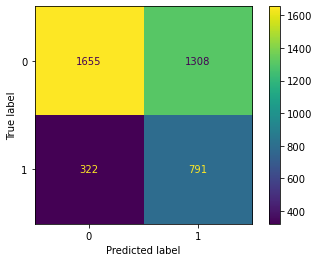

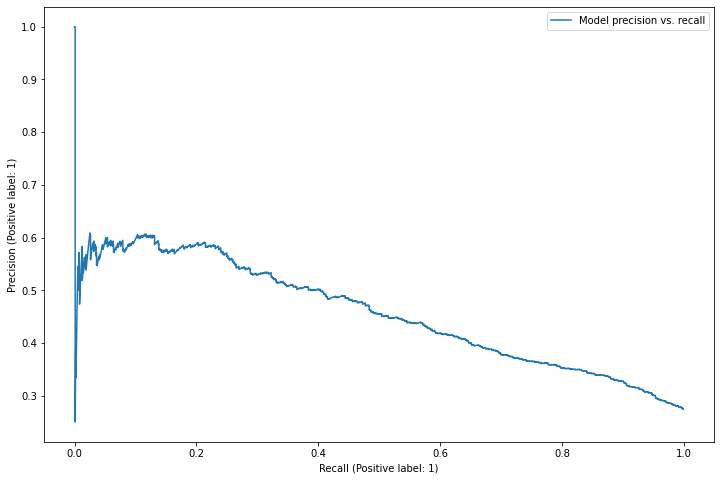

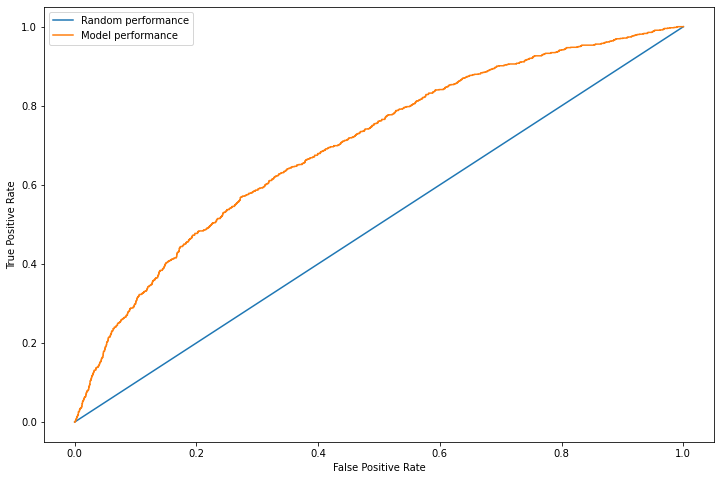

In [10]:
# display results for the best estimator we found
predictions = best_estimator.predict(df_features)
probabilities = best_estimator.predict_proba(df_features)[:,1]
mindwandering.evaluate.evaluate_model_results(mind_wandered_label, predictions, probabilities)

In [11]:
# save the results and preliminary figures in the following cells

# create base save file name for this file, use datetime to keep a unique file name
now = datetime.now()
date_time = now.strftime('%Y%m%d-%H%M')
result_file_basename = 'replication-07-Neural-Network-using-Nadam' + date_time
print(result_file_basename)

replication-07-Neural-Network-using-Nadam20210603-0931


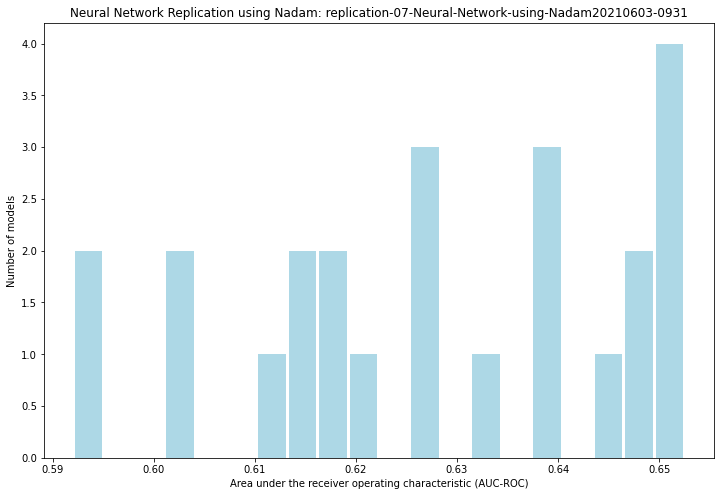

In [12]:
# A quick histogram of this search auc-roc scores.  Basically the figure 1 from the paper.
plt.figure(figsize=(12,8))

#bins = np.linspace(0.605, 0.612, 8)
plt.hist(df_result.mean_test_roc_auc, 
         bins=20,
         color='lightblue',
         rwidth=0.9);
#plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.ylabel('Number of models');
plt.title('Neural Network Replication using Nadam: ' + result_file_basename);

result_dir = '../figures'
result_file_name = result_file_basename + '.eps'
result_file_path = os.path.join(result_dir, result_file_name)
plt.savefig(result_file_path)

In [13]:
# save the search results dataframe to a file so can retrieve for later data analysis or
# to combine with other grid search results for summaries
result_dir = '../NeuralNetworkResults'
result_file_name = result_file_basename + '.pkl'
result_file_path = os.path.join(result_dir, result_file_name)
df_result.to_pickle(result_file_path)